# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
# install package for displaying animation
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cuda:0


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



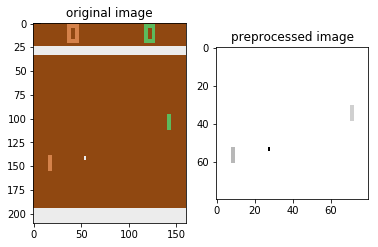

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [4]:
import numpy as np
def output_volume(in_dims, k=3, s=2, p=0, transpose=False):
    ''' Calculate a convolutional layer's output size params:
        in_dims = input size (int)
        k = kernel size 
        s = stride (int)
        p = padding (int)
    '''
    if not transpose:
        out_size = (in_dims - k + 2*p)/s + 1 #convolution out
    else:
        out_size = (in_dims - 1)*s + k - 2*p #deconvolution out
    return int(np.floor(out_size))

In [5]:
output_volume(26, 6, 3, 0), 7*7*16, 80*80*2, 784/7

(7, 784, 12800, 112.0)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
                        #self.batchnorm = nn.BatchNorm2d()
        # 2 channel from the stacked frame
        # 80x80x2 to 26x26x8
        self.conv1 = nn.Conv2d(2, 8, kernel_size=5, stride=3, padding=1, bias=False)
        # 26x26x8 to 7x7x16
        self.conv2 = nn.Conv2d(8, 16, kernel_size=6, stride=3)
        self.size=7*7*16  #=784
        
        # two fully connected layer
        self.fc1 = nn.Linear(self.size, 112) # =7*16
        self.fc2 = nn.Linear(112, 1)

        # Sigmoid to 
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))

In [7]:
# run your own policy!
#policy=Policy().to(device)
policy = torch.load('PPO_X.policy')

 # Solution policy:
#policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress

In [8]:
#pong_utils.play(env, policy, time=200) 

# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [9]:
discount=0.99
rewards=np.random.rand(64)
discount = discount**np.arange(64)
discount

array([ 1.        ,  0.99      ,  0.9801    ,  0.970299  ,  0.96059601,
        0.95099005,  0.94148015,  0.93206535,  0.92274469,  0.91351725,
        0.90438208,  0.89533825,  0.88638487,  0.87752102,  0.86874581,
        0.86005835,  0.85145777,  0.84294319,  0.83451376,  0.82616862,
        0.81790694,  0.80972787,  0.80163059,  0.79361428,  0.78567814,
        0.77782136,  0.77004315,  0.76234271,  0.75471929,  0.74717209,
        0.73970037,  0.73230337,  0.72498034,  0.71773053,  0.71055323,
        0.70344769,  0.69641322,  0.68944909,  0.6825546 ,  0.67572905,
        0.66897176,  0.66228204,  0.65565922,  0.64910263,  0.6426116 ,
        0.63618549,  0.62982363,  0.62352539,  0.61729014,  0.61111724,
        0.60500607,  0.59895601,  0.59296645,  0.58703678,  0.58116641,
        0.57535475,  0.5696012 ,  0.56390519,  0.55826614,  0.55268348,
        0.54715664,  0.54168508,  0.53626823,  0.53090554])

In [10]:
rewards#.shape# = np.asarray(rewards)*discount[:,np.newaxis]
#discount[:,np.newaxis].shape

array([ 0.49864389,  0.77356218,  0.12025376,  0.14132518,  0.44948126,
        0.16568956,  0.07621102,  0.24116561,  0.13260472,  0.60678708,
        0.74593255,  0.30366003,  0.62006687,  0.58340802,  0.56891855,
        0.93061152,  0.73421911,  0.93857723,  0.05253139,  0.52258092,
        0.48674618,  0.83973788,  0.5576619 ,  0.51537013,  0.79554543,
        0.83982426,  0.29660854,  0.49980061,  0.27251439,  0.09773659,
        0.07366276,  0.73022231,  0.61301747,  0.56655247,  0.69971211,
        0.20625716,  0.93254966,  0.26577588,  0.35574926,  0.31133633,
        0.12249158,  0.02043519,  0.48147536,  0.13734156,  0.57216114,
        0.39722962,  0.34551963,  0.54069643,  0.11121201,  0.86917601,
        0.86046108,  0.96469779,  0.62018754,  0.91691746,  0.76910744,
        0.20888191,  0.76541591,  0.2296025 ,  0.25910284,  0.76659936,
        0.50359033,  0.02577813,  0.66809434,  0.84468272])

In [11]:
#rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
#rewards_future.shape
rewards[::-1].cumsum(axis=0).shape#[::-1]

(64,)

In [12]:
def clipped_surrogate(policy, old_probs, states, actions, rewards, discount = 0.995, epsilon=0.1, beta=0.01):
    ## WRITE YOUR OWN CODE HERE  ## from plot_utils
    #####################?
    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10

    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    ######################?
    
    # move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)

    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)

    # ratio for clipping
    ratio = new_probs/old_probs

    # clipped function
    clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    clipped_surrogate = torch.min(ratio*rewards, clip*rewards)
    
    # include a regularization term
    # this steers new_policy towards 0.5
    # prevents policy to become exactly 0 or 1 helps exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+(1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    # this returns an average of all the entries of the tensor
    # effective computing L_sur^clip / T
    # averaged over time-step and number of trajectories
    # this is desirable because we have normalized our rewards
    return torch.mean(clipped_surrogate + beta*entropy)


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [14]:
from parallelEnv import parallelEnv
import numpy as np

# widget bar to display progress
!pip install progressbar
import progressbar as pb

envs = parallelEnv('PongDeterministic-v4', n=12, seed=1234)

discount_rate = .99  #
epsilon = 0.067  # 0.1
beta = .01     # .01
tmax = 1000    # training loop max = ? 
SGD_epoch = 5  #

# episodes = number episode batches to collect?
# WARNING: running through all 800 episodes will take 30-45 minutes
episodes = 200  # 800


In [15]:

def train(policy, envs, episodes, tmax, SGD_epoch, gamma=discount_rate, epsilon=epsilon, beta=beta):

    # keep track of progress
    mean_rewards = []

    # keep track of how long training takes
    widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA() ]
    timer = pb.ProgressBar(widgets=widget, maxval=episodes).start()

    for e in range(episodes):

        # collect trajectories
        old_probs, states, actions, rewards = pong_utils.collect_trajectories(envs, policy, tmax=tmax)

        total_rewards = np.sum(rewards, axis=0)

        # gradient ascent step
        for _ in range(SGD_epoch):

            # uncomment to utilize your own clipped function!
            L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

            #L = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)
            optimizer.zero_grad()
            L.backward()
            optimizer.step()
            del L

        # the clipping parameter reduces as time goes on
        epsilon*=.999

        # the regulation term also reduces
        # this reduces exploration in later runs
        beta*=.995

        # get the average reward of the parallel environments
        mean_rewards.append(np.mean(total_rewards))

        # display some progress every 20 iterations
        if (e+1)%20 ==0 :
            print("Episode: {0:d}, Avg. score: {1:f}".format(e+1,np.mean(total_rewards)))
            print(total_rewards)

        # update progress widget bar
        timer.update(e+1)

    timer.finish()
    return mean_rewards

In [16]:
mean_rewards = train(policy, envs, episodes, tmax, SGD_epoch, gamma=discount_rate, epsilon=epsilon, beta=beta)


Episode: 20, Avg. score: -6.583333
[-12.  -7.  -1. -16. -10.   0.  -7.  -2.  -4.  -2. -11.  -7.]


Episode: 40, Avg. score: -11.916667
[-11. -11. -11. -23.  -4.  -9. -10.  -1. -11. -21. -17. -14.]


Episode: 60, Avg. score: -8.416667
[ -9. -15.   0. -17.  -2. -15. -18.  -7.  -3.  -6.  -2.  -7.]


Episode: 80, Avg. score: -4.083333
[  0. -15.   0.  -8.  -5.   0.   0.  -6.   0.  -8.  -2.  -5.]


Episode: 100, Avg. score: -3.833333
[-3. -1. -8. -9. -1.  0.  0. -1. -6. -8. -2. -7.]


Episode: 120, Avg. score: -1.750000
[ 0. -3. -3.  0.  0. -2.  0. -3.  0. -7. -3.  0.]


Episode: 140, Avg. score: -1.416667
[ 0. -9. -1.  0.  0. -1. -5.  0.  0. -1.  0.  0.]


Episode: 160, Avg. score: -2.416667
[  0.   0.   0. -14.   0.   0.  -2.   0.   0. -13.   0.   0.]


Episode: 180, Avg. score: -1.416667
[ 0.  0.  0. -8.  0. -2.  0.  0.  0.  0. -7.  0.]


Episode: 200, Avg. score: -1.250000
[ 0.  0.  0.  0.  0.  0. -3.  0.  0. -6.  0. -6.]


In [20]:
# Hyperparameter Control 
envs = parallelEnv('PongDeterministic-v4', n=16, seed=1234)
discount_rate = .985  #
epsilon = 0.075  #
beta = .01     #
tmax = 800    # 1000 training loop max = ? 
SGD_epoch = 8  #
episodes = 100  #800

mean_rewards += train(policy, envs, episodes, tmax, SGD_epoch, gamma=discount_rate, epsilon=epsilon, beta=beta)

Episode: 20, Avg. score: -0.187500
[ 0. -1.  0.  0.  0.  0. -2.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


Episode: 40, Avg. score: -0.562500
[ 0.  0. -1.  0.  0. -5.  0.  0. -1.  0.  0.  0. -1. -1.  0.  0.]


Episode: 60, Avg. score: -1.375000
[ 0.  0. -3.  0.  0.  0. -1. -6.  0.  0.  0.  0.  0.  0. -3. -9.]


Episode: 80, Avg. score: -2.000000
[  0.   0.  -2.   0.   0.  -3.   0.   0.   0. -11.   0.   0. -14.  -2.   0.
   0.]


Episode: 100, Avg. score: -0.125000
[-2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


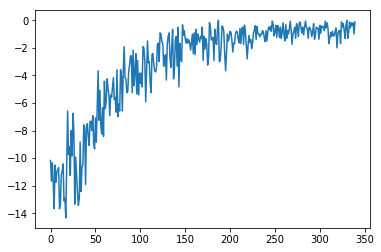

In [21]:
plt.plot(mean_rewards)


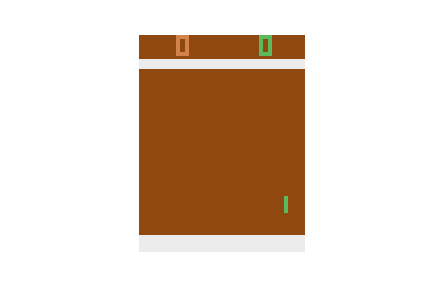
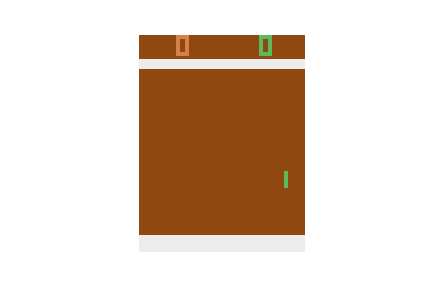
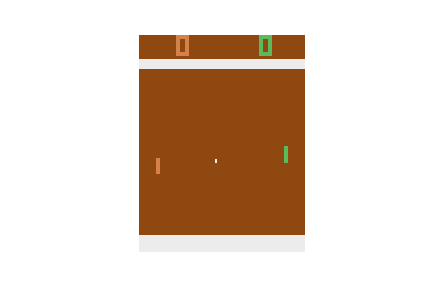
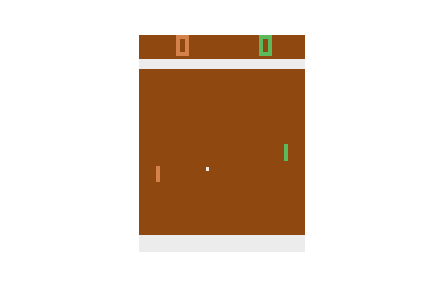
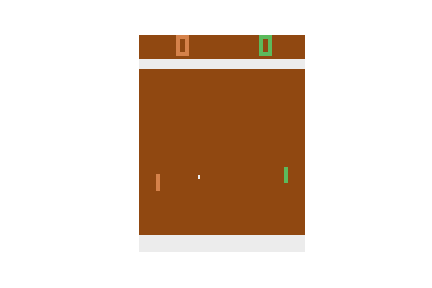
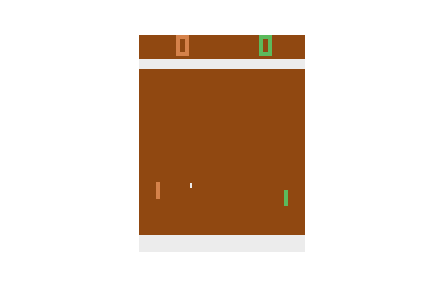
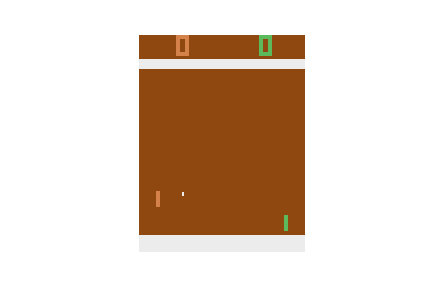
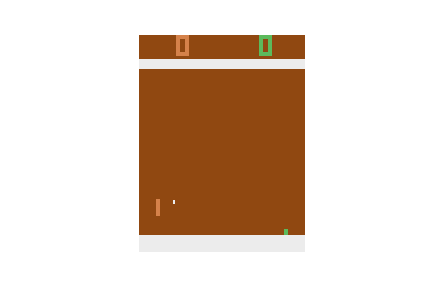
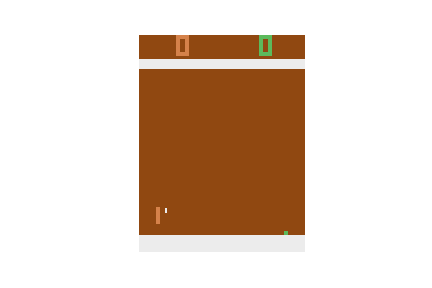
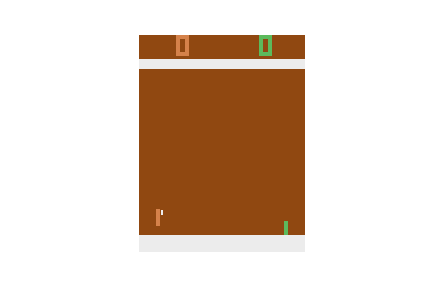
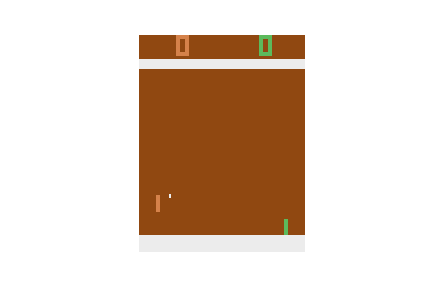
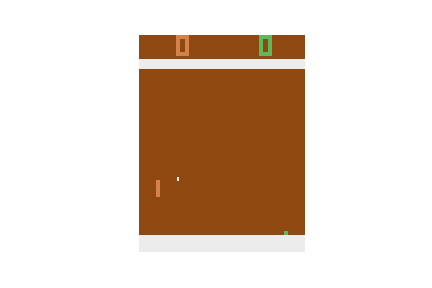
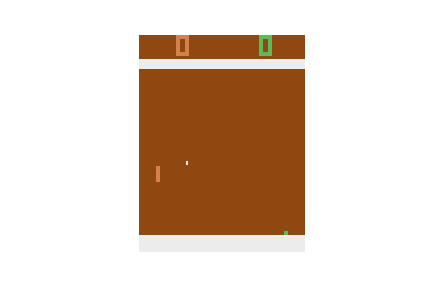
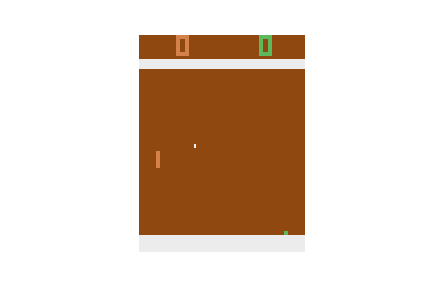
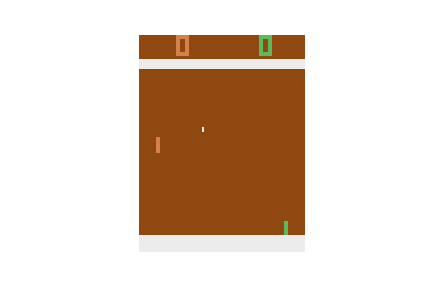
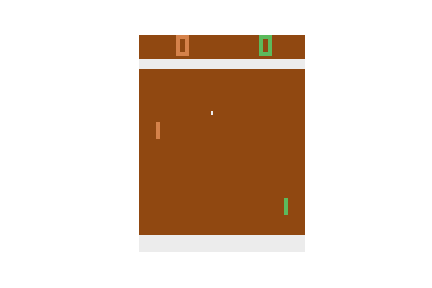
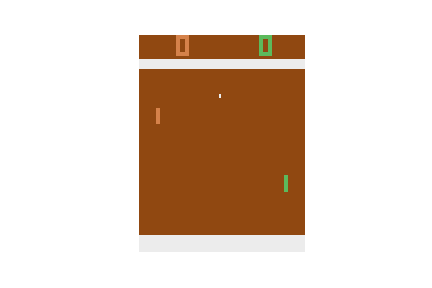
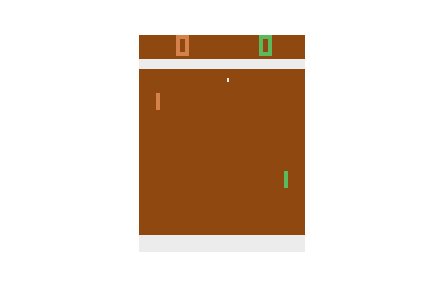
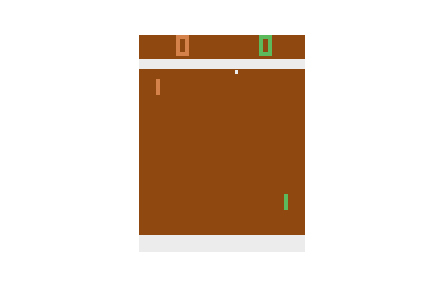
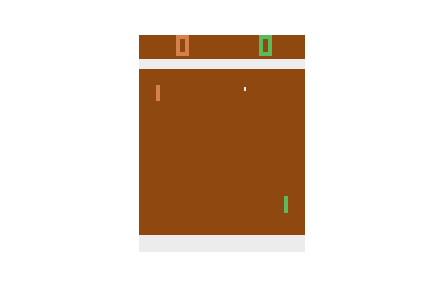
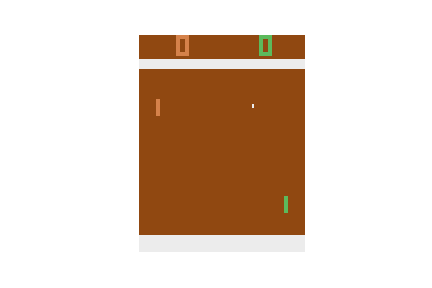
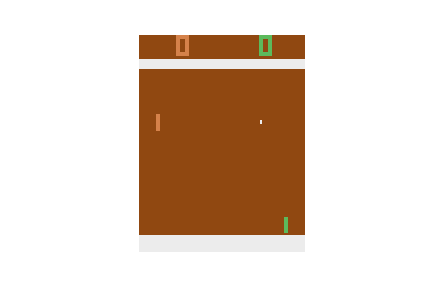
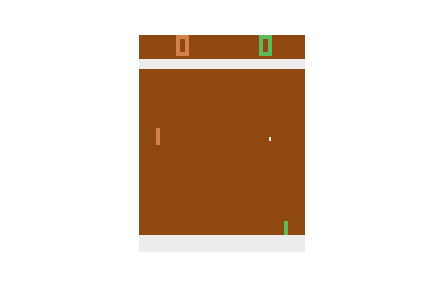
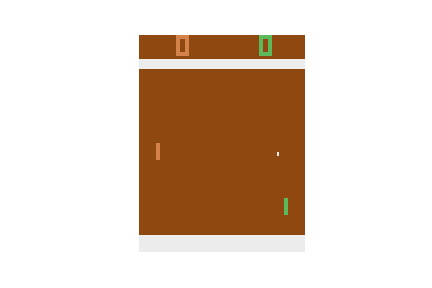
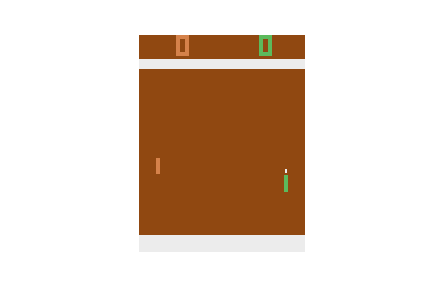
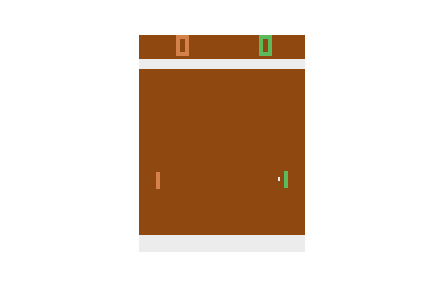
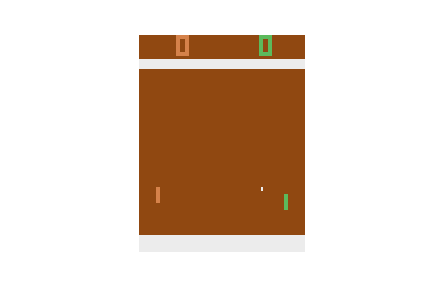
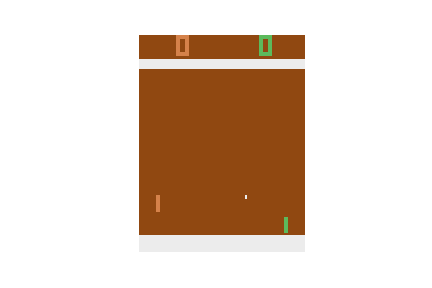
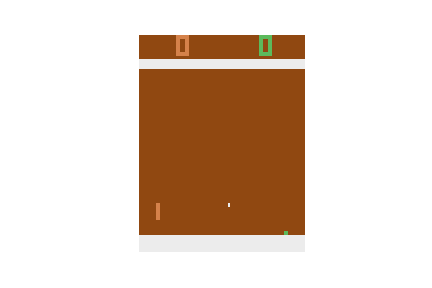
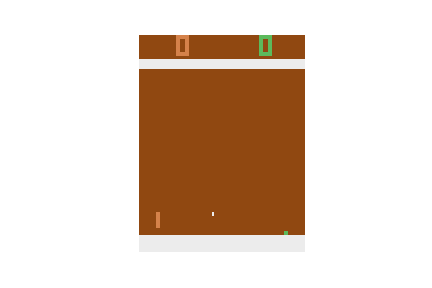
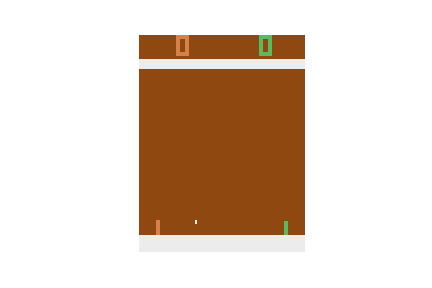
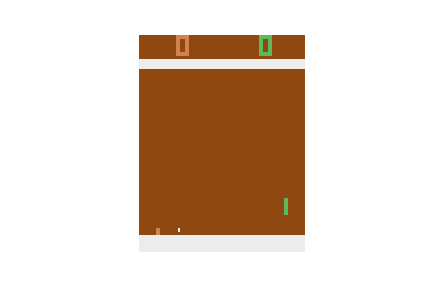
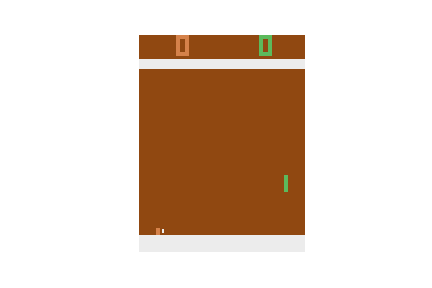
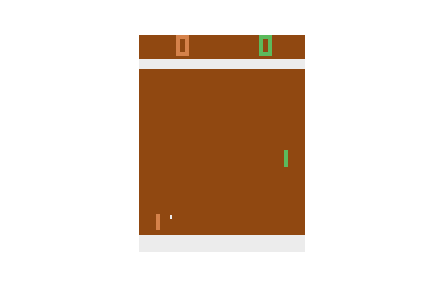
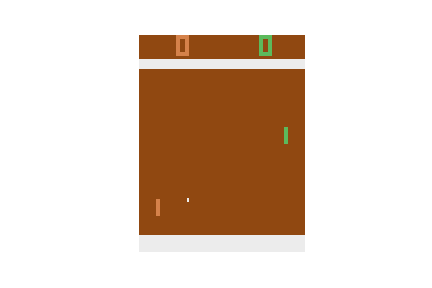
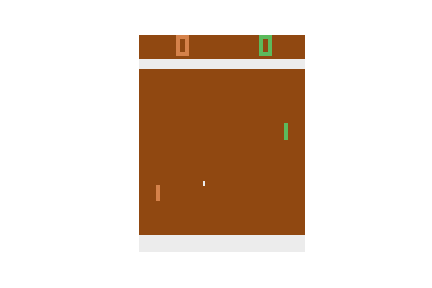
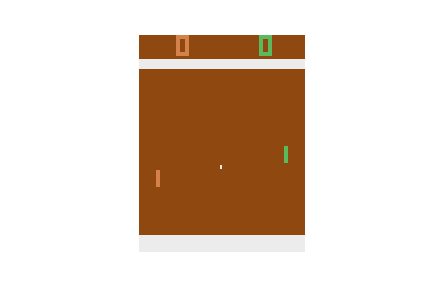
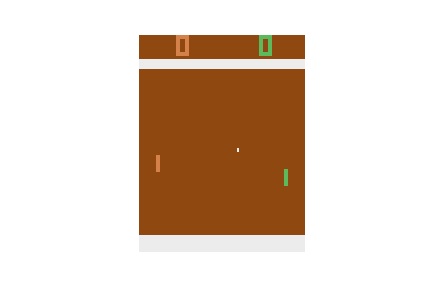
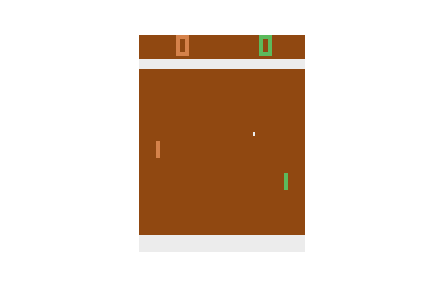
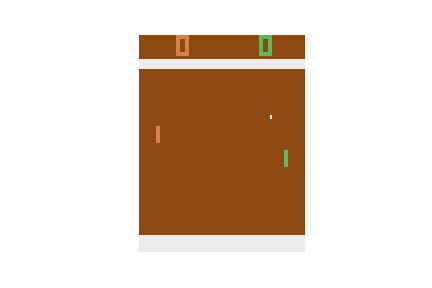
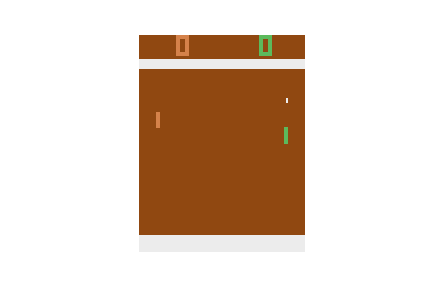
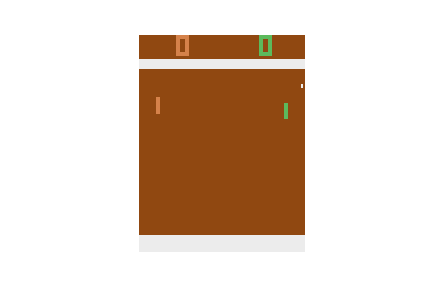
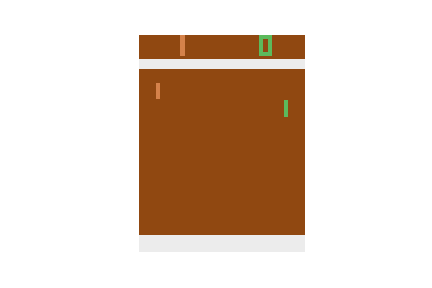
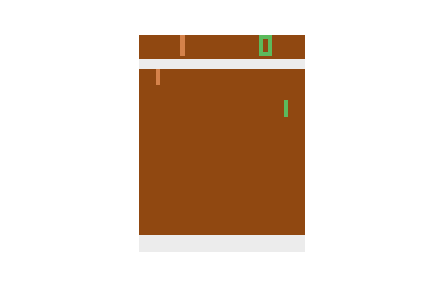
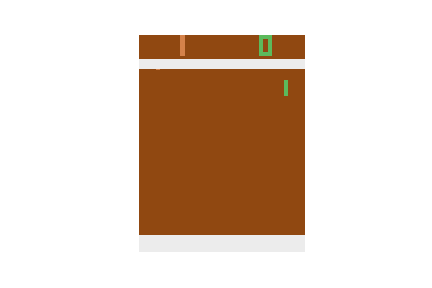
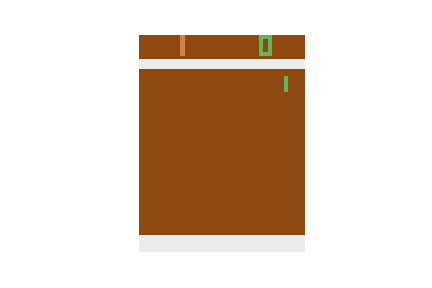
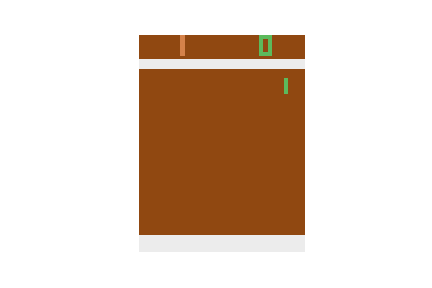
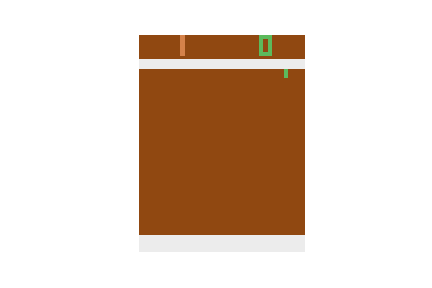
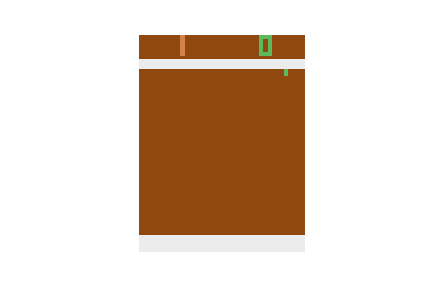
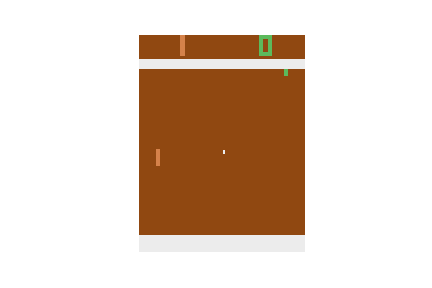
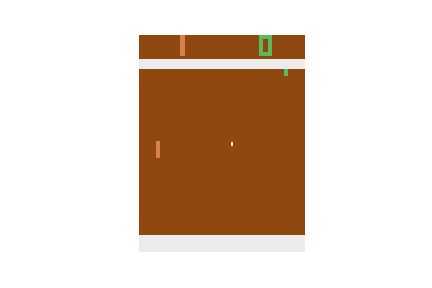
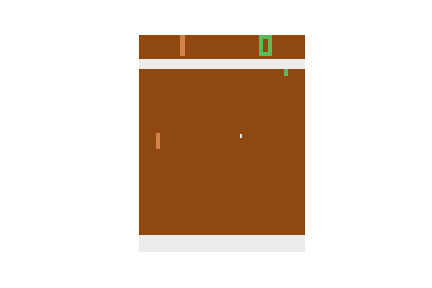
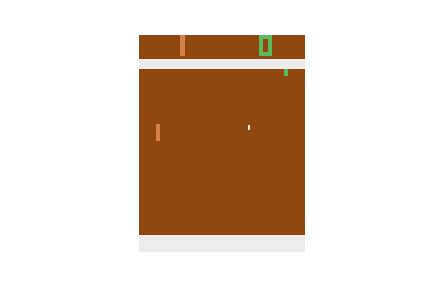
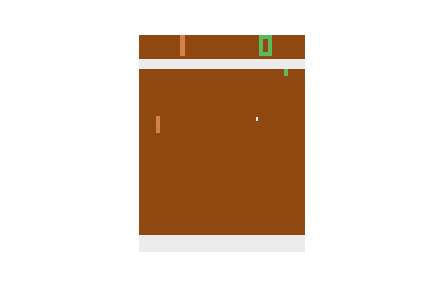
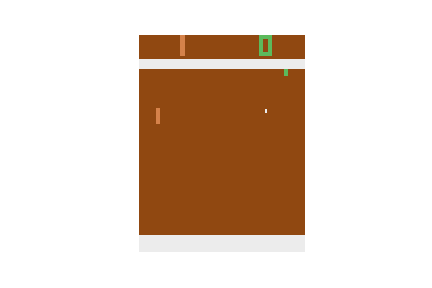
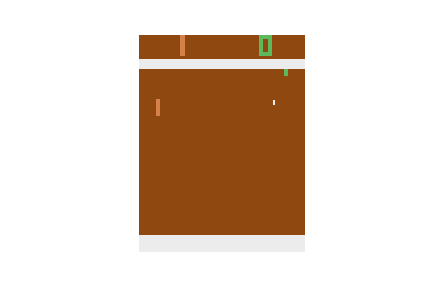
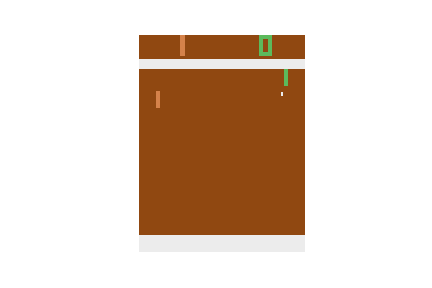
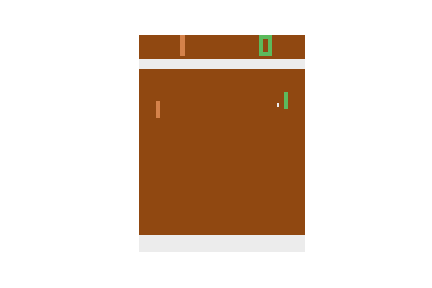
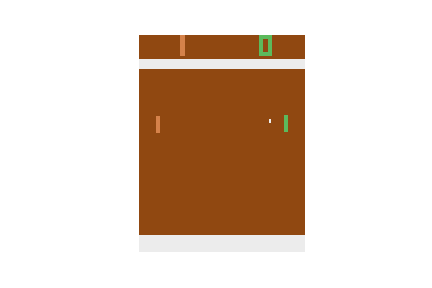
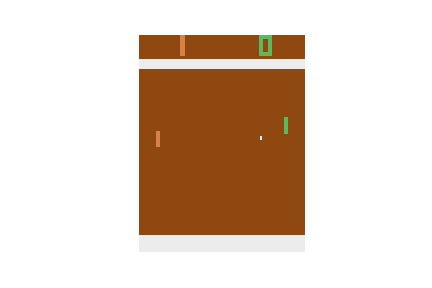
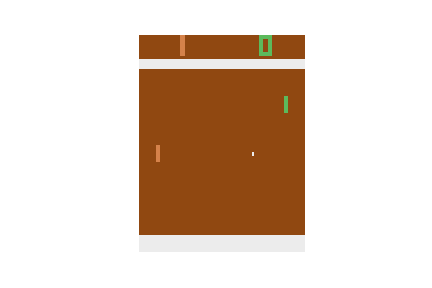
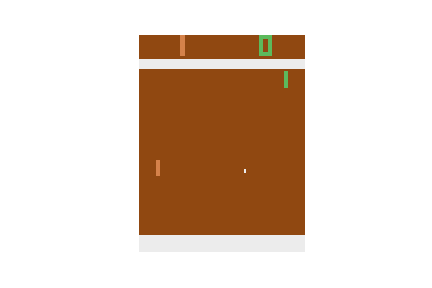
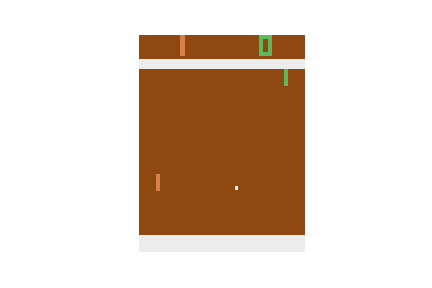
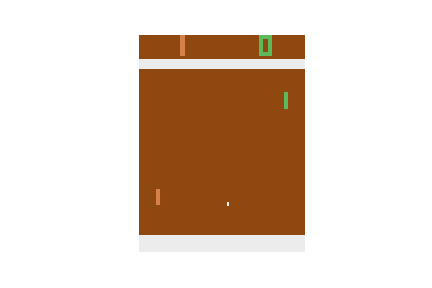
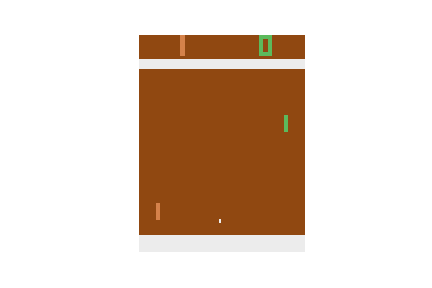
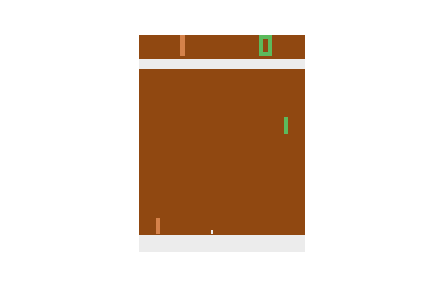
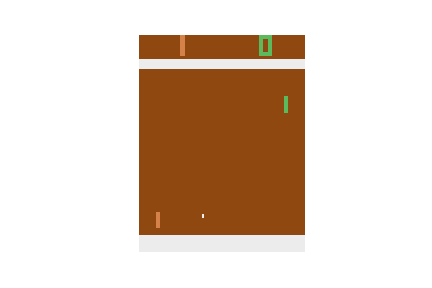
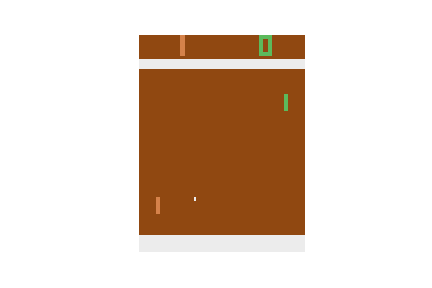
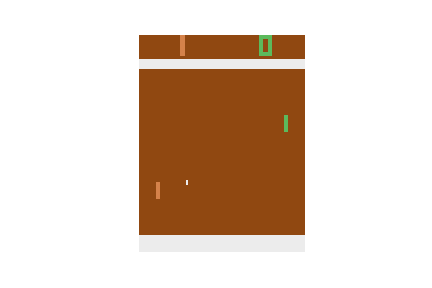
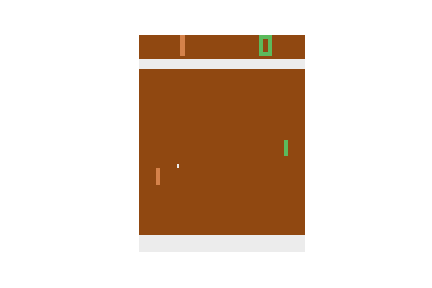
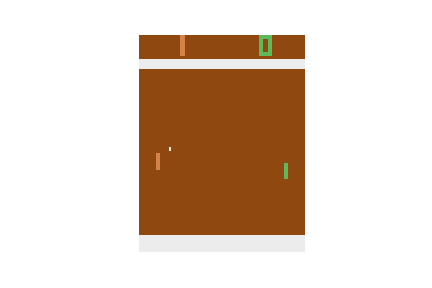
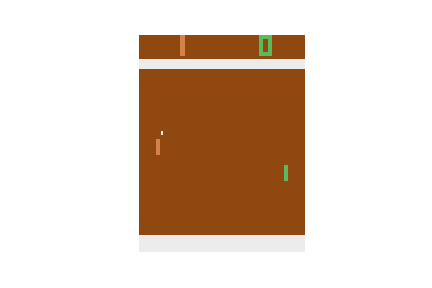
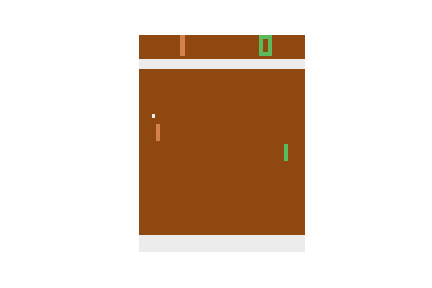
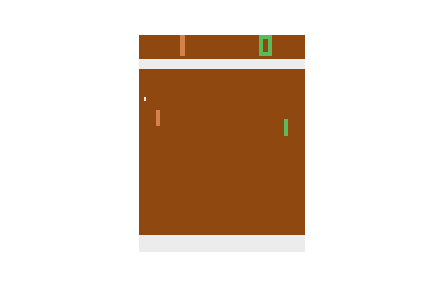
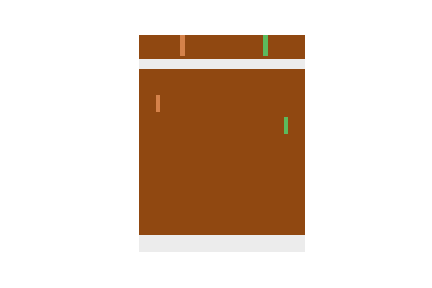
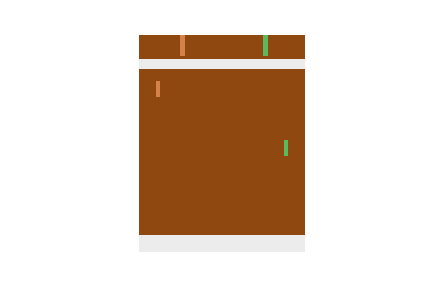
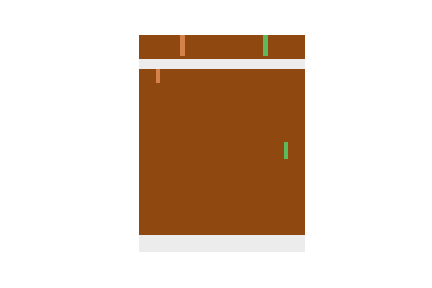
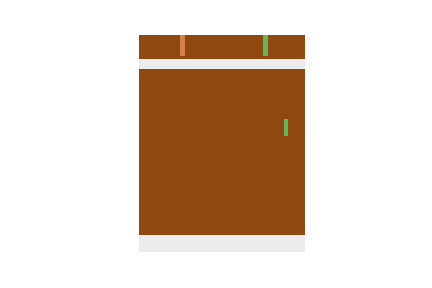
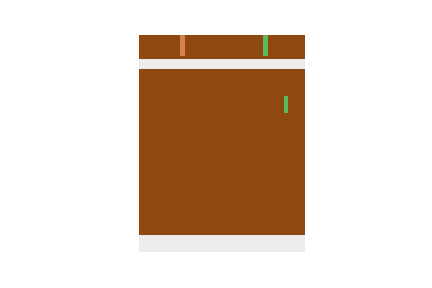
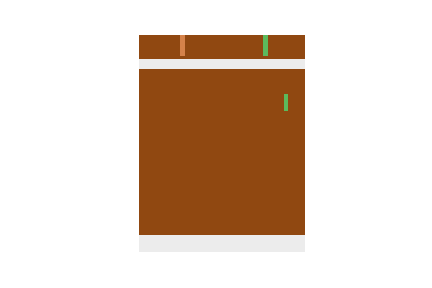
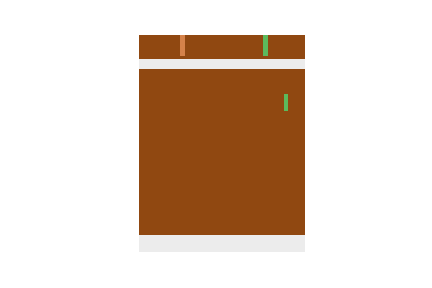
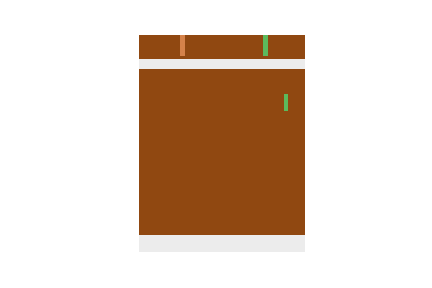
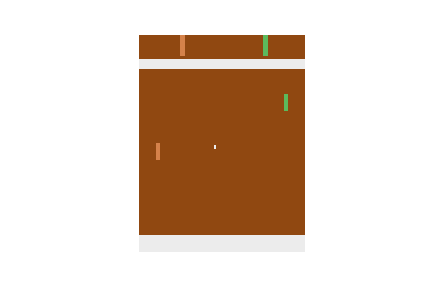
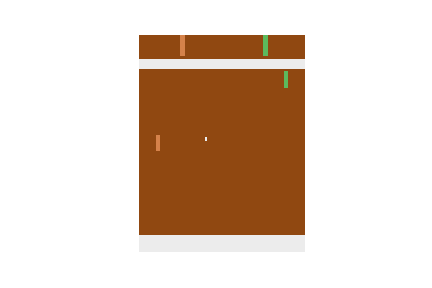
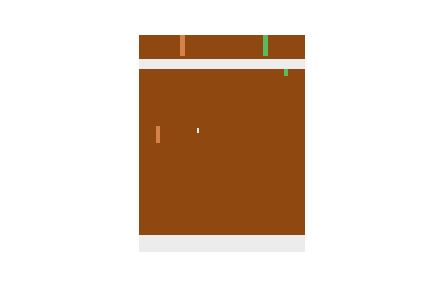
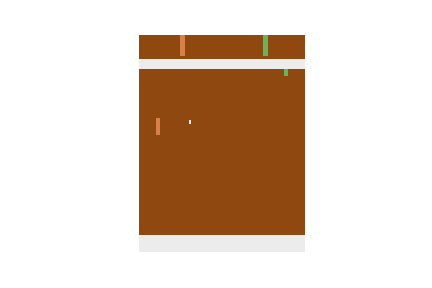
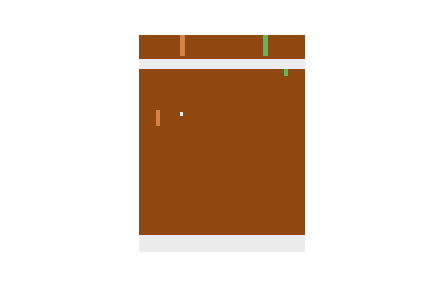
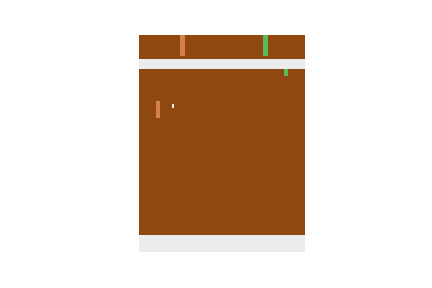
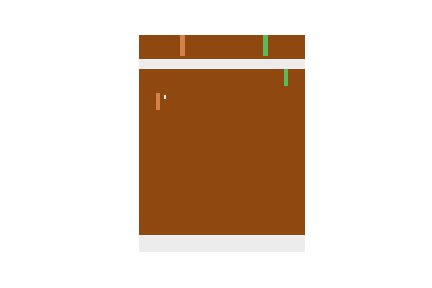
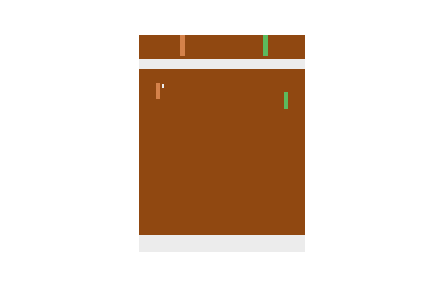
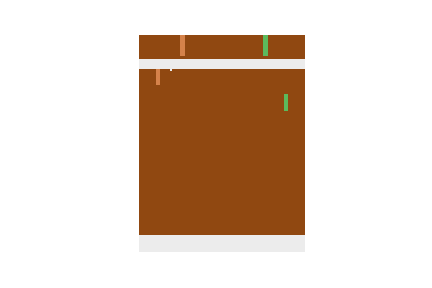
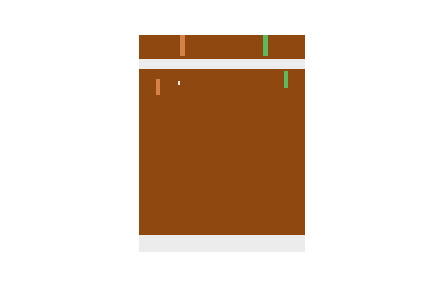
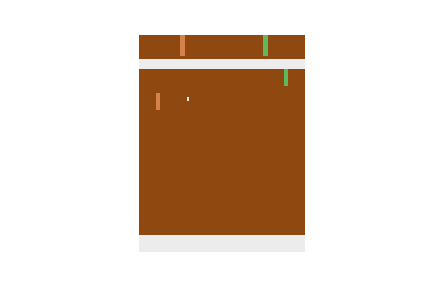
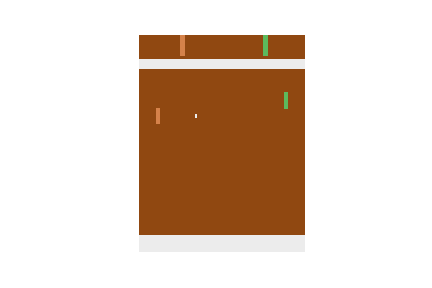
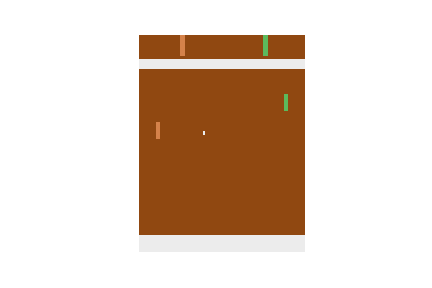
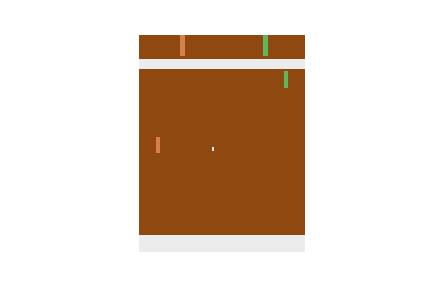
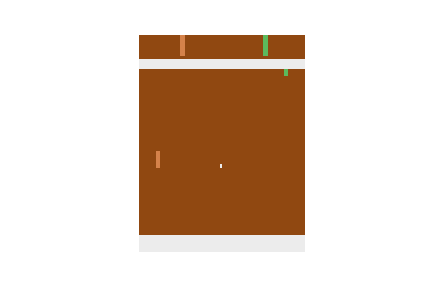
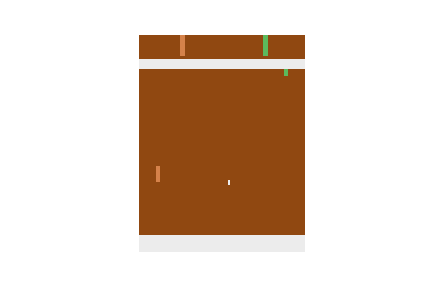
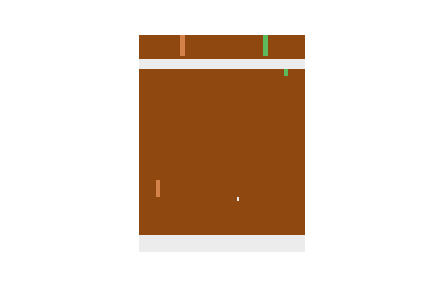
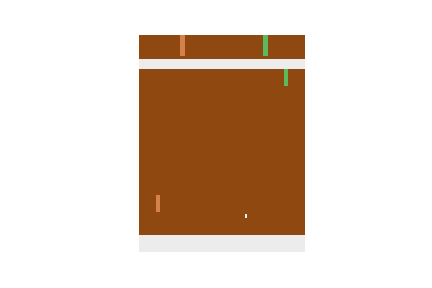
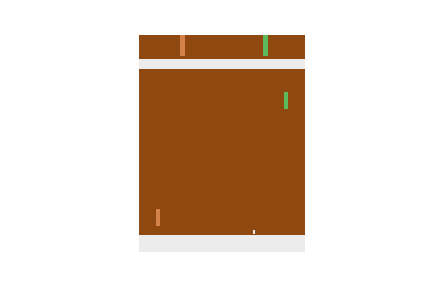
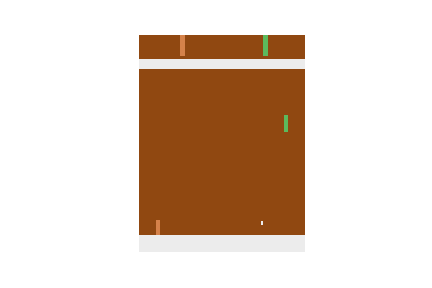
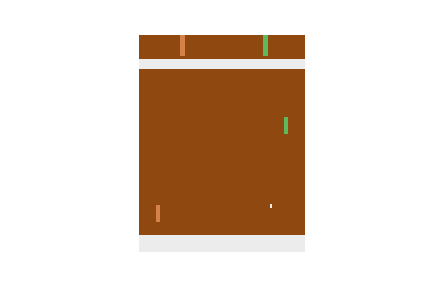
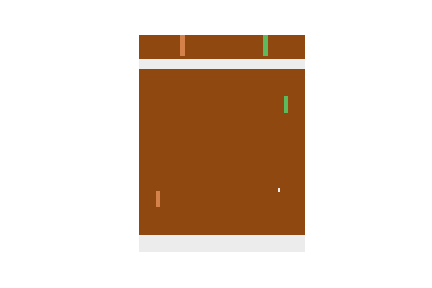
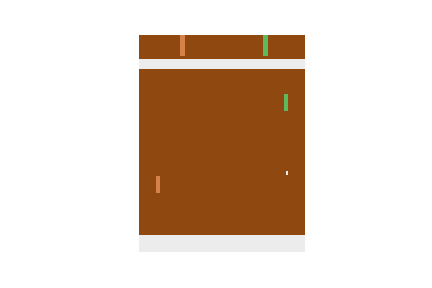
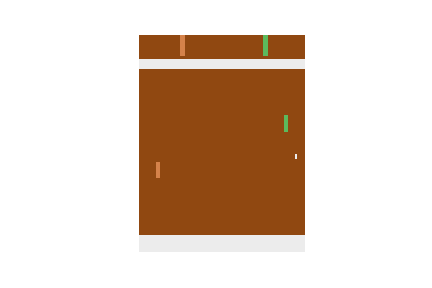
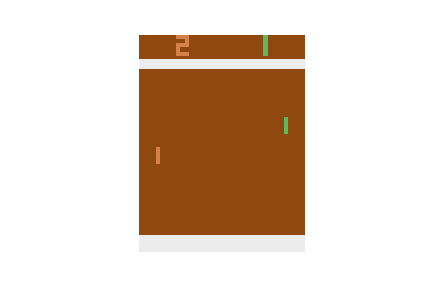
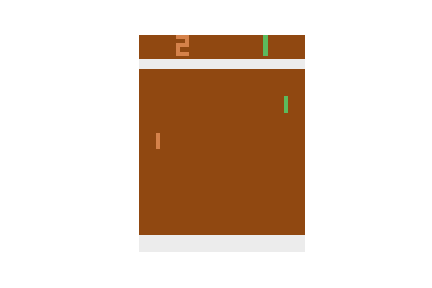
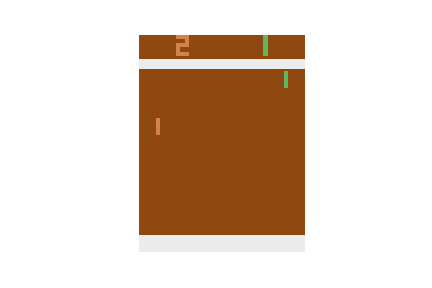
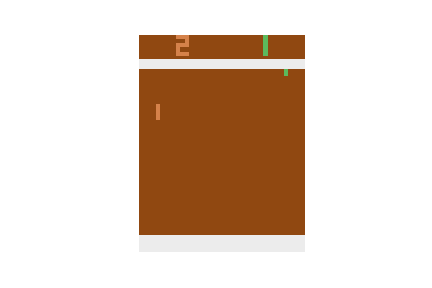
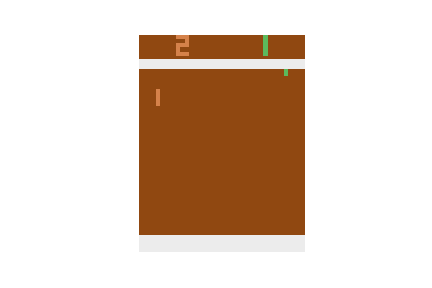
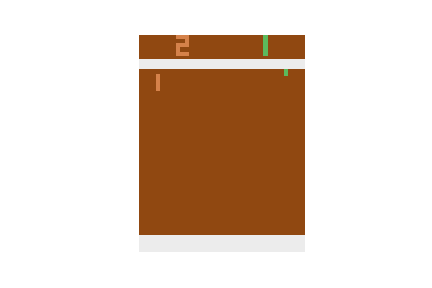
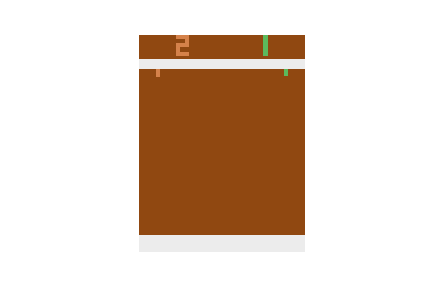
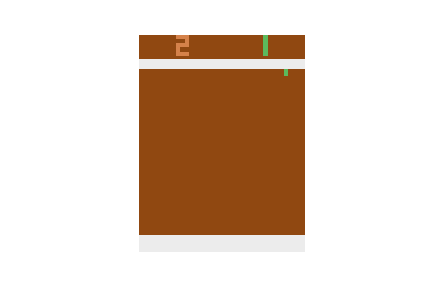
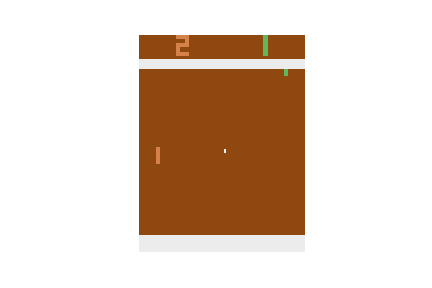
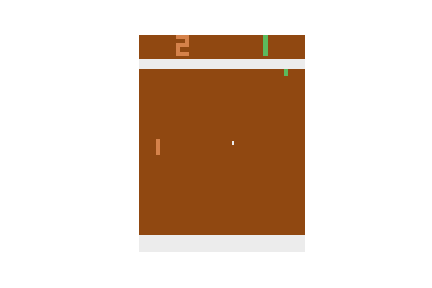
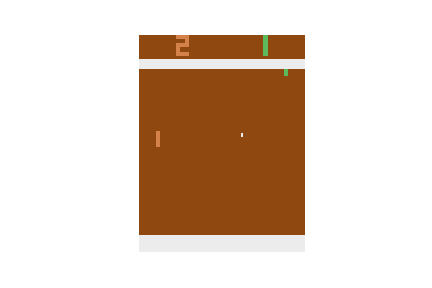
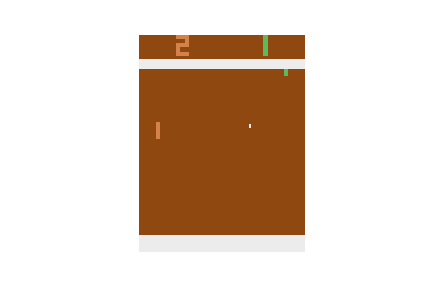
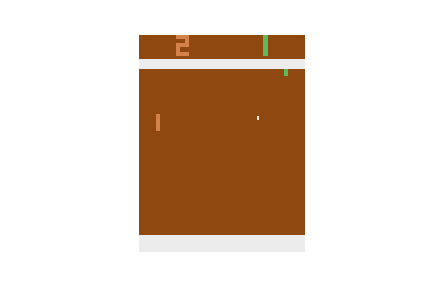
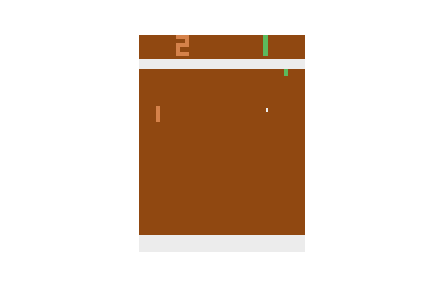
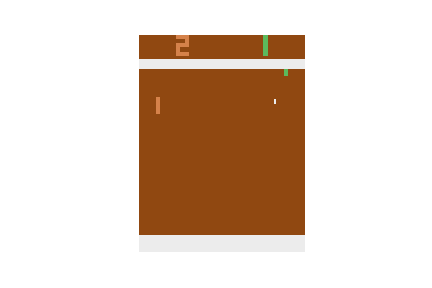
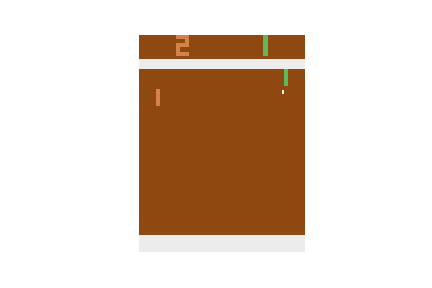
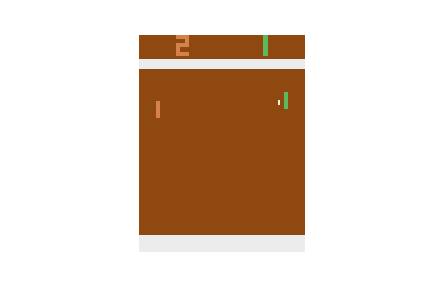
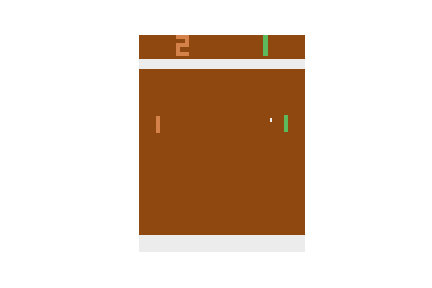
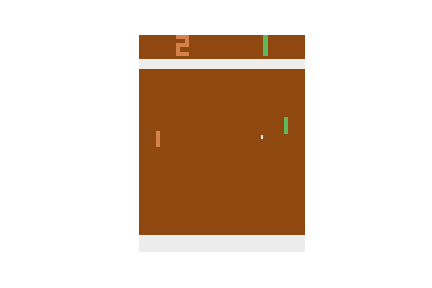
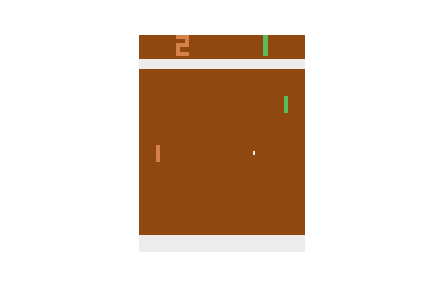
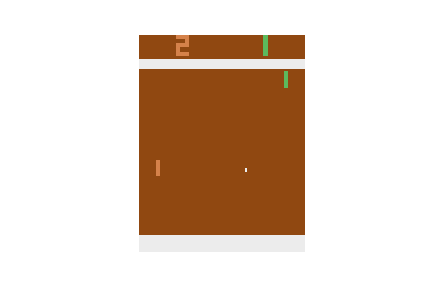
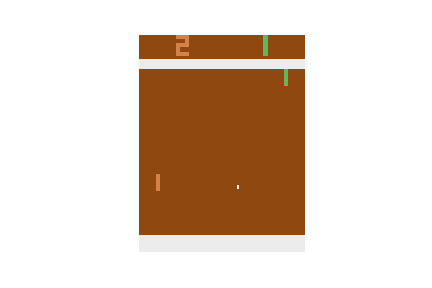
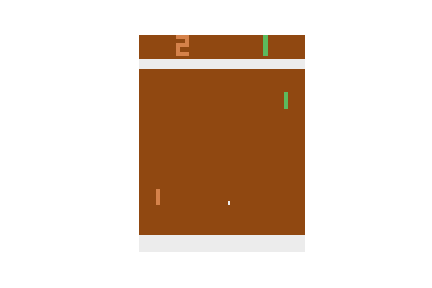
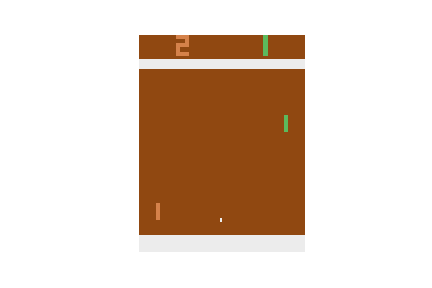
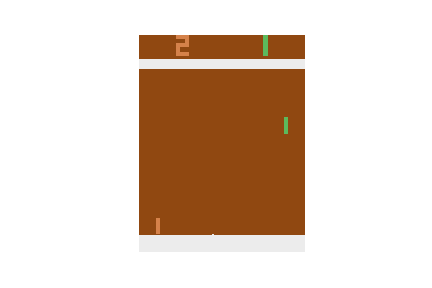
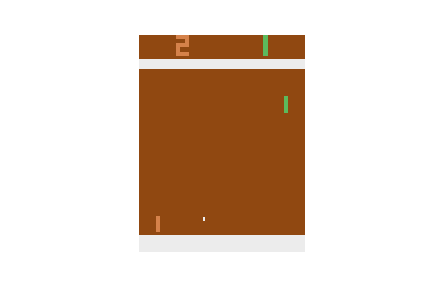
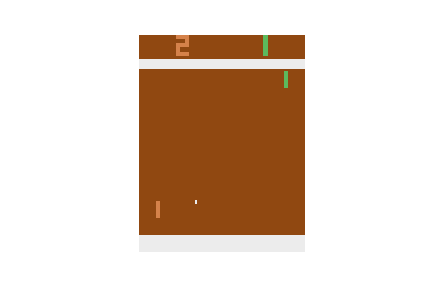
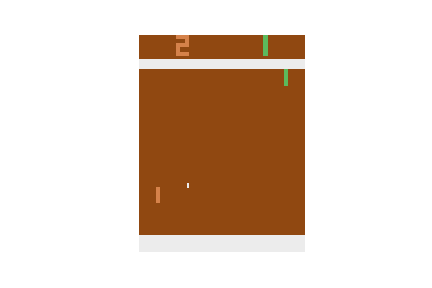
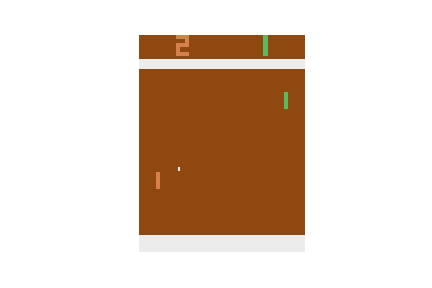
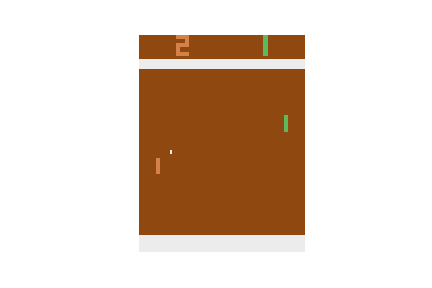
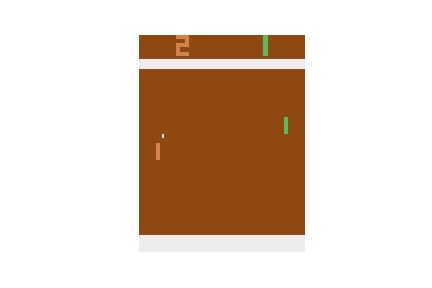
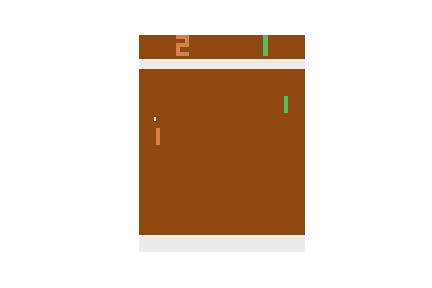
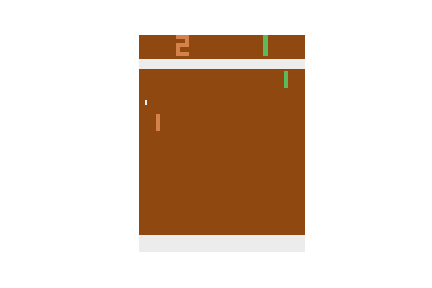
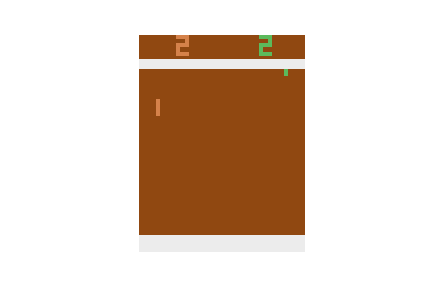
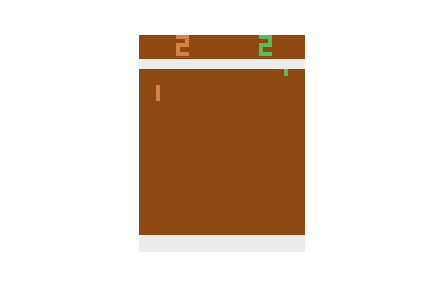
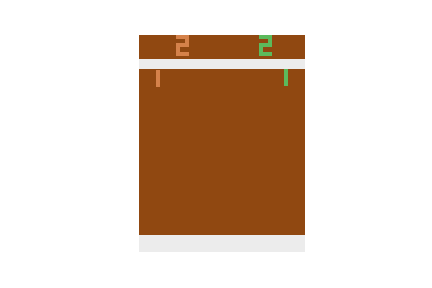
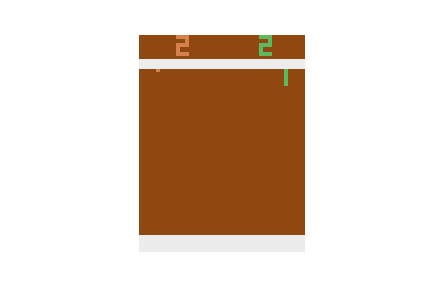
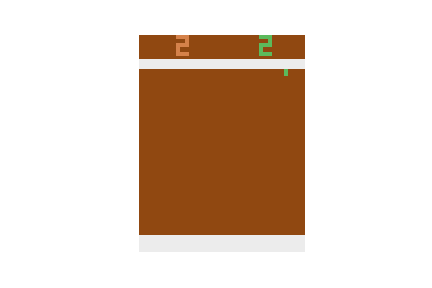
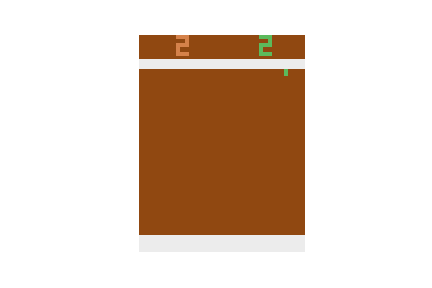
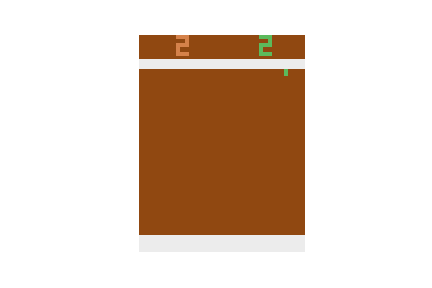
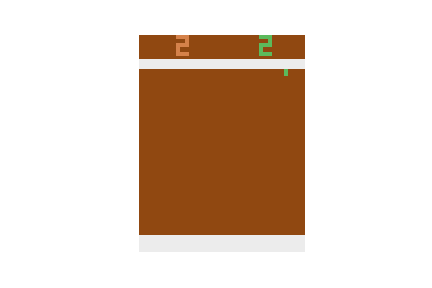
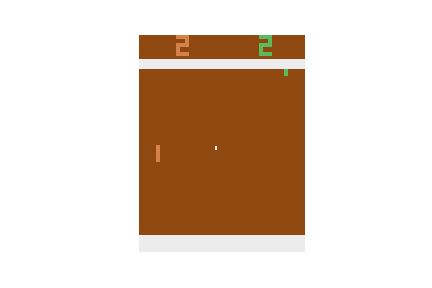
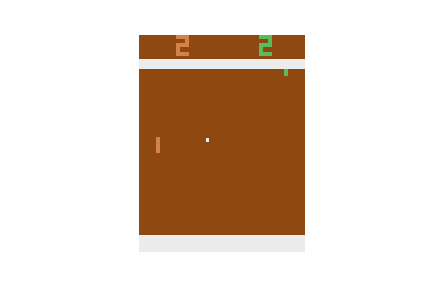
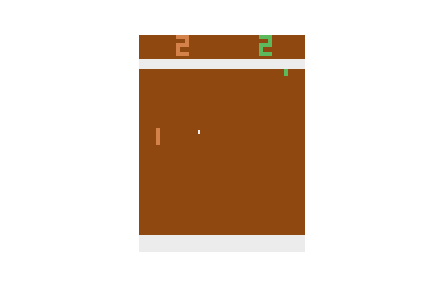
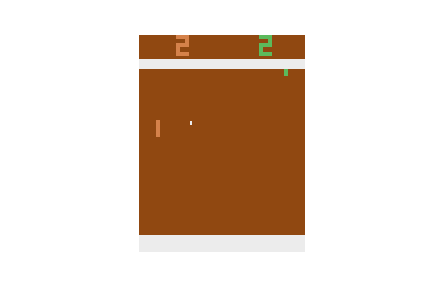
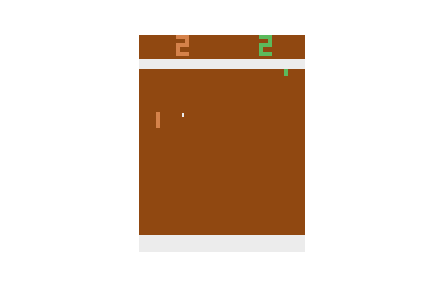
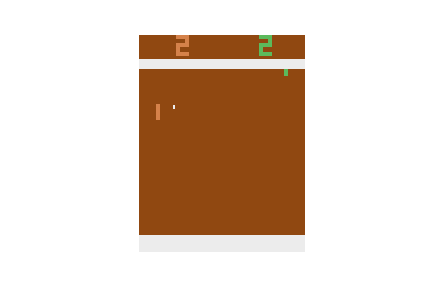
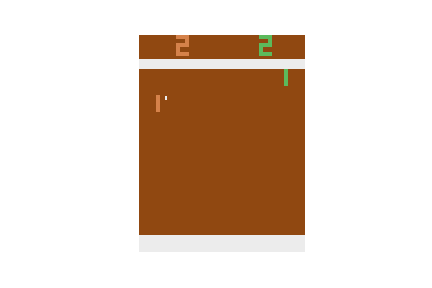
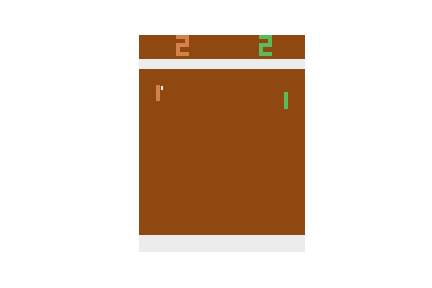
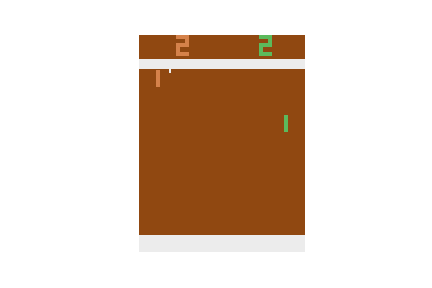
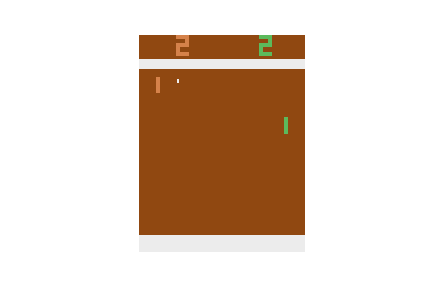
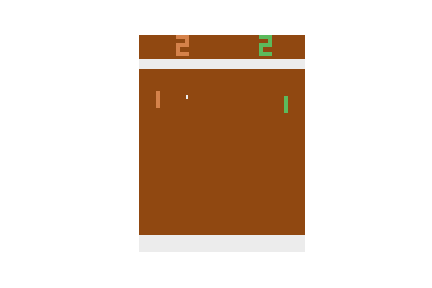
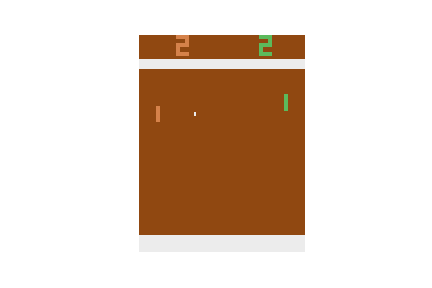
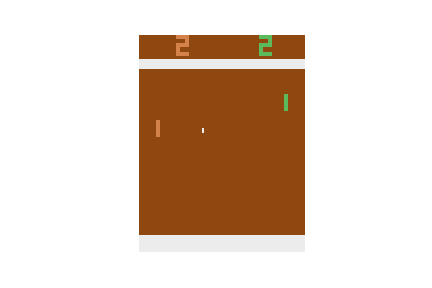
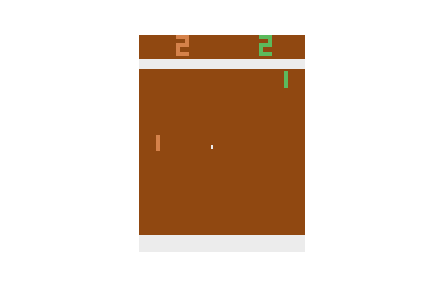
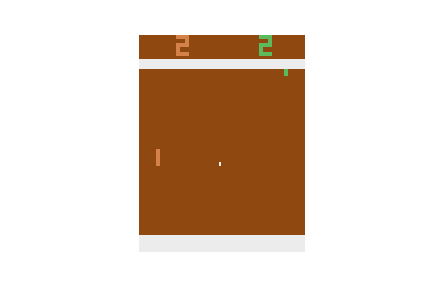
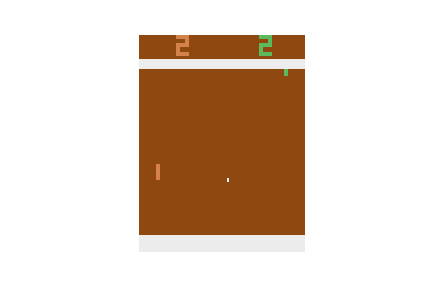
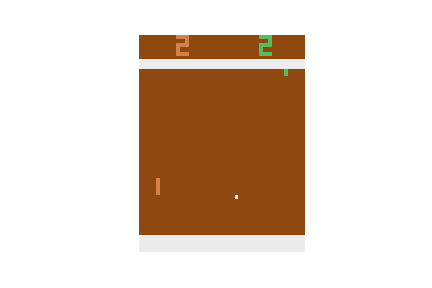
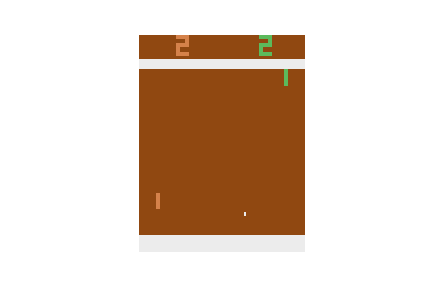
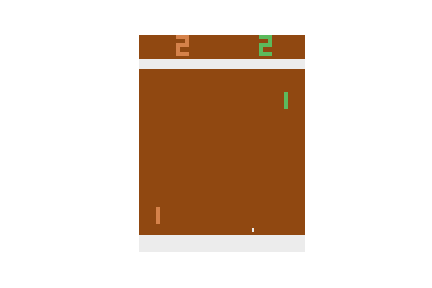
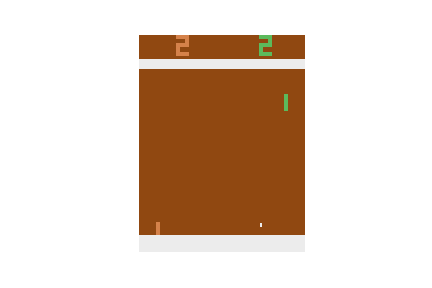
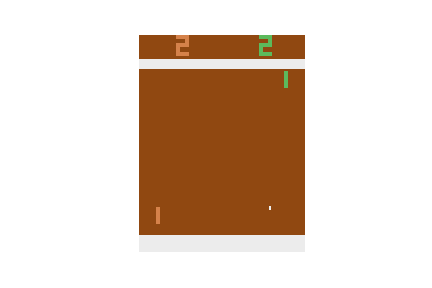
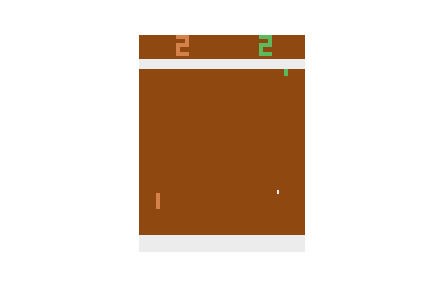
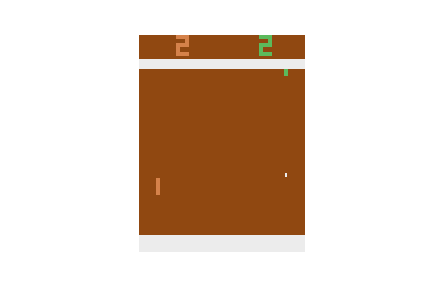
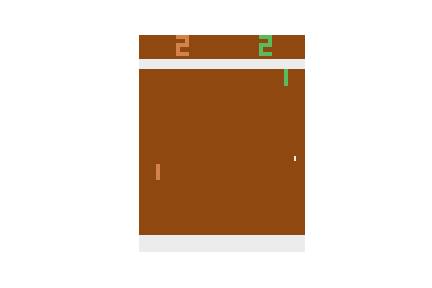
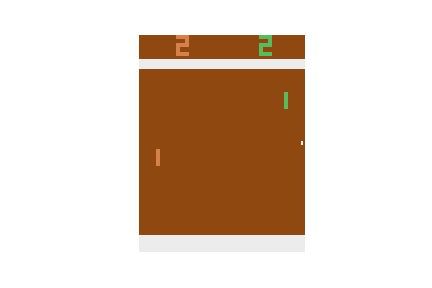
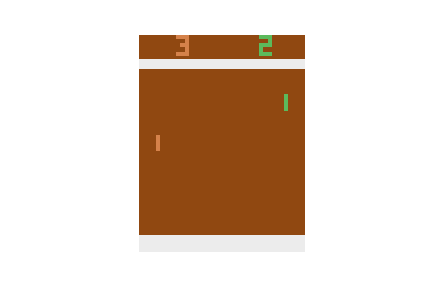
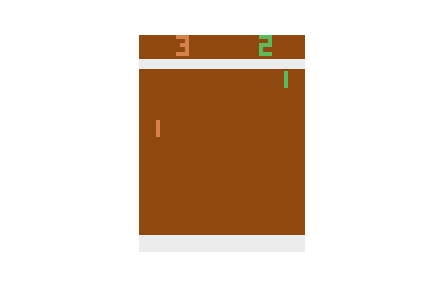
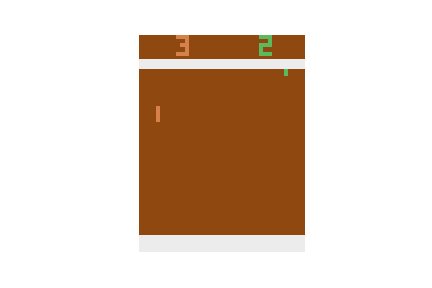
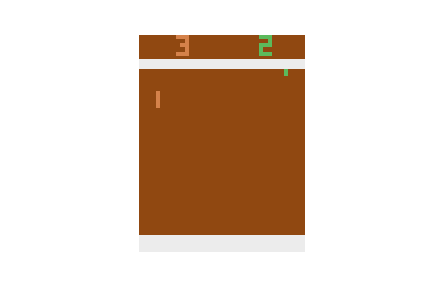
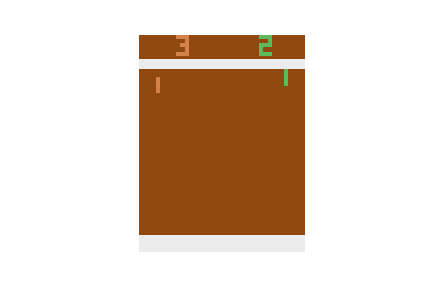
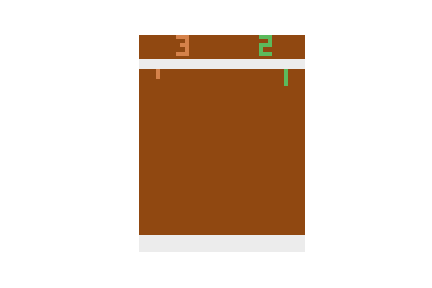
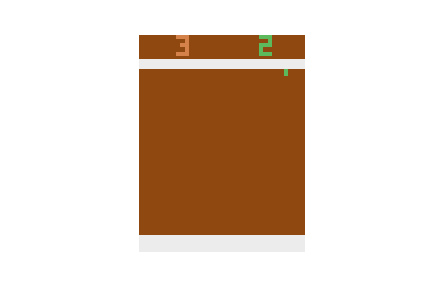
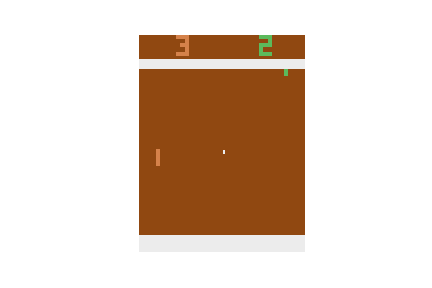
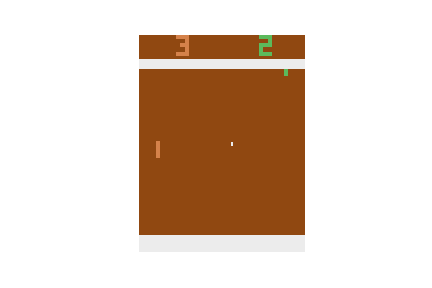
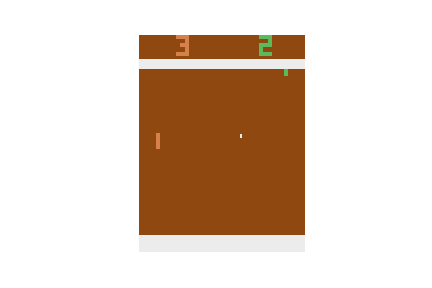
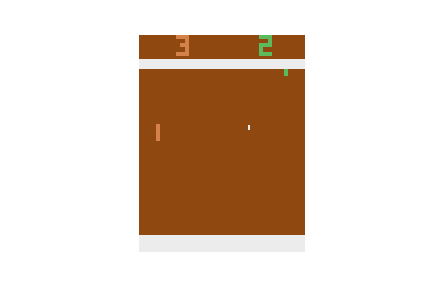
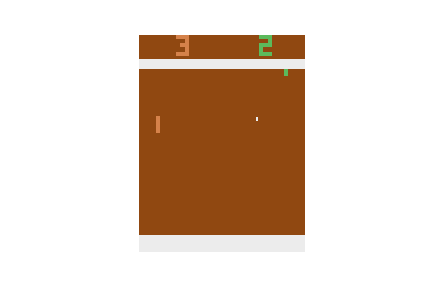
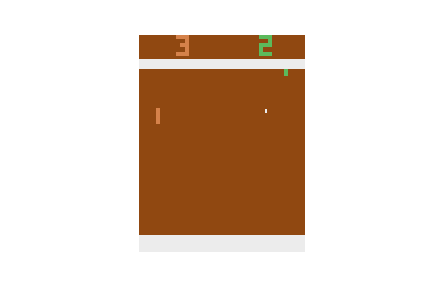
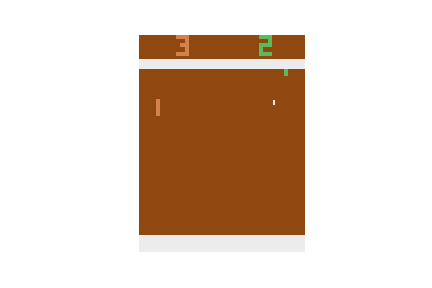
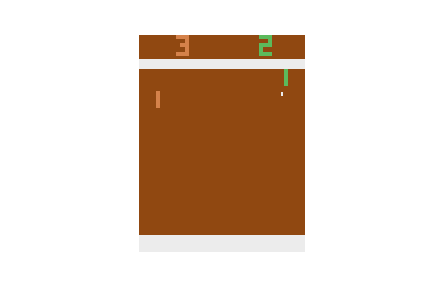
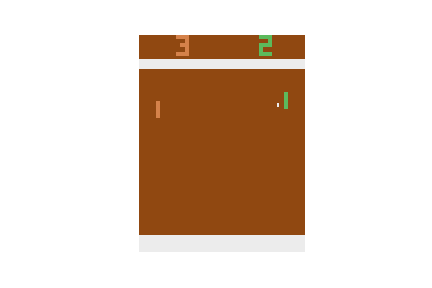
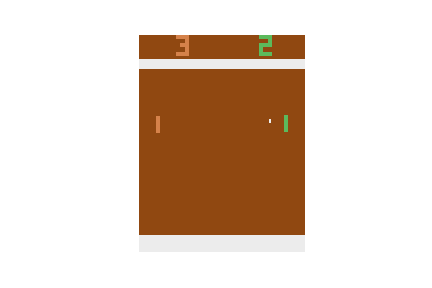
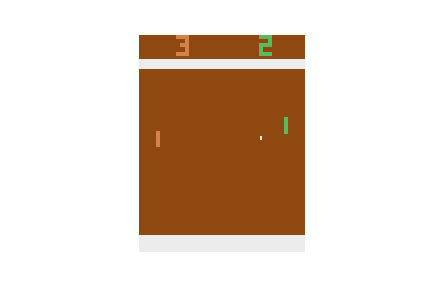
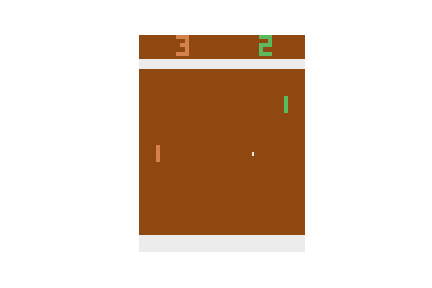
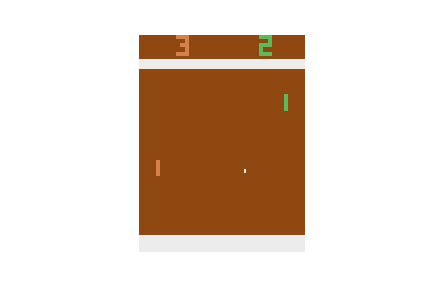
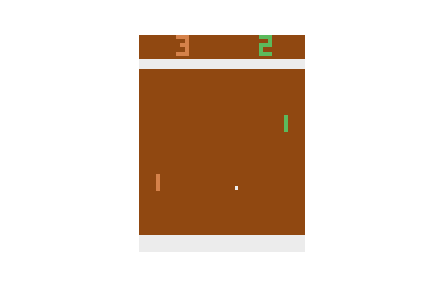
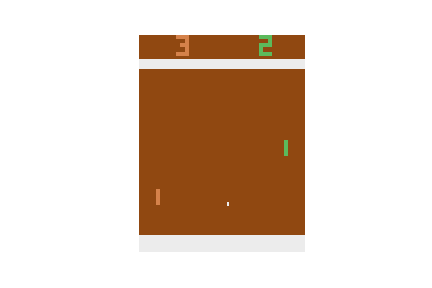
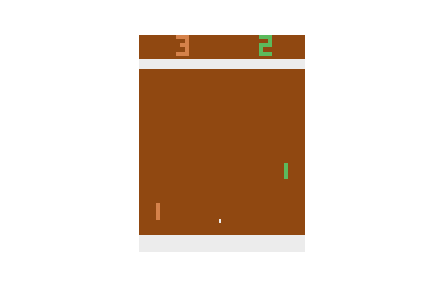
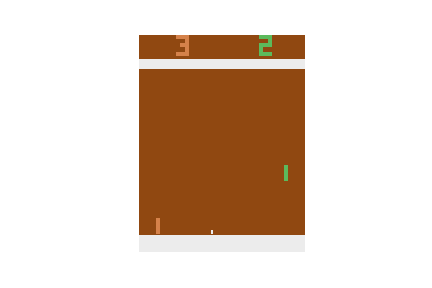
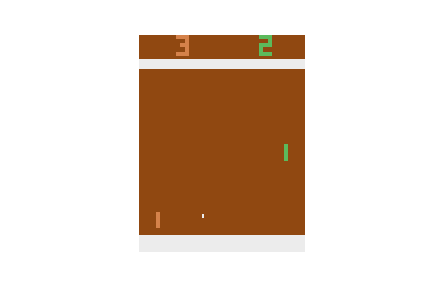
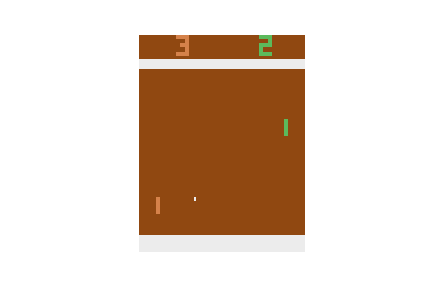
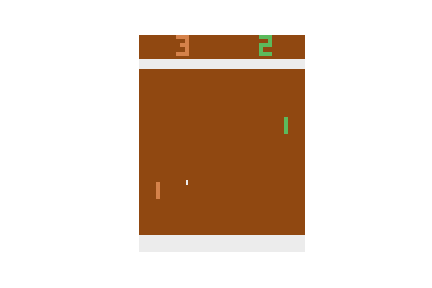
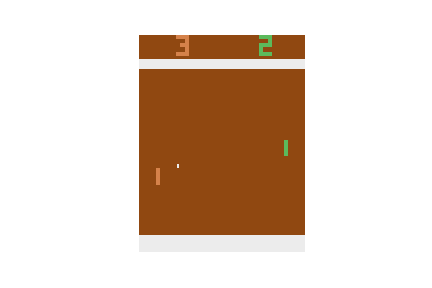
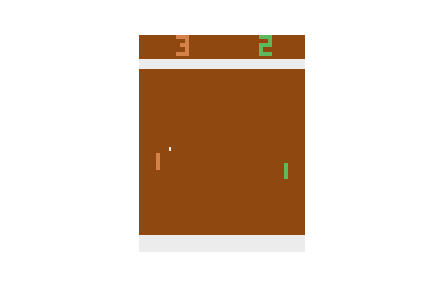
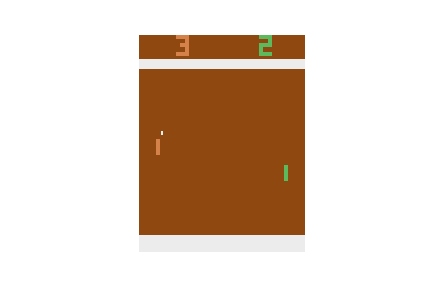
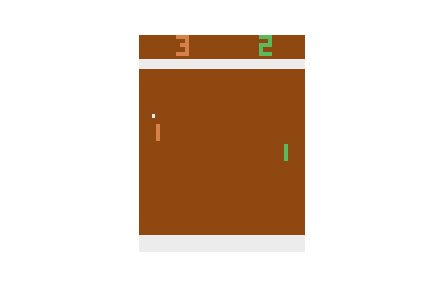
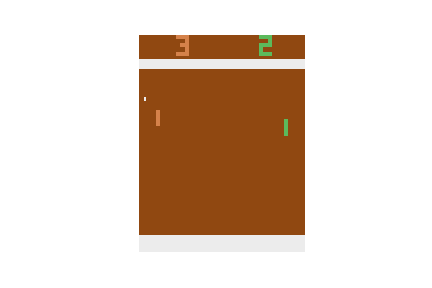
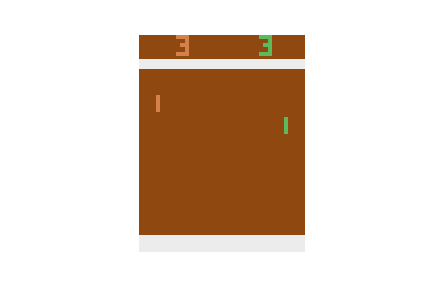
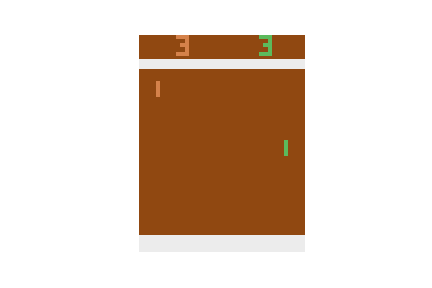
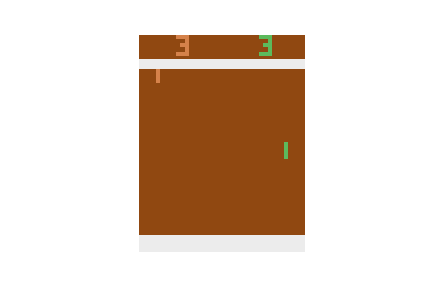
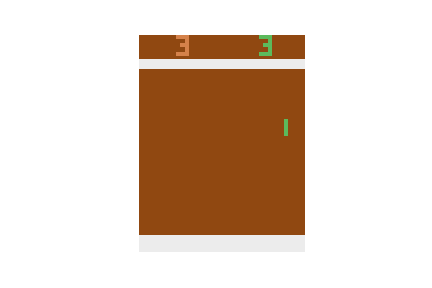
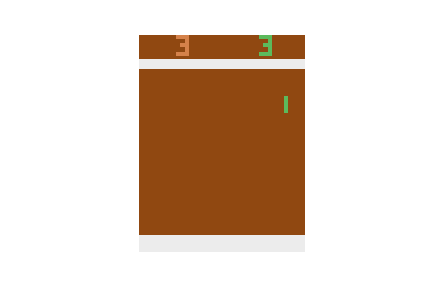
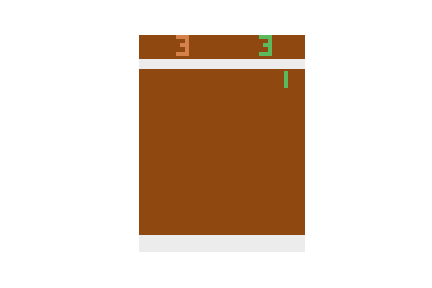
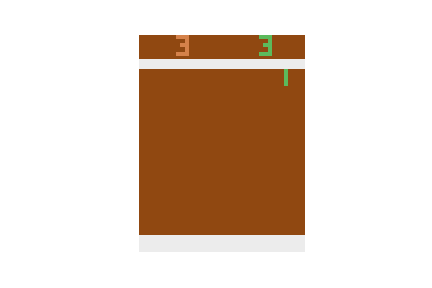
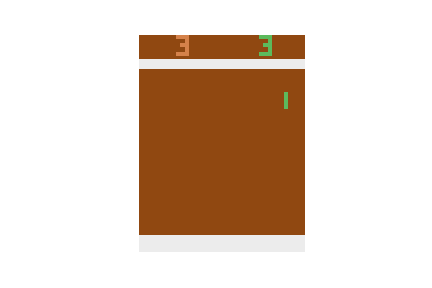
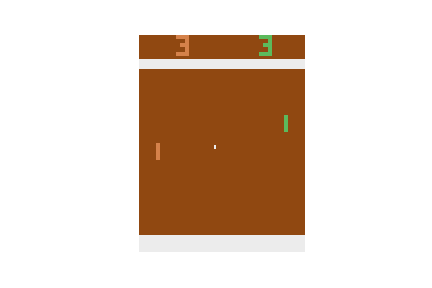
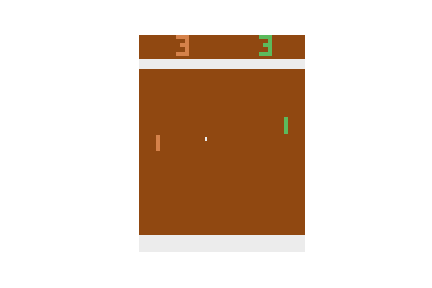
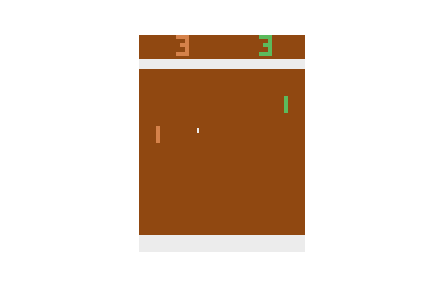
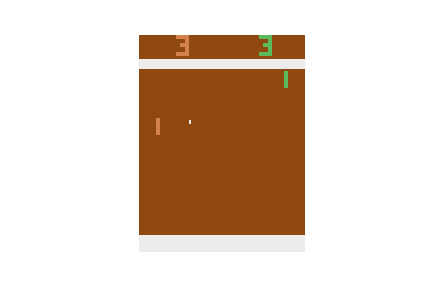
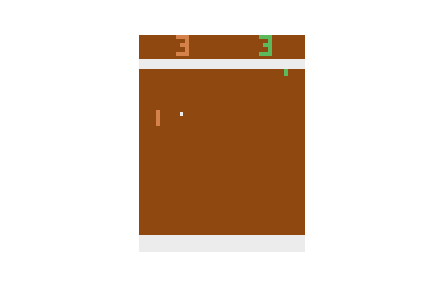
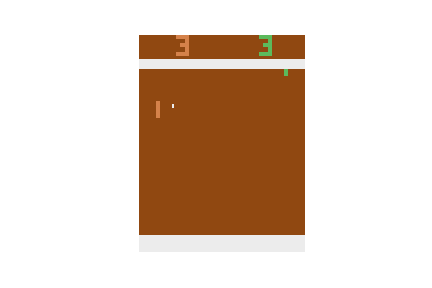
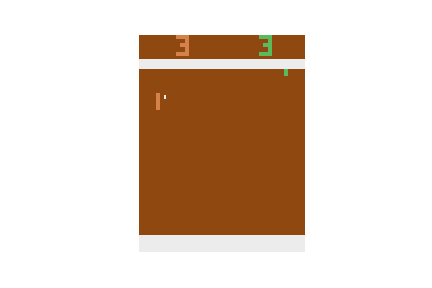
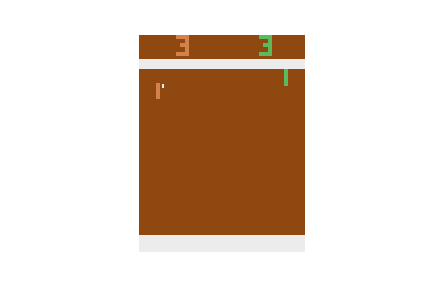
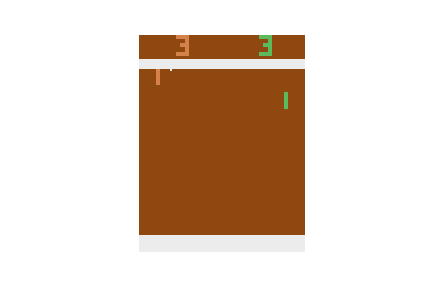
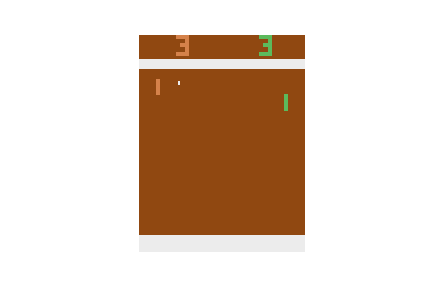
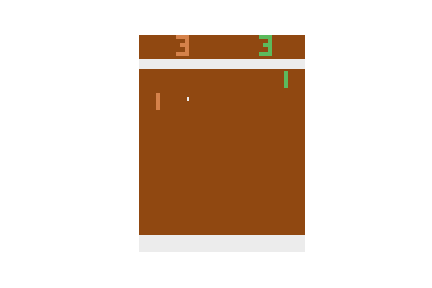
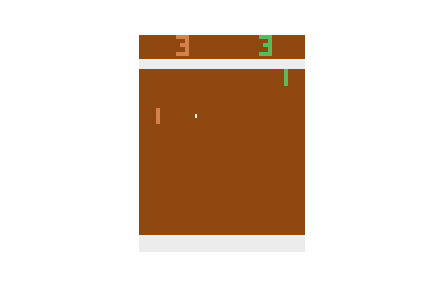
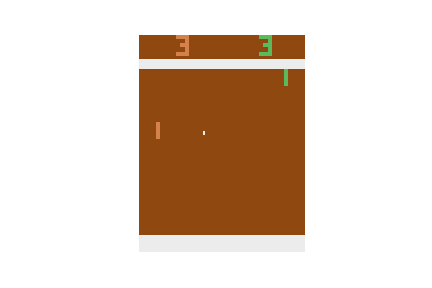
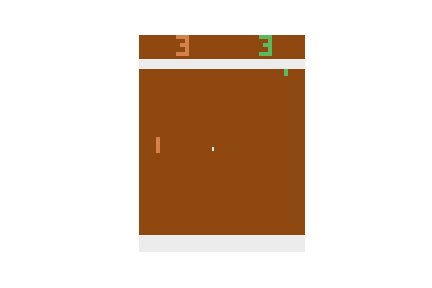
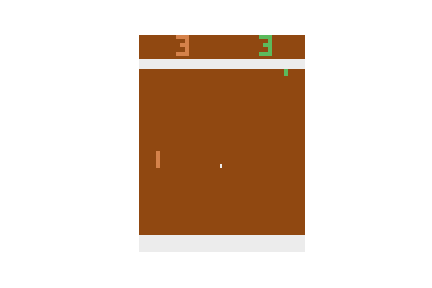
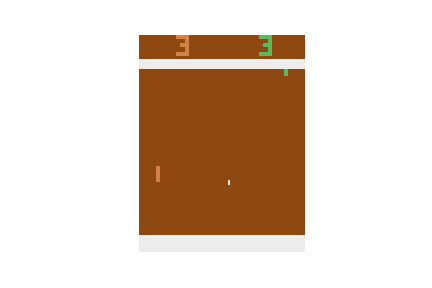
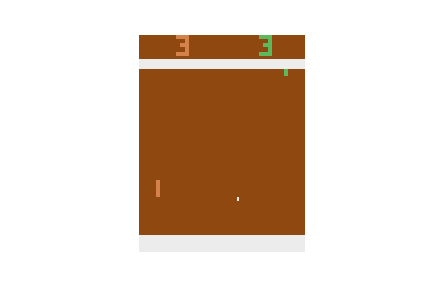
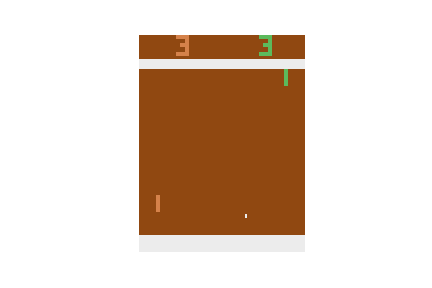
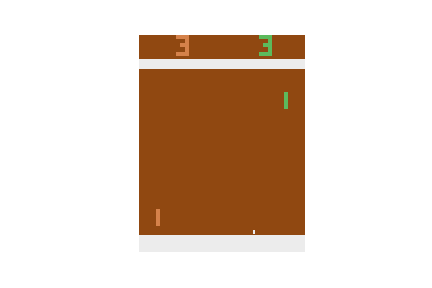
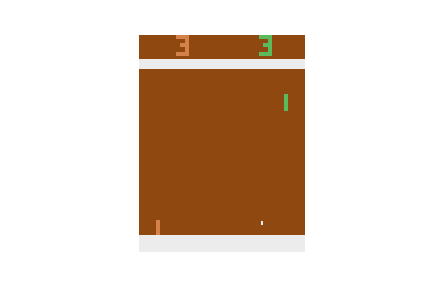
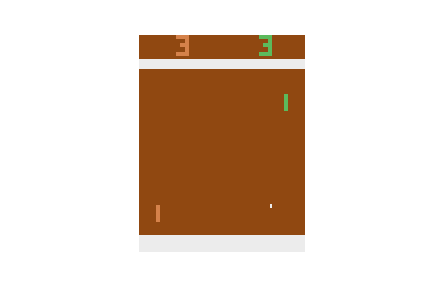
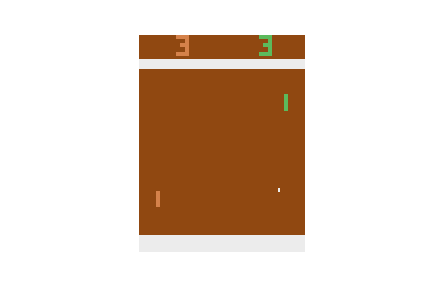
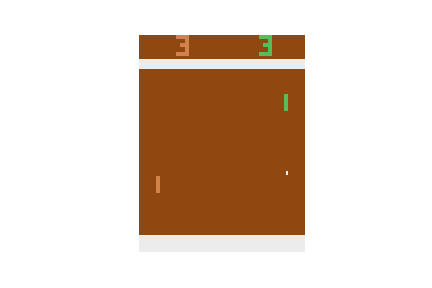
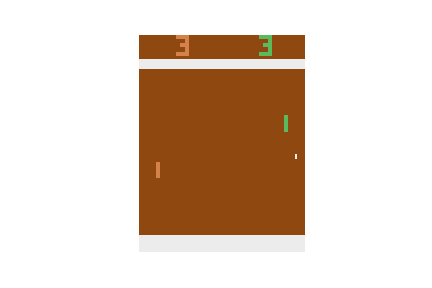
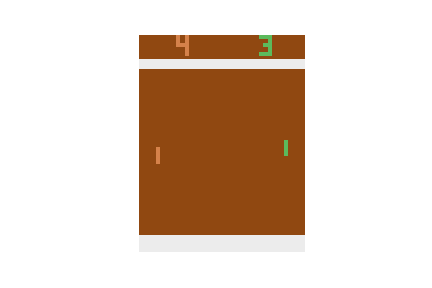
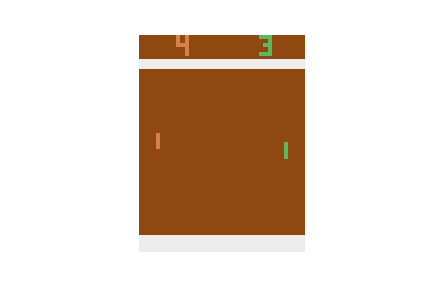
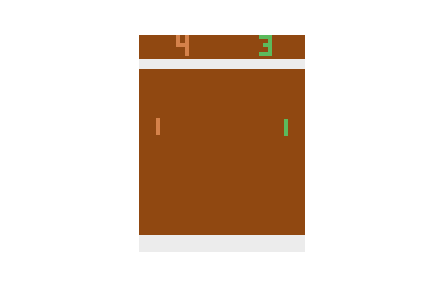
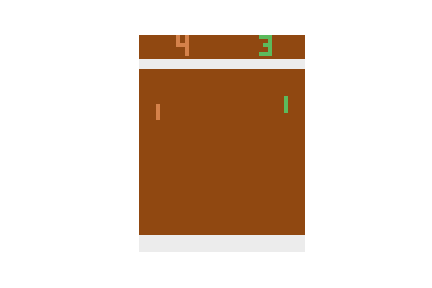
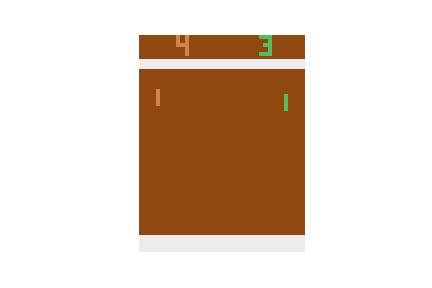
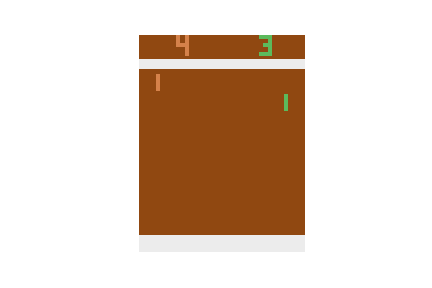
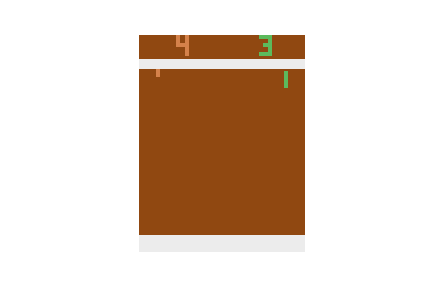
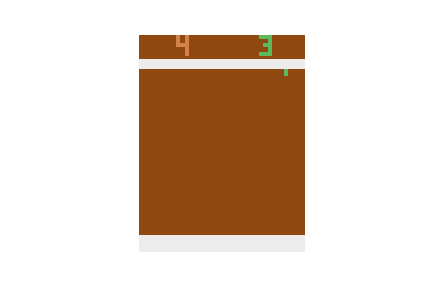
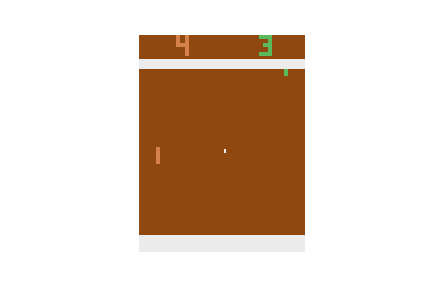
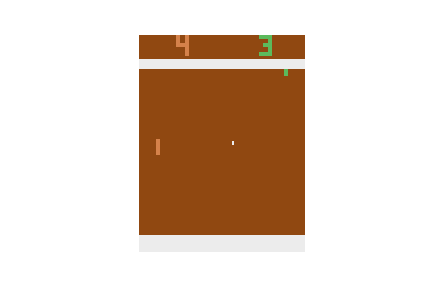
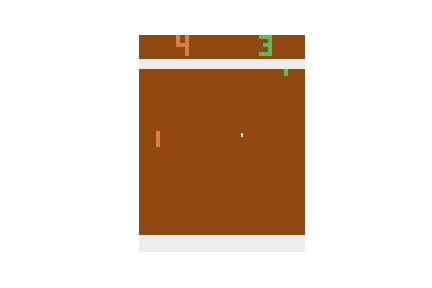
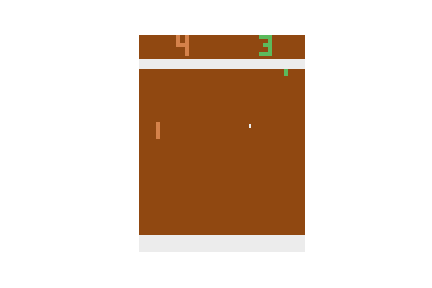
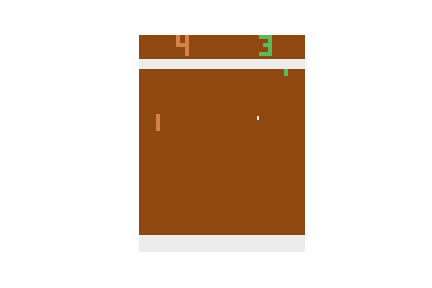
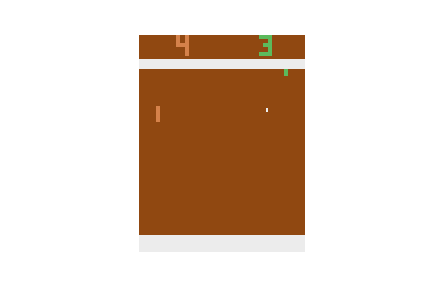
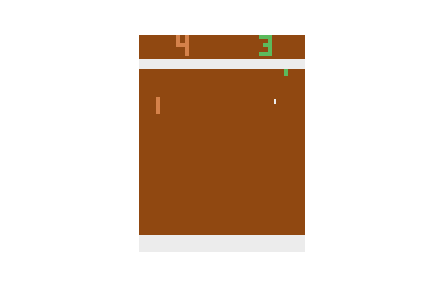
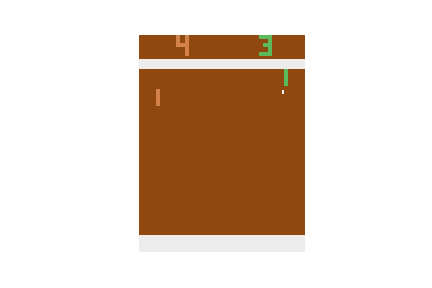
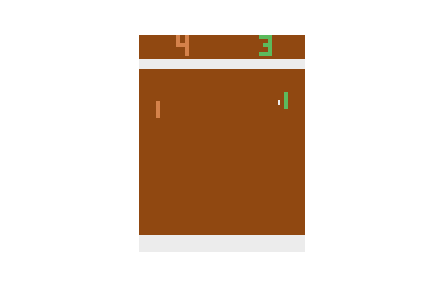
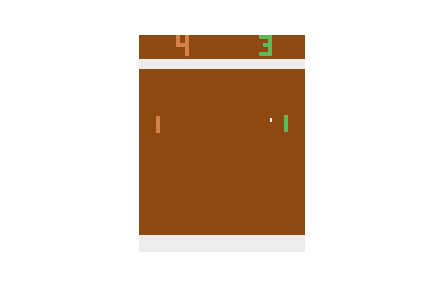
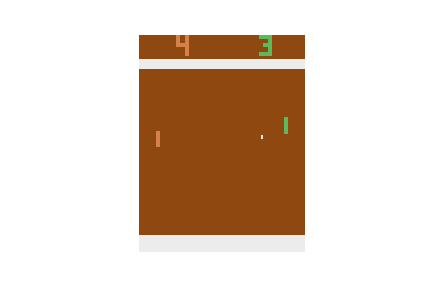
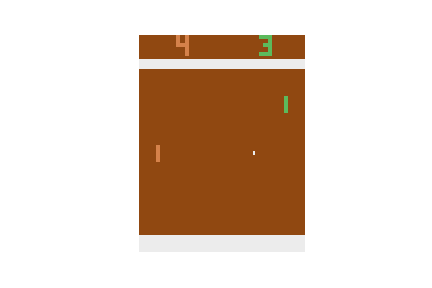
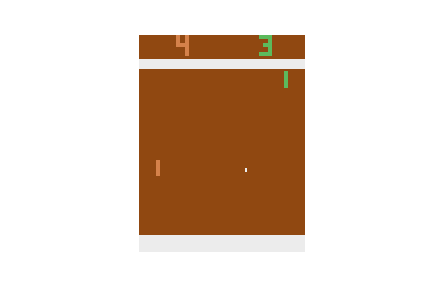
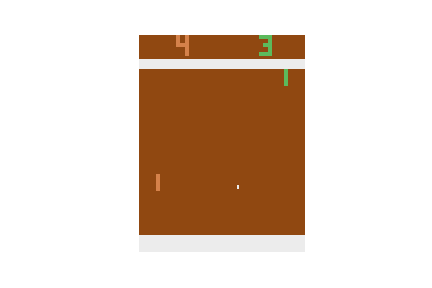
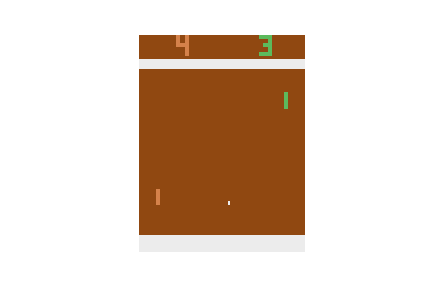
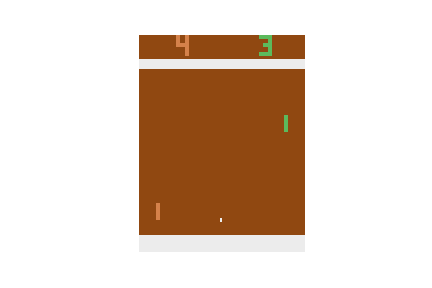
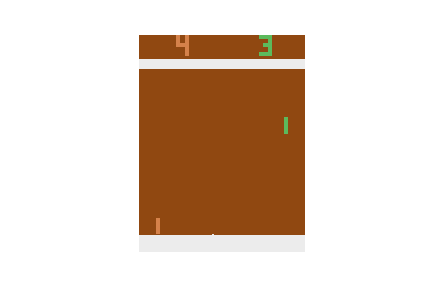
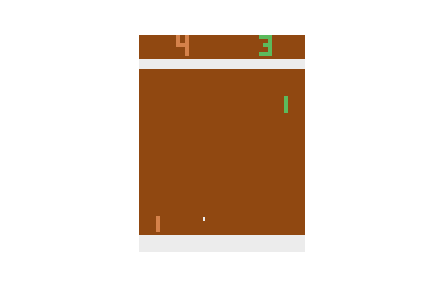
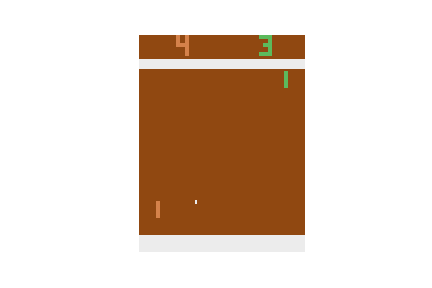
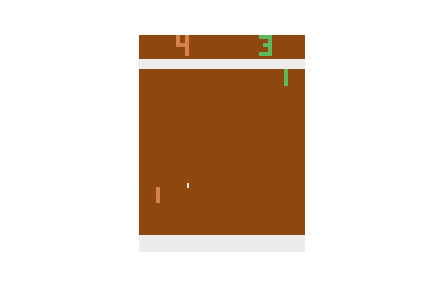
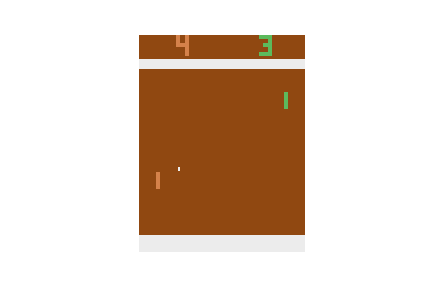
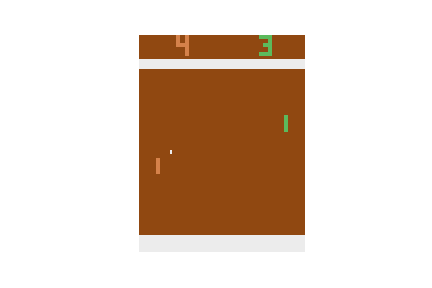
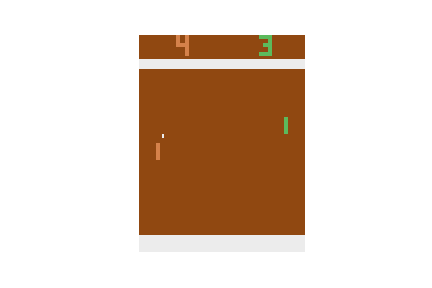
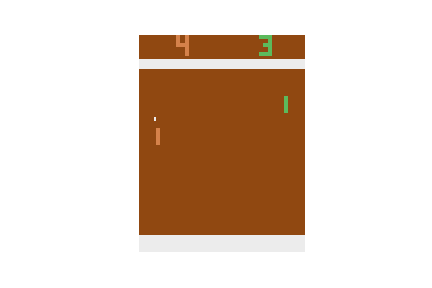
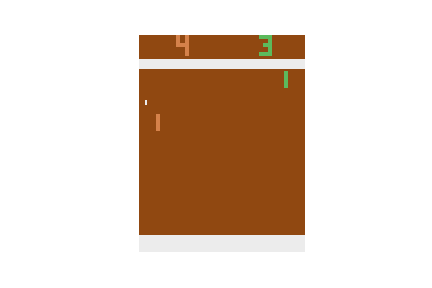
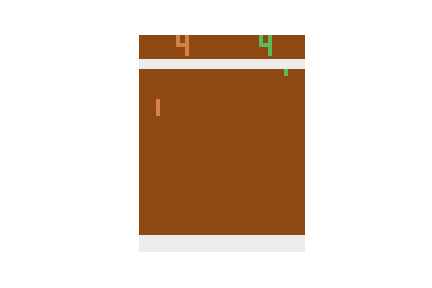
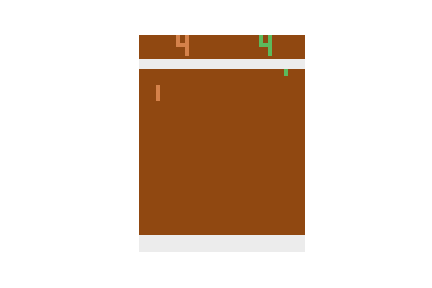
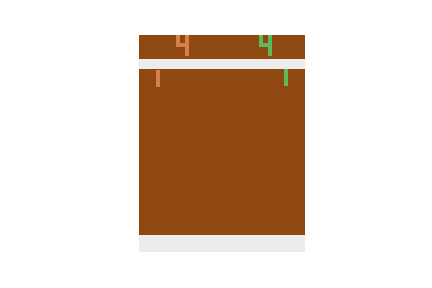
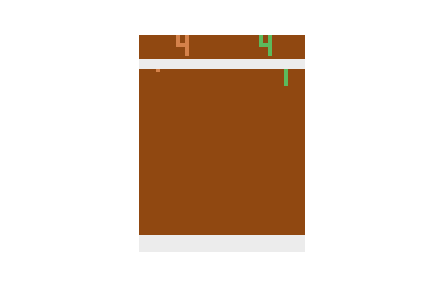
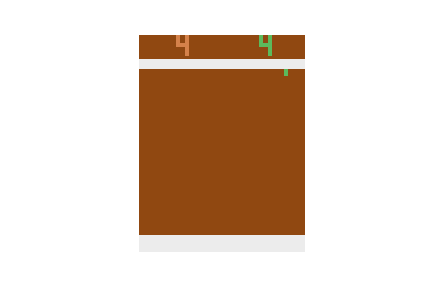
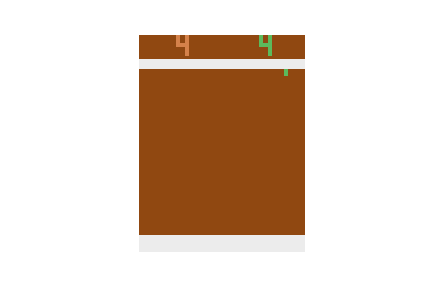
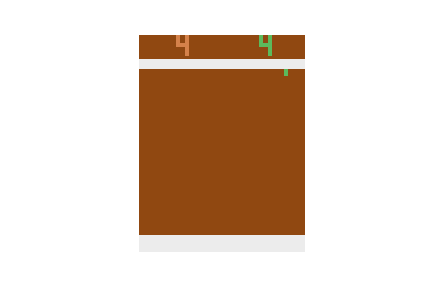
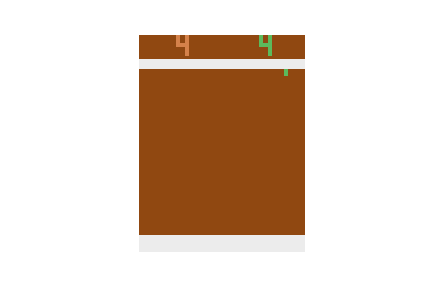
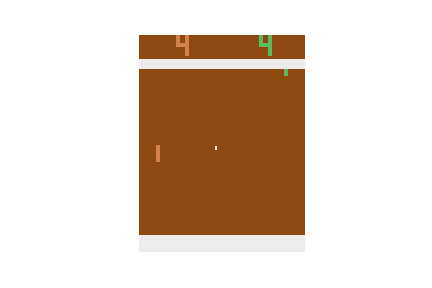
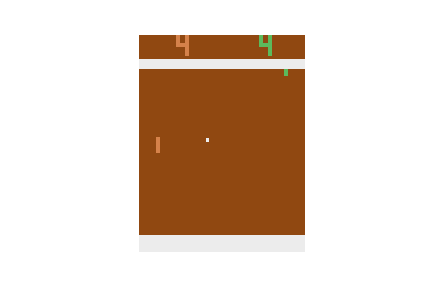
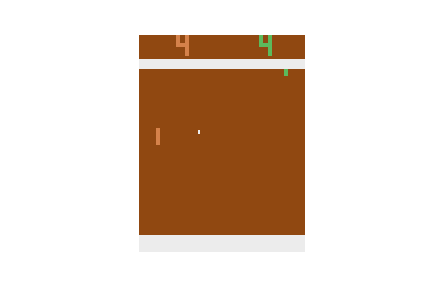
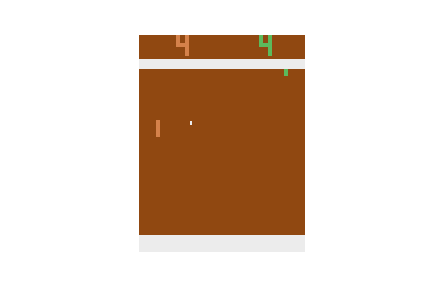
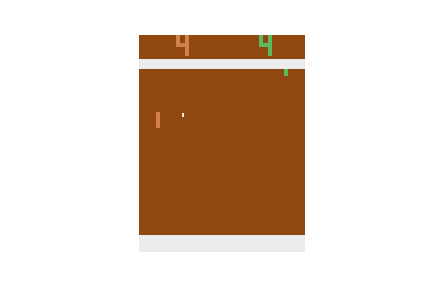
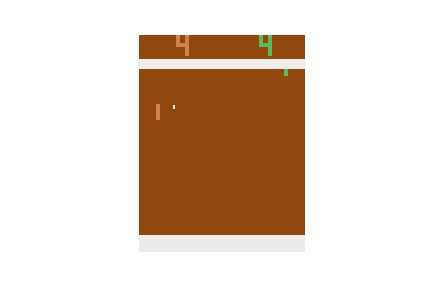
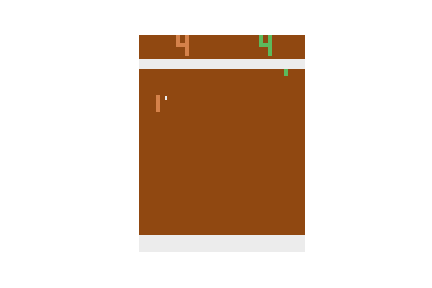
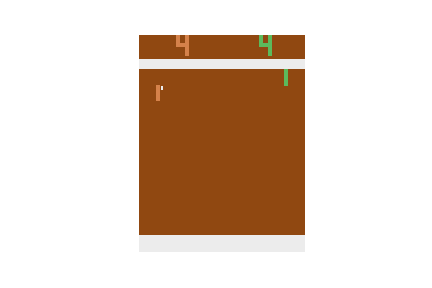
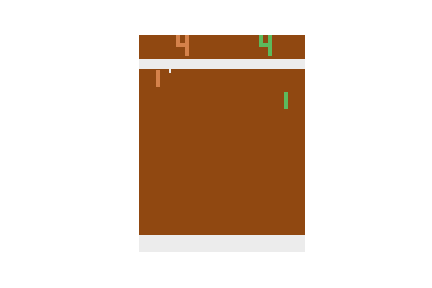
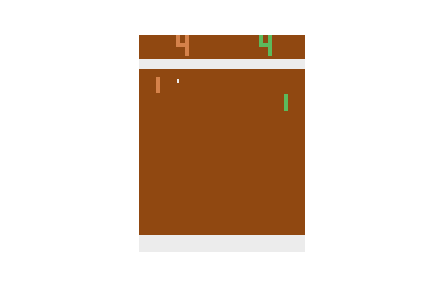
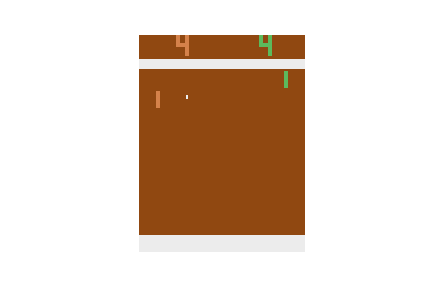
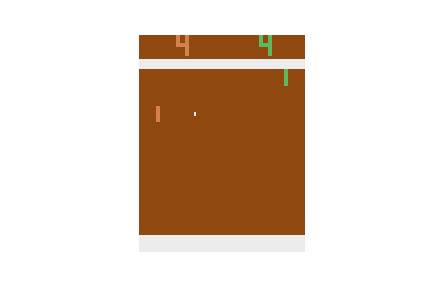
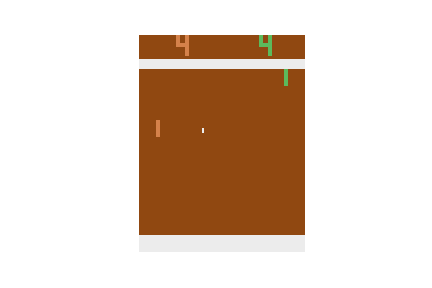
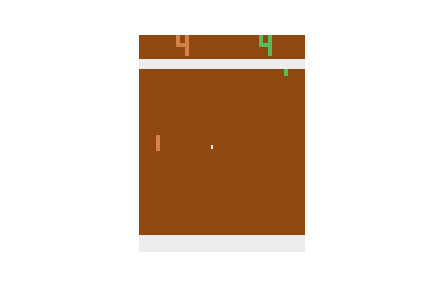
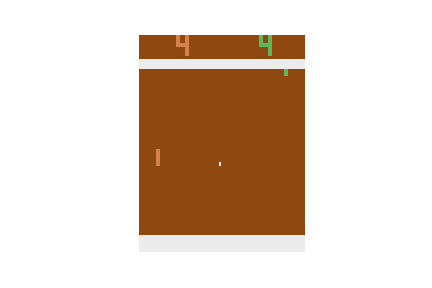
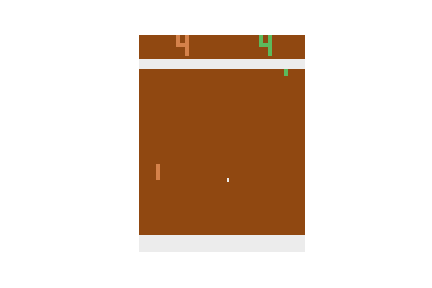
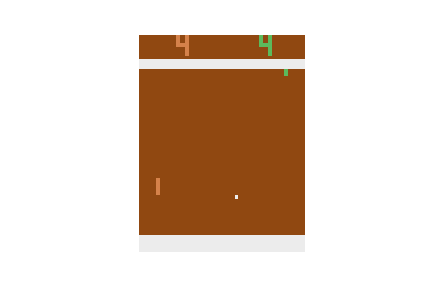
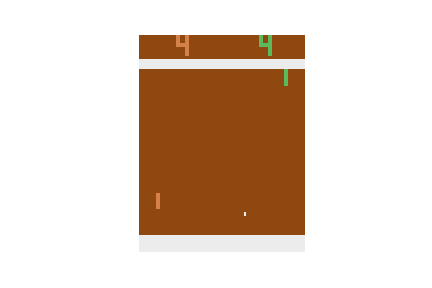
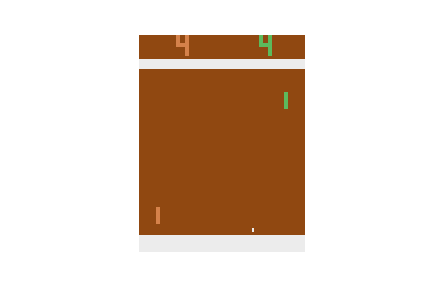
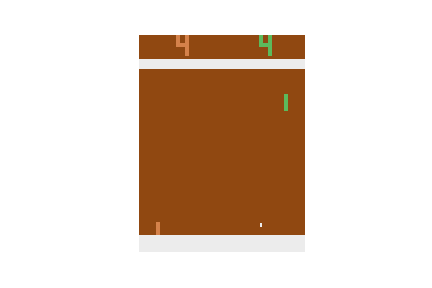
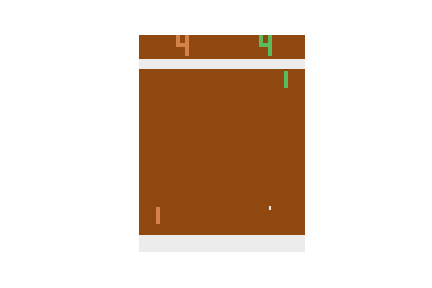
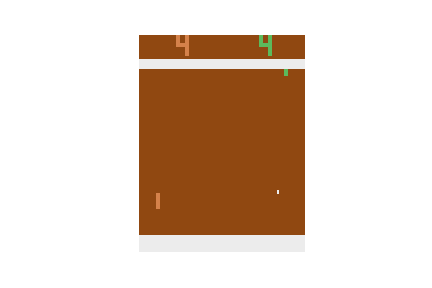
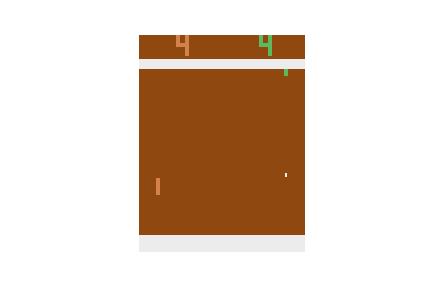
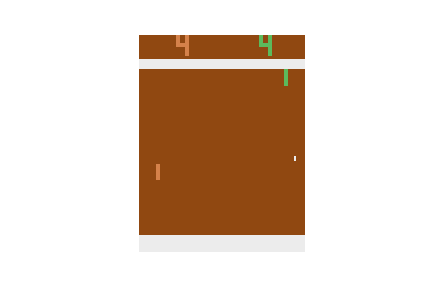
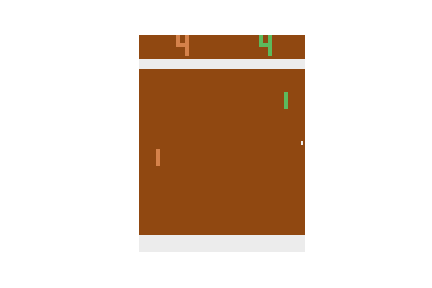
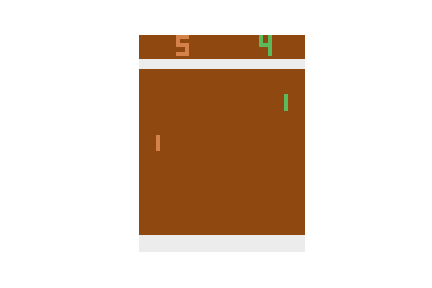
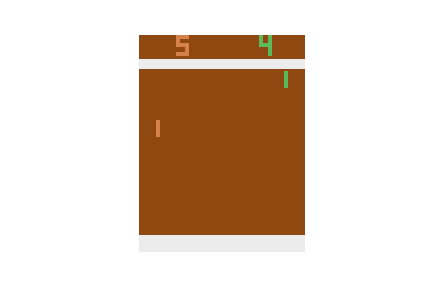
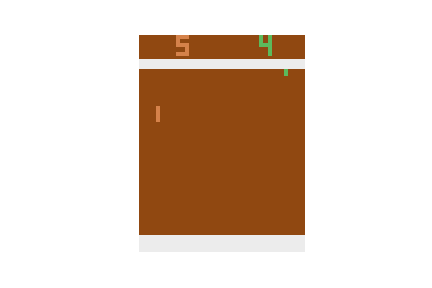
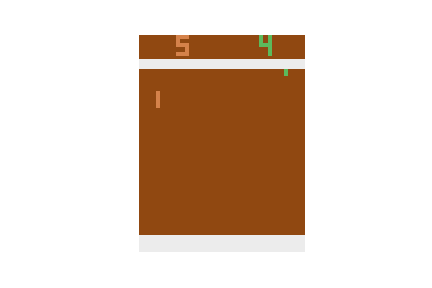
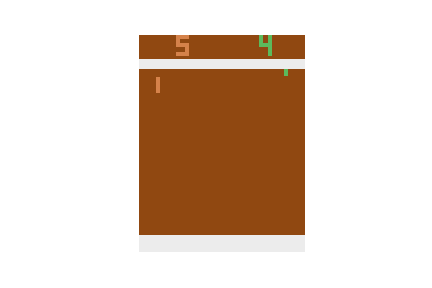
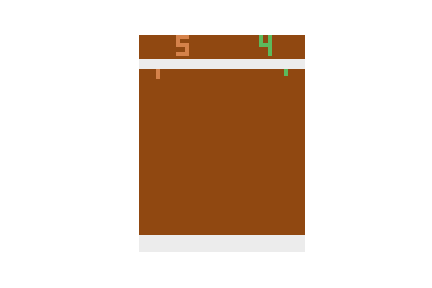
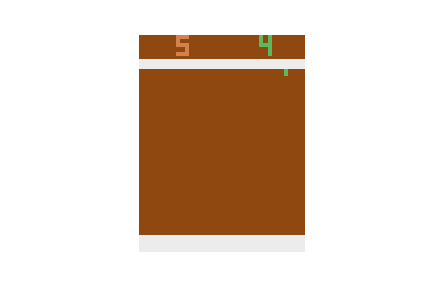
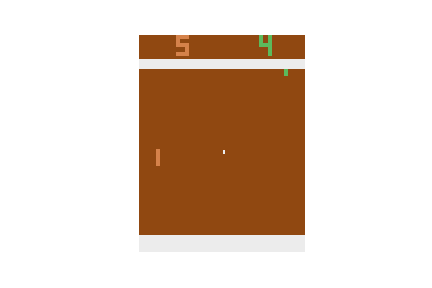
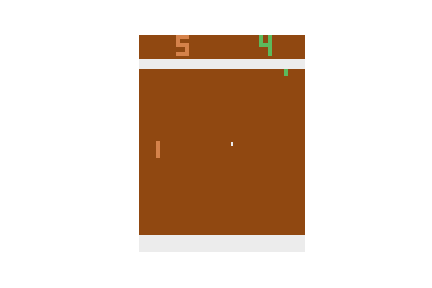
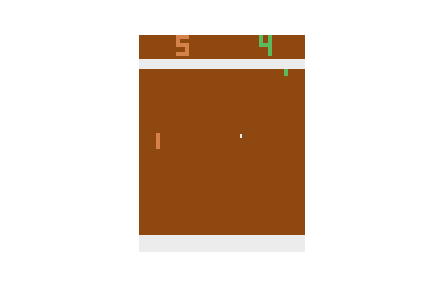
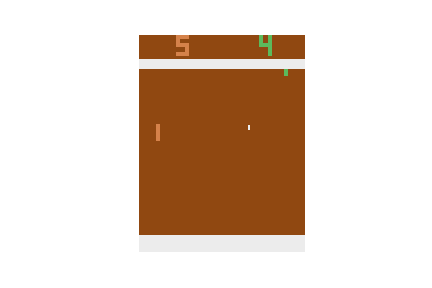
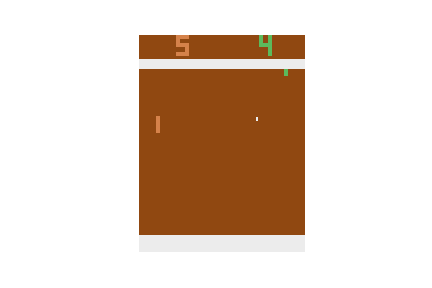
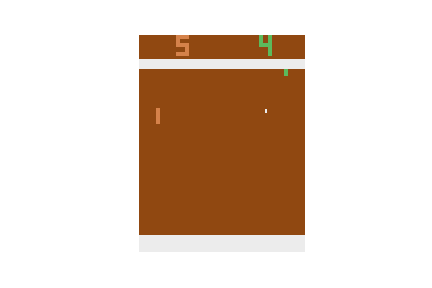
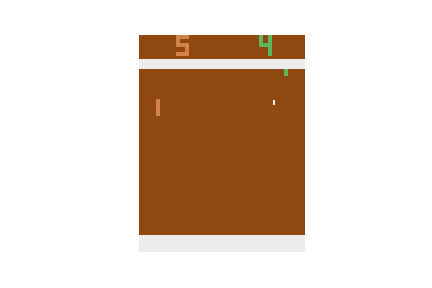
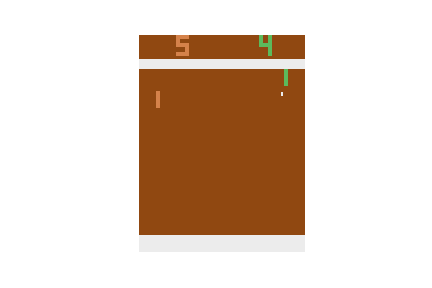
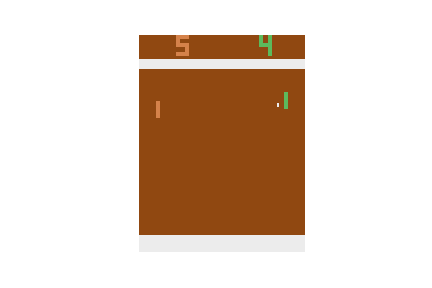
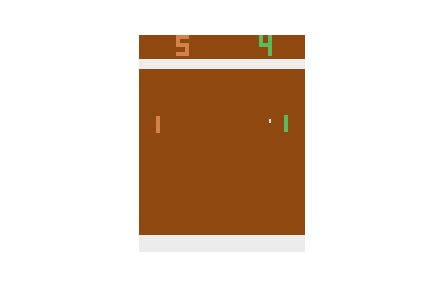
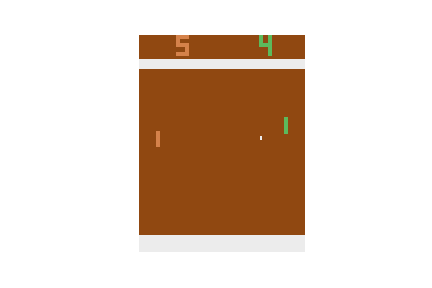
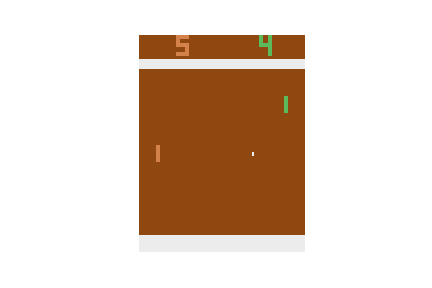
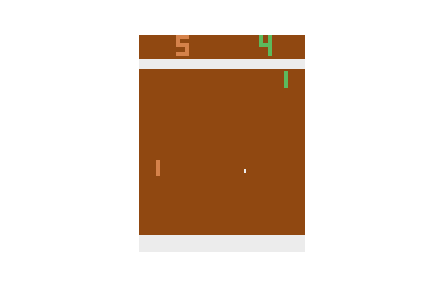
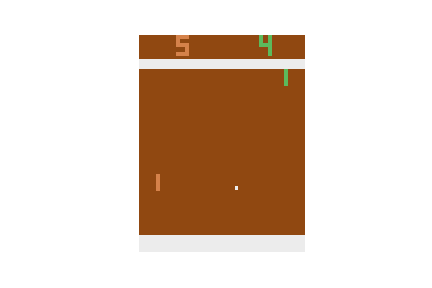
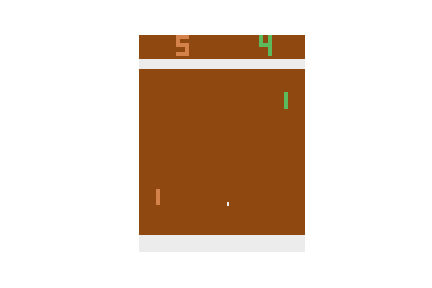
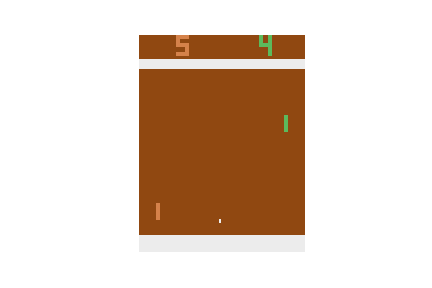
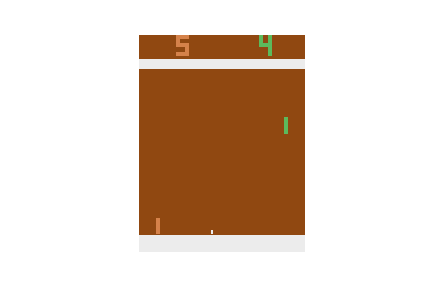
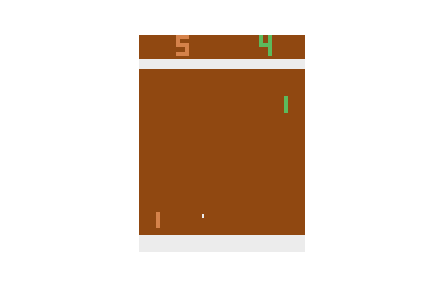
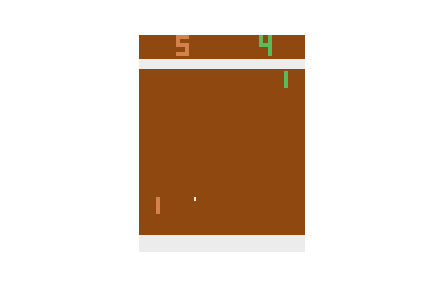
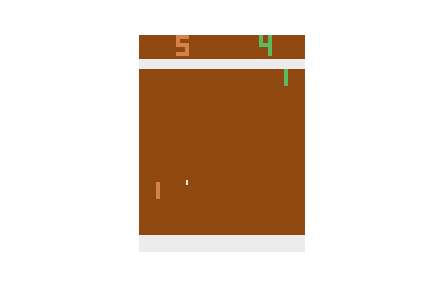
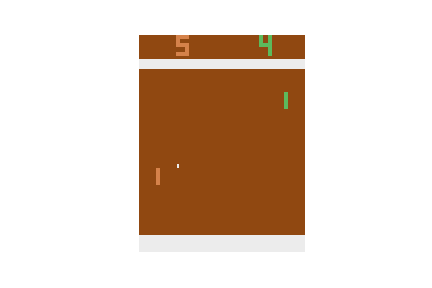
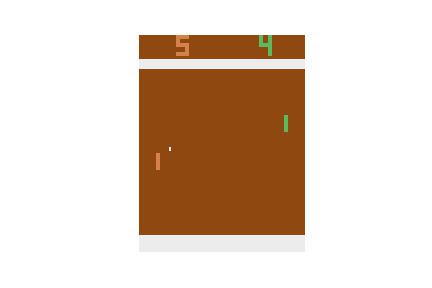
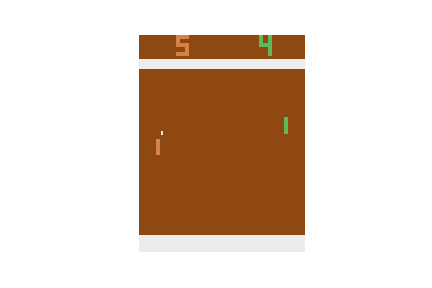
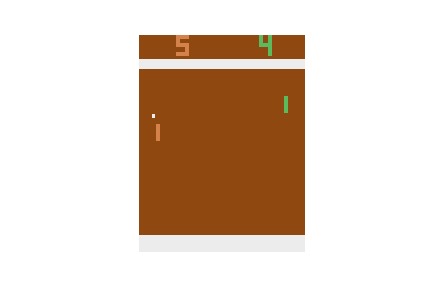
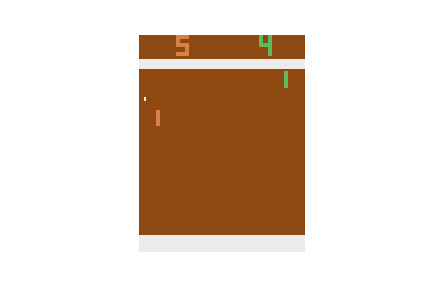
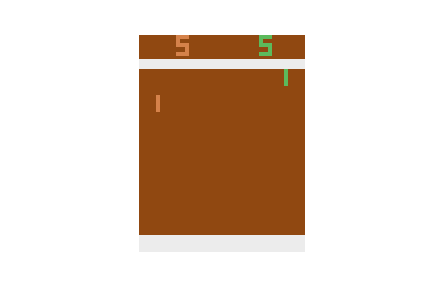
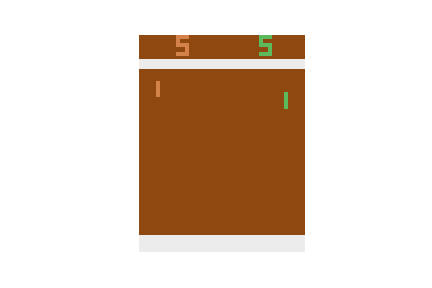
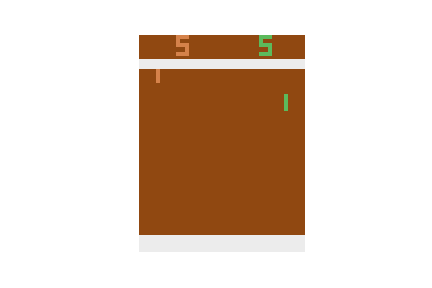
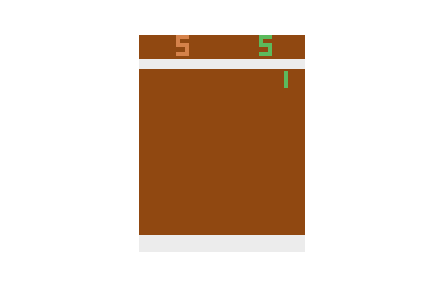
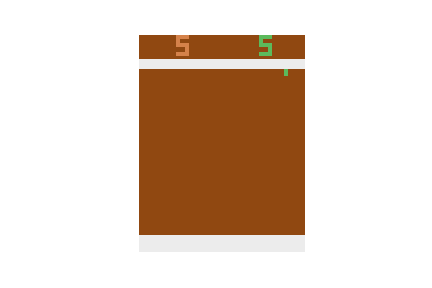
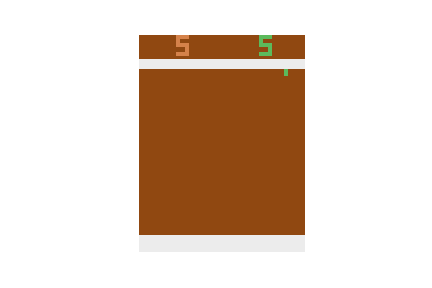
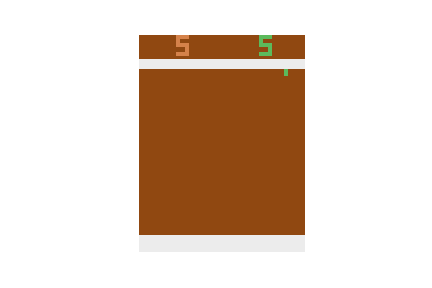
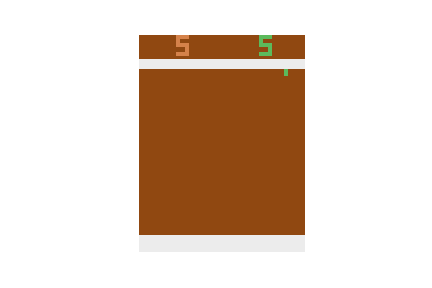
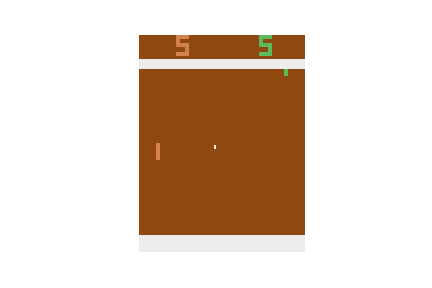
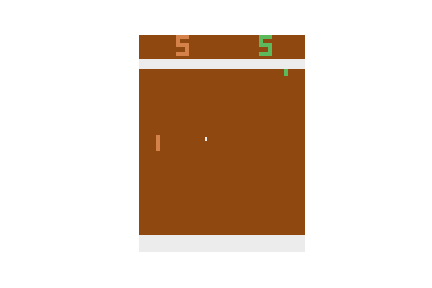
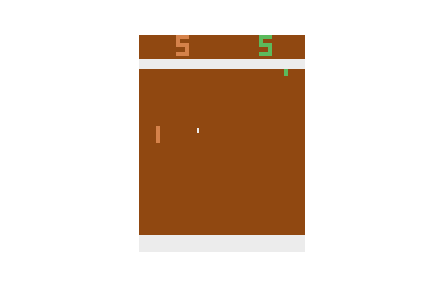
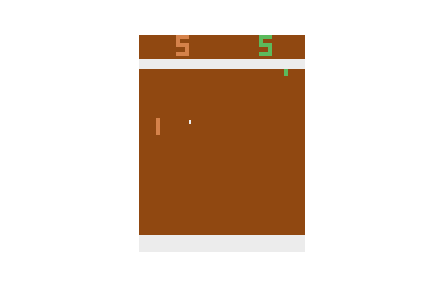
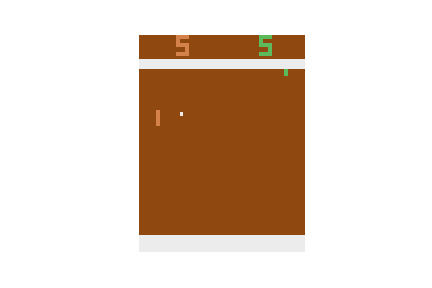
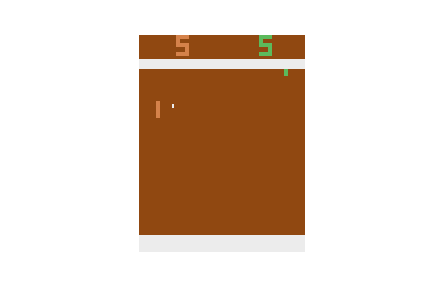
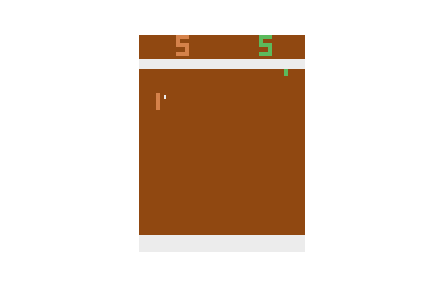
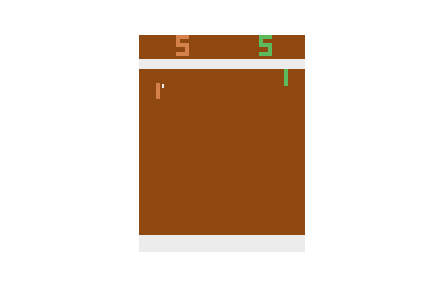
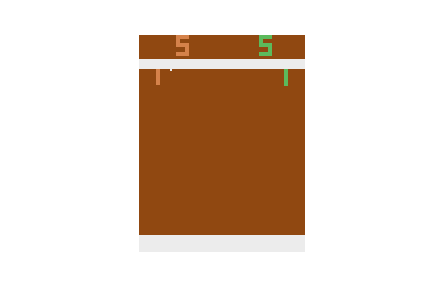
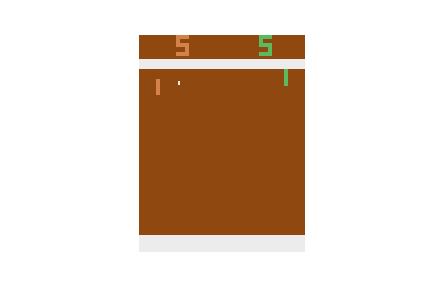
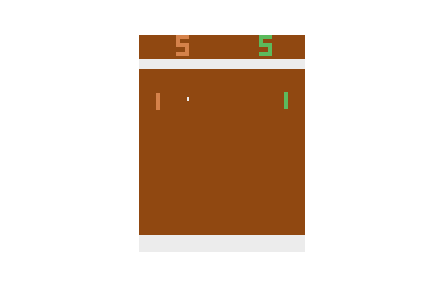
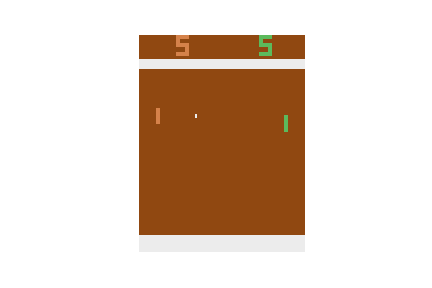
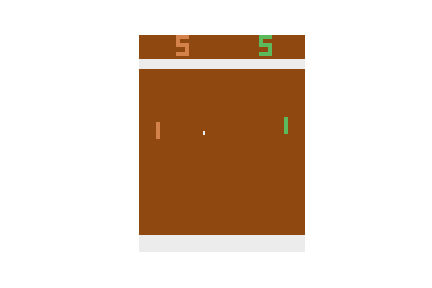
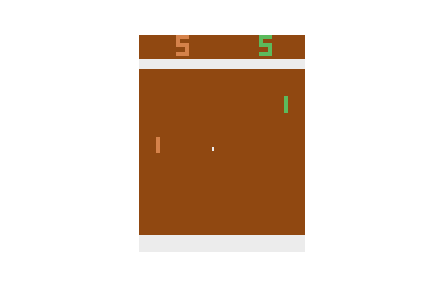
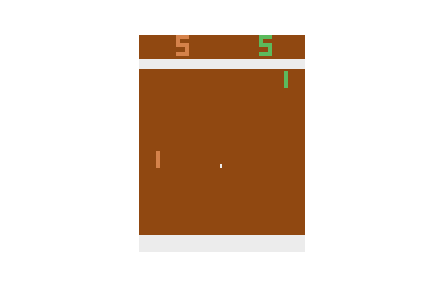
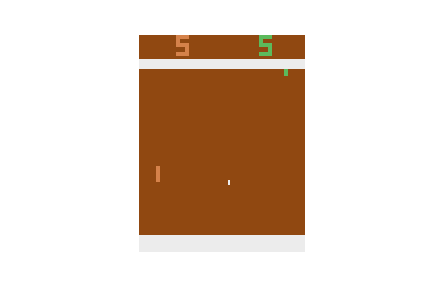
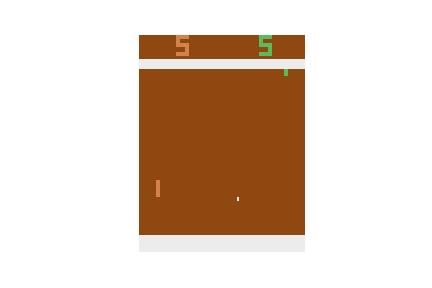
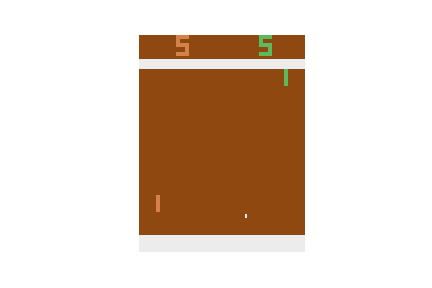
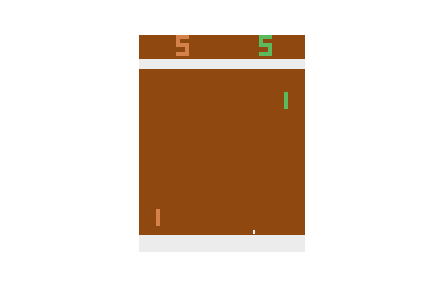
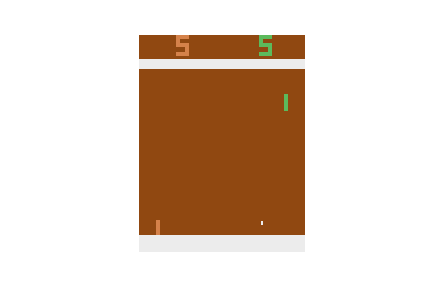
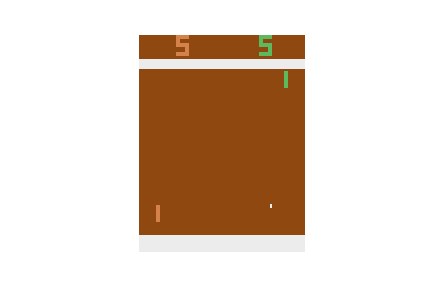
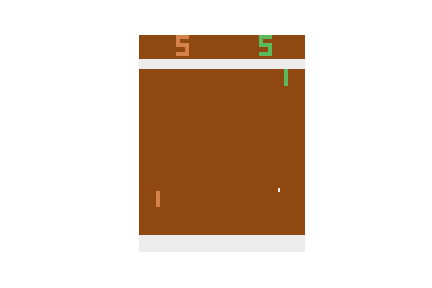
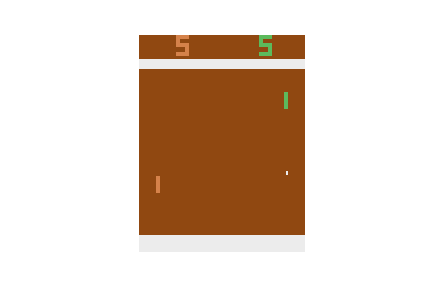
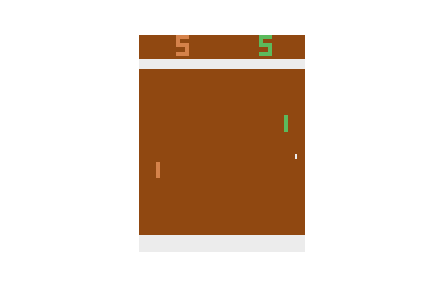
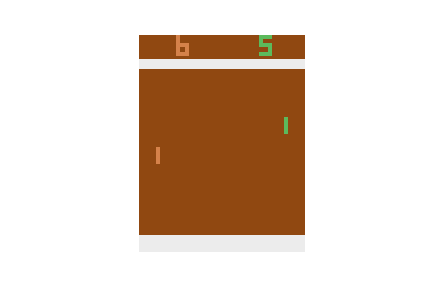
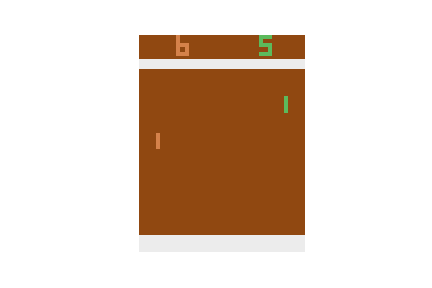
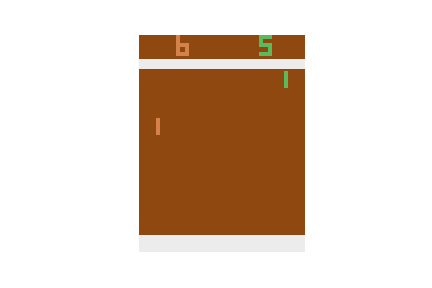
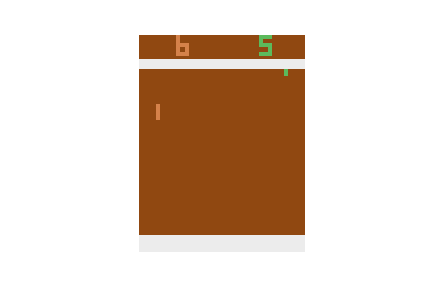
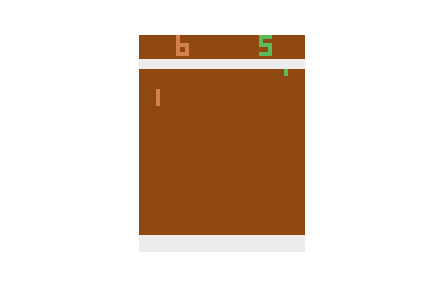
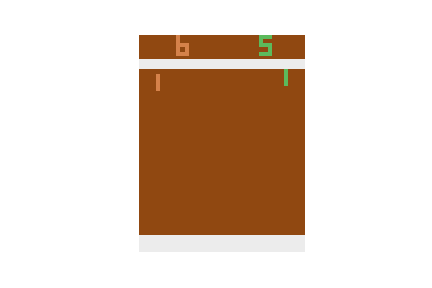
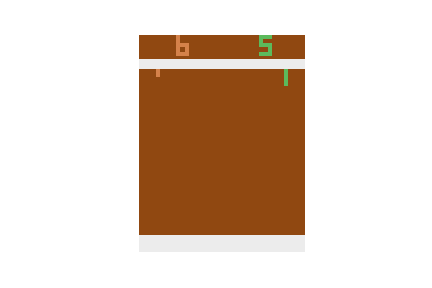
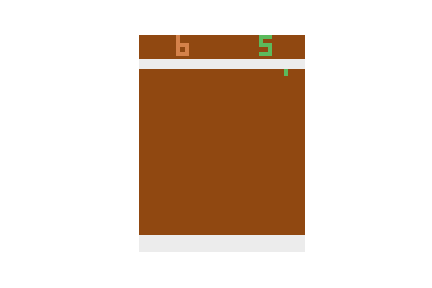
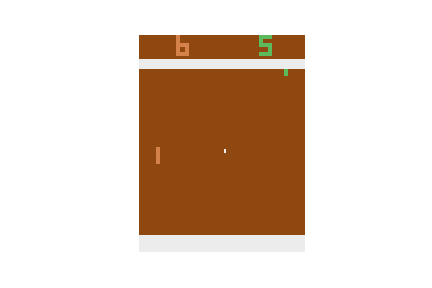
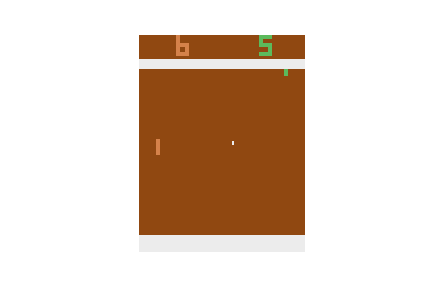
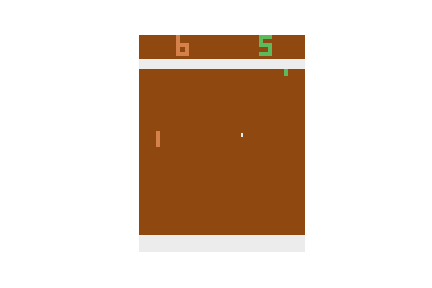
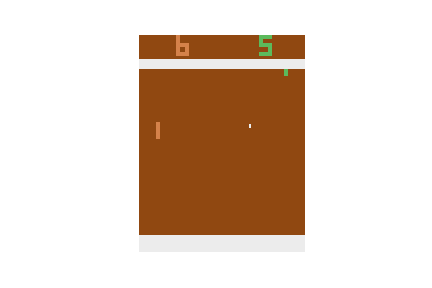
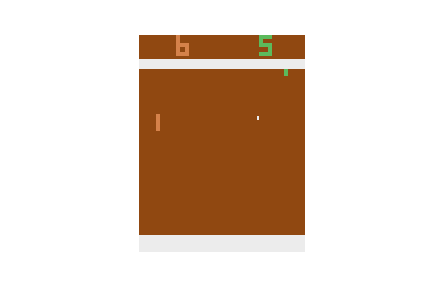
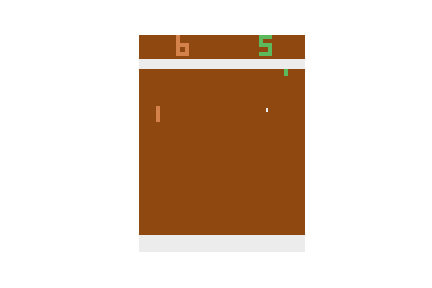
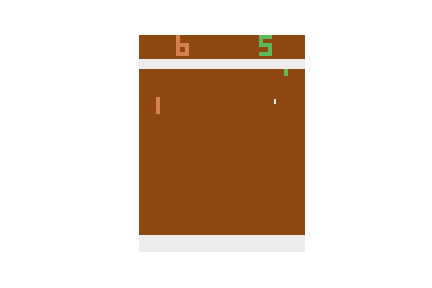
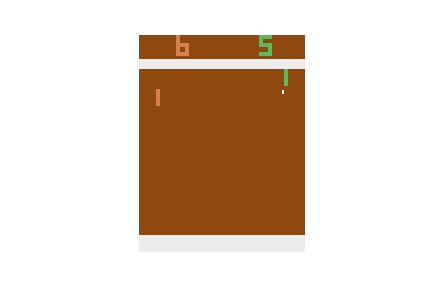
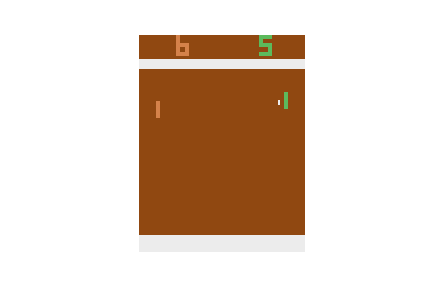
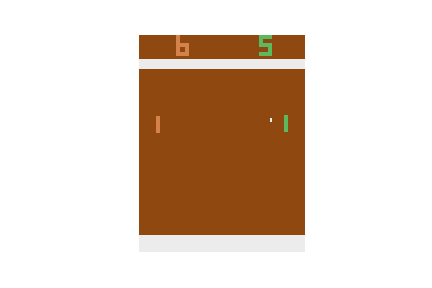
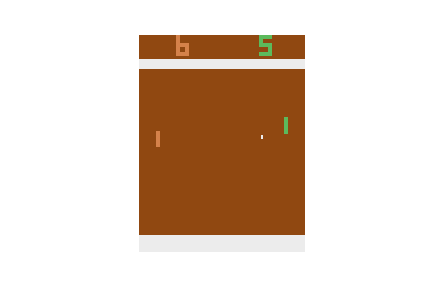
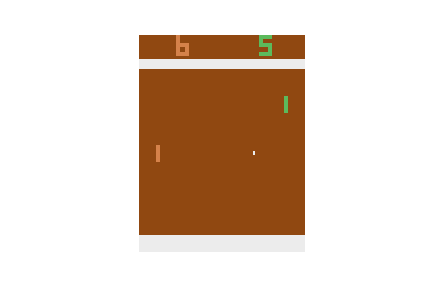
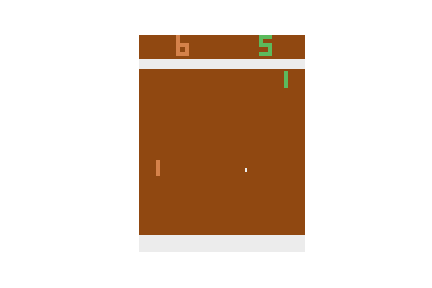
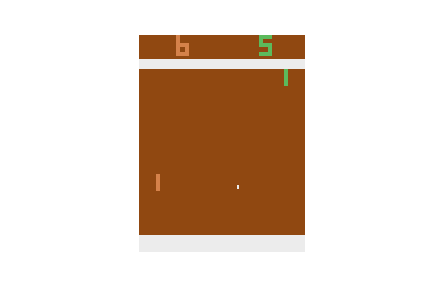
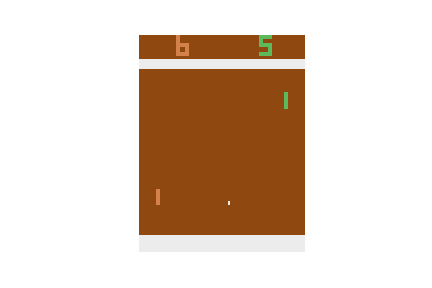
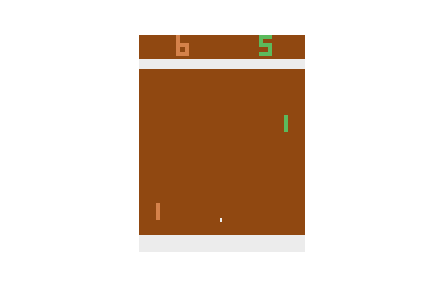
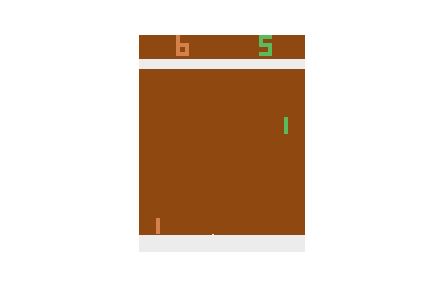
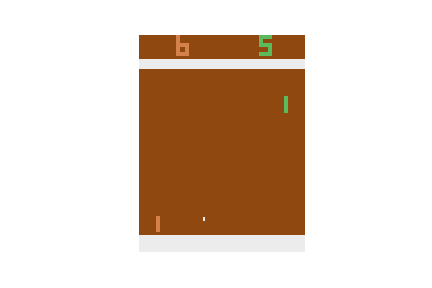
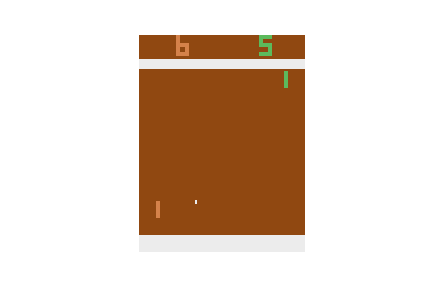
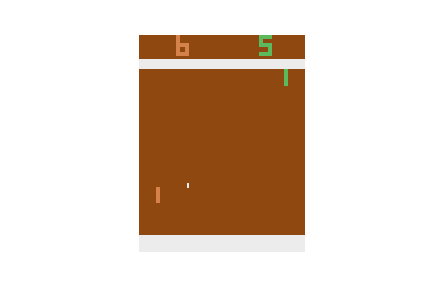
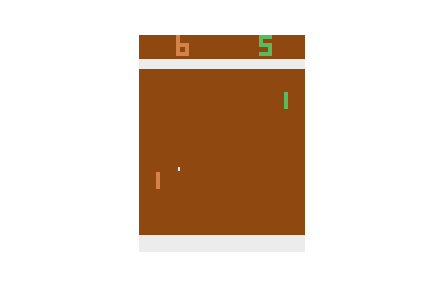
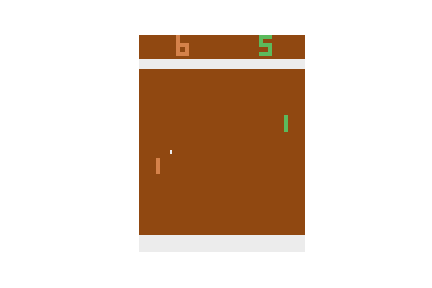
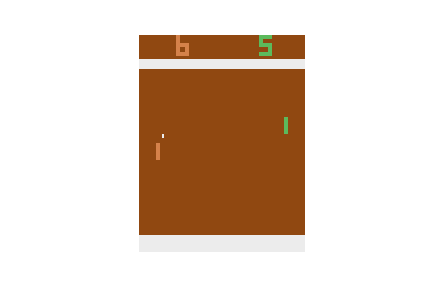
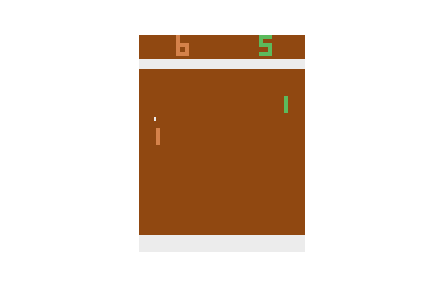
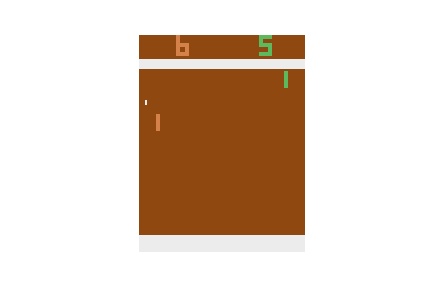
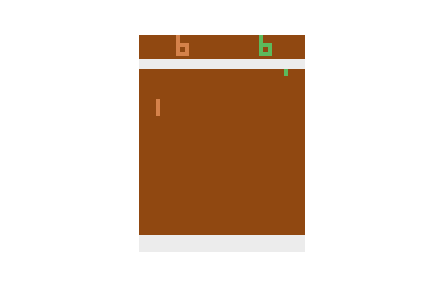
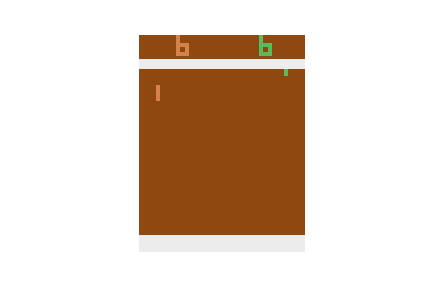
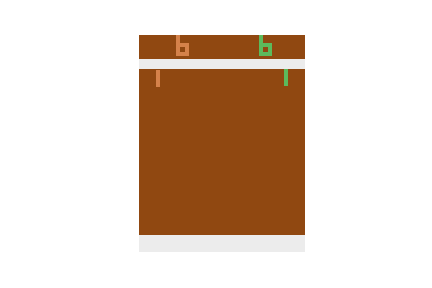
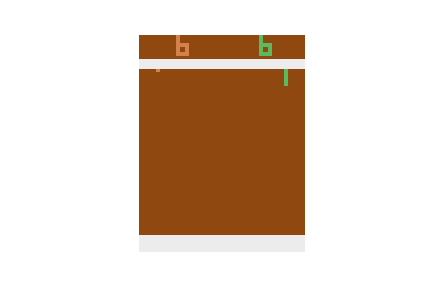
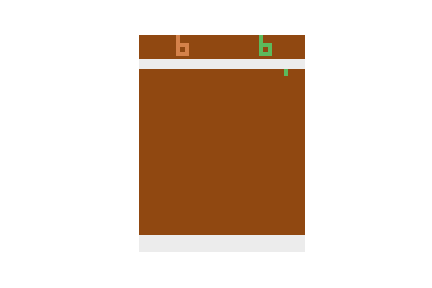
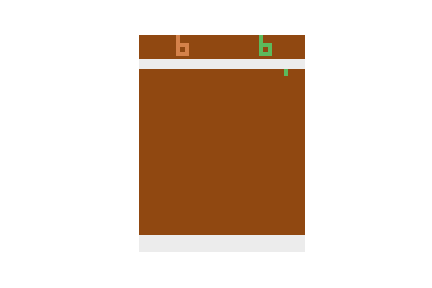
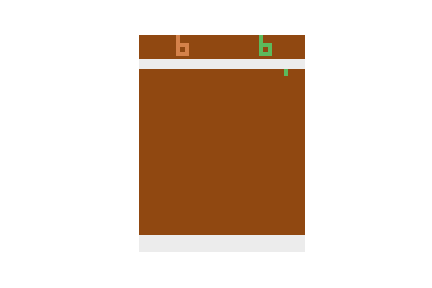
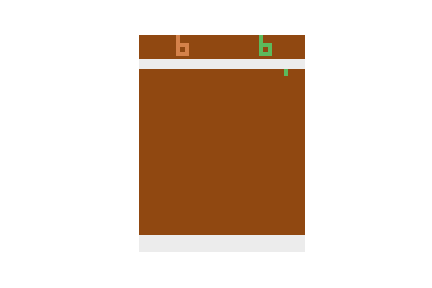
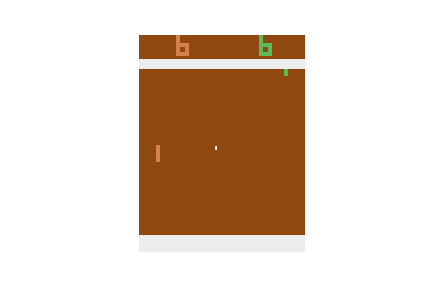
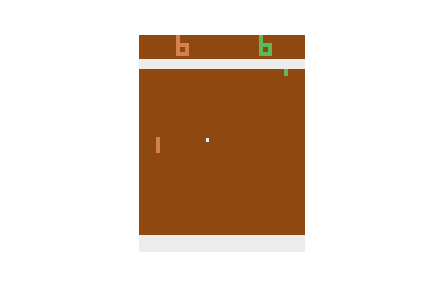
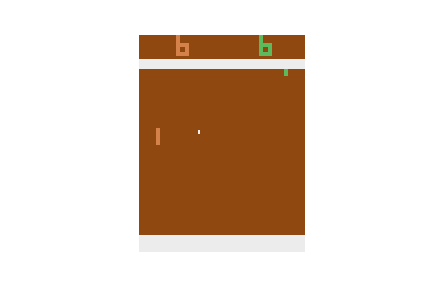
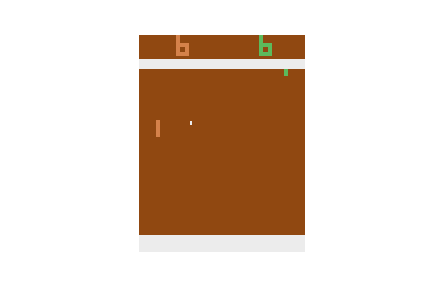
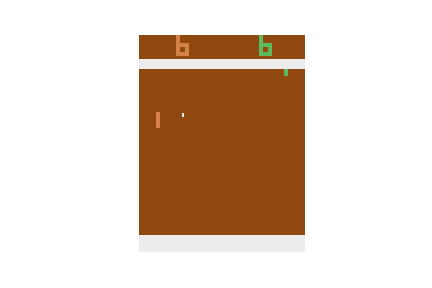
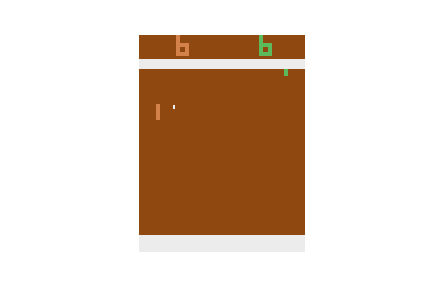
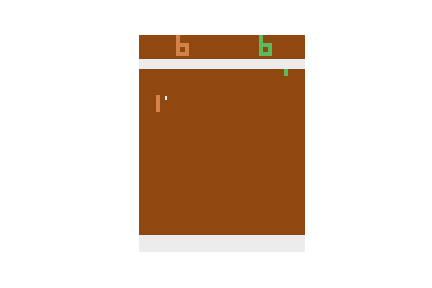
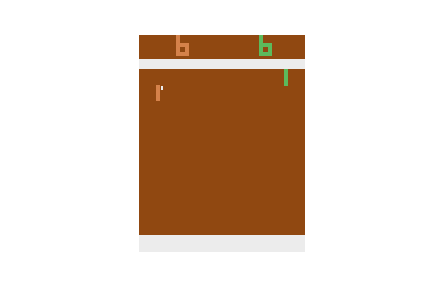
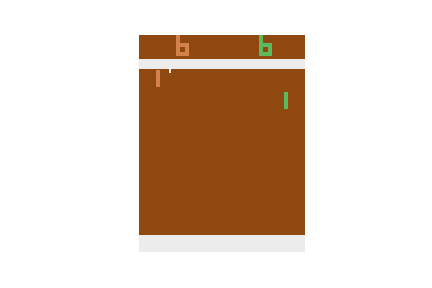
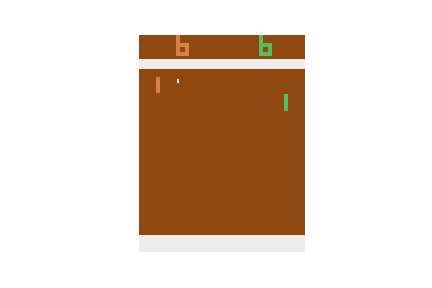
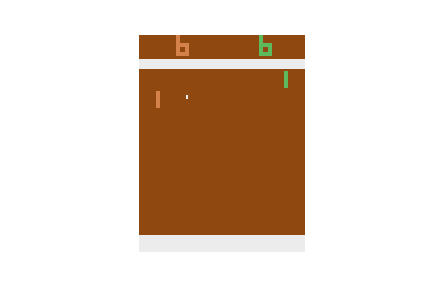
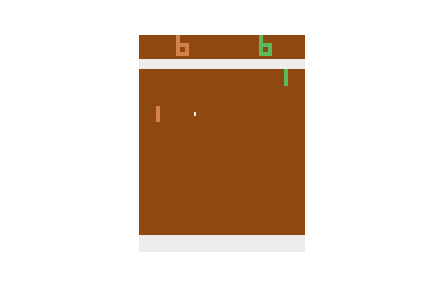
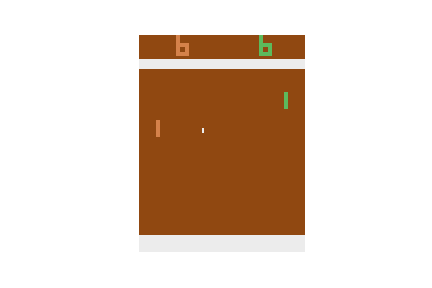
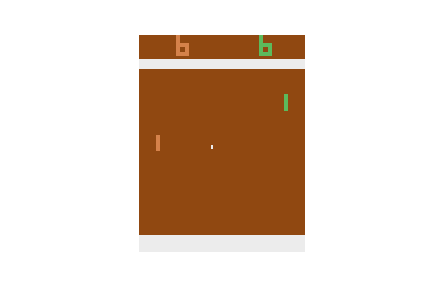
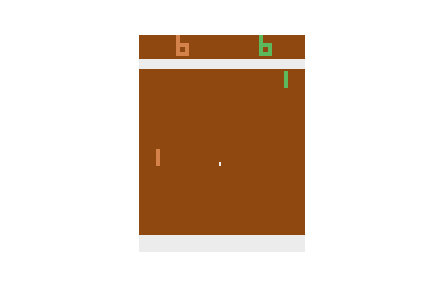
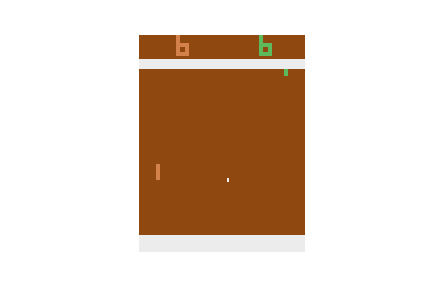
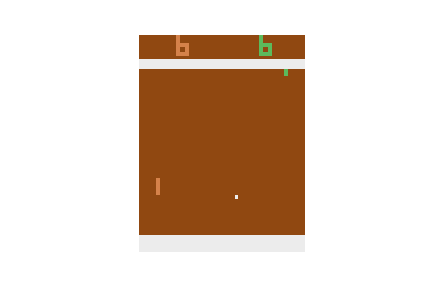
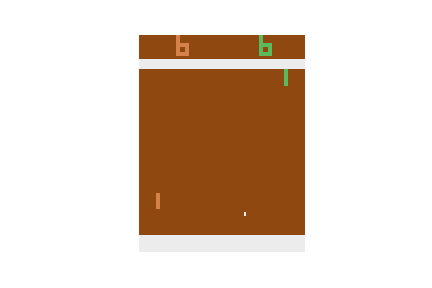
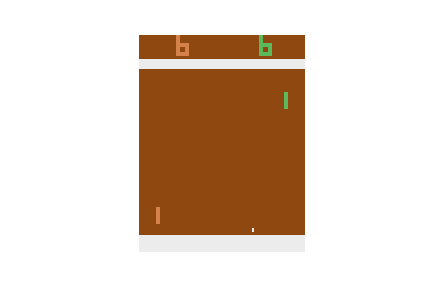
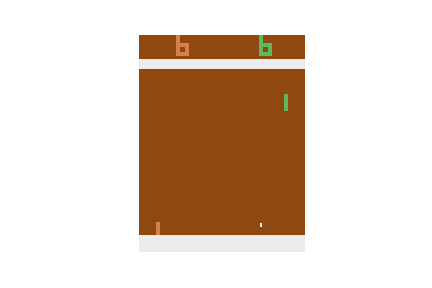
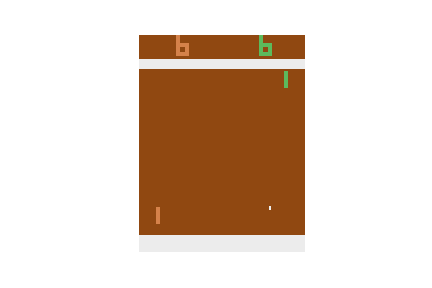
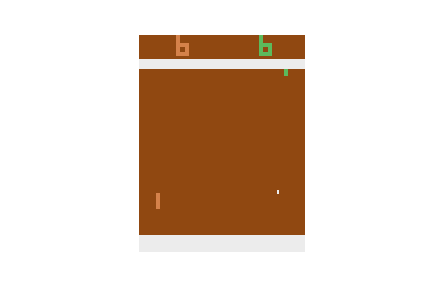
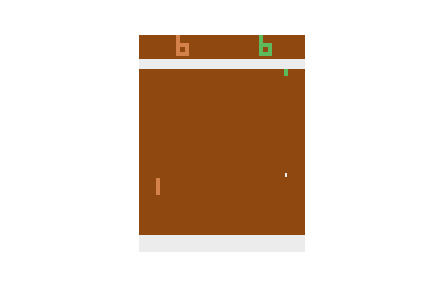
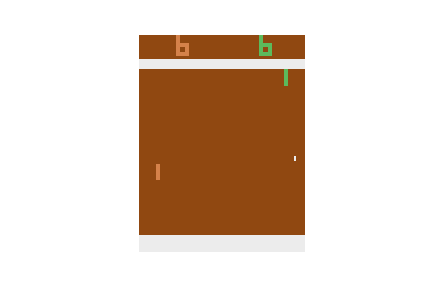
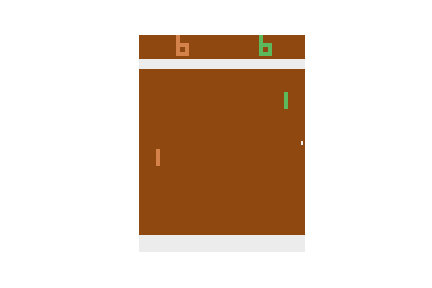
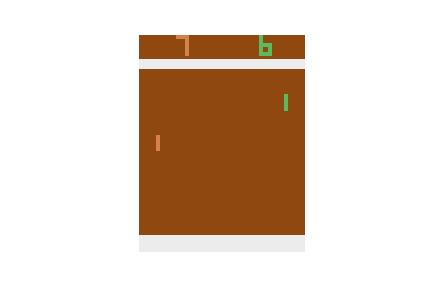
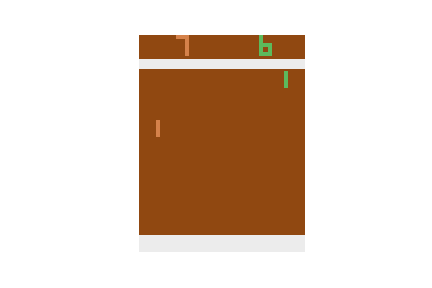
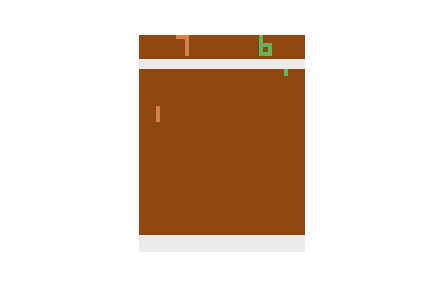
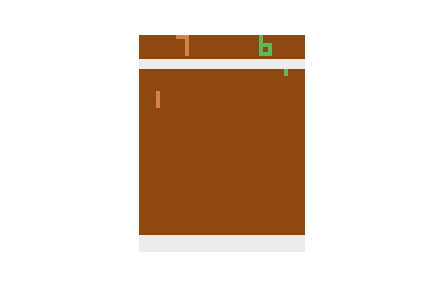
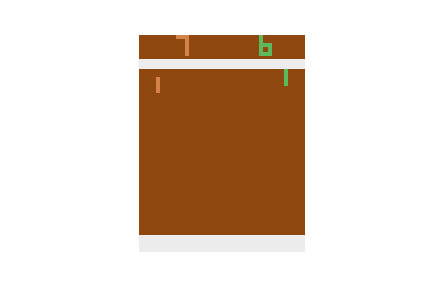
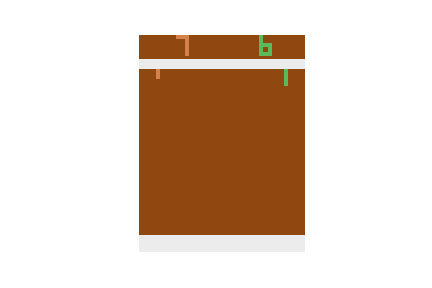
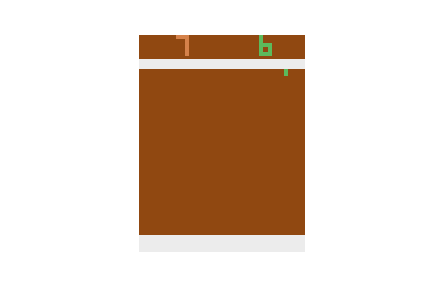
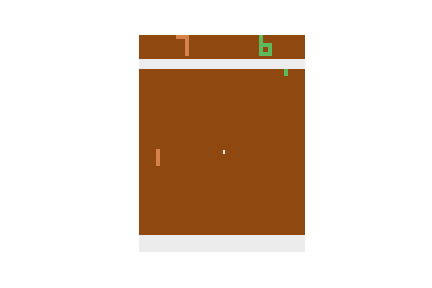
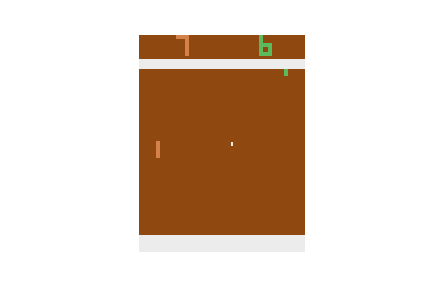
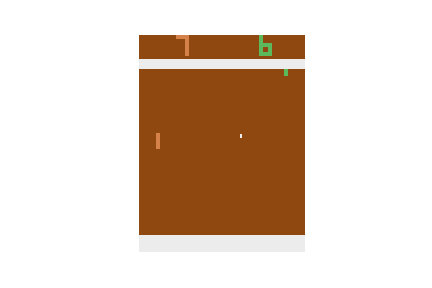
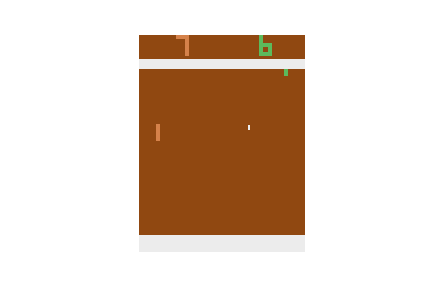
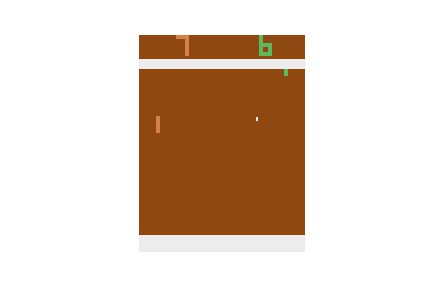
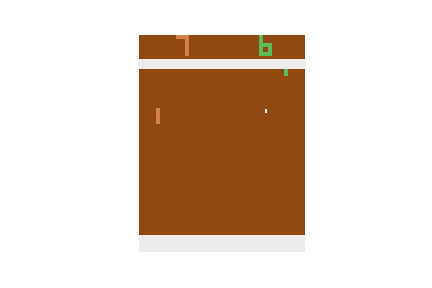
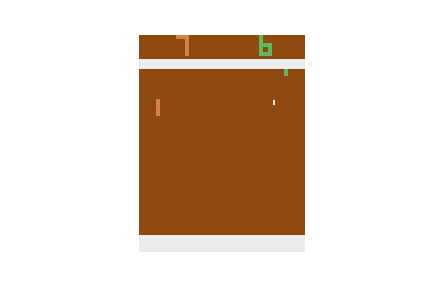
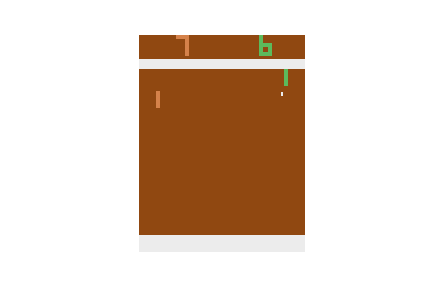
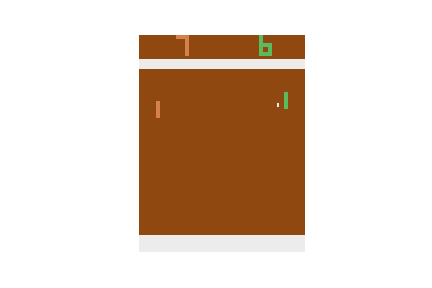
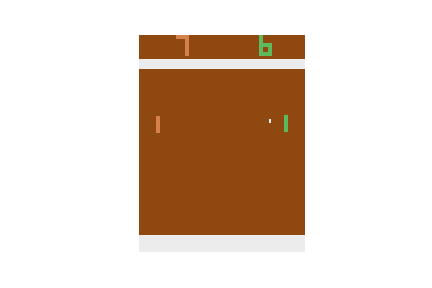
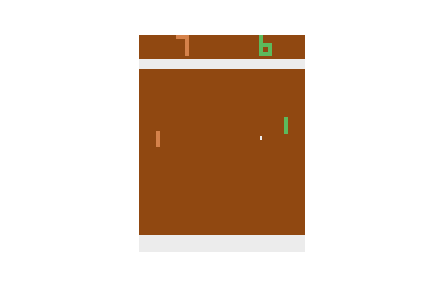
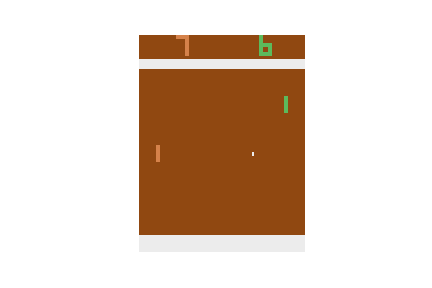
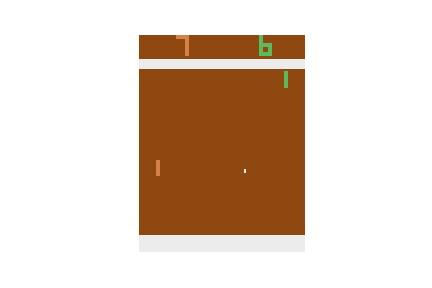
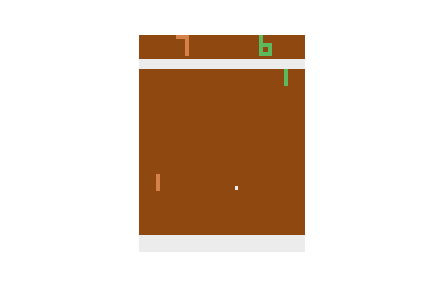
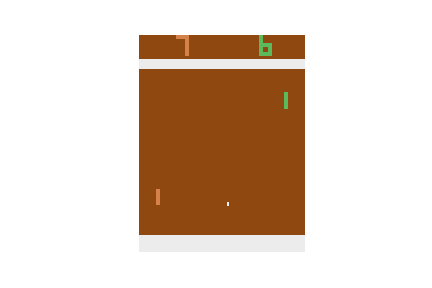
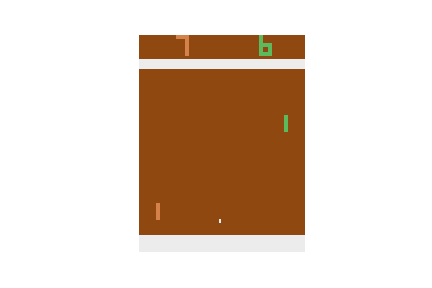
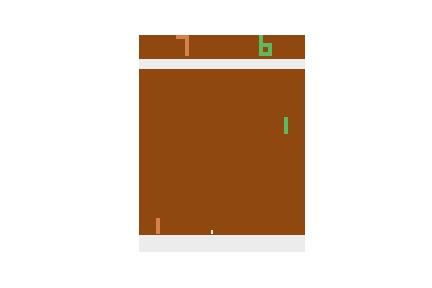
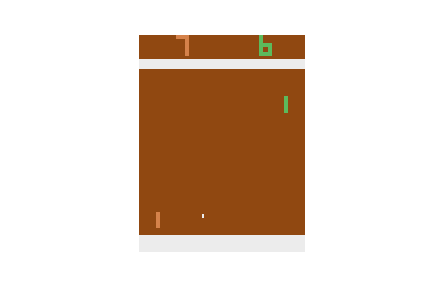
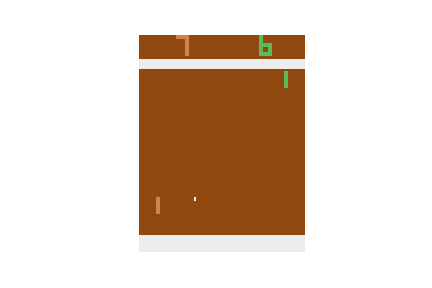
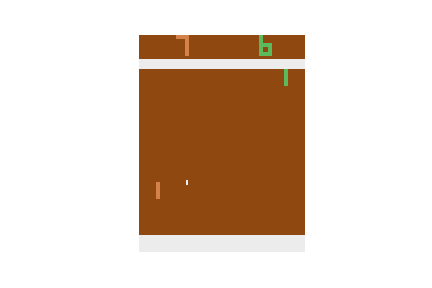
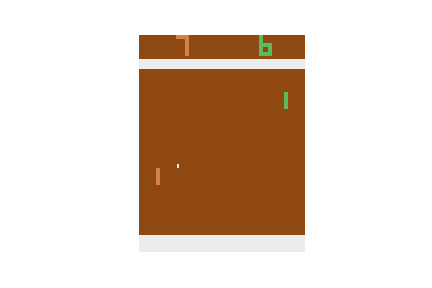
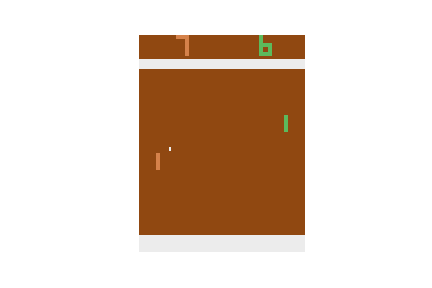
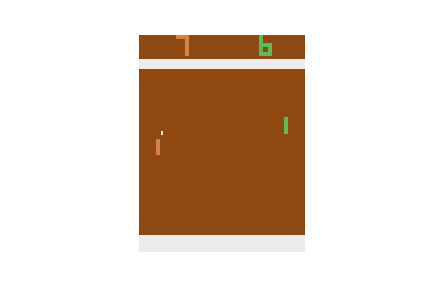
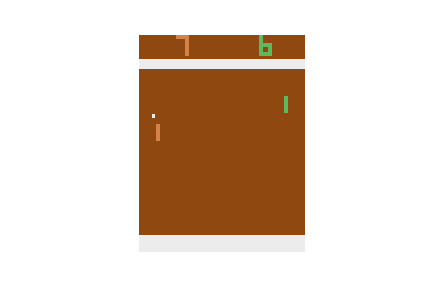
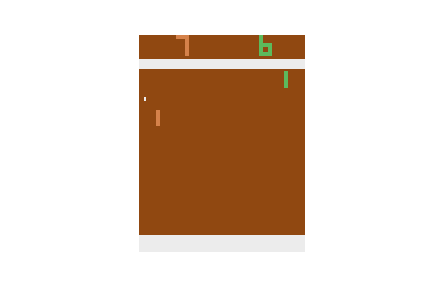
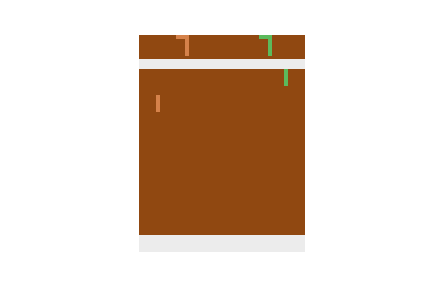
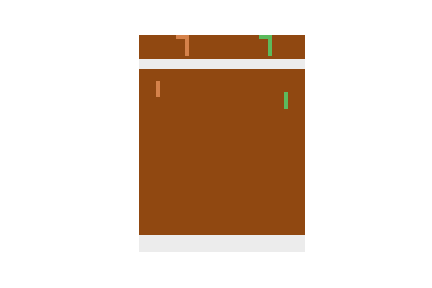
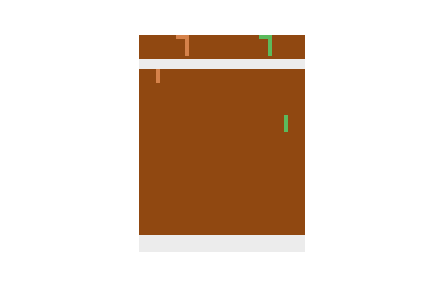
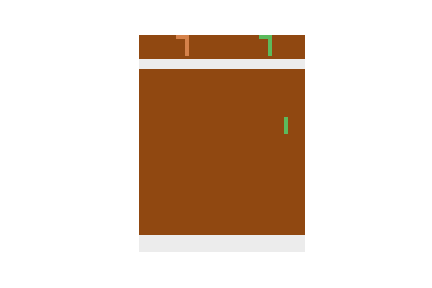
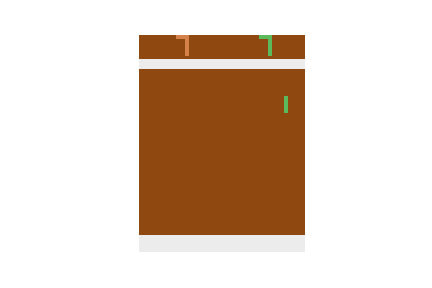
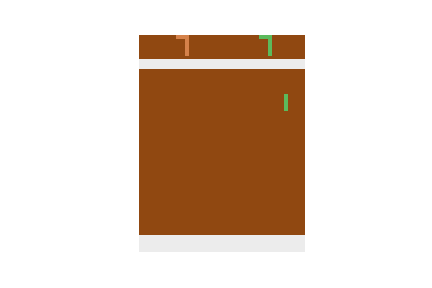
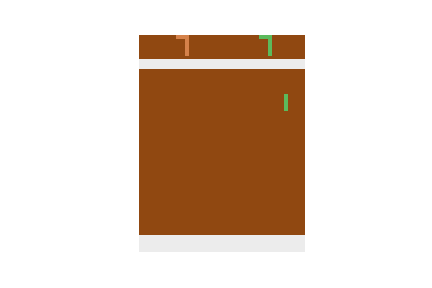
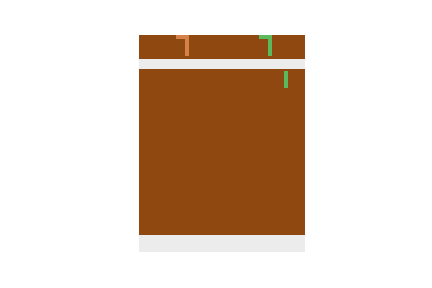
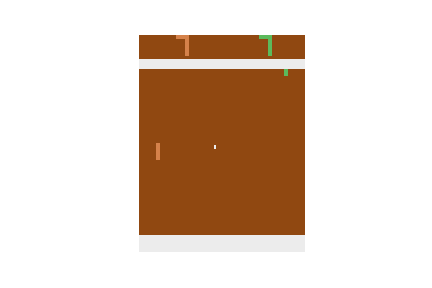
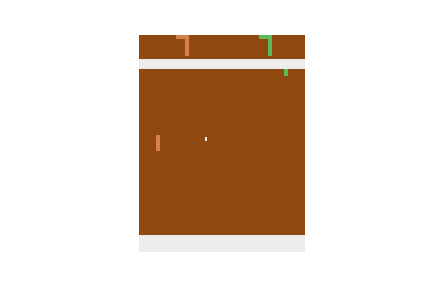
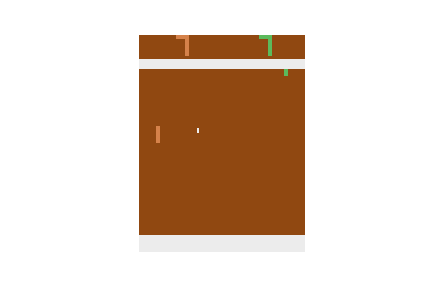
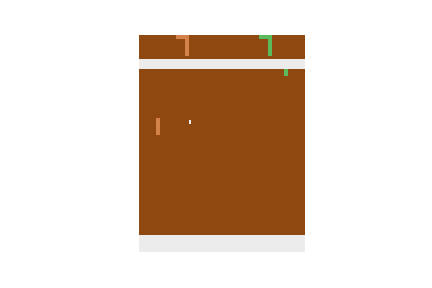
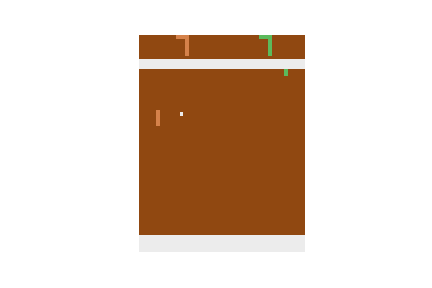
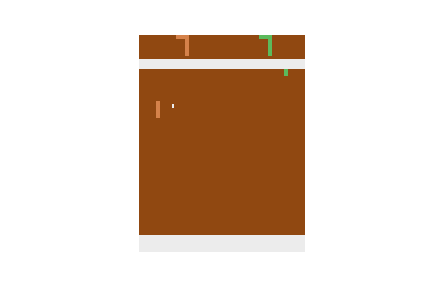
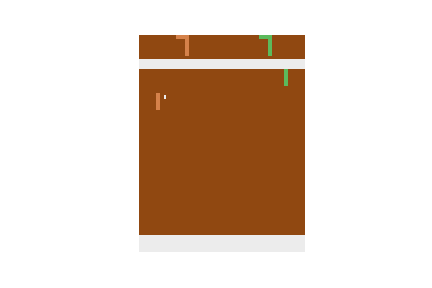
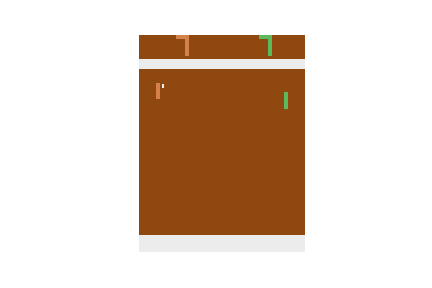
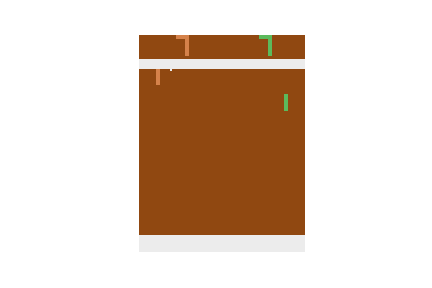
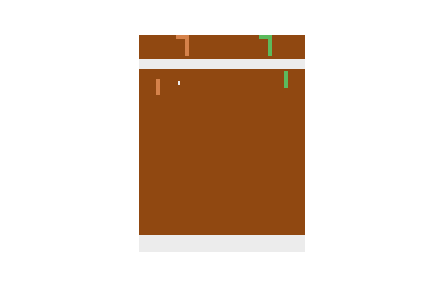
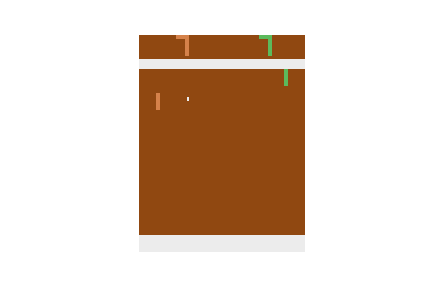
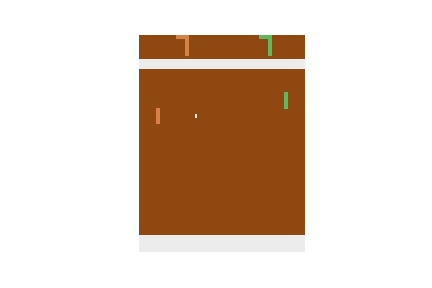
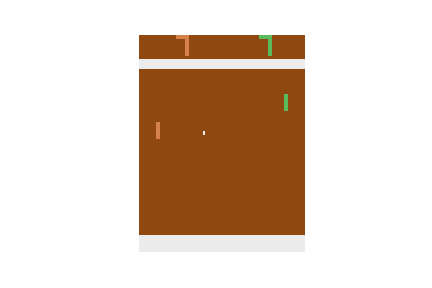
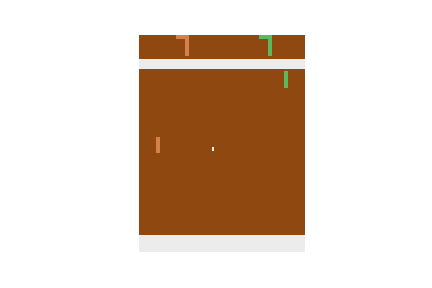
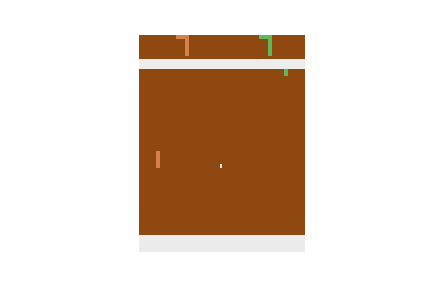
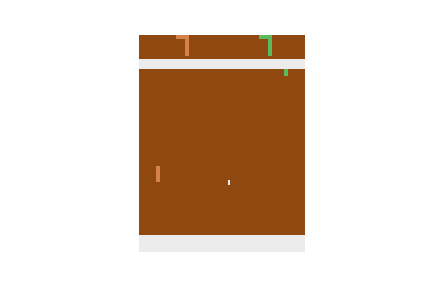
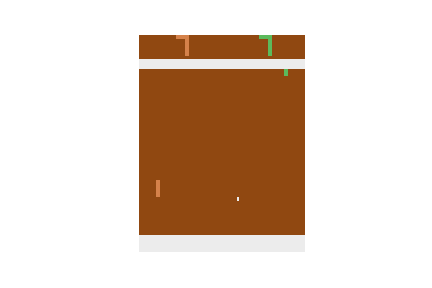
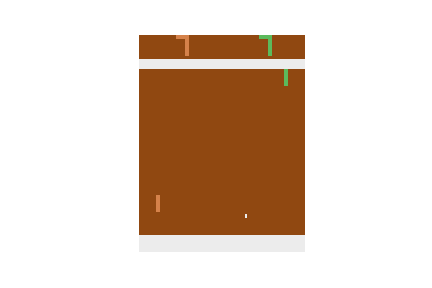
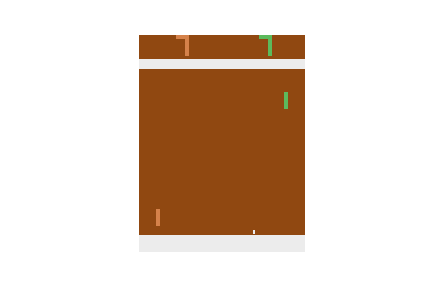
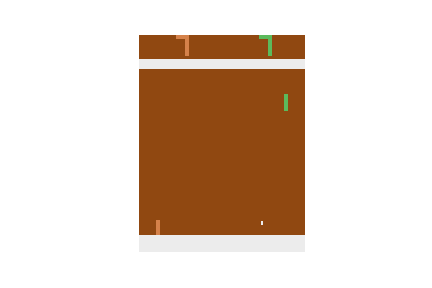
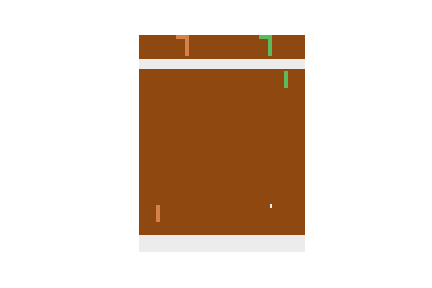
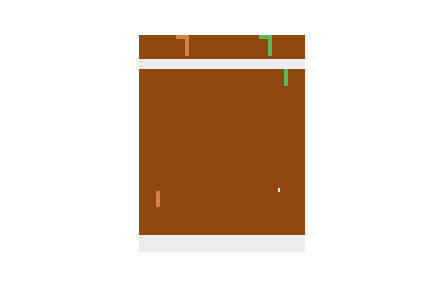
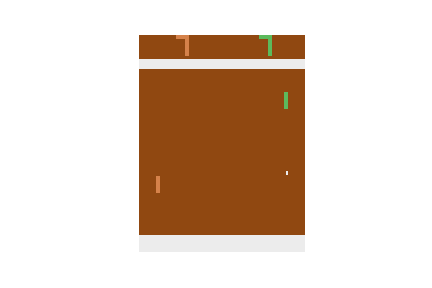
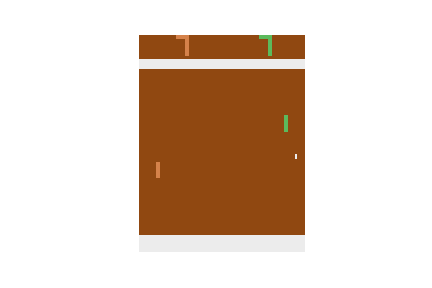
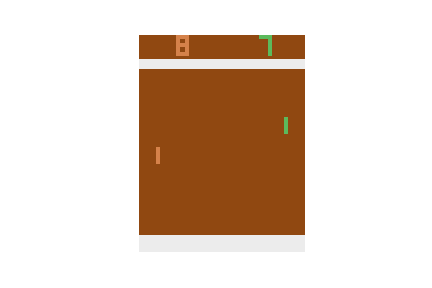
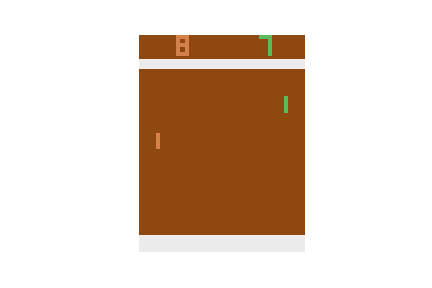
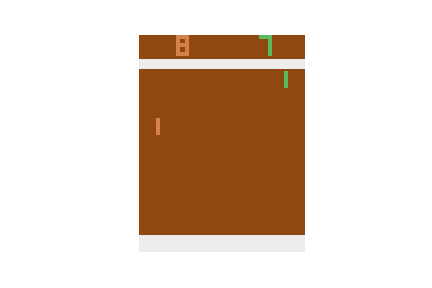
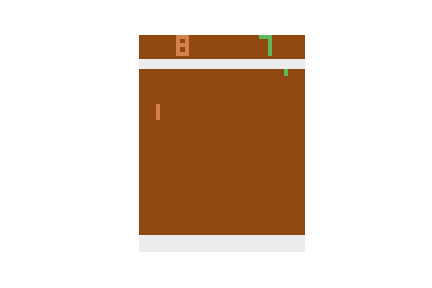
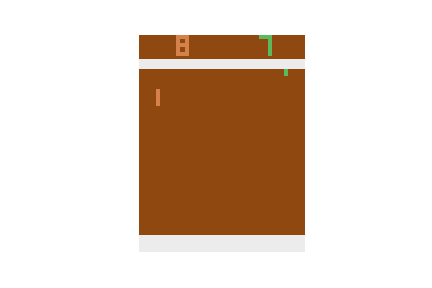
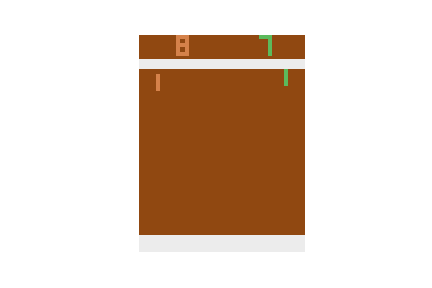
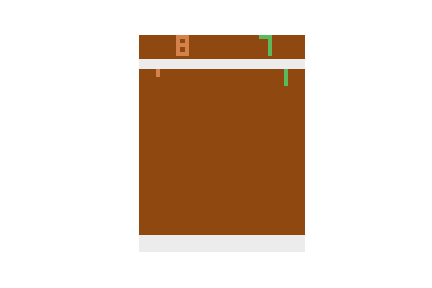
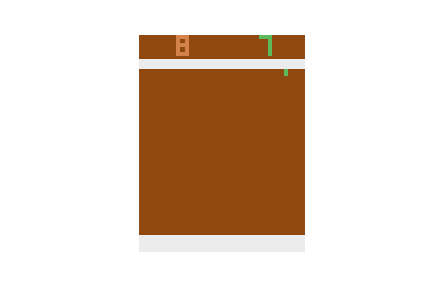
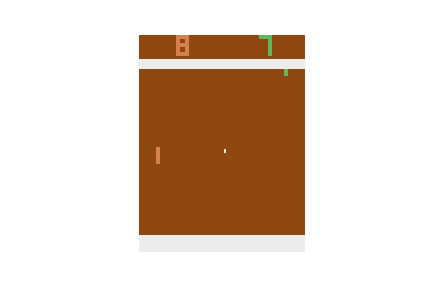
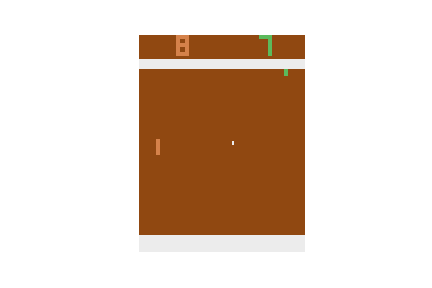
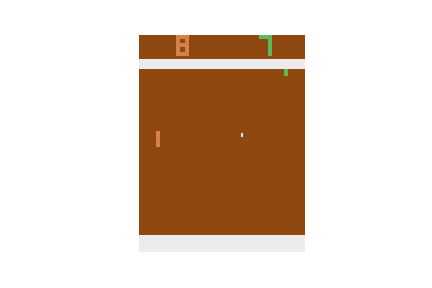
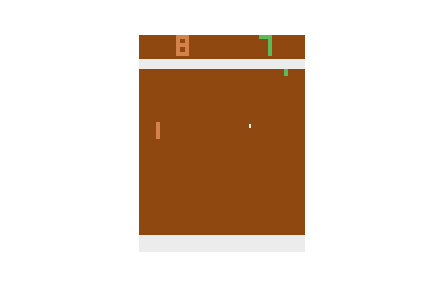
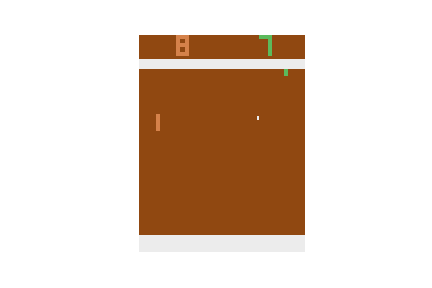
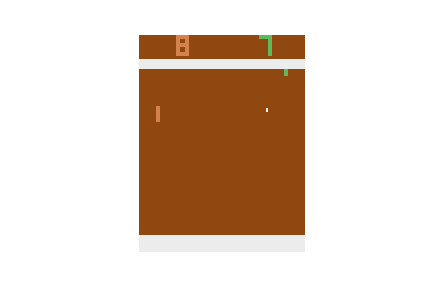
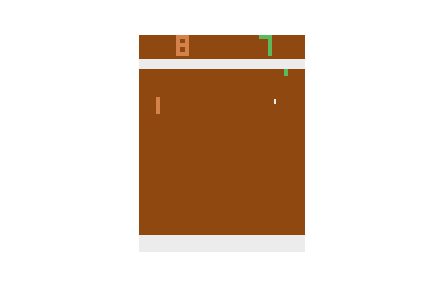
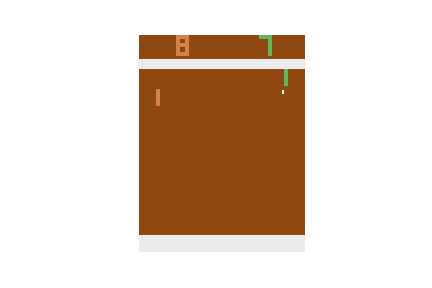
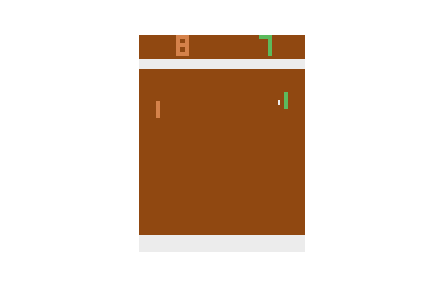
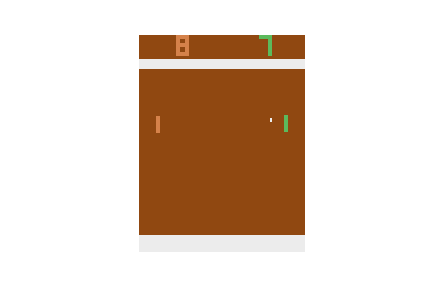
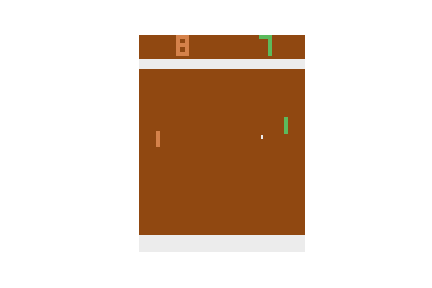
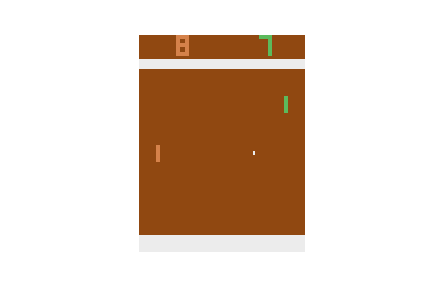
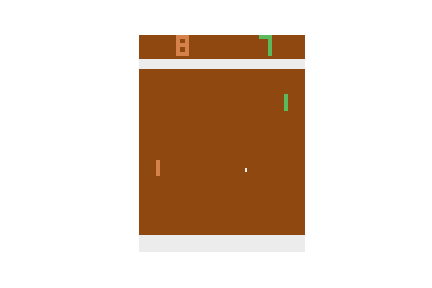
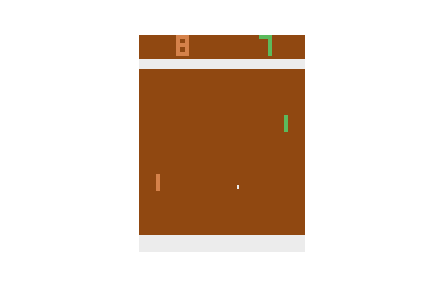
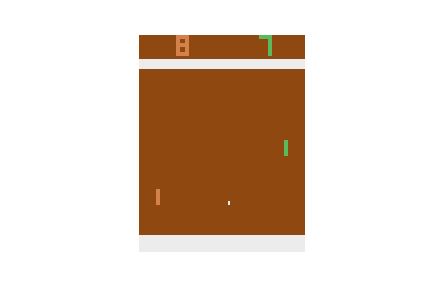
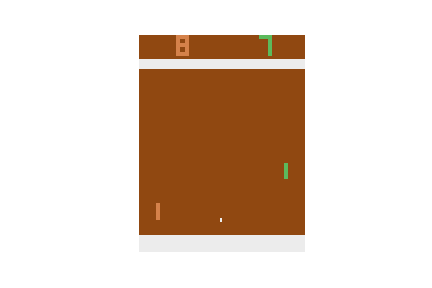
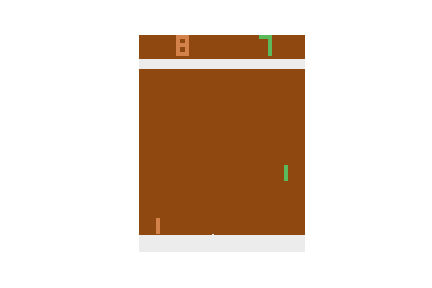
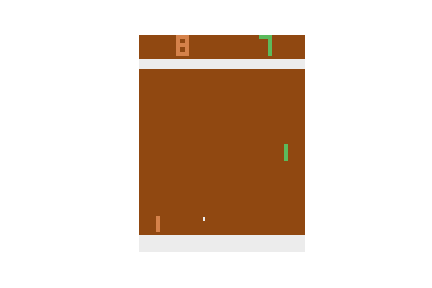
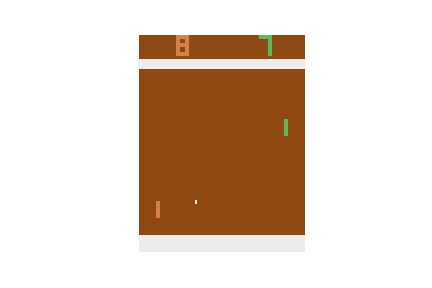
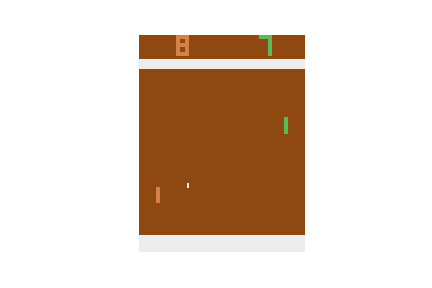
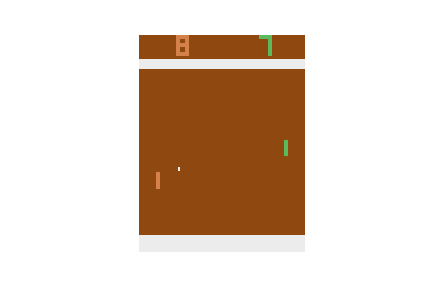
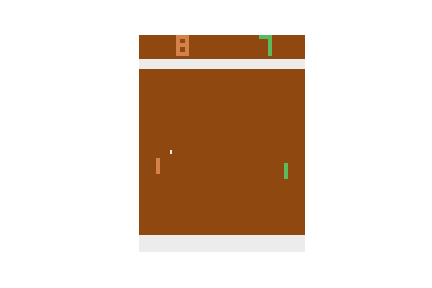
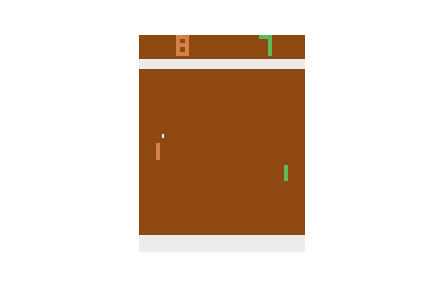
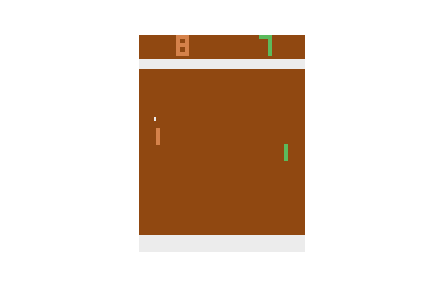
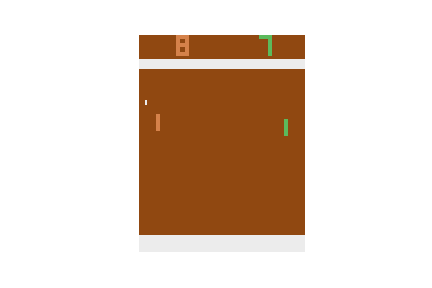
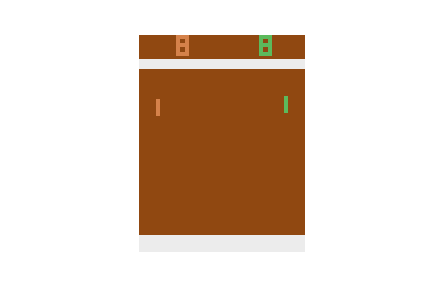
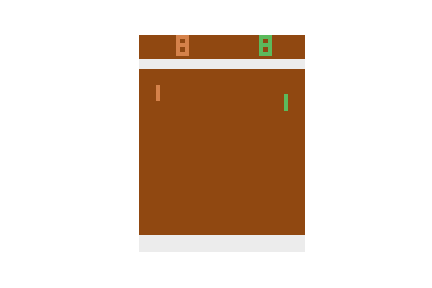
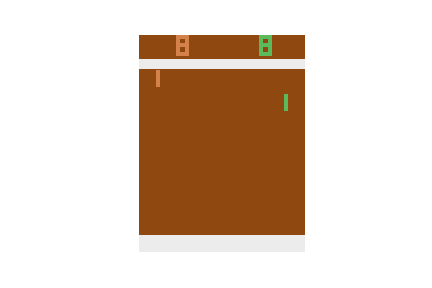
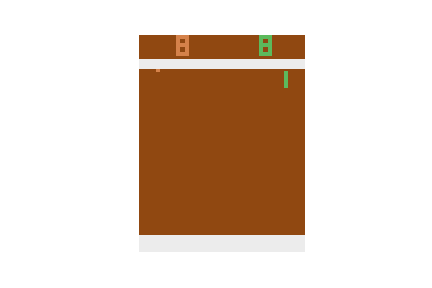
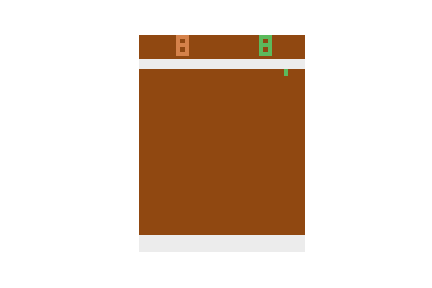
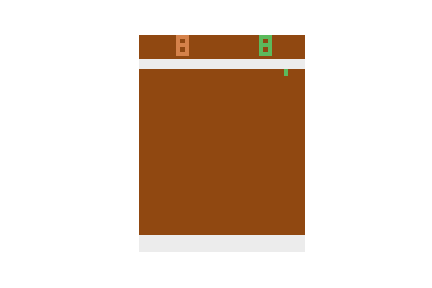
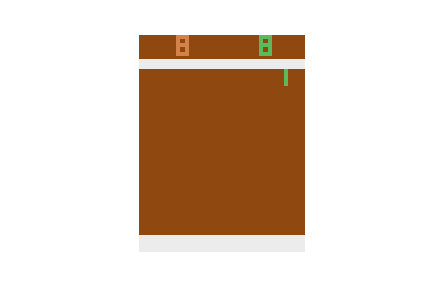
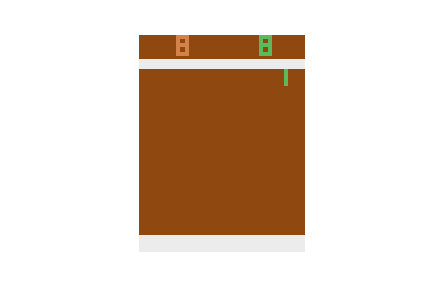
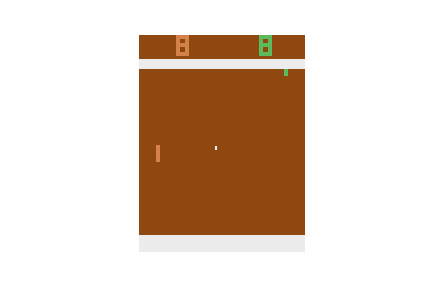
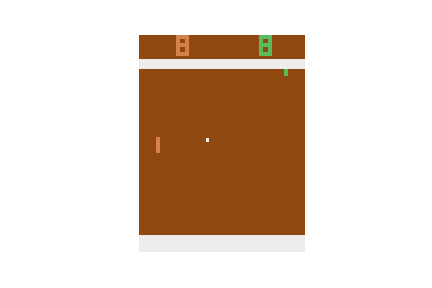
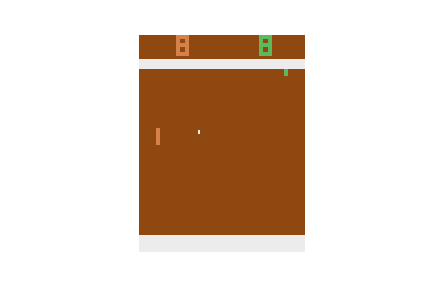
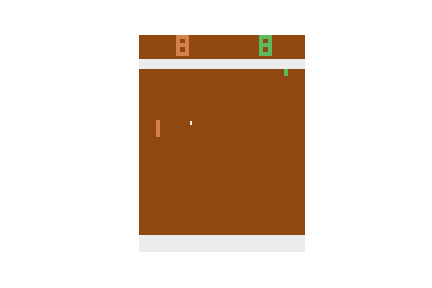
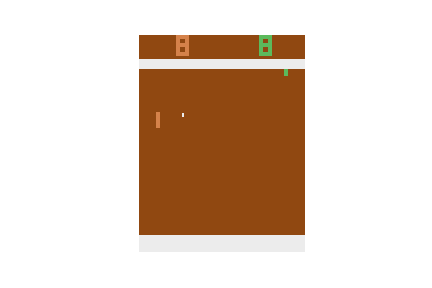
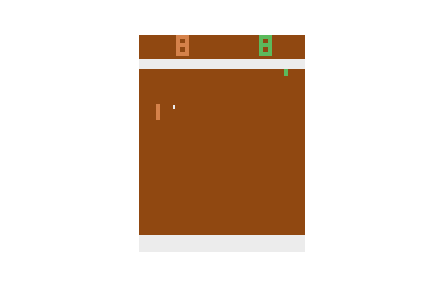
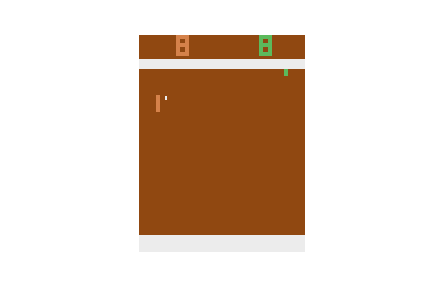
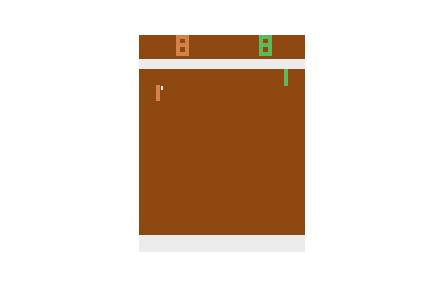
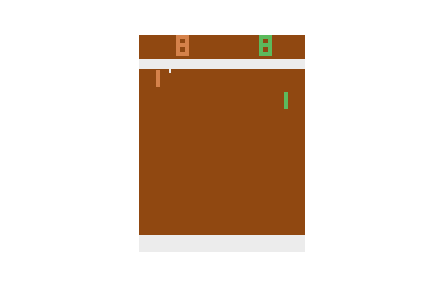
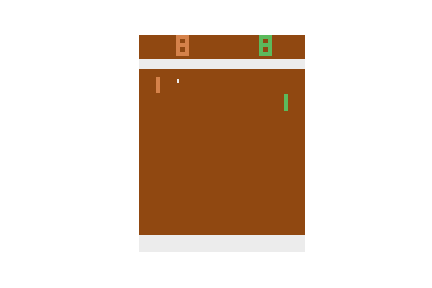
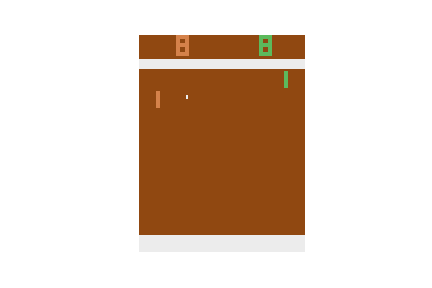
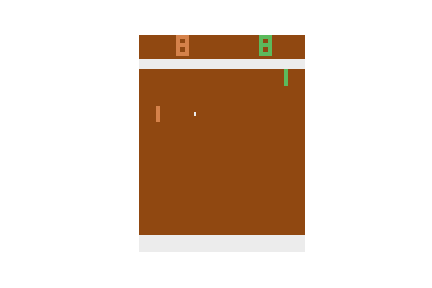
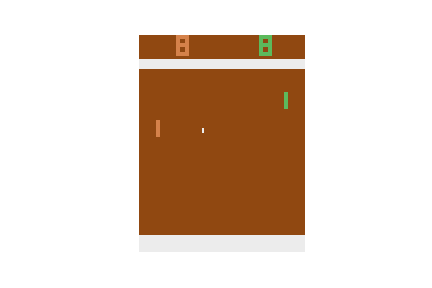
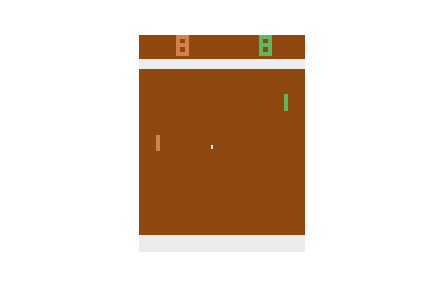
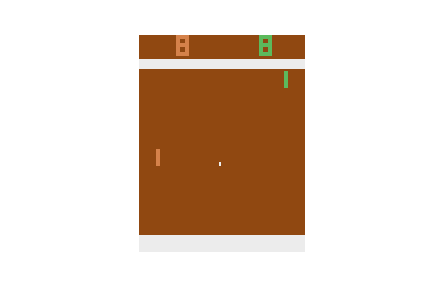
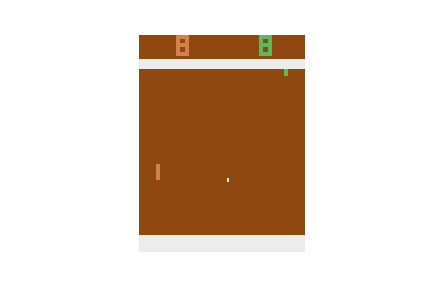
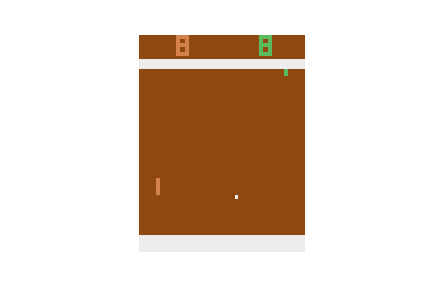
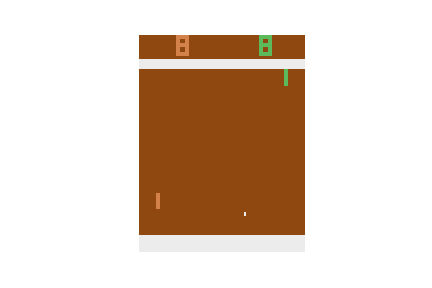
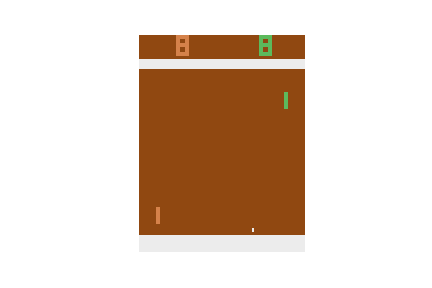
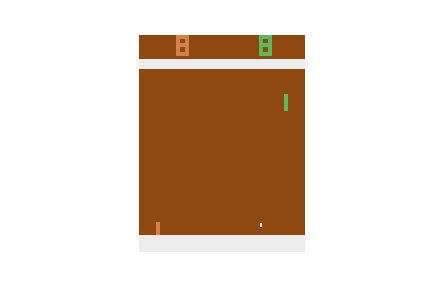
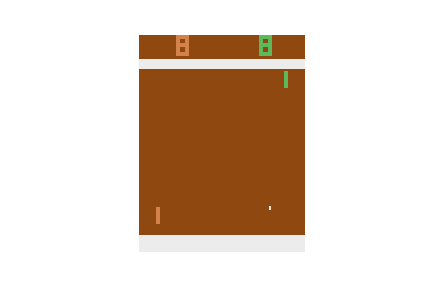
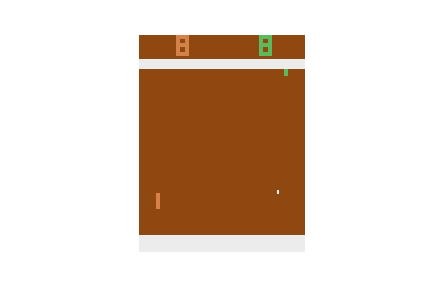
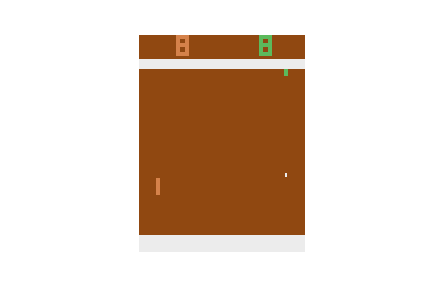
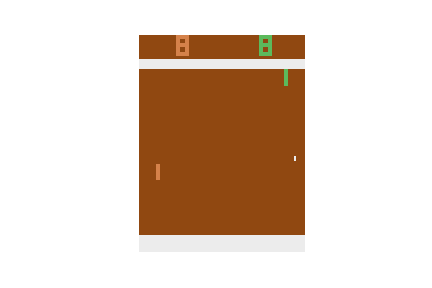
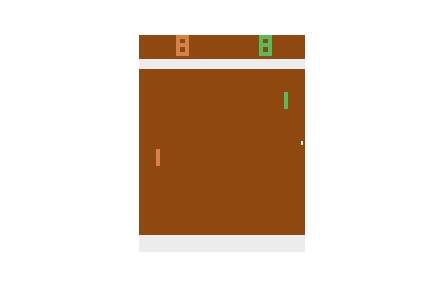
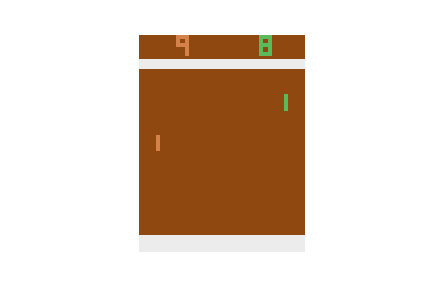
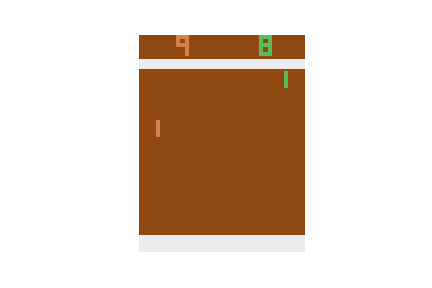
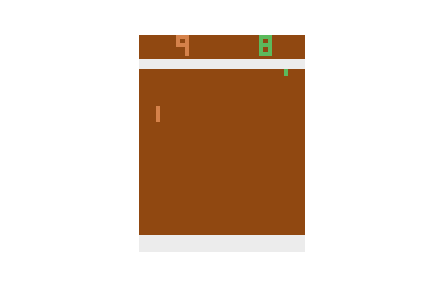
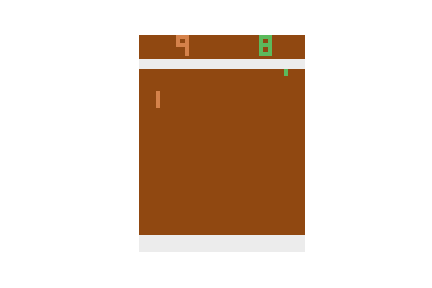
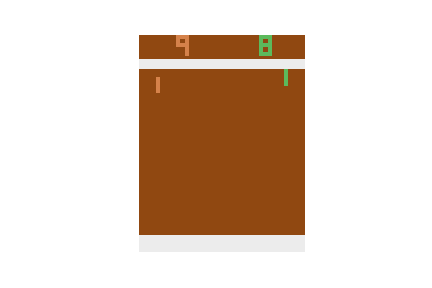
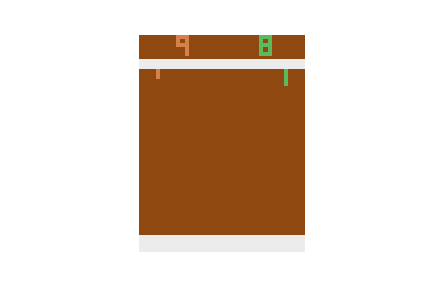
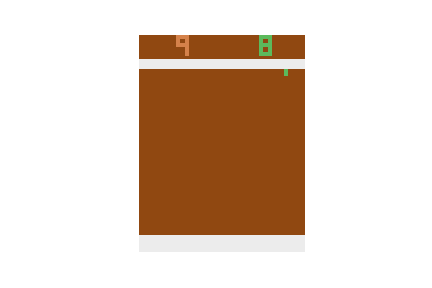
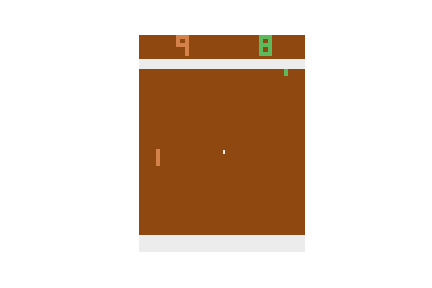
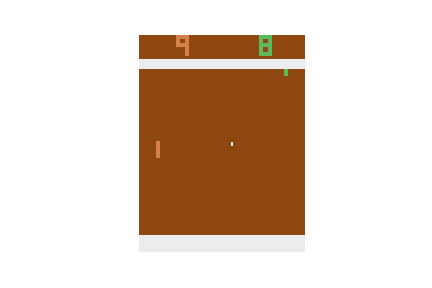
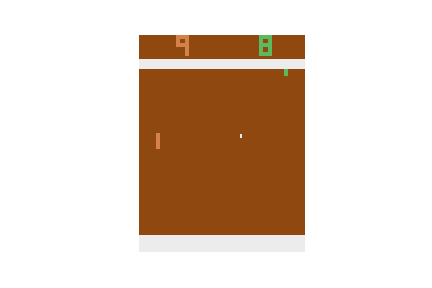
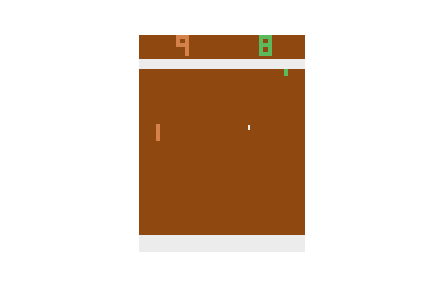
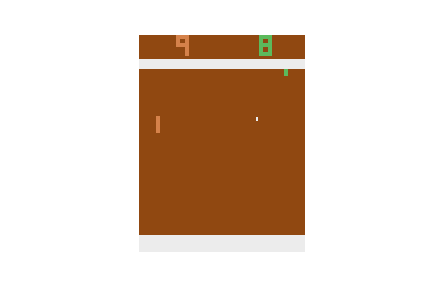
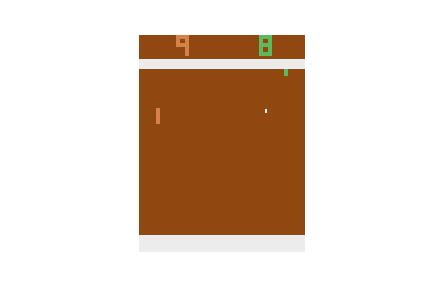
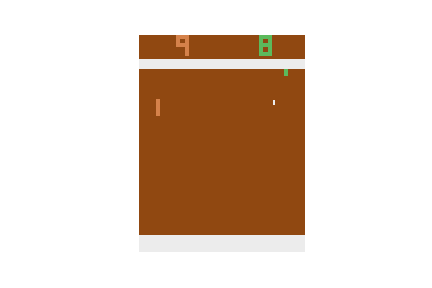
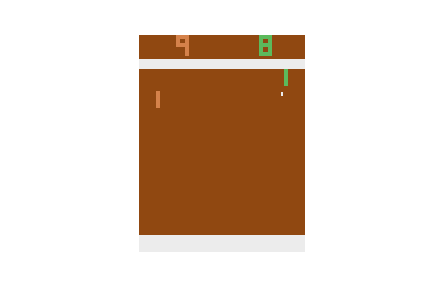
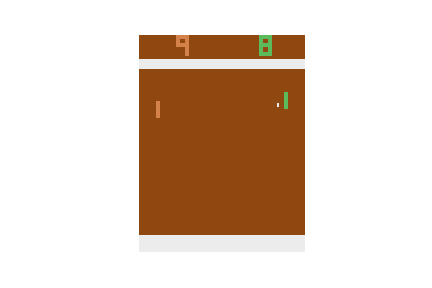
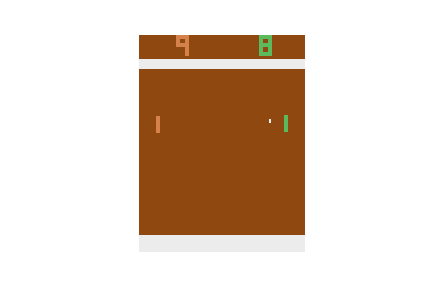
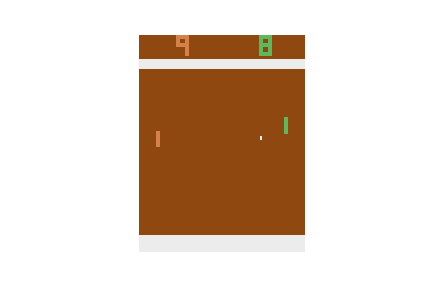
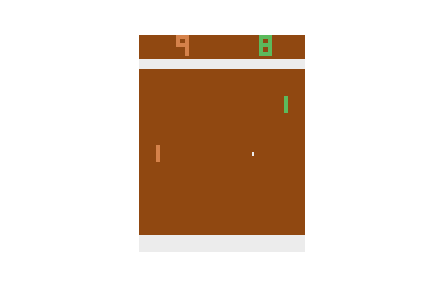
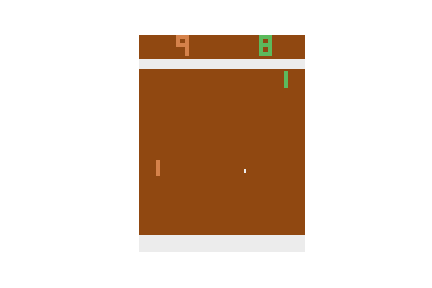
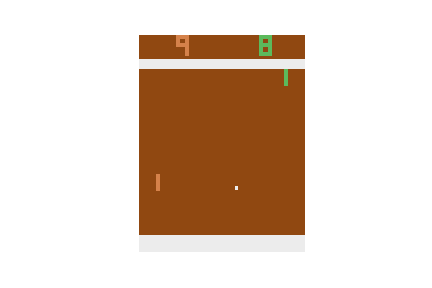
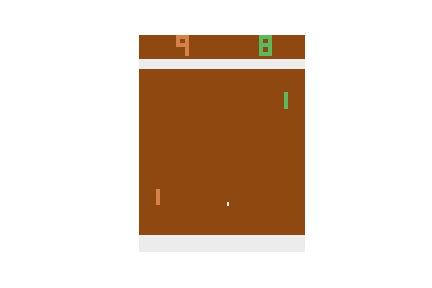
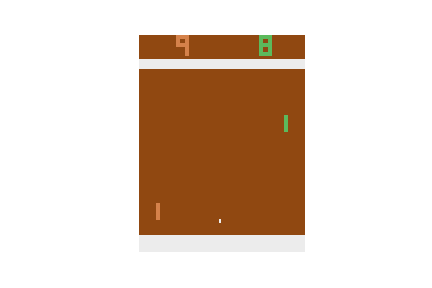
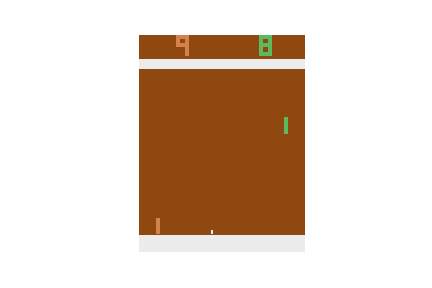
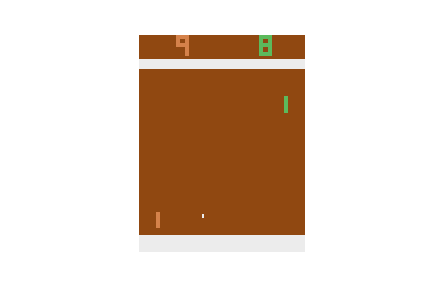
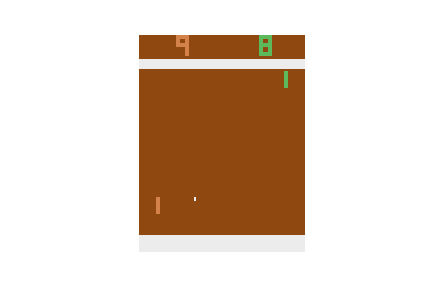
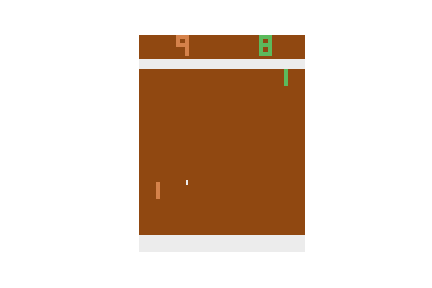
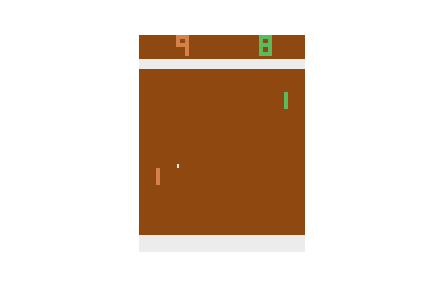
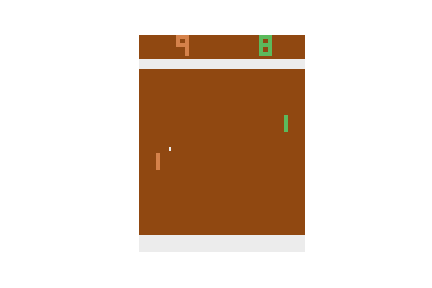
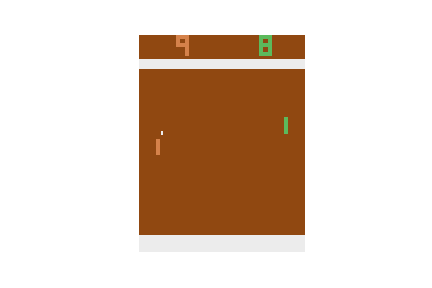
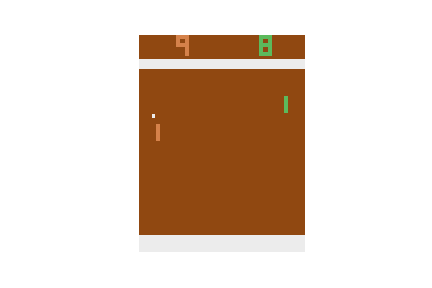
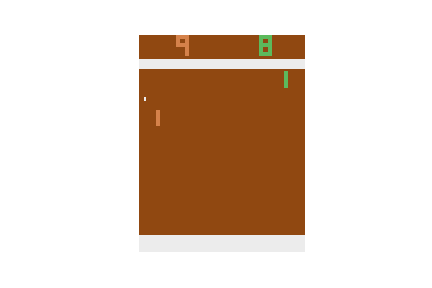
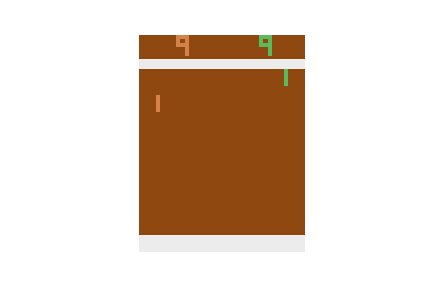
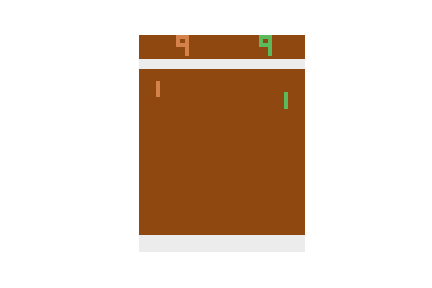
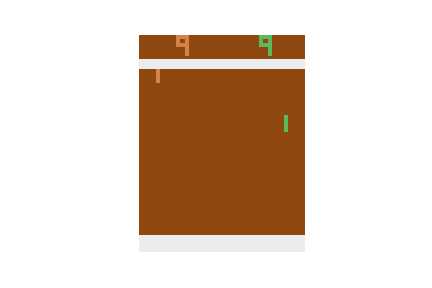
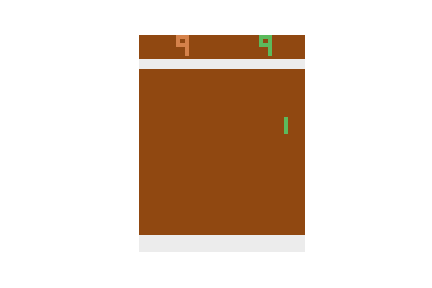
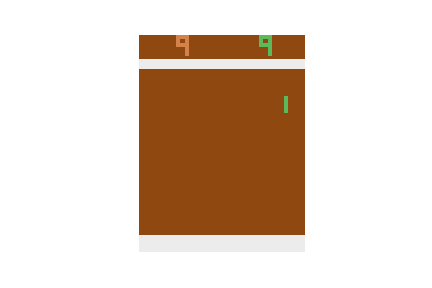
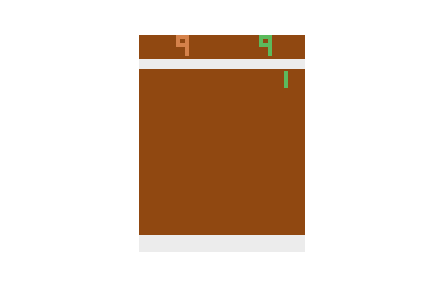
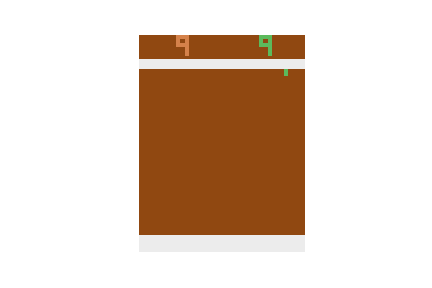
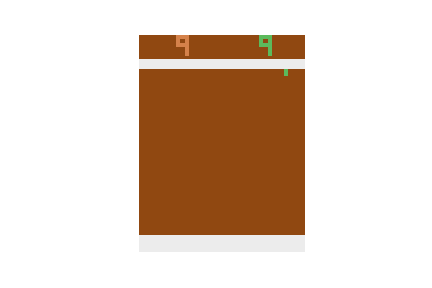
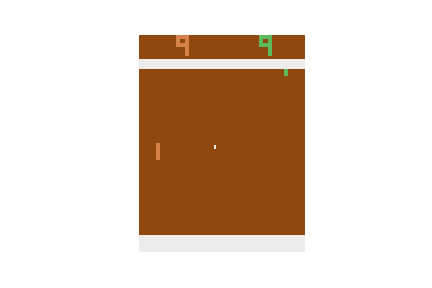
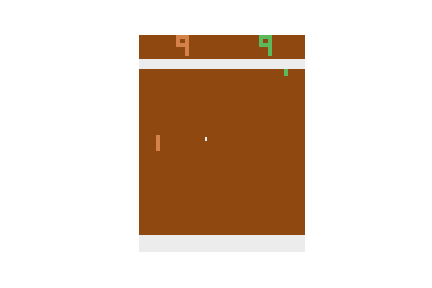
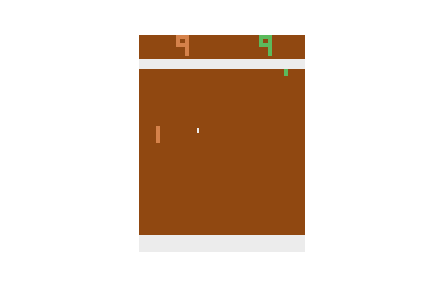
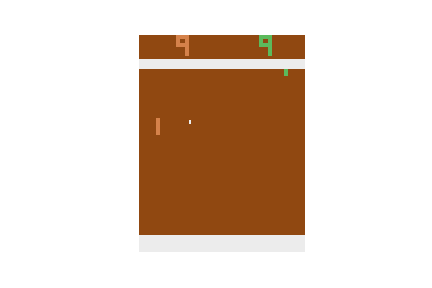
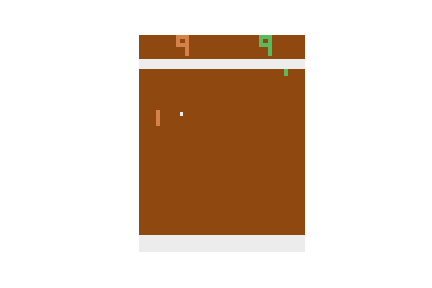
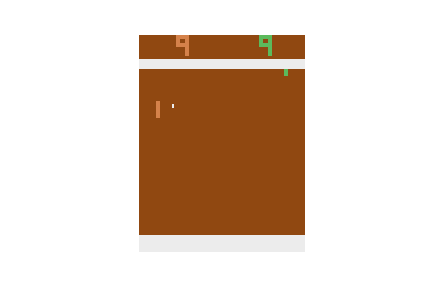
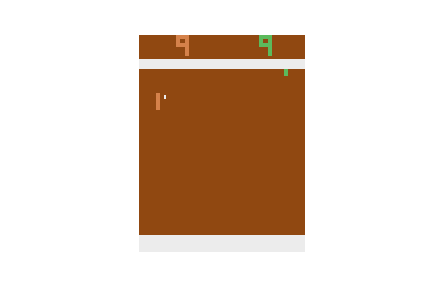
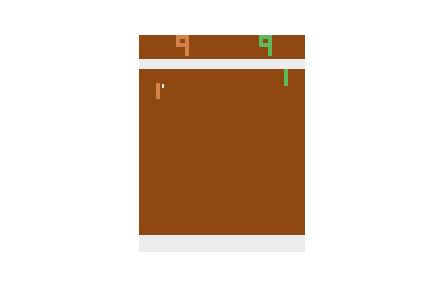
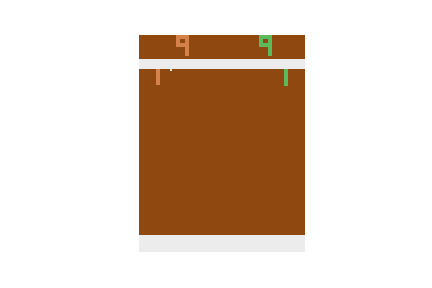
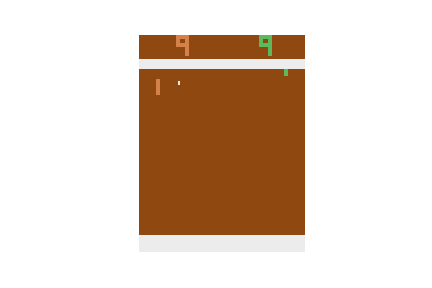
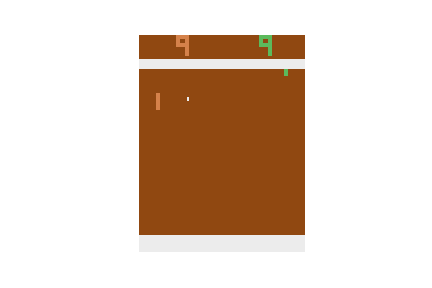
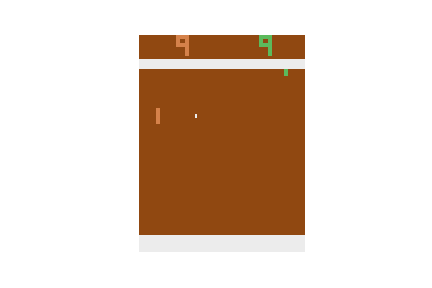
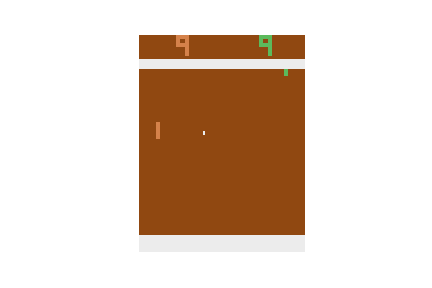
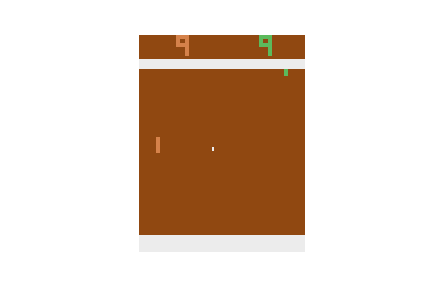
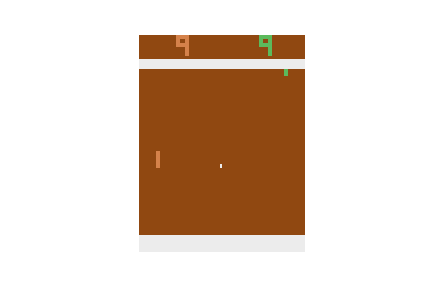
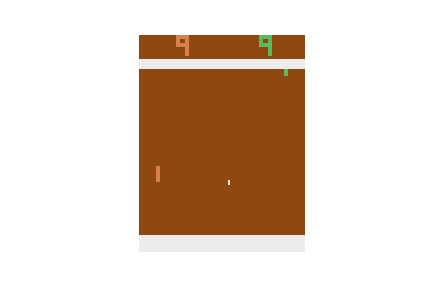
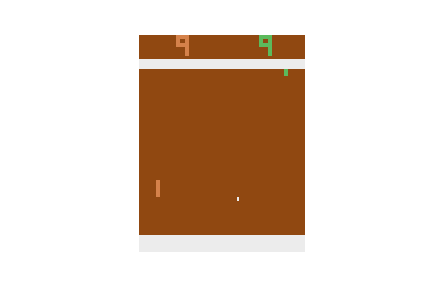
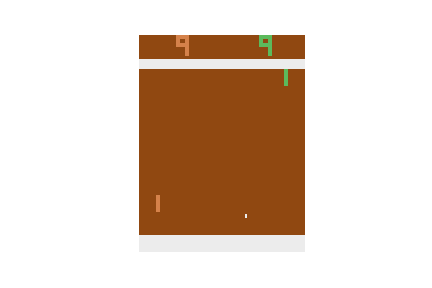
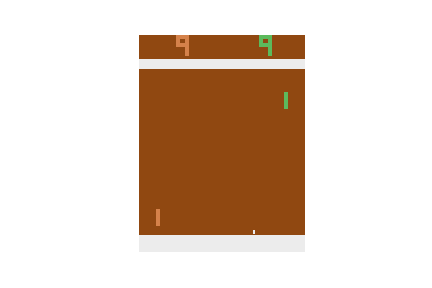
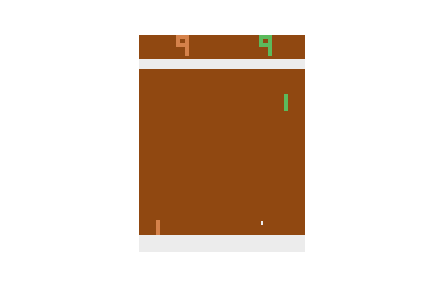
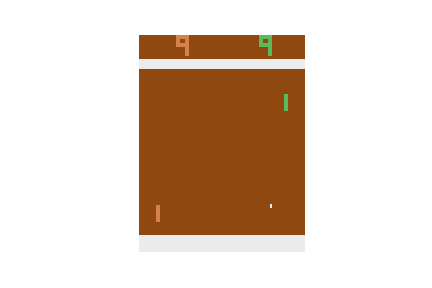
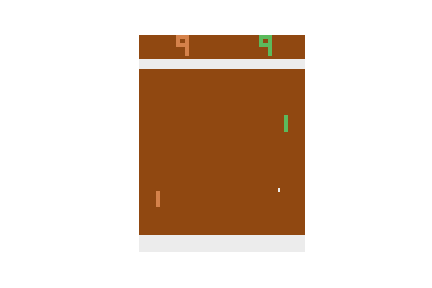
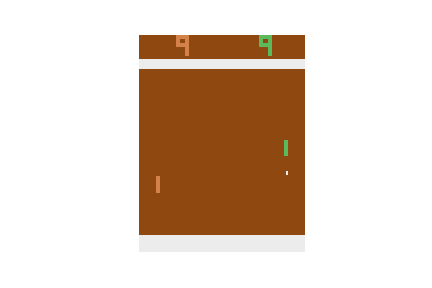
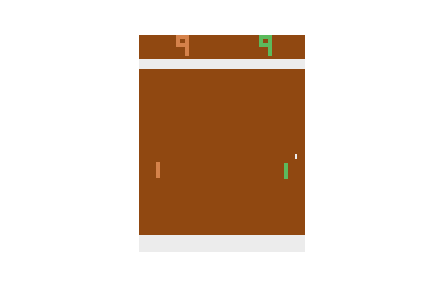
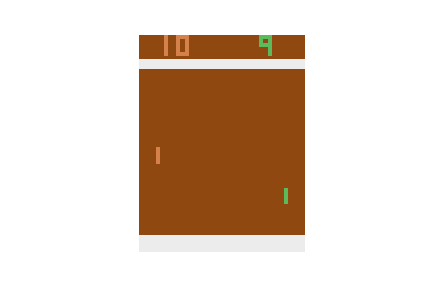
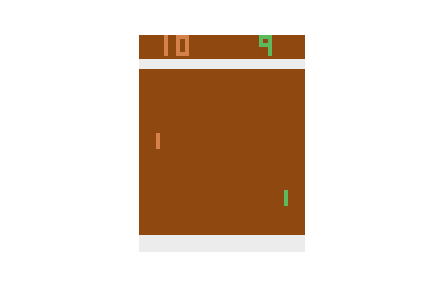
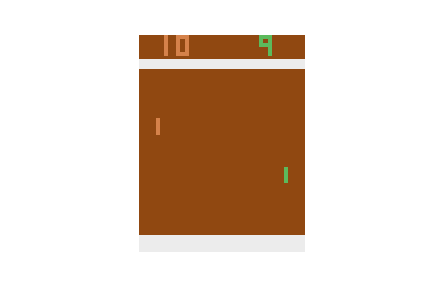
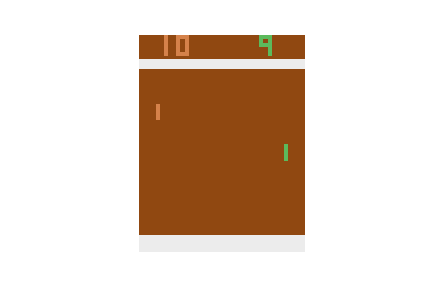
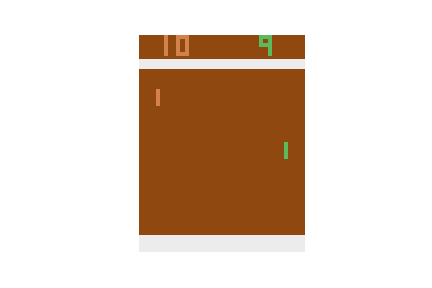
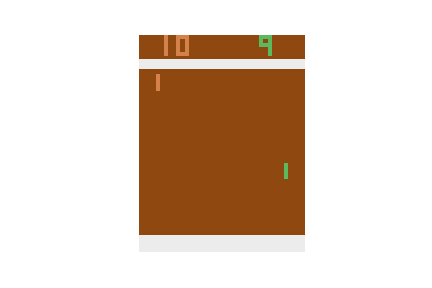
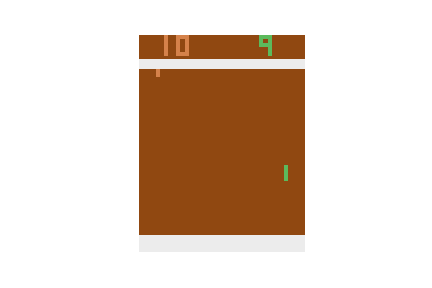
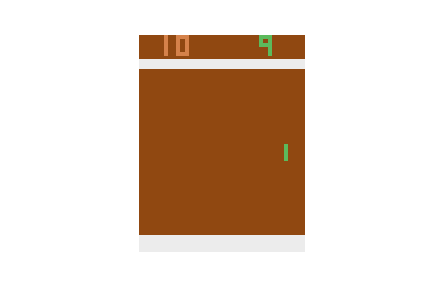
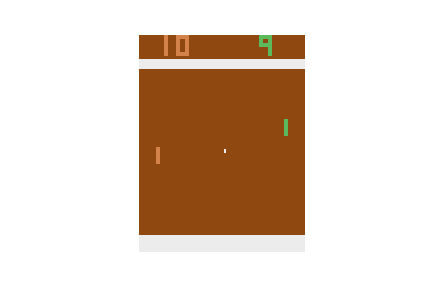
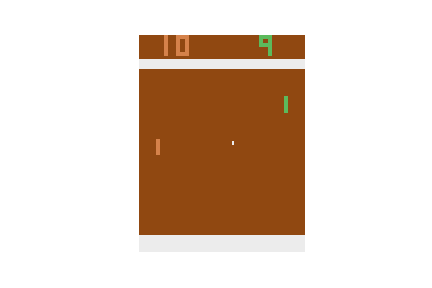
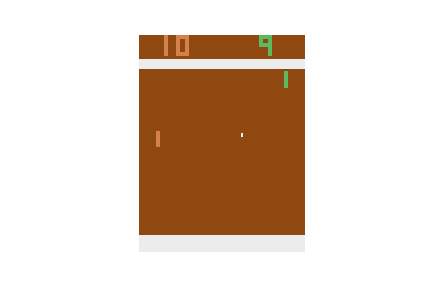
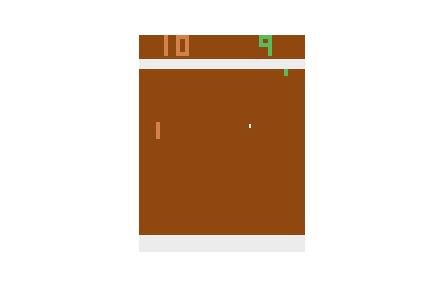
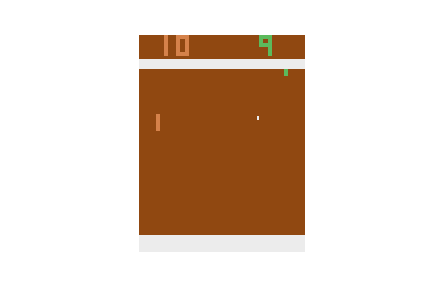
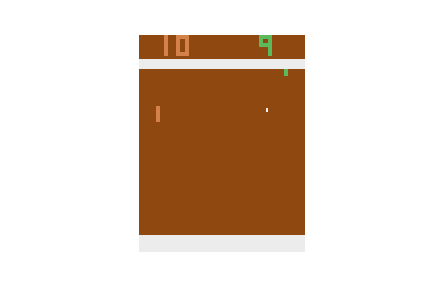
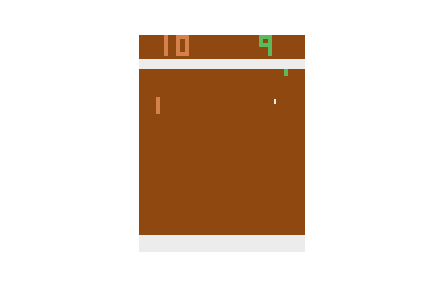
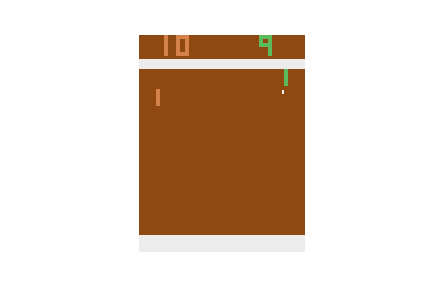
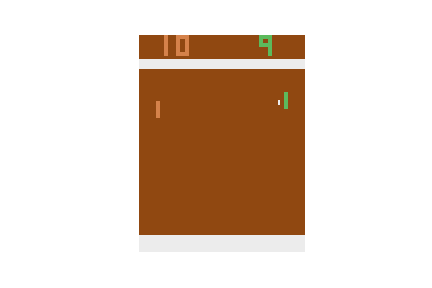
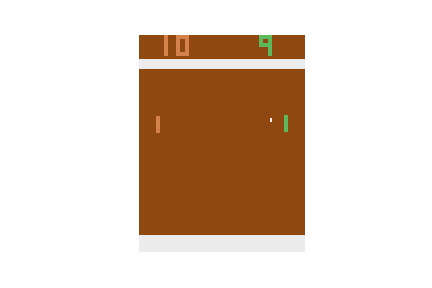
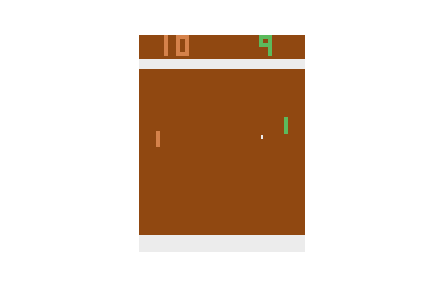
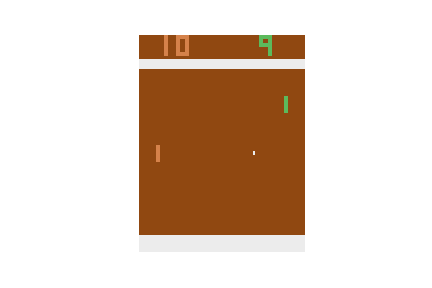
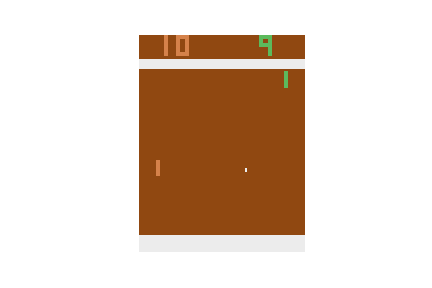
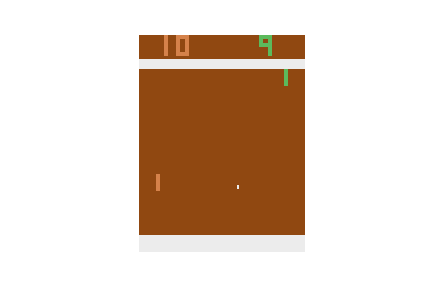
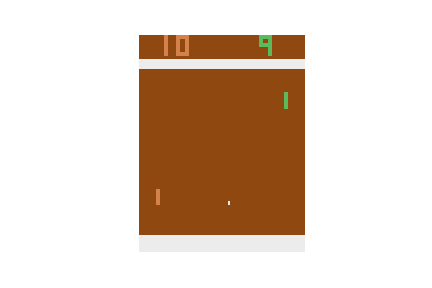
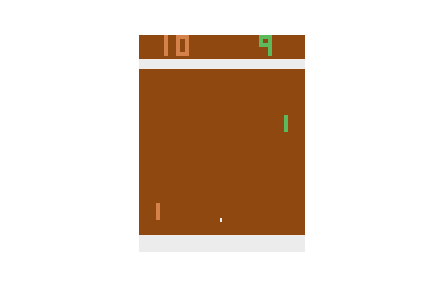
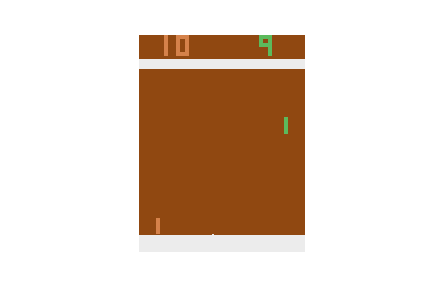
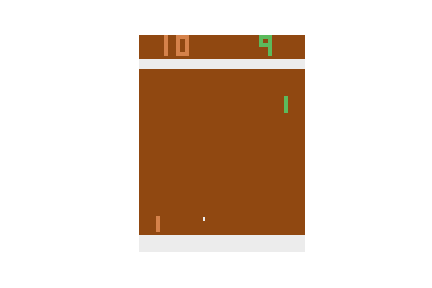
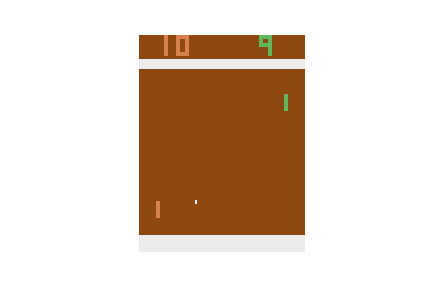
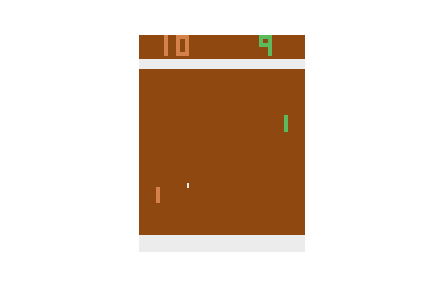
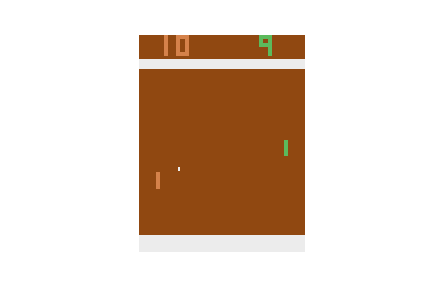
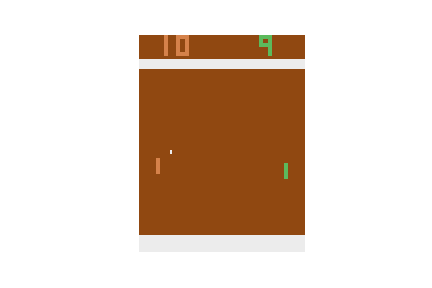
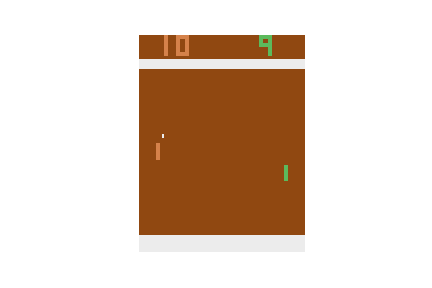
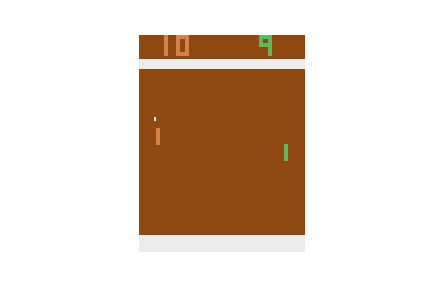
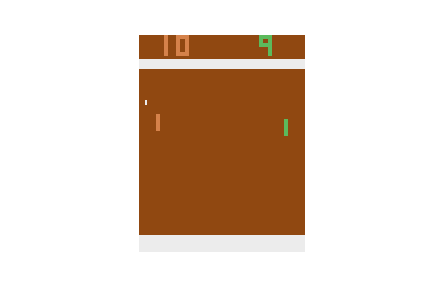
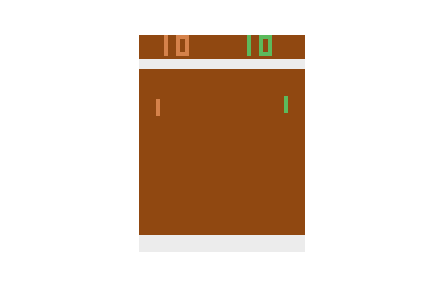
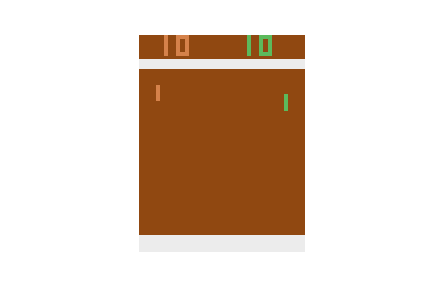
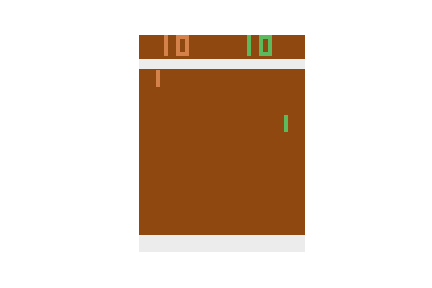
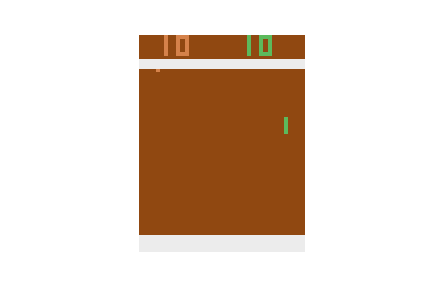
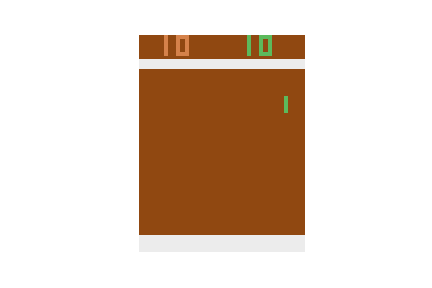
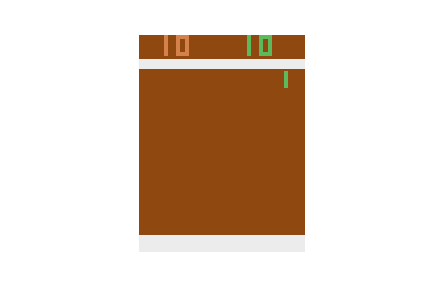
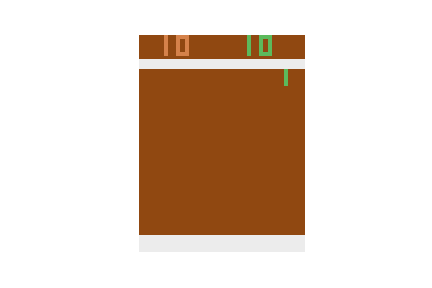
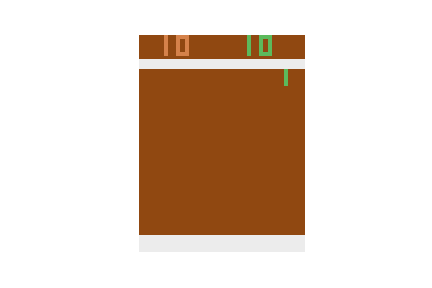
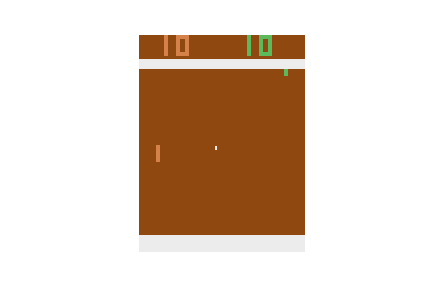
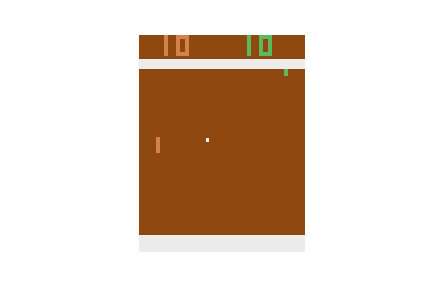
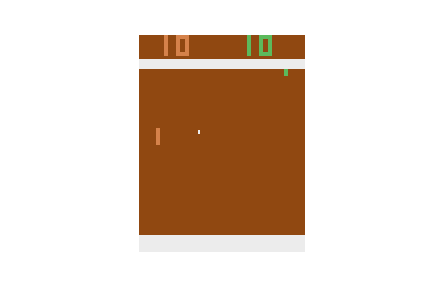
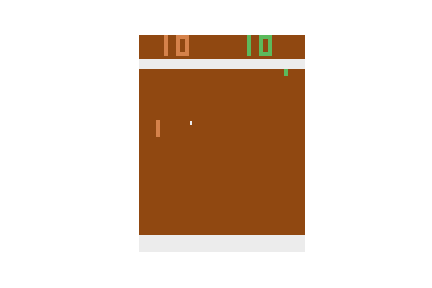
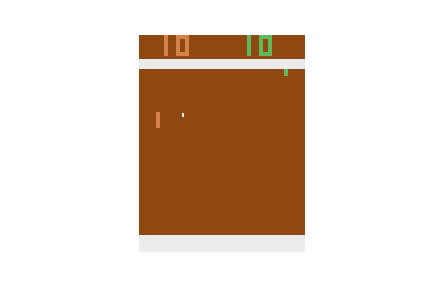
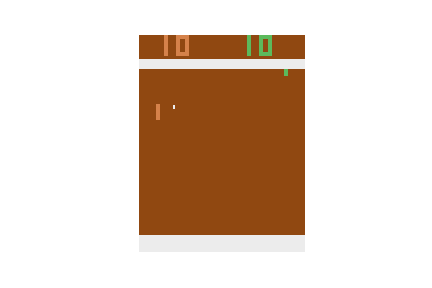
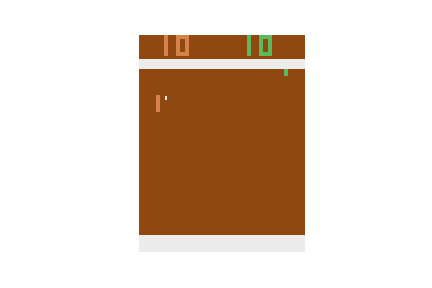
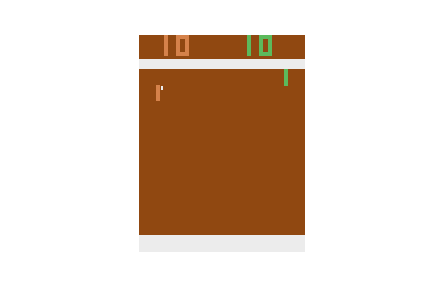
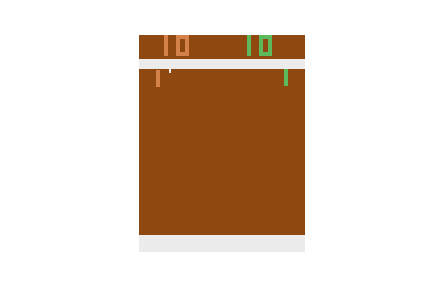
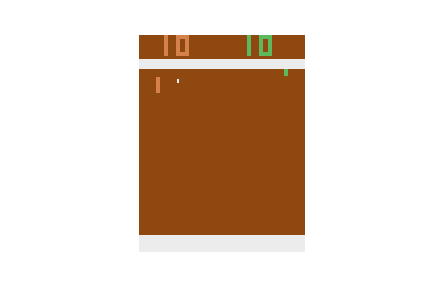
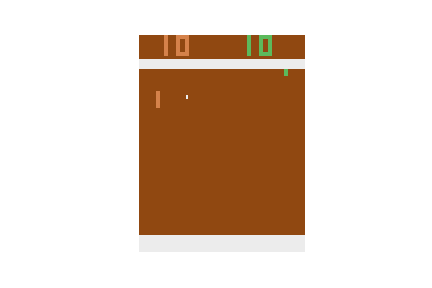
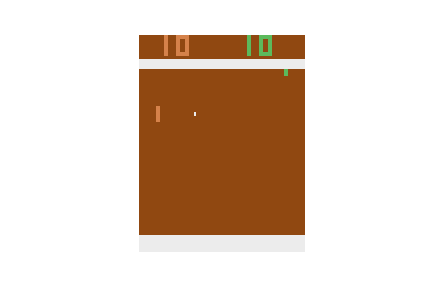
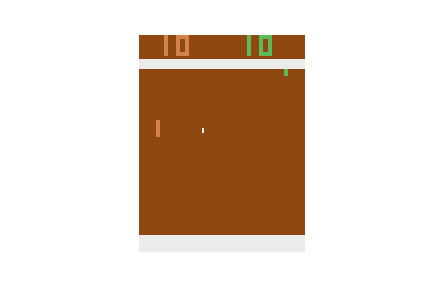
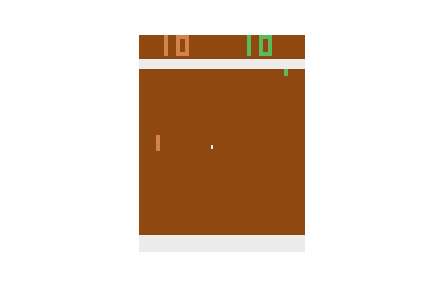
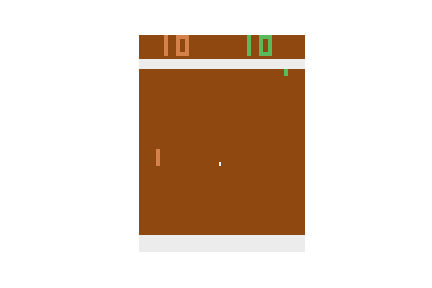
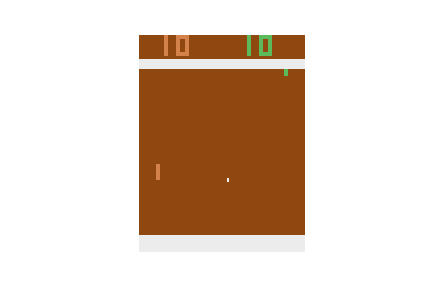
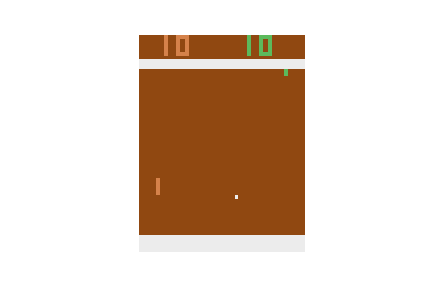
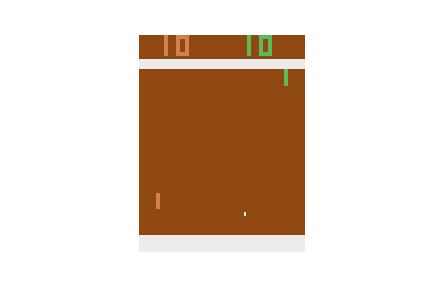
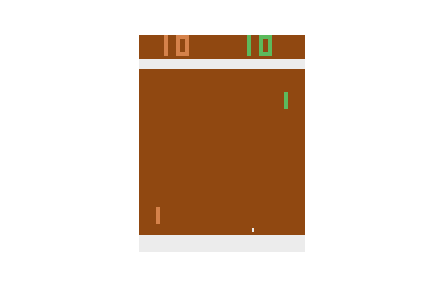
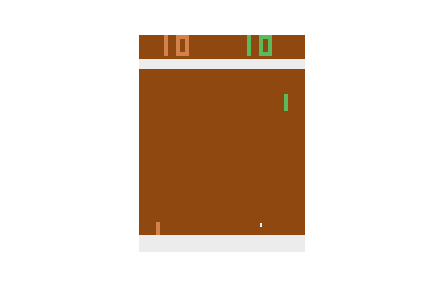
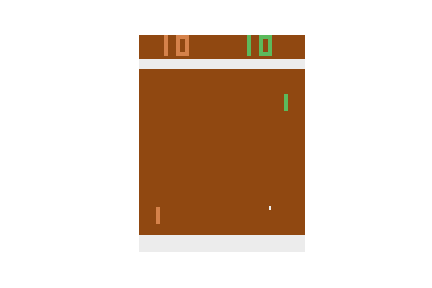
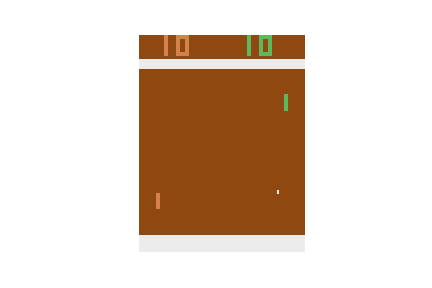
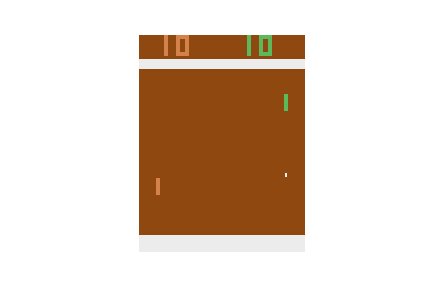
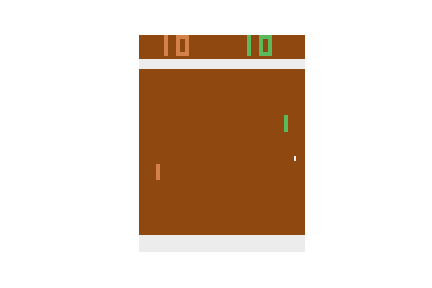
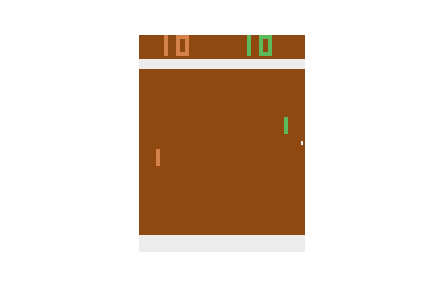
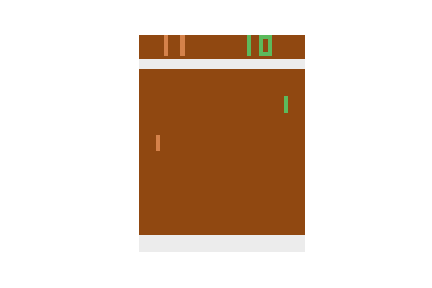
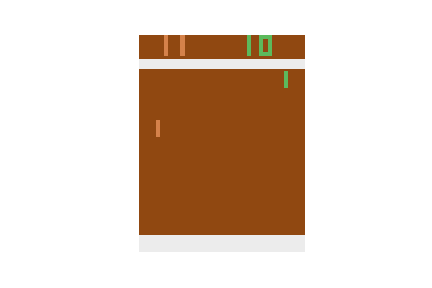
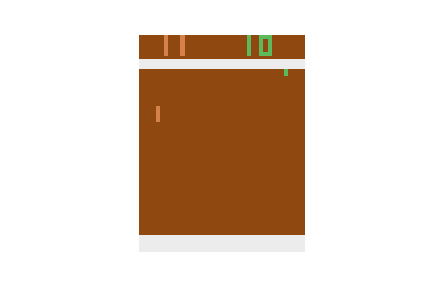
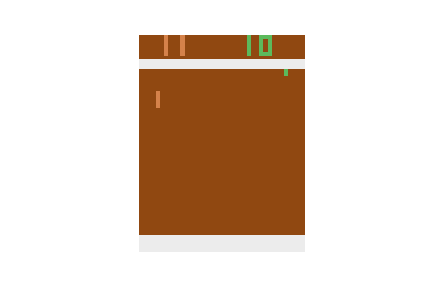
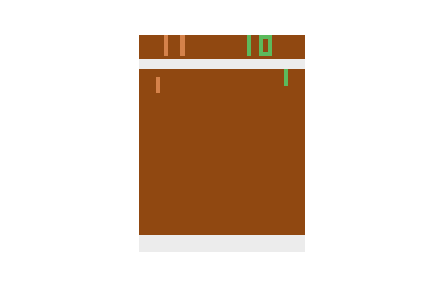
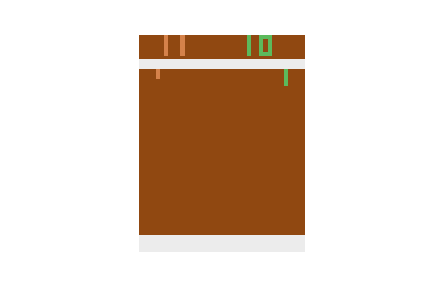
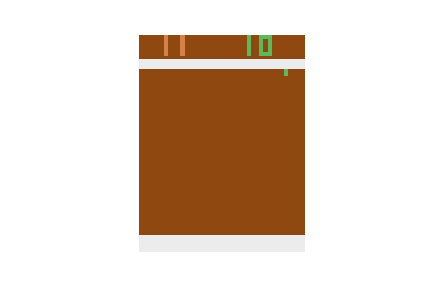
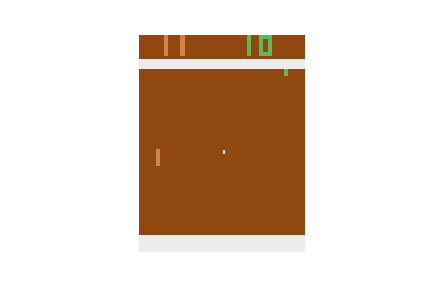
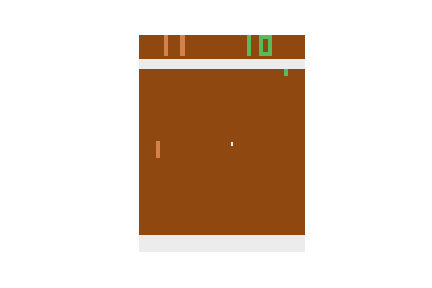
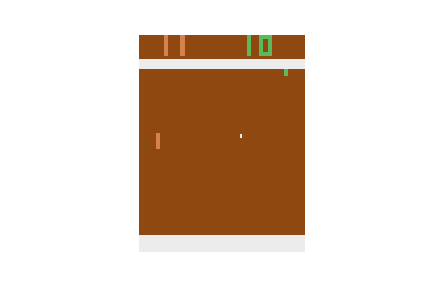
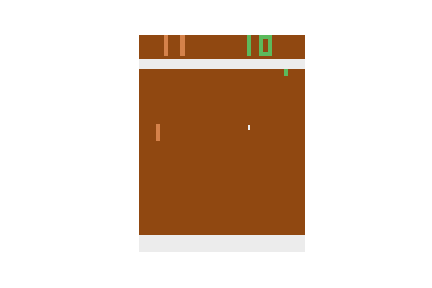
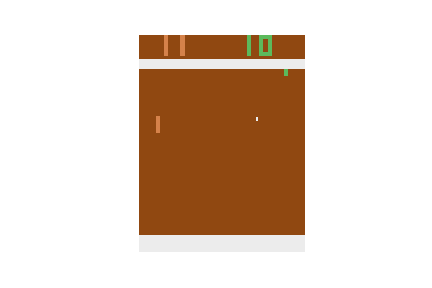
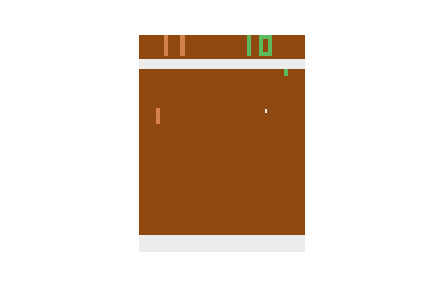
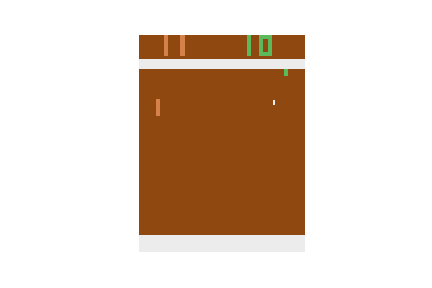
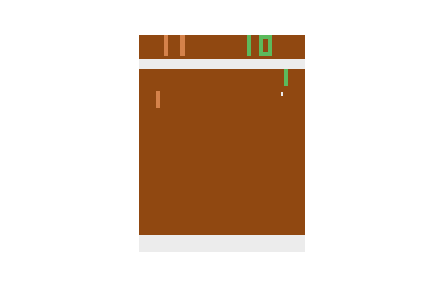
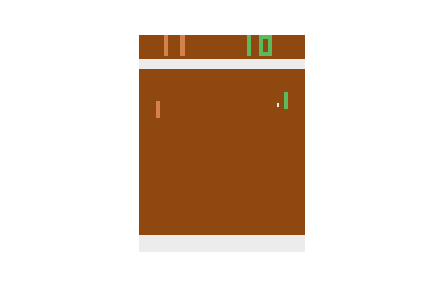
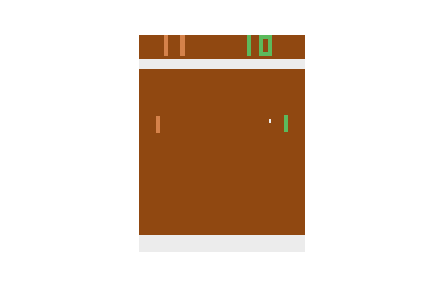
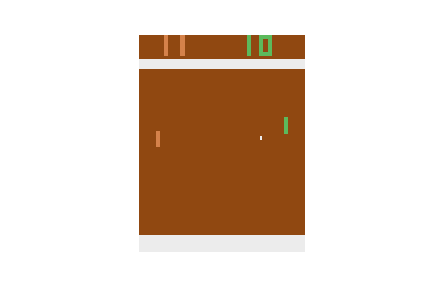
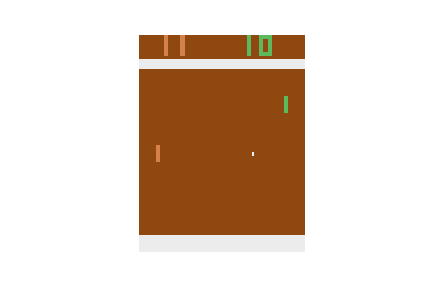
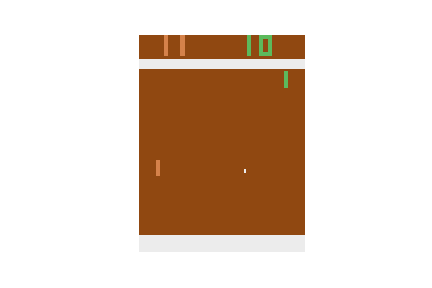
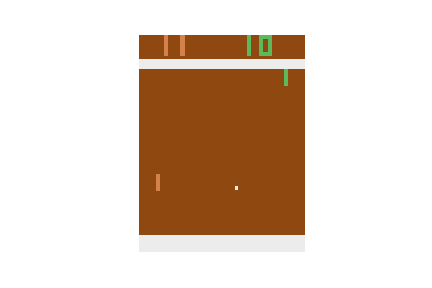
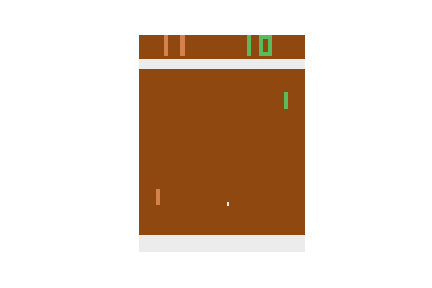
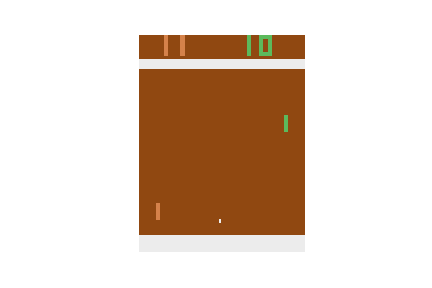
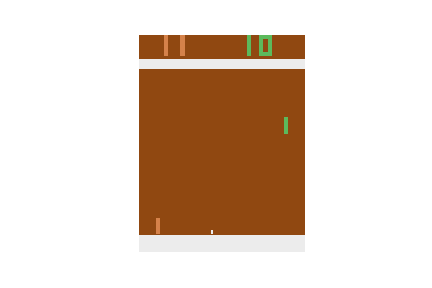
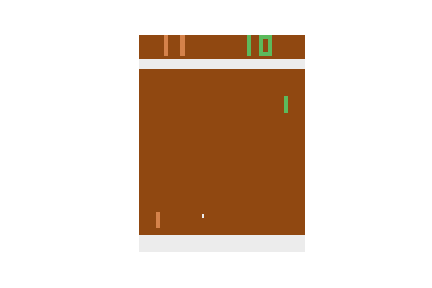
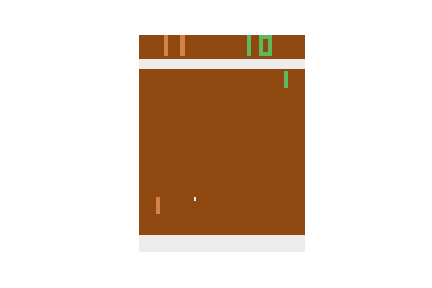
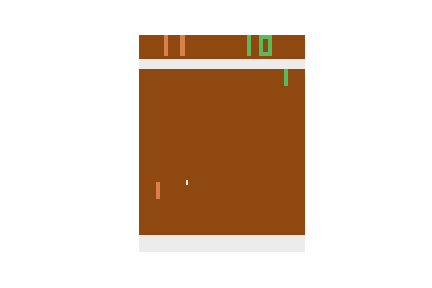
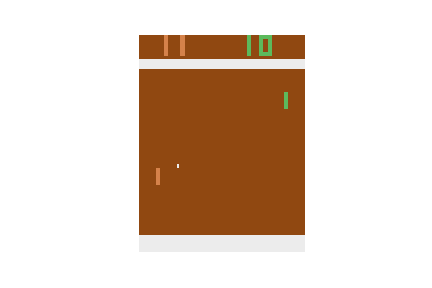
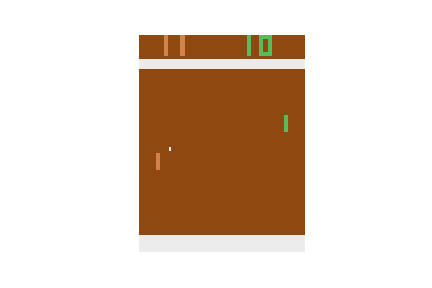
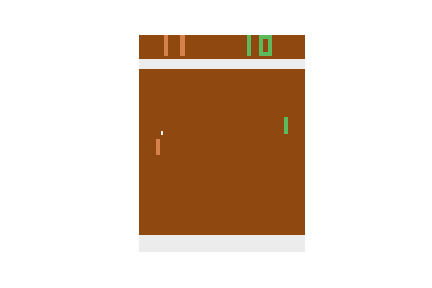
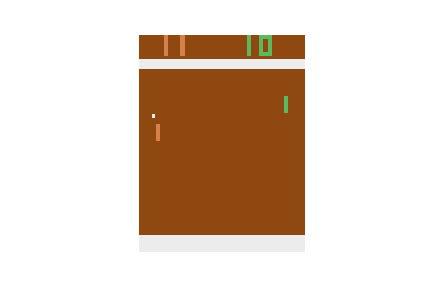
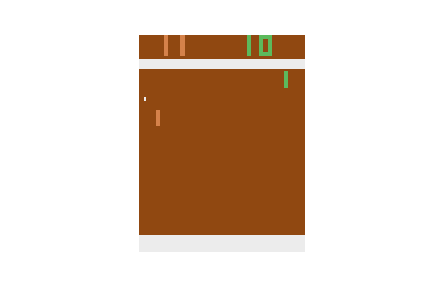
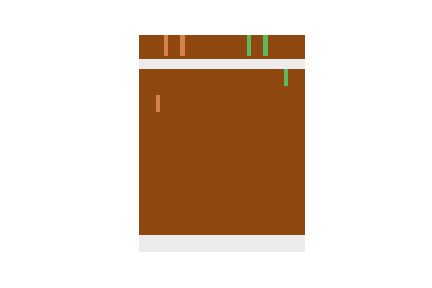
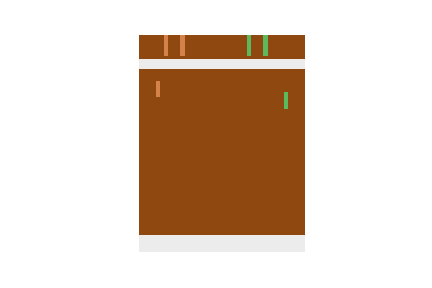
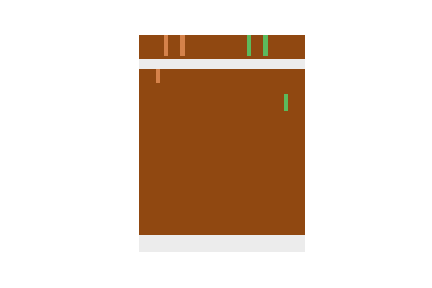
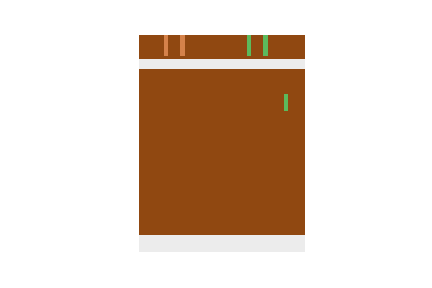
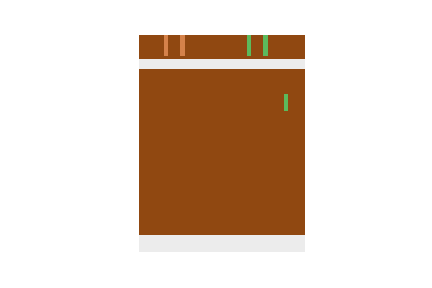
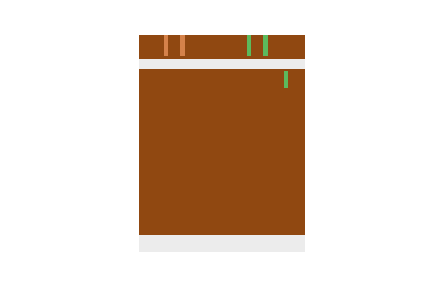
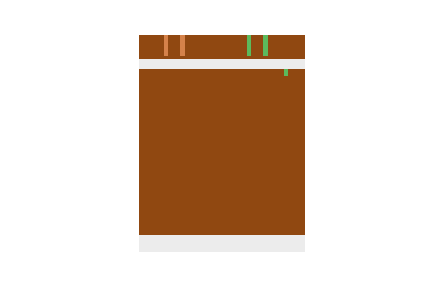
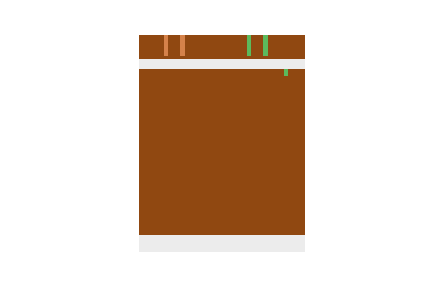
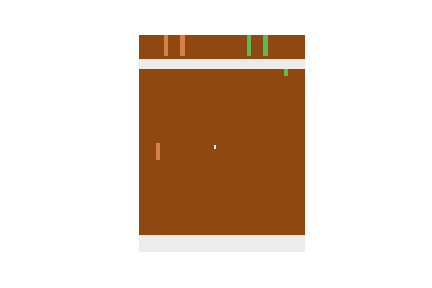
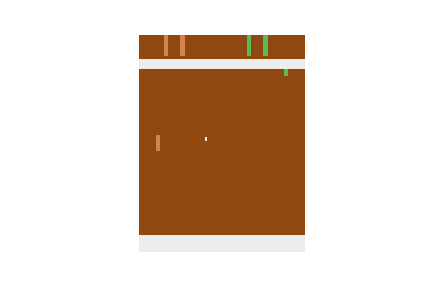
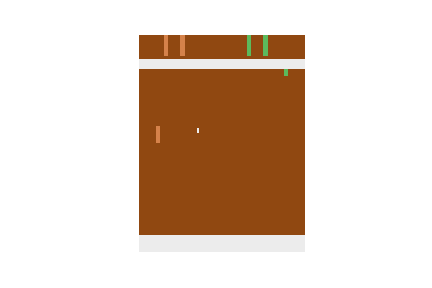
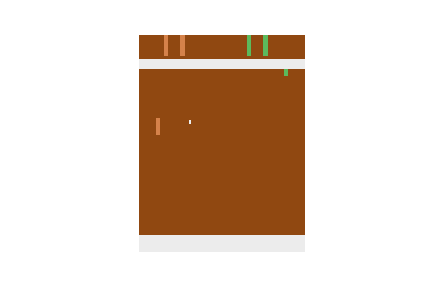
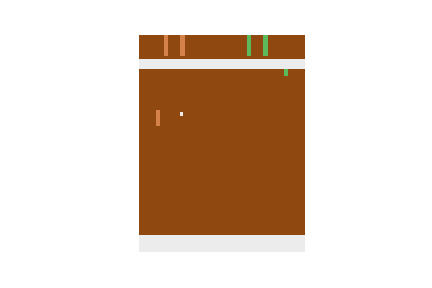
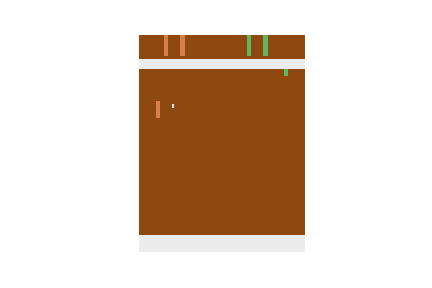
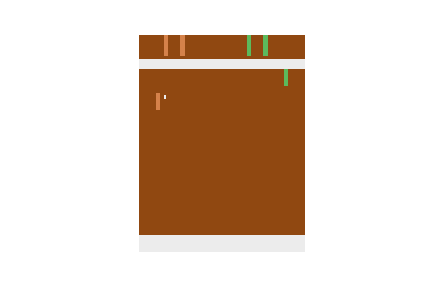
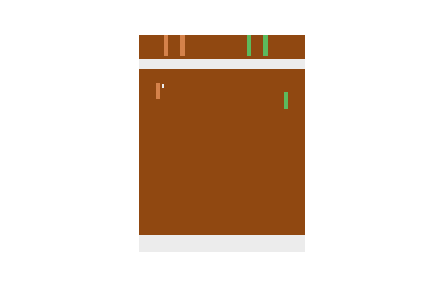
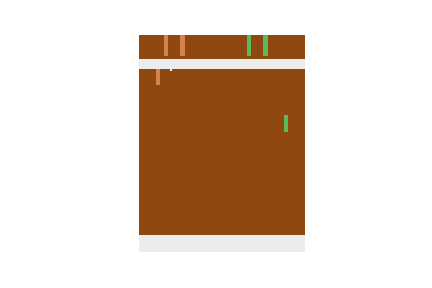
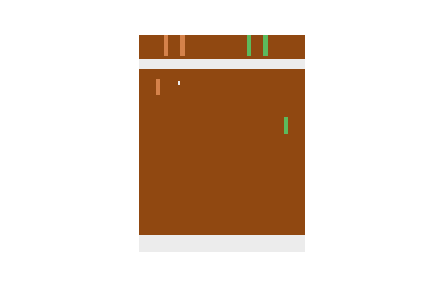
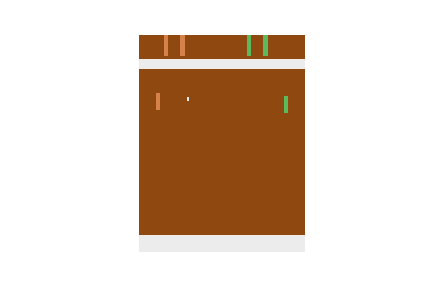
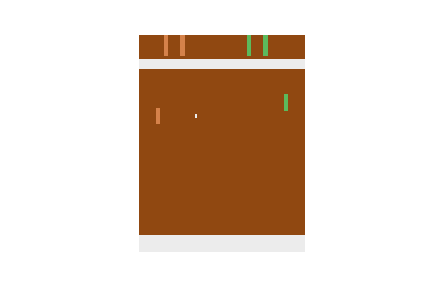
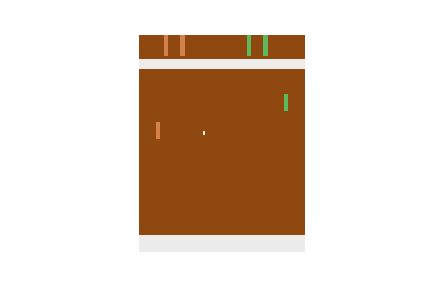
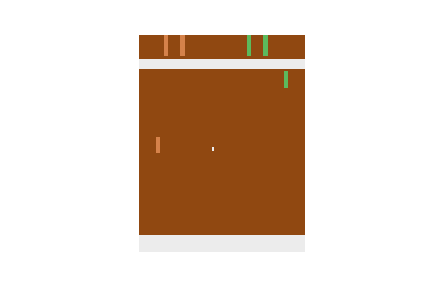
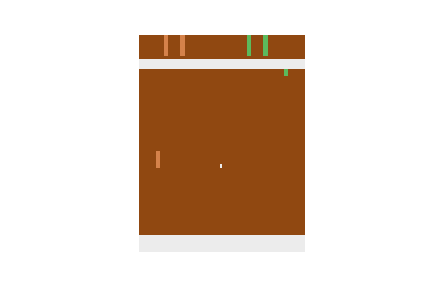
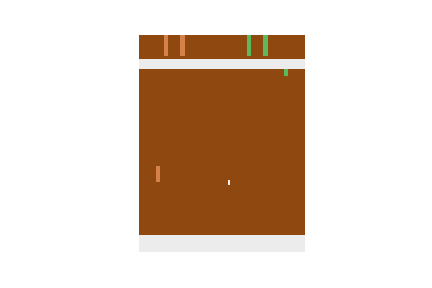
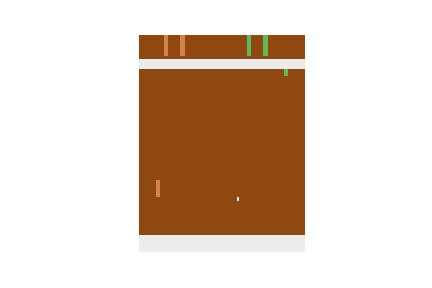
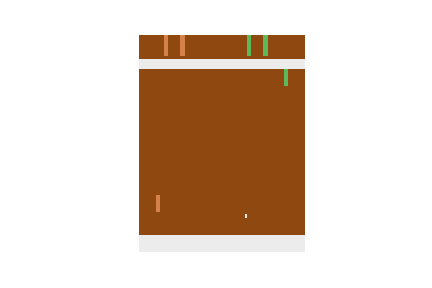
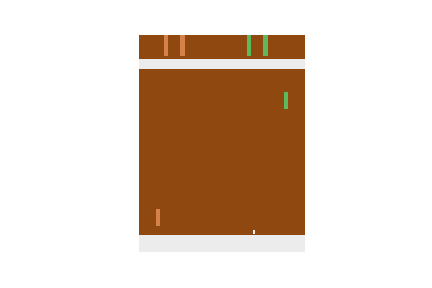
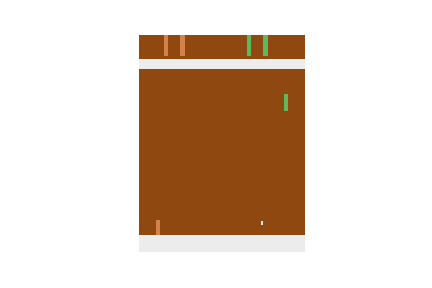
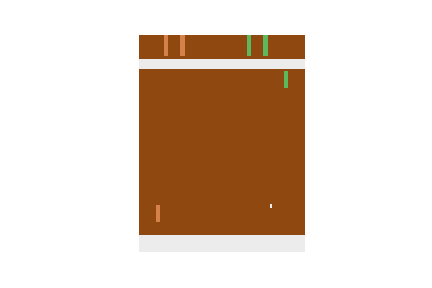
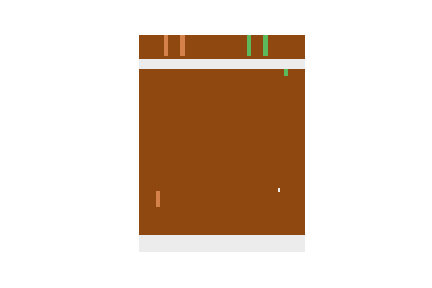
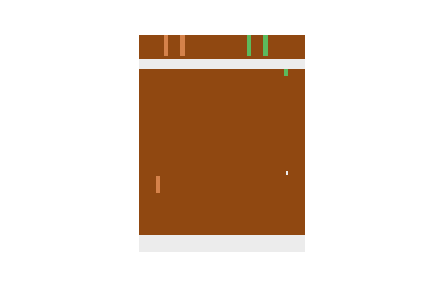
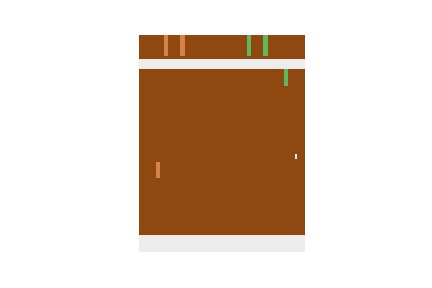
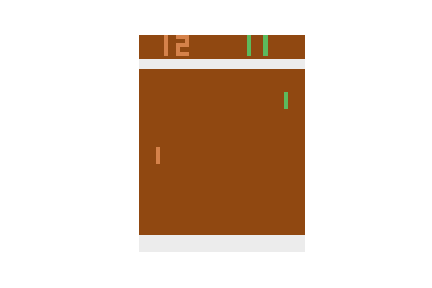
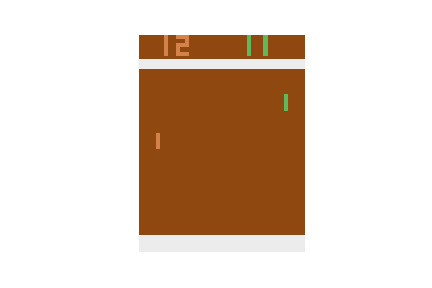
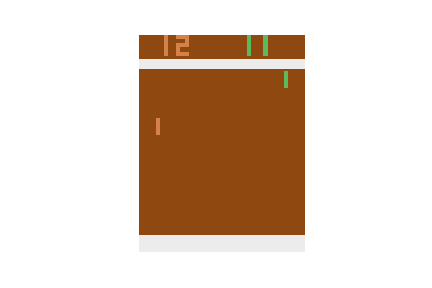
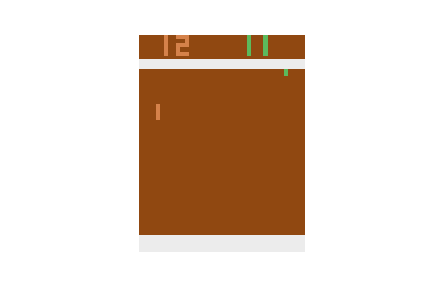
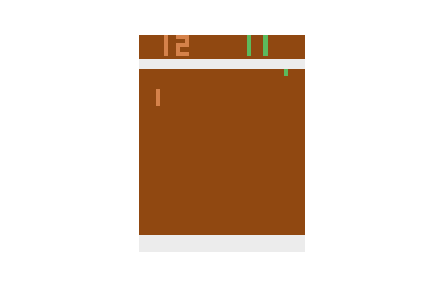
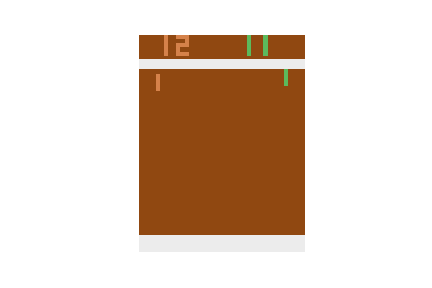
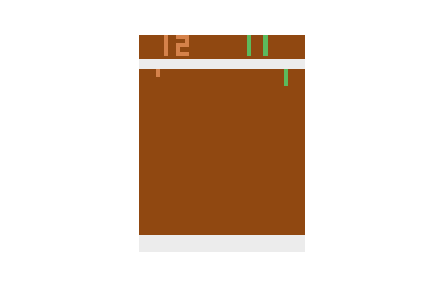
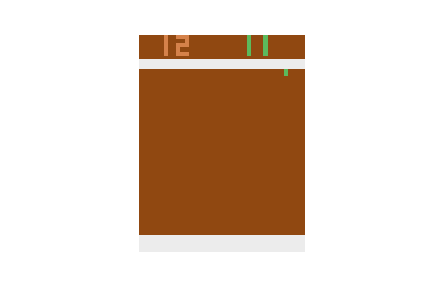
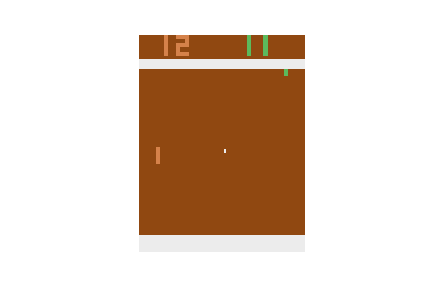
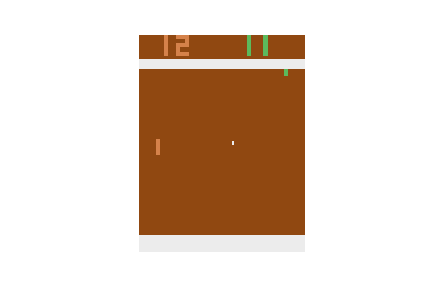
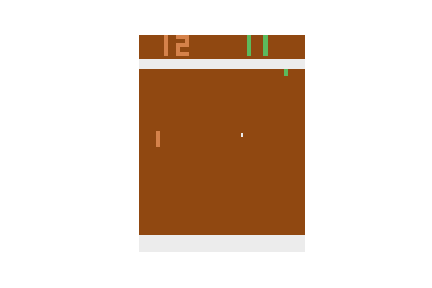
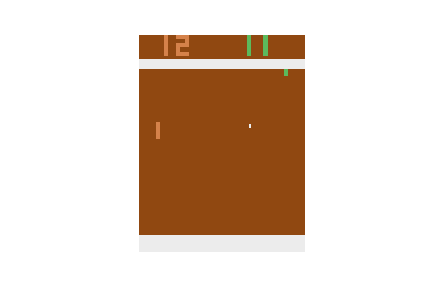
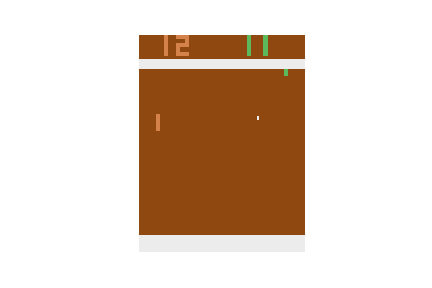
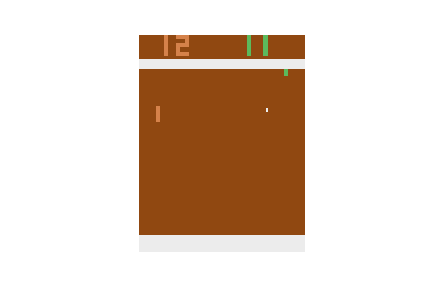
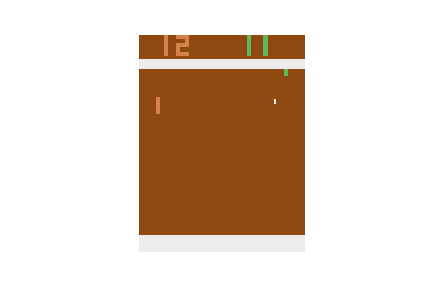
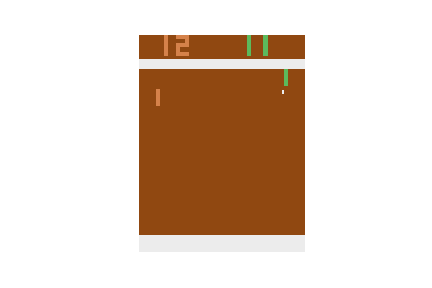
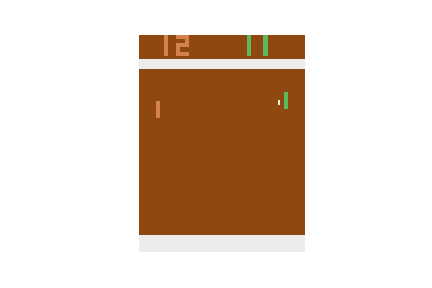
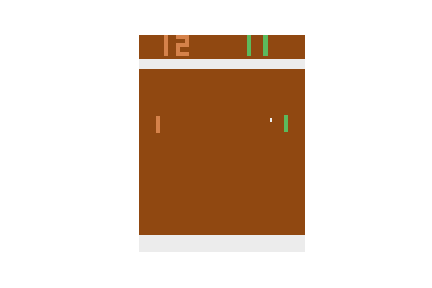
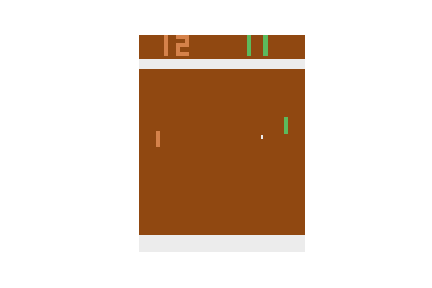
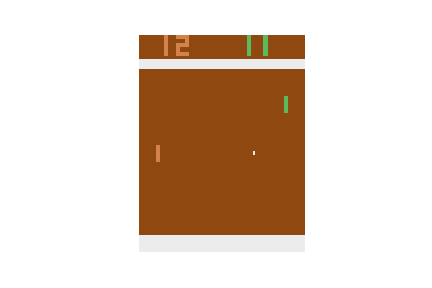
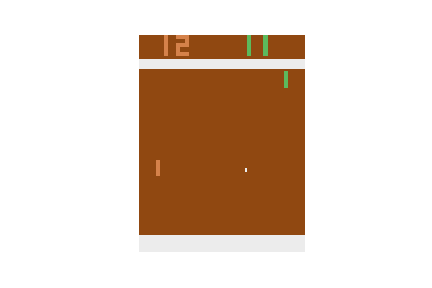
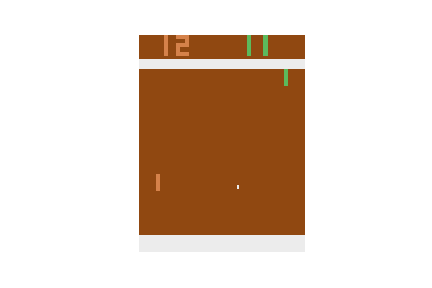
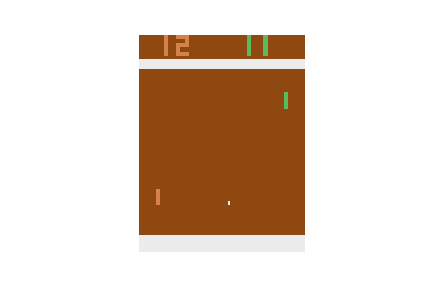
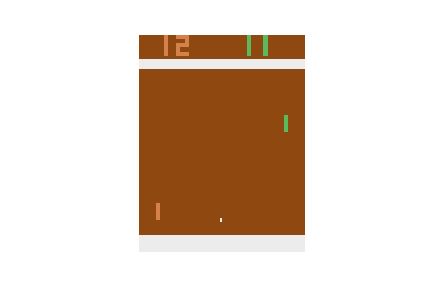
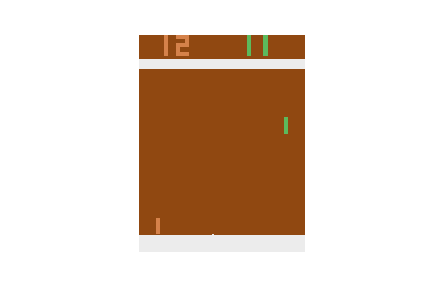
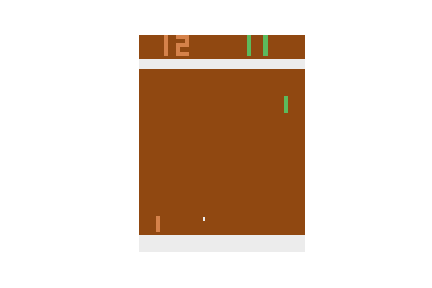
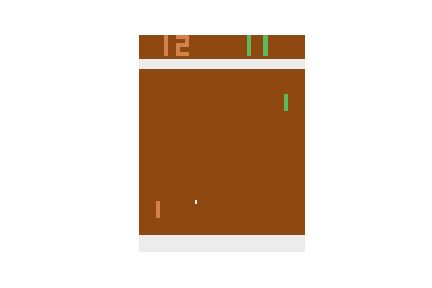
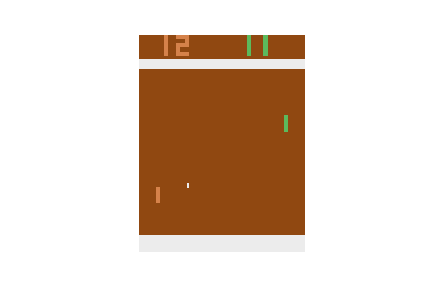
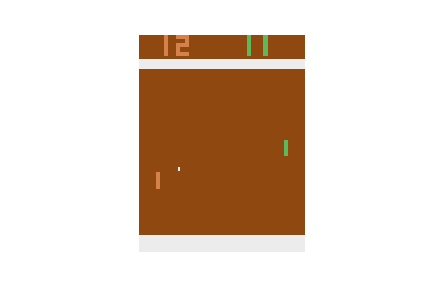
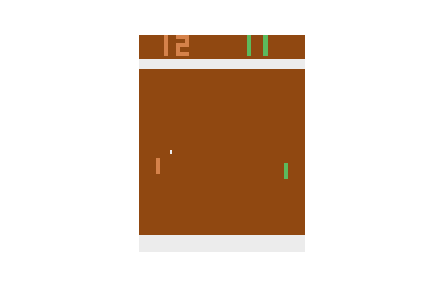
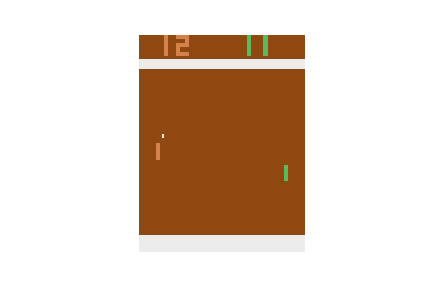
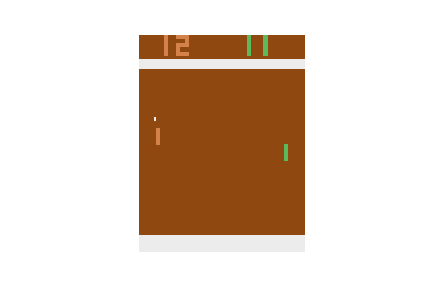
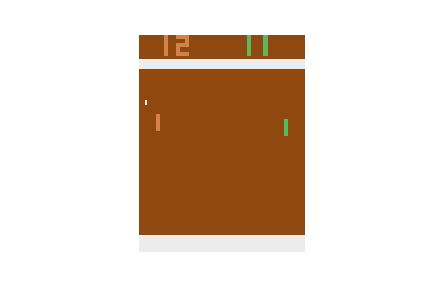
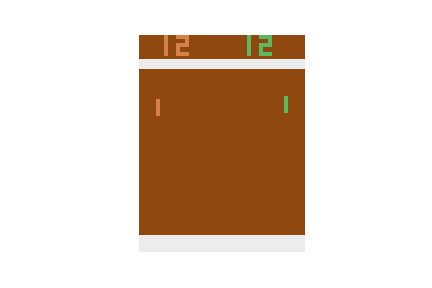
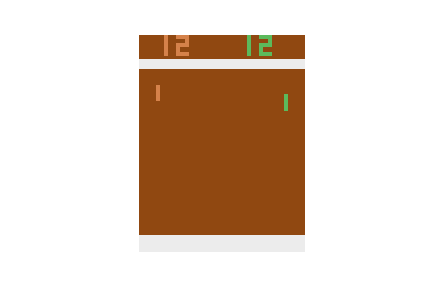
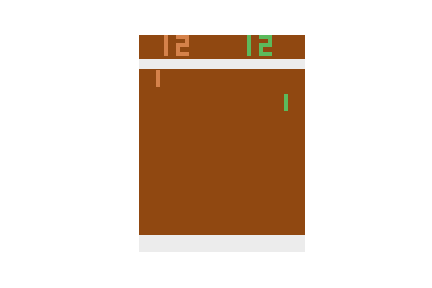
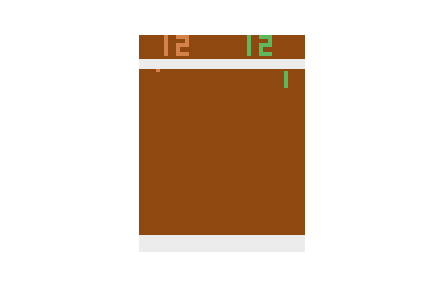
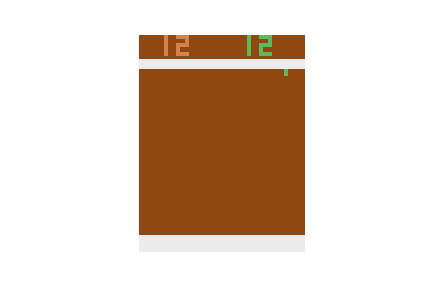
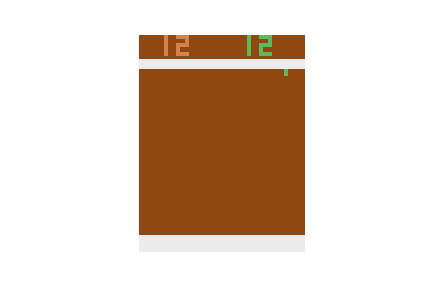
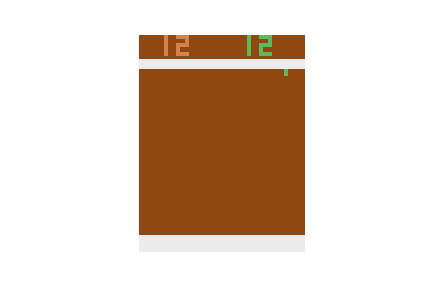
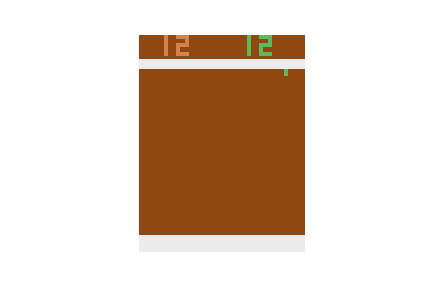
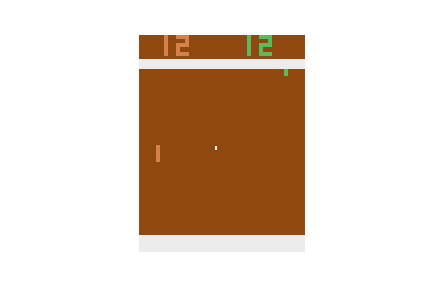
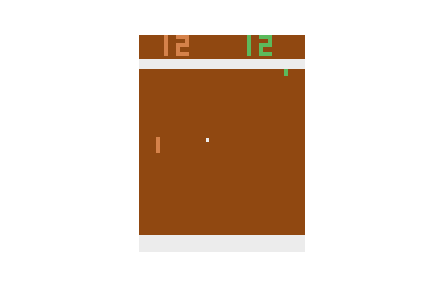
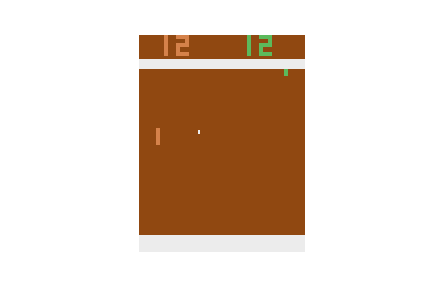
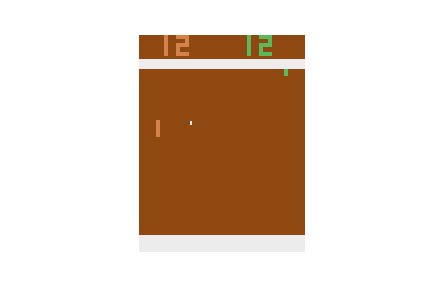
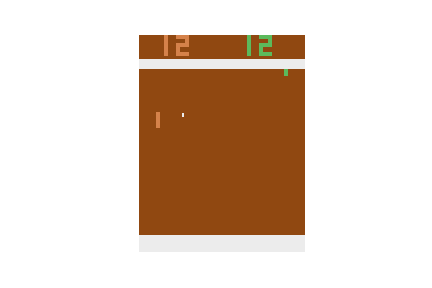
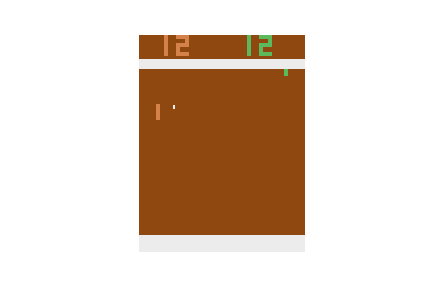
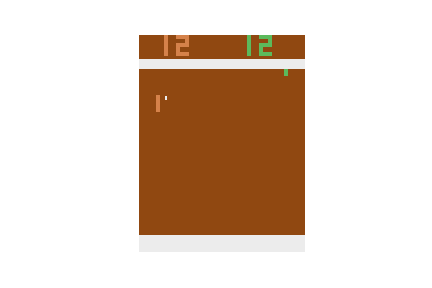
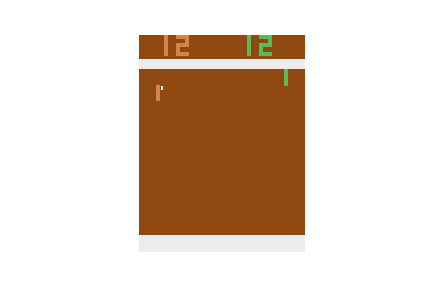
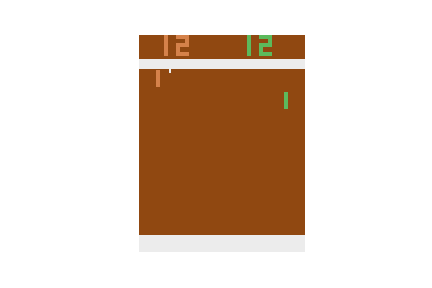
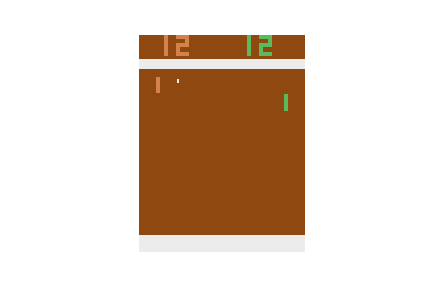
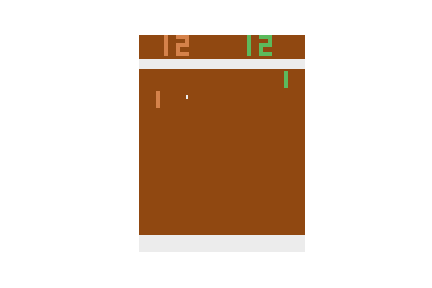
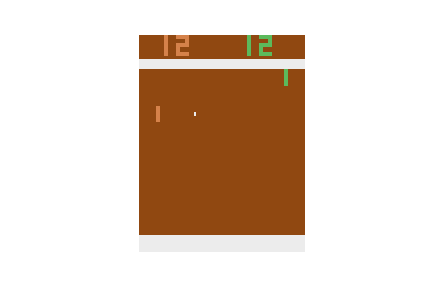
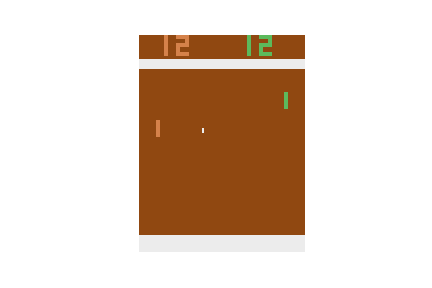
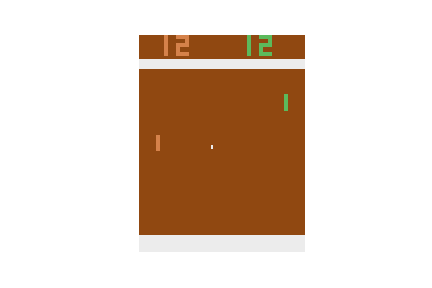
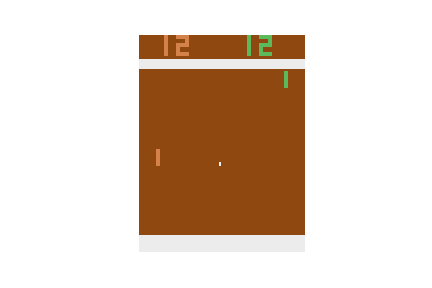
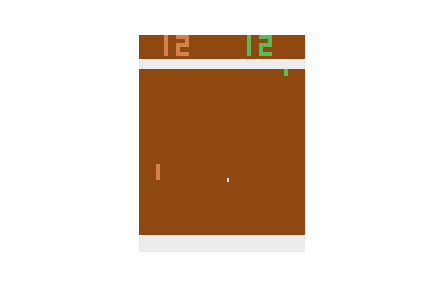
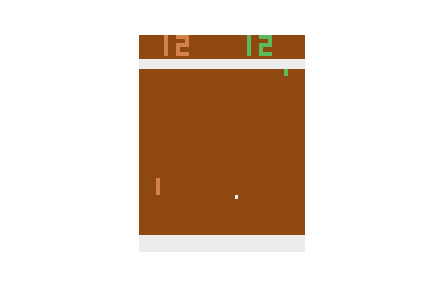
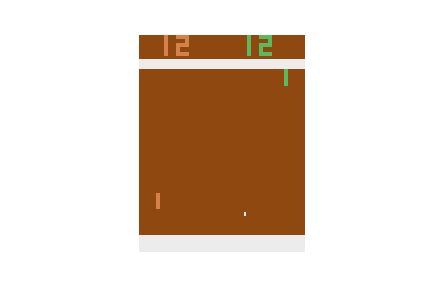
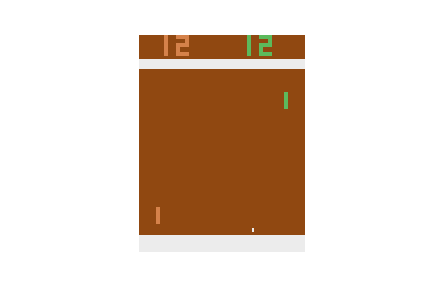
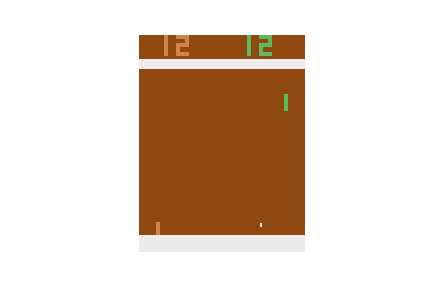
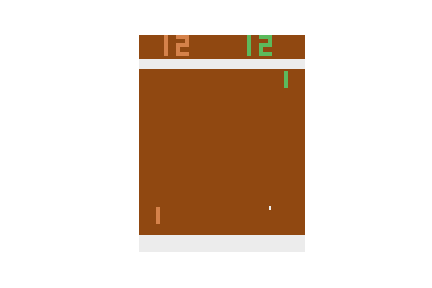
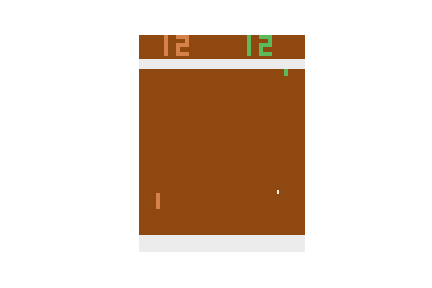
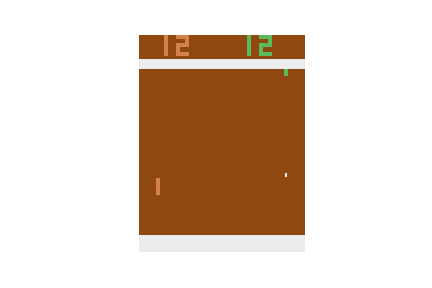
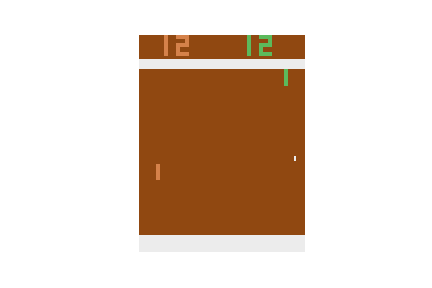
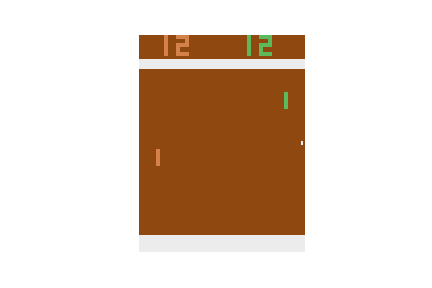
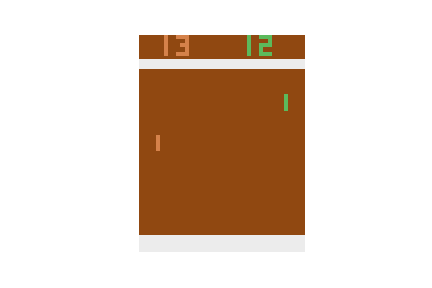
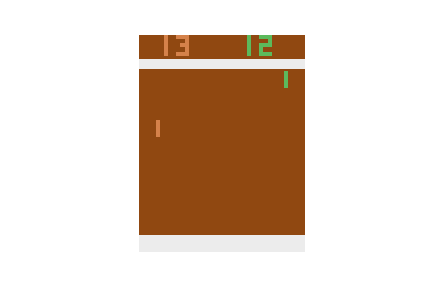
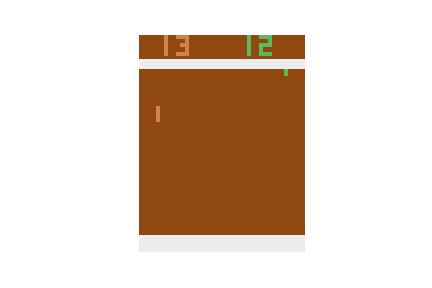
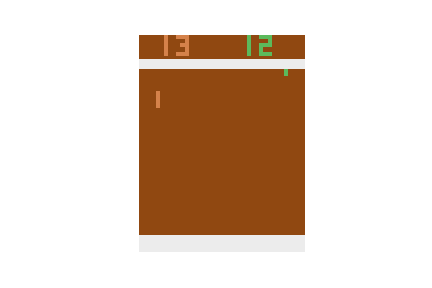
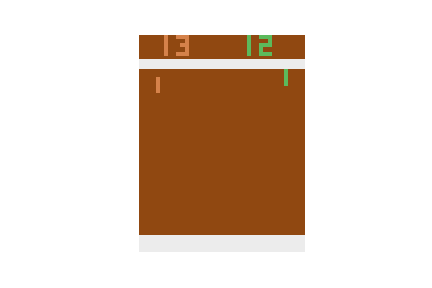
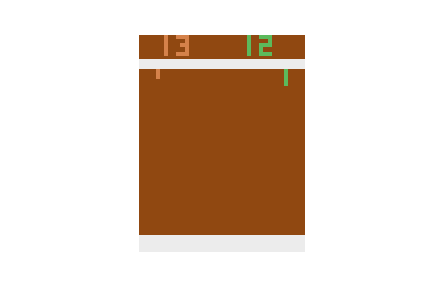
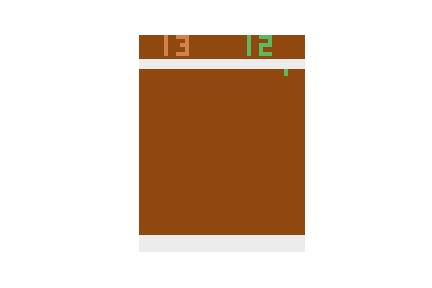
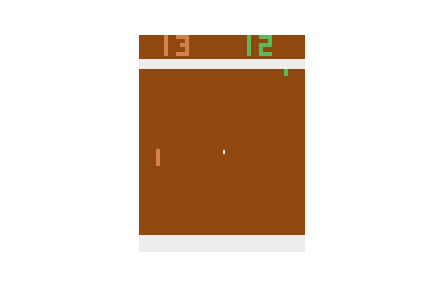
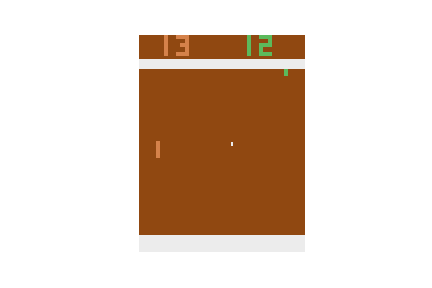
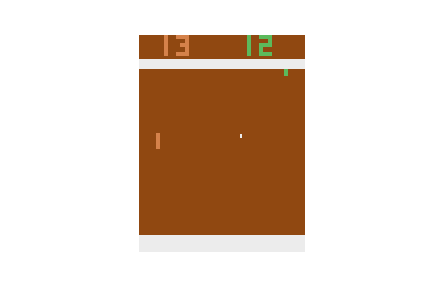
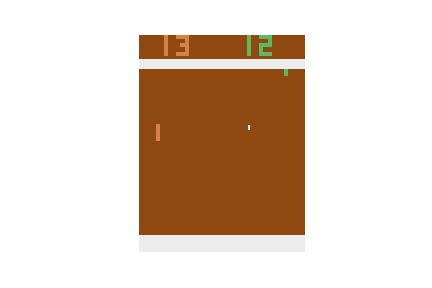
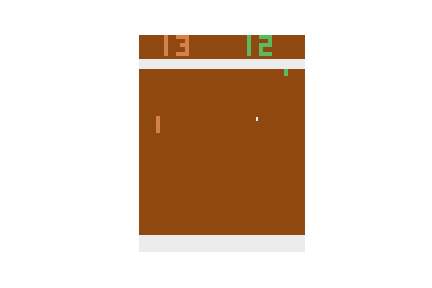
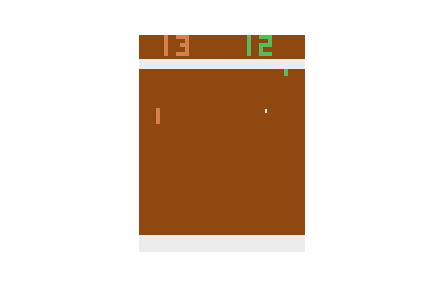
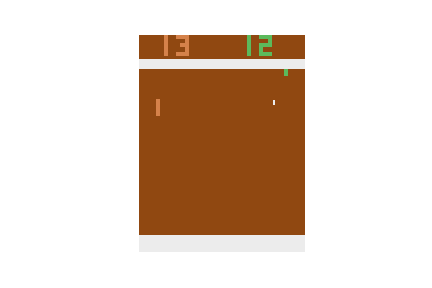
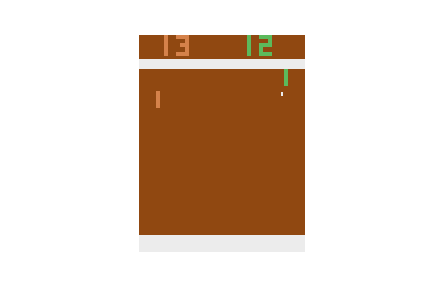
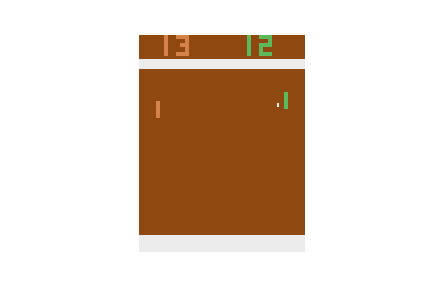
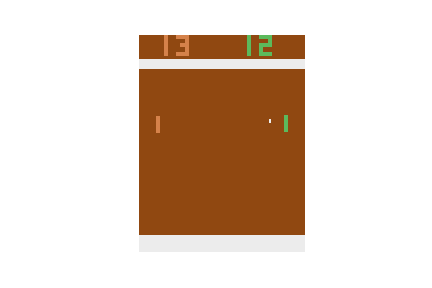
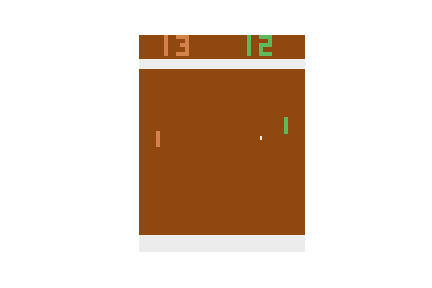
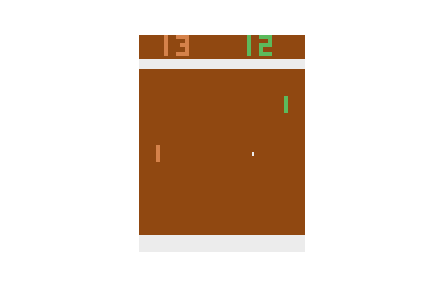
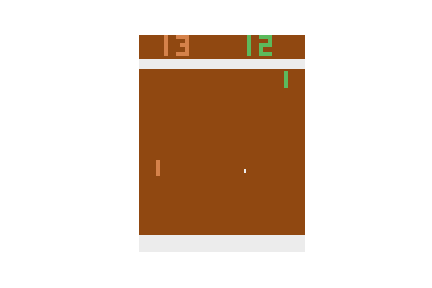
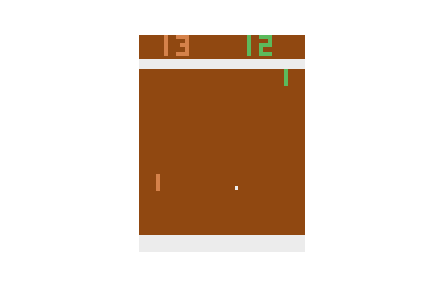
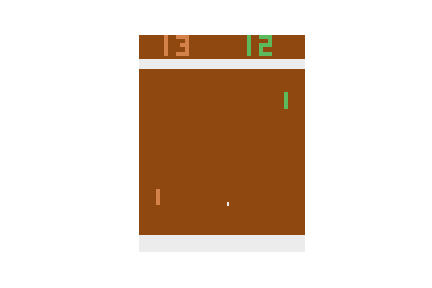
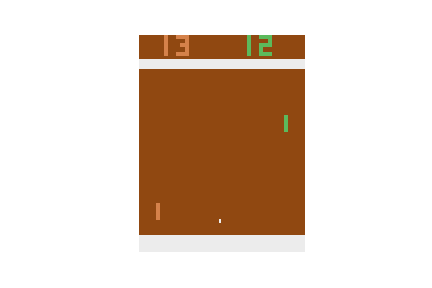
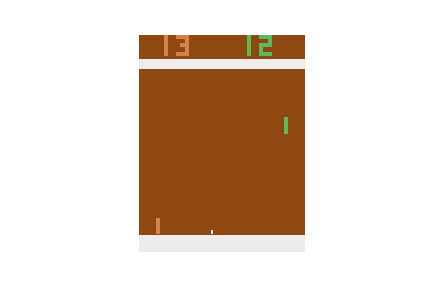
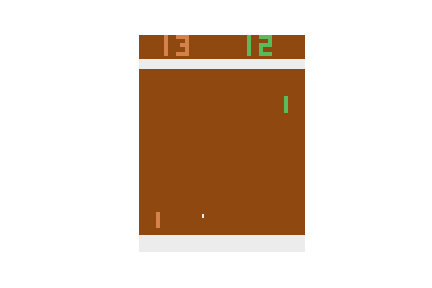
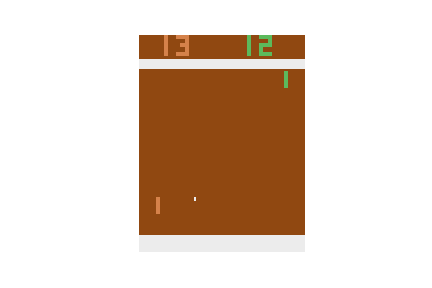
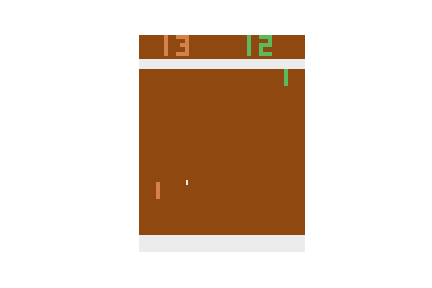
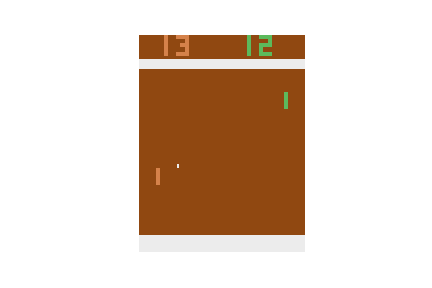
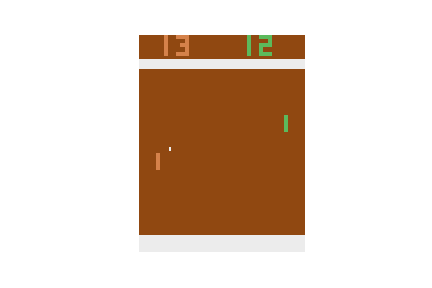
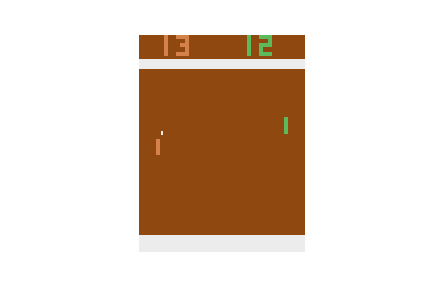
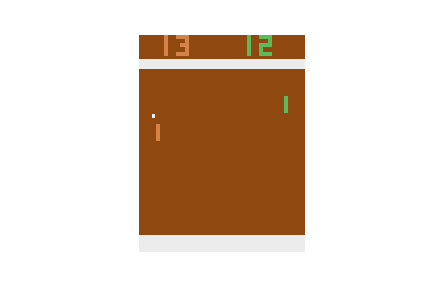
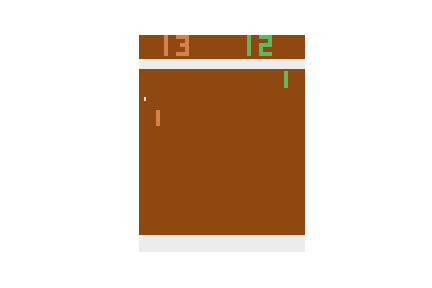
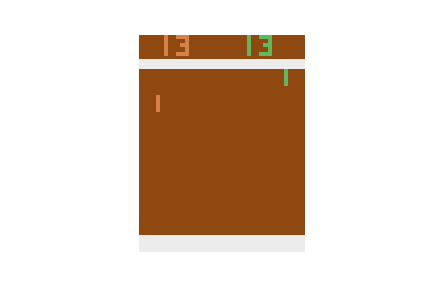
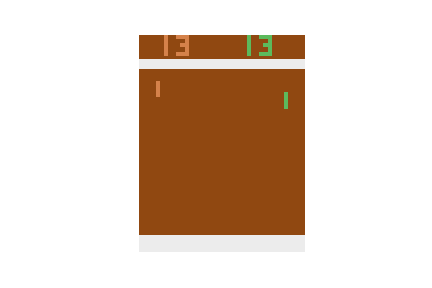
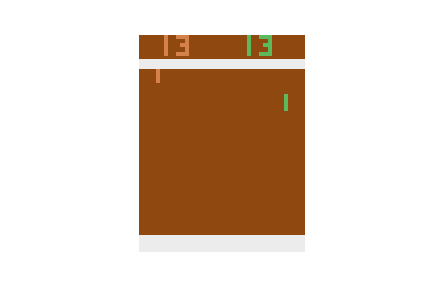
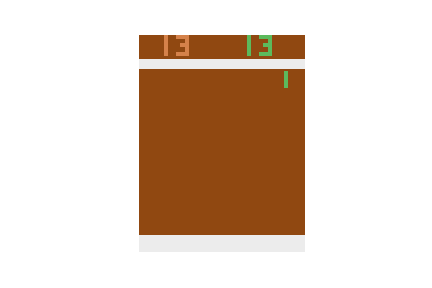
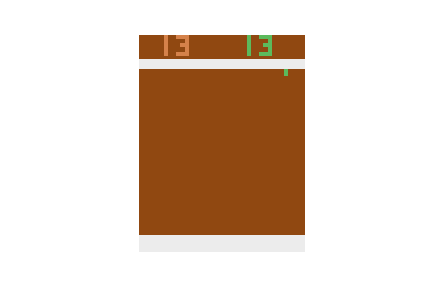
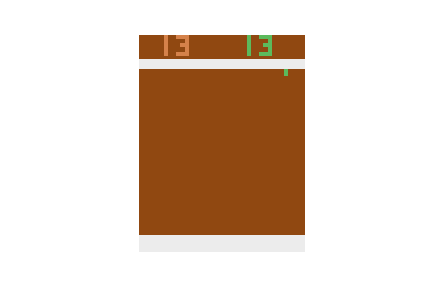
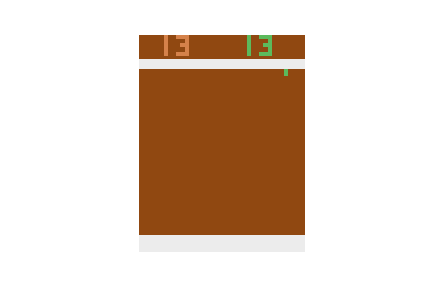
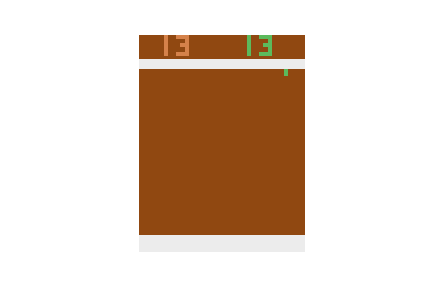
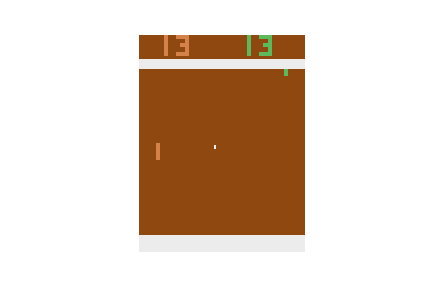
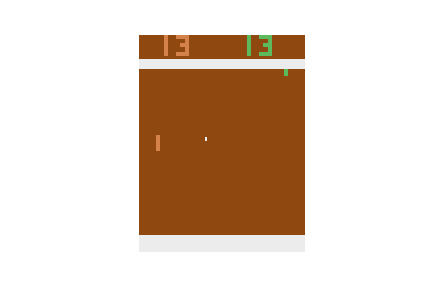
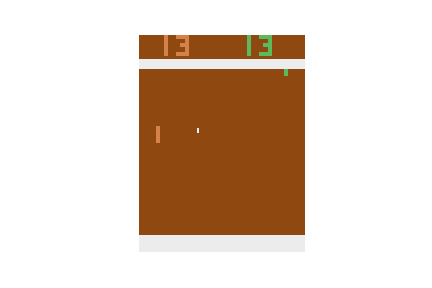
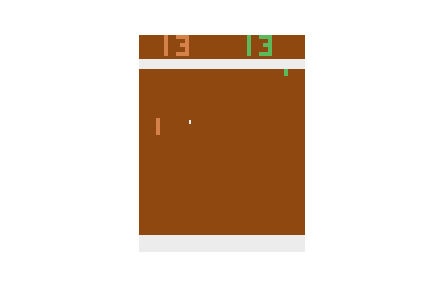
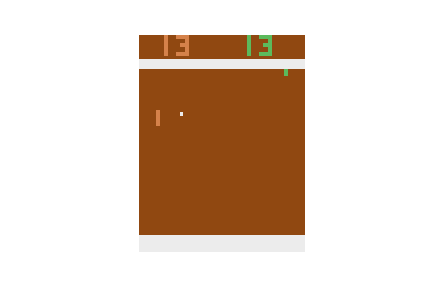
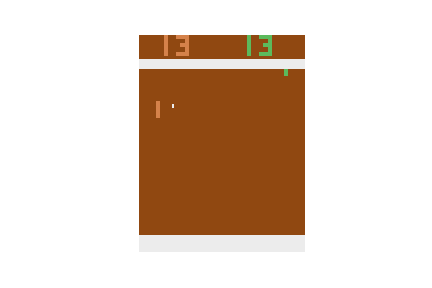
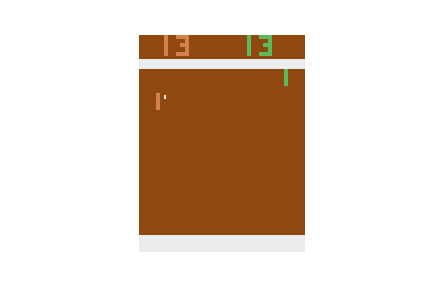
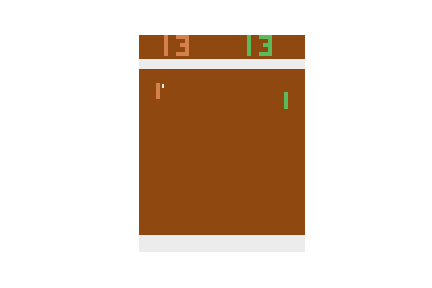
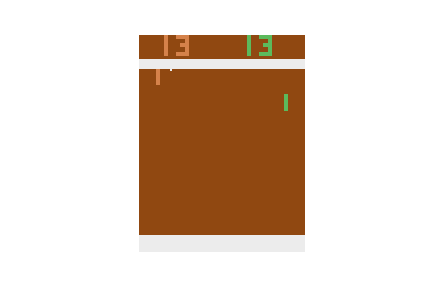
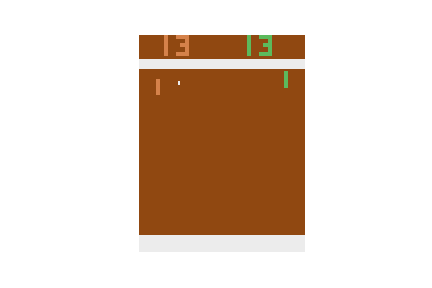
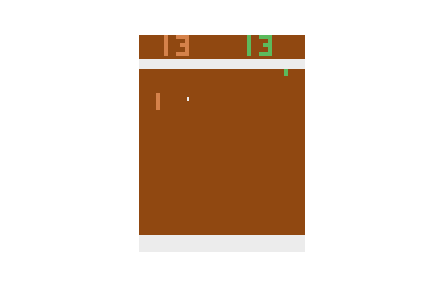
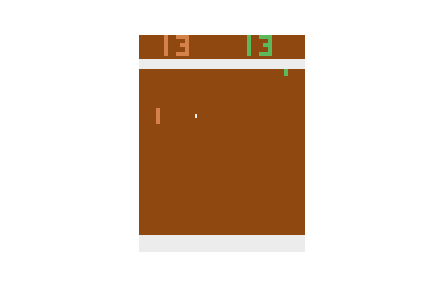
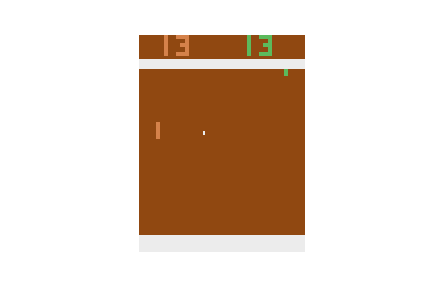
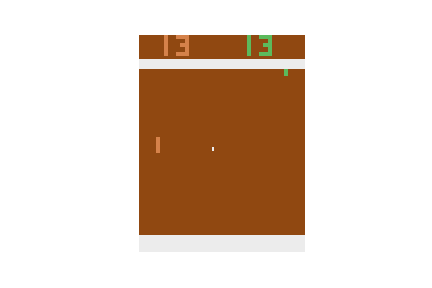
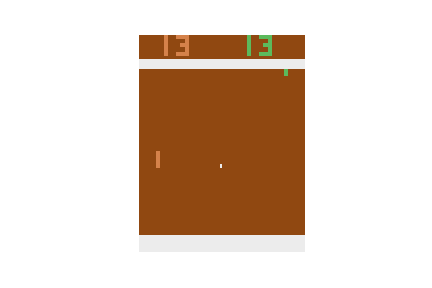
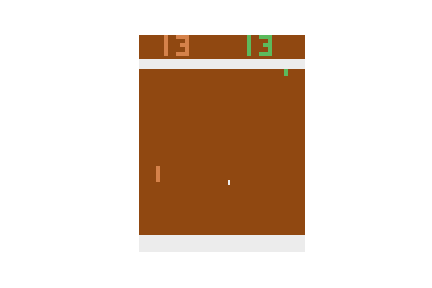
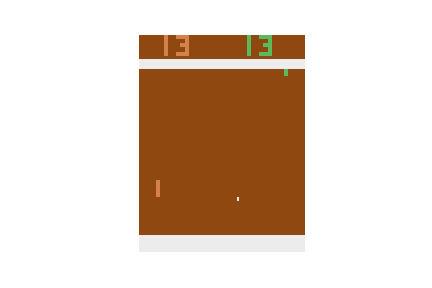
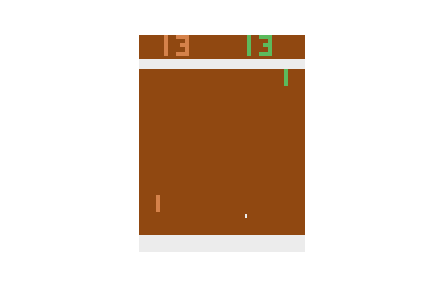
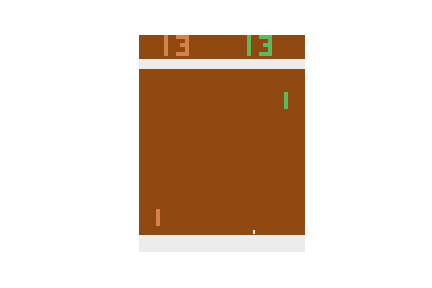
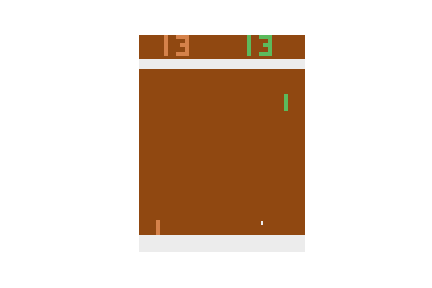
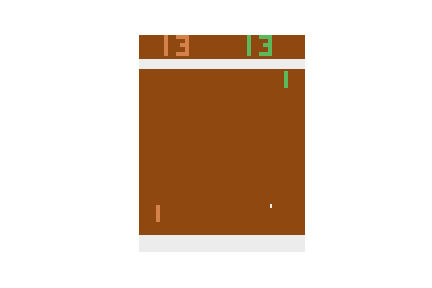
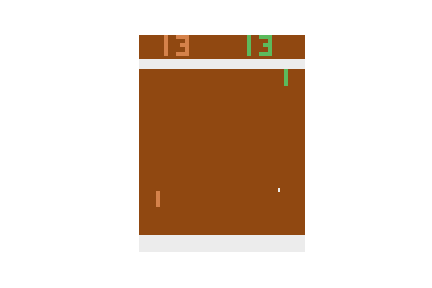
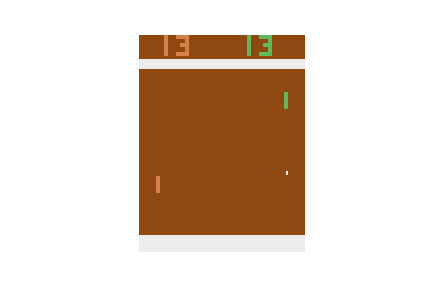
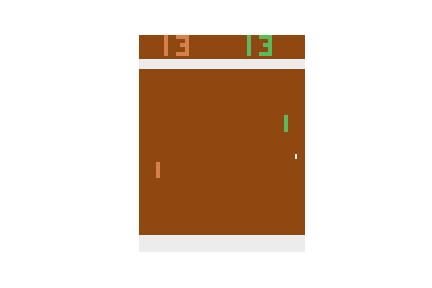
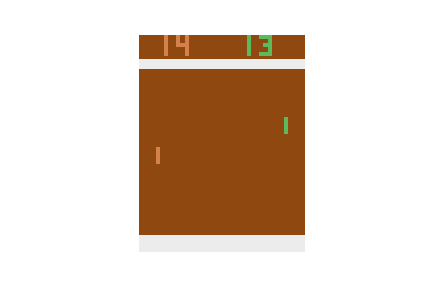
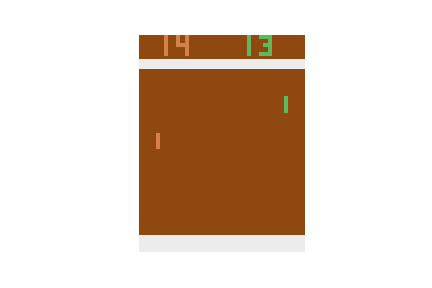
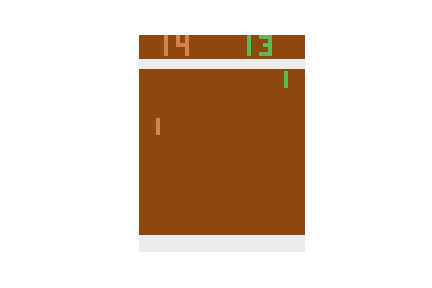
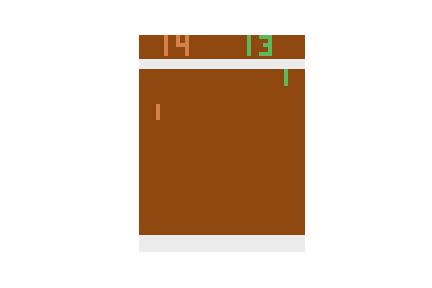
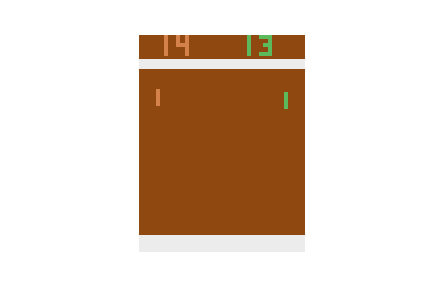
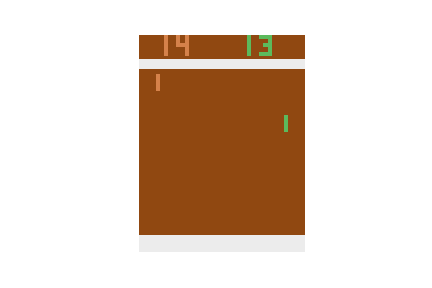
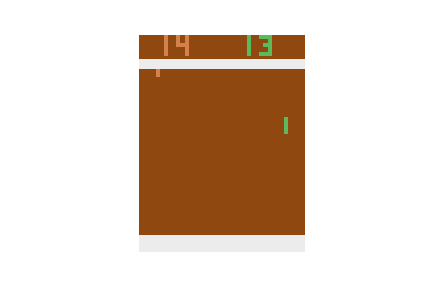
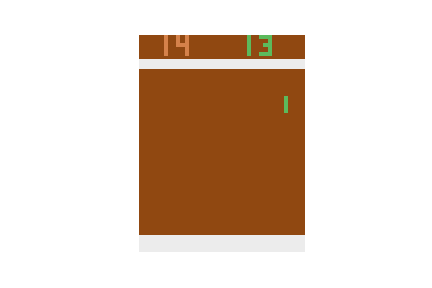
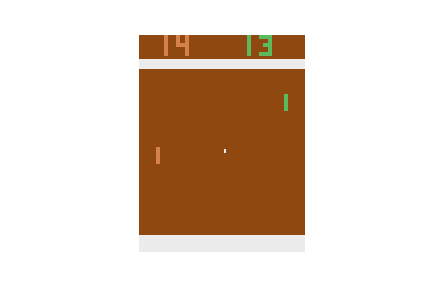
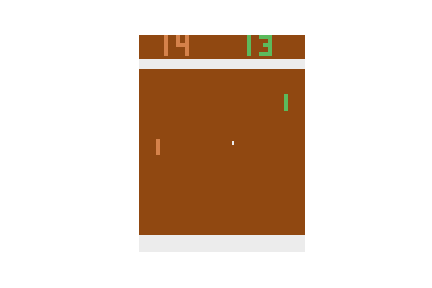
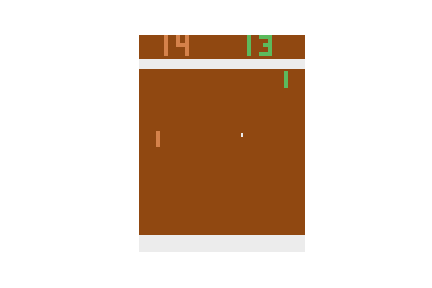
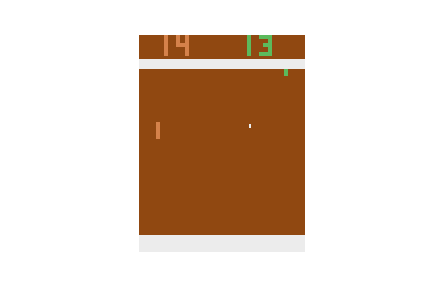
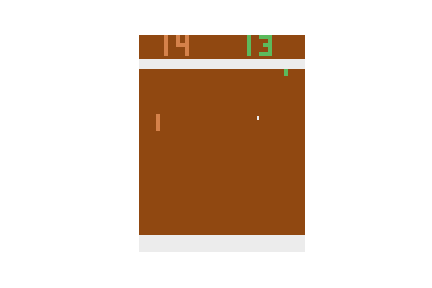
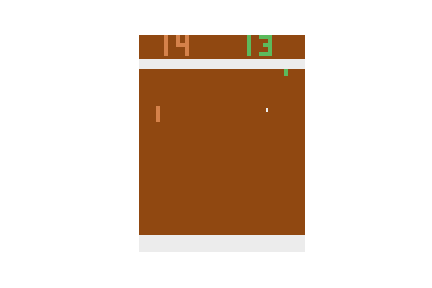
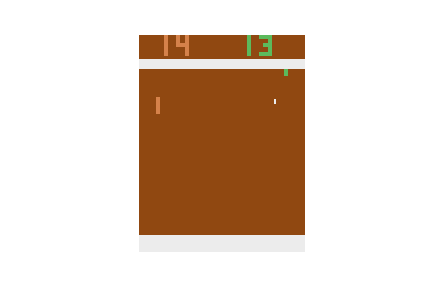
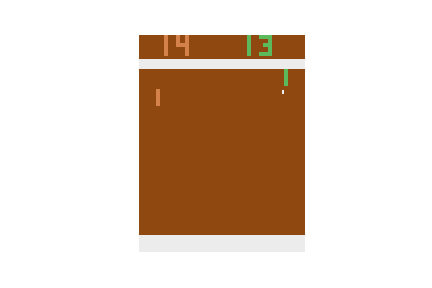
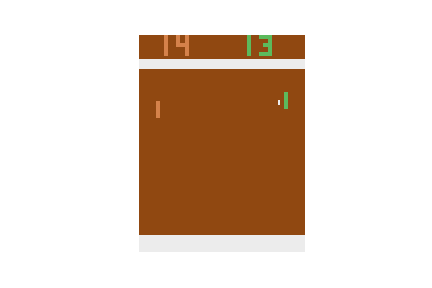
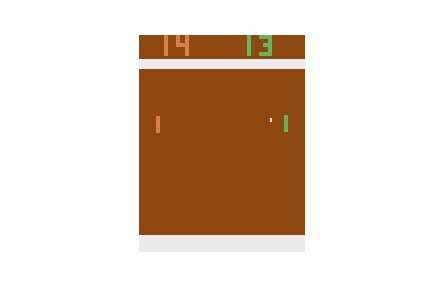
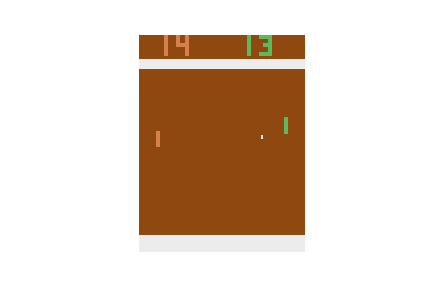
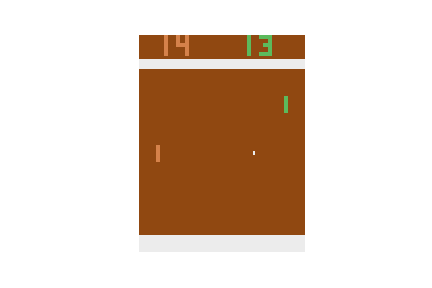
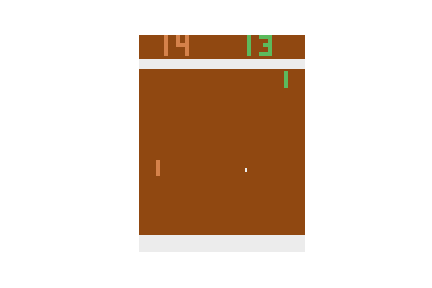
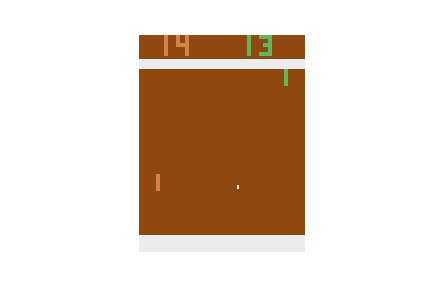
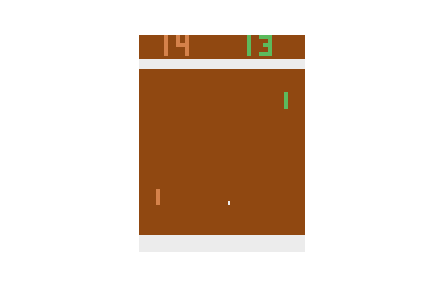
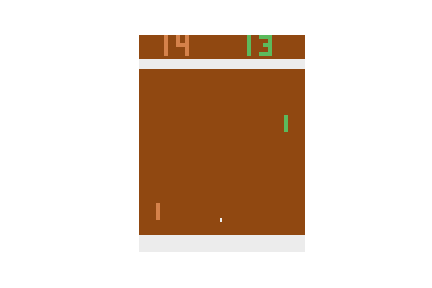
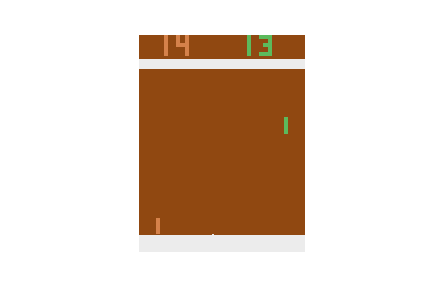
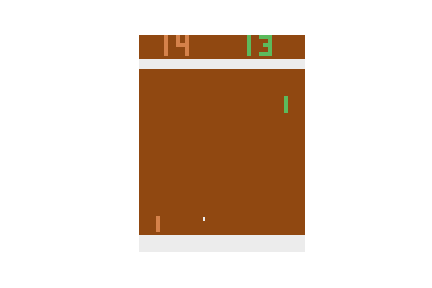
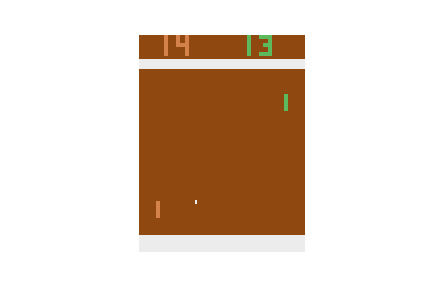
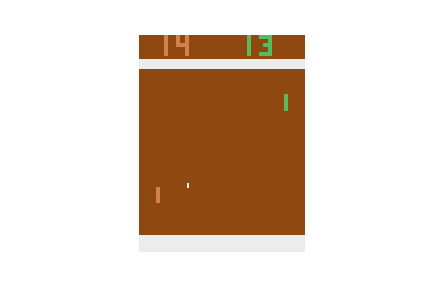
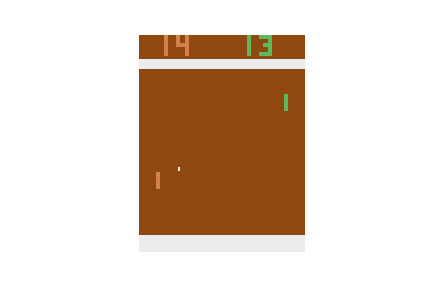
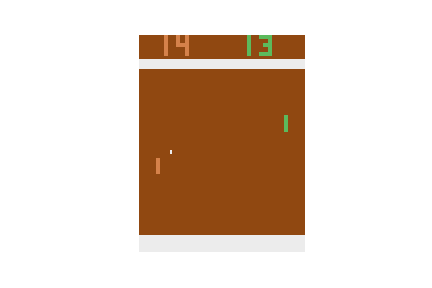
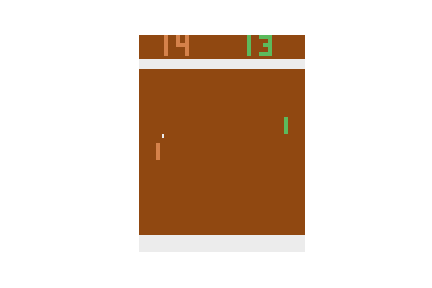
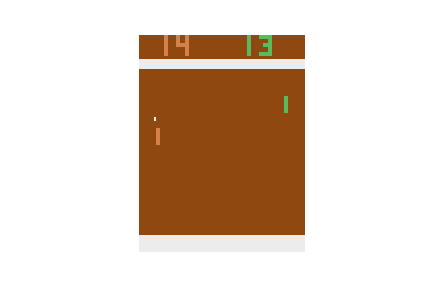
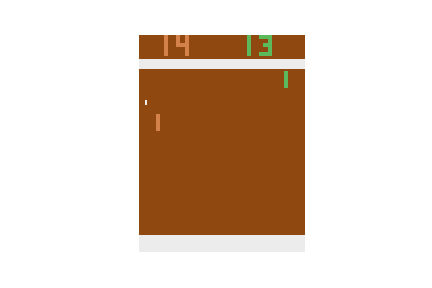
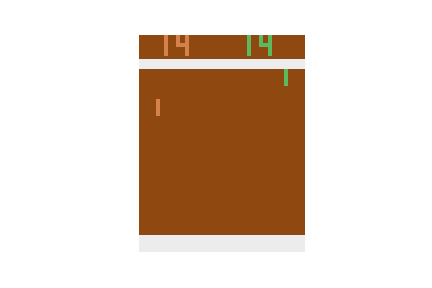
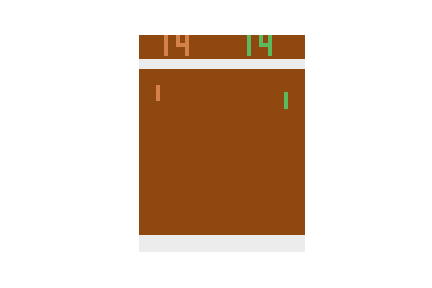
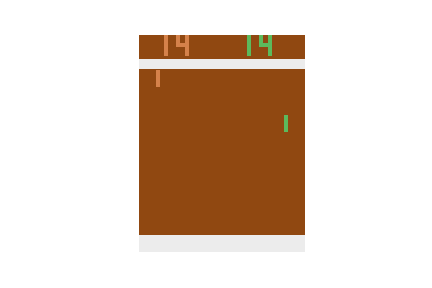
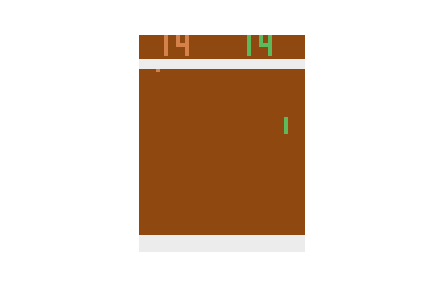
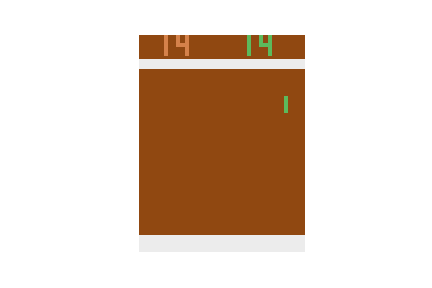
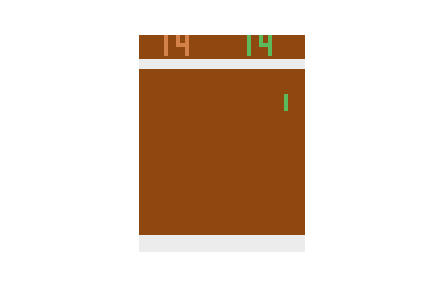
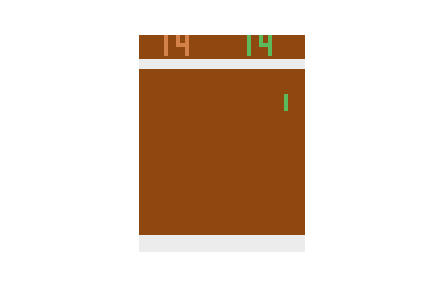
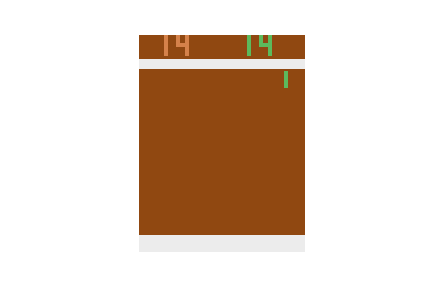
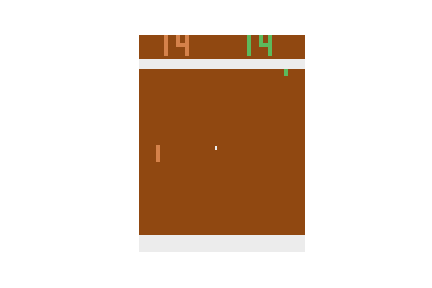
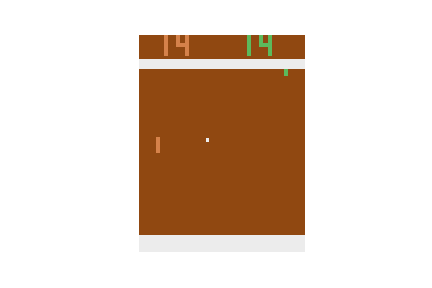
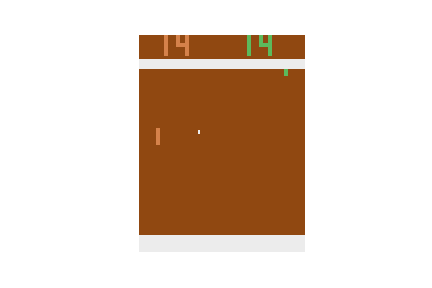
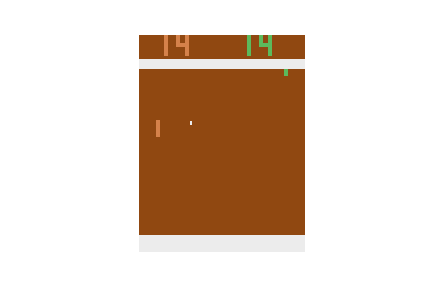
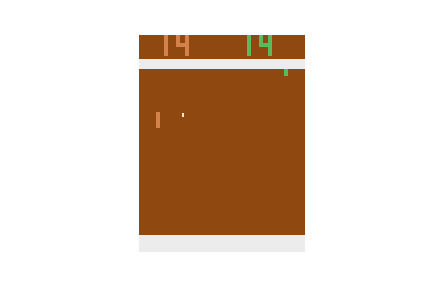
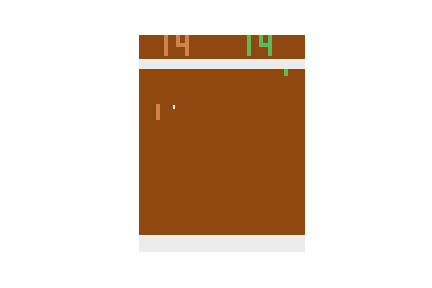
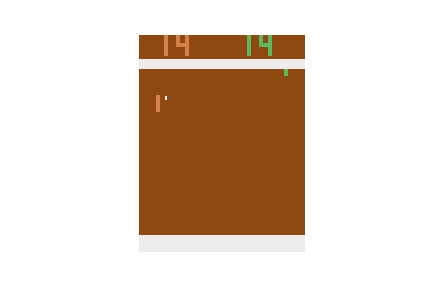
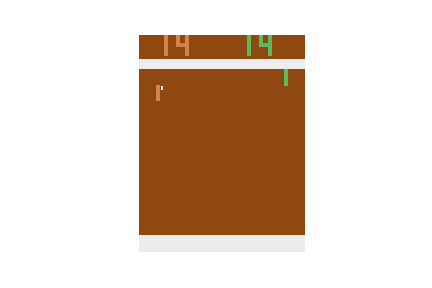
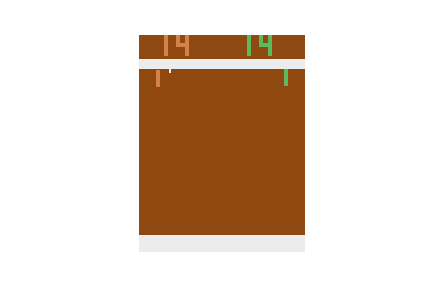
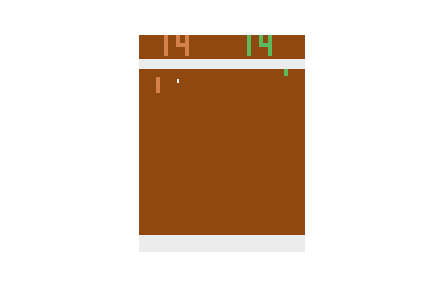
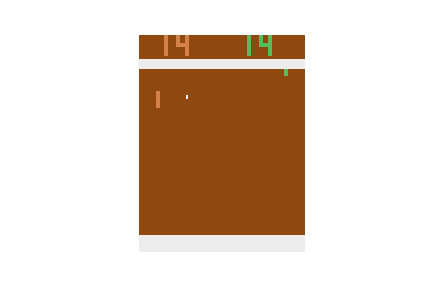
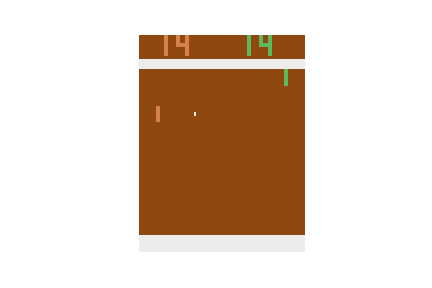
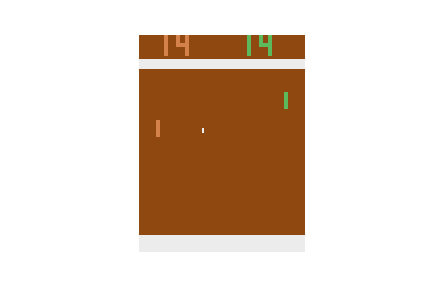
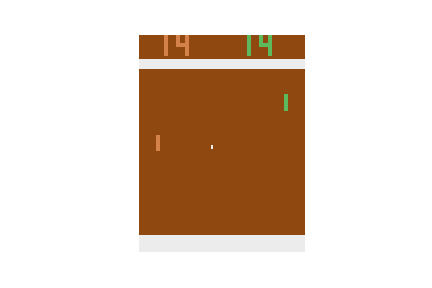
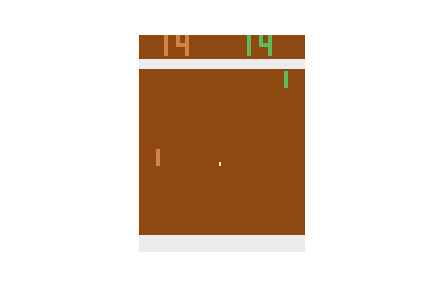
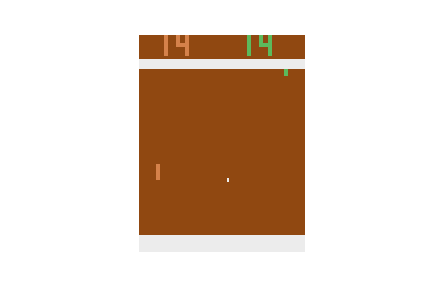
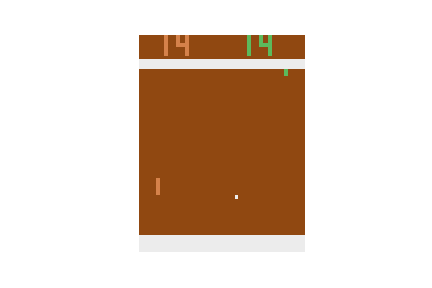
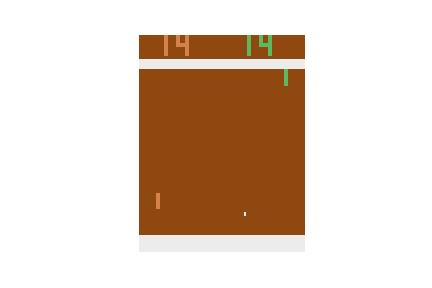
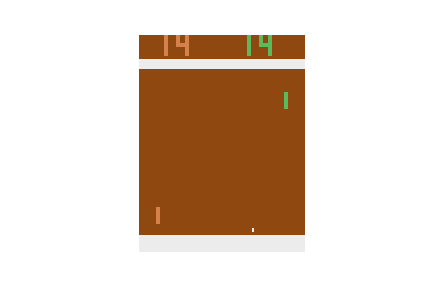
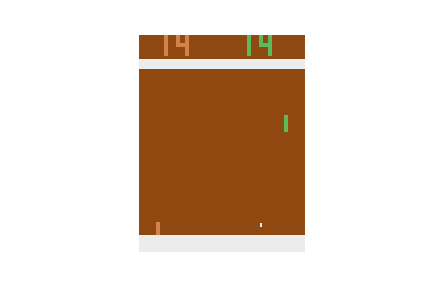
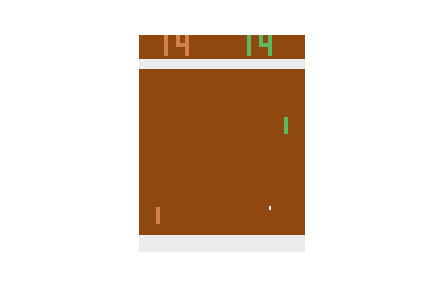
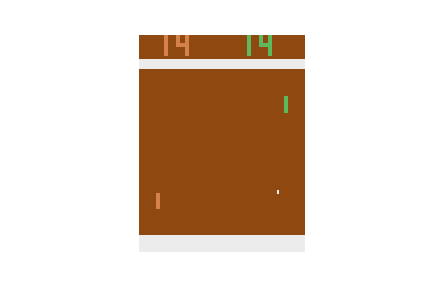
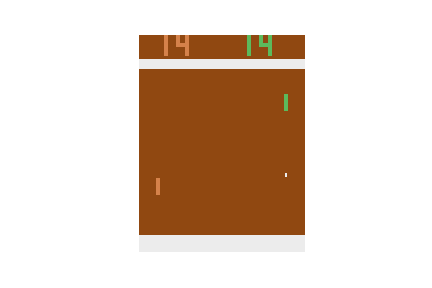
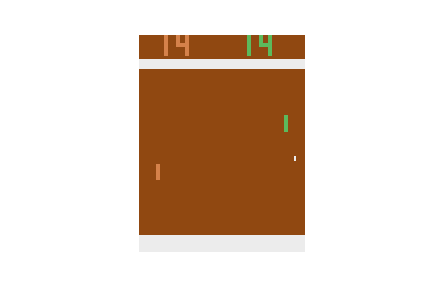
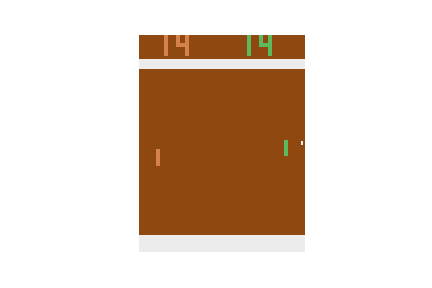
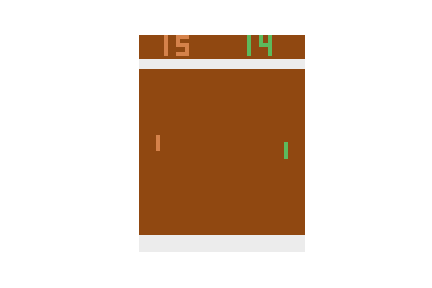
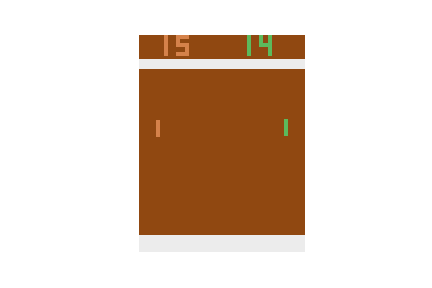
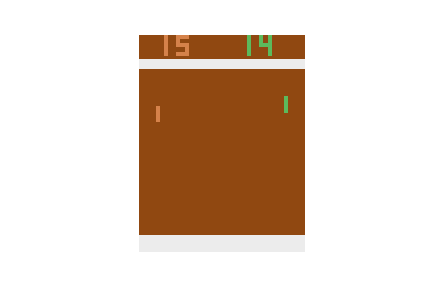
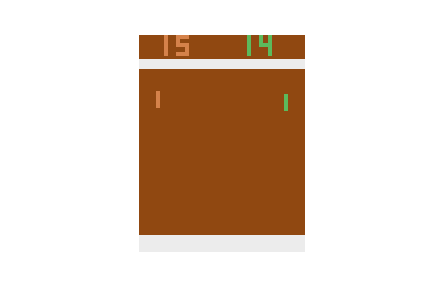
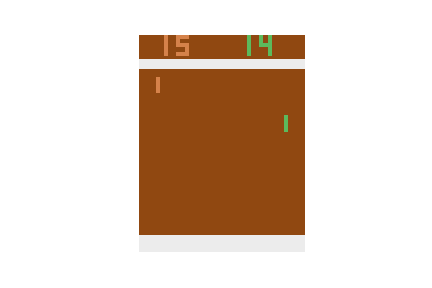
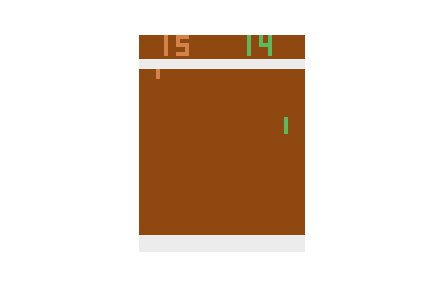
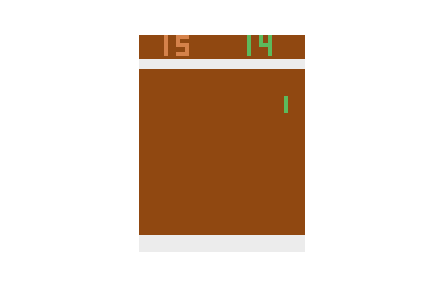
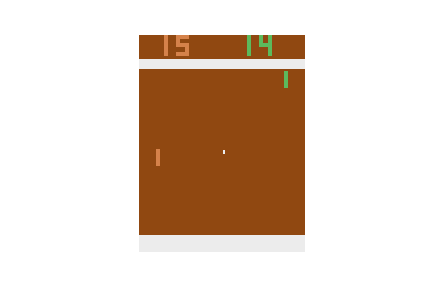
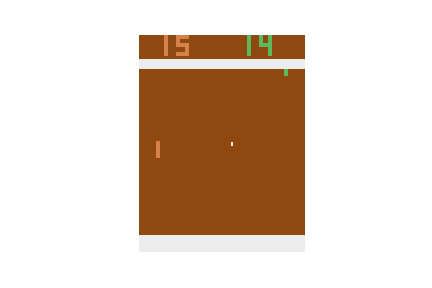
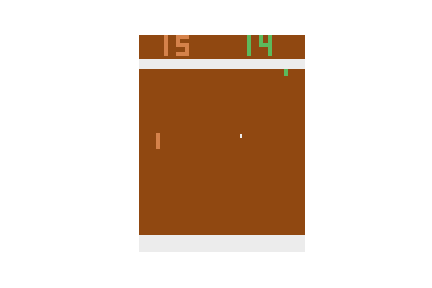
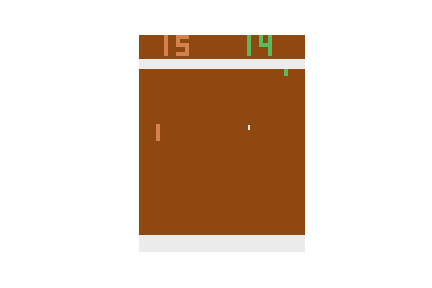
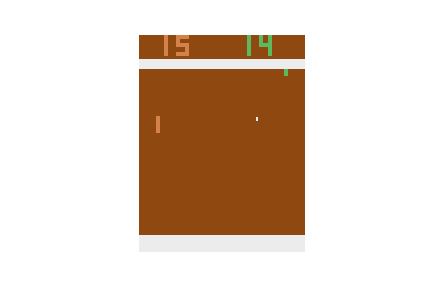
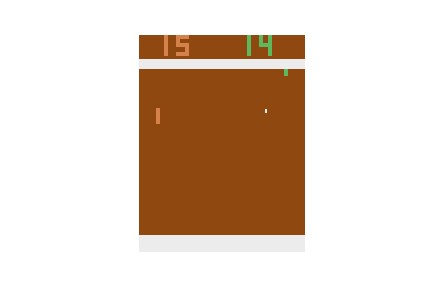
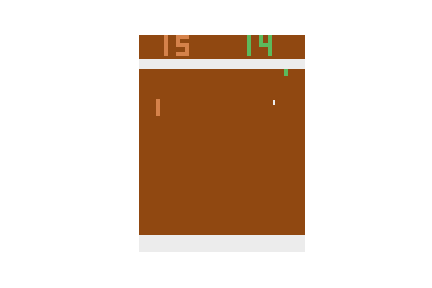
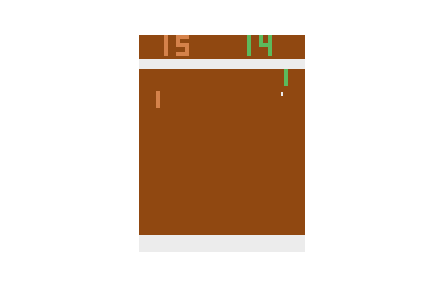
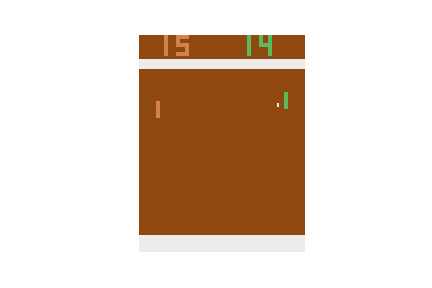
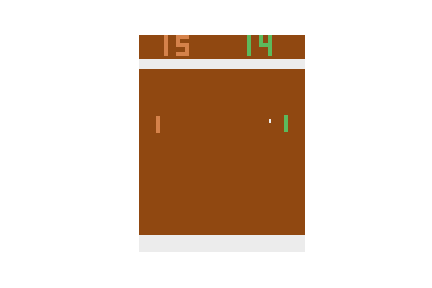
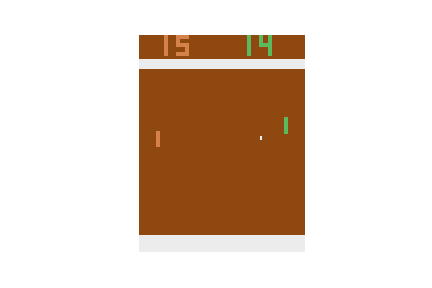
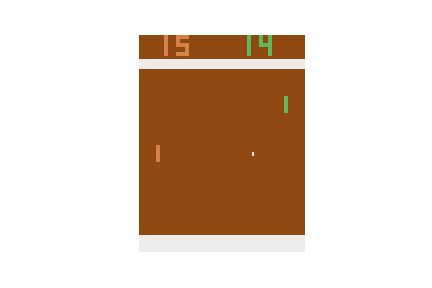
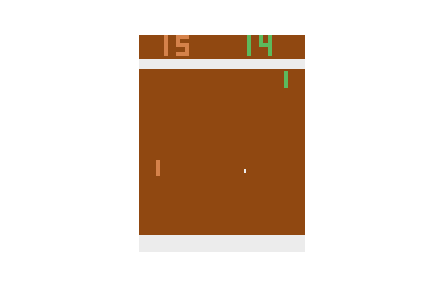
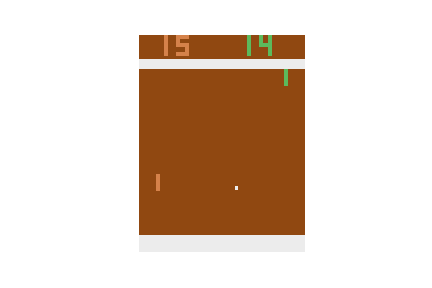
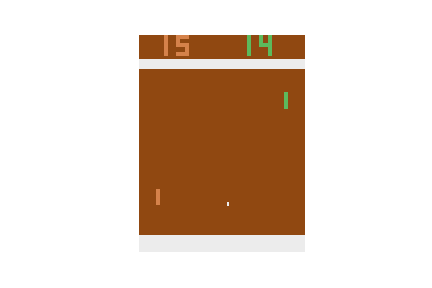
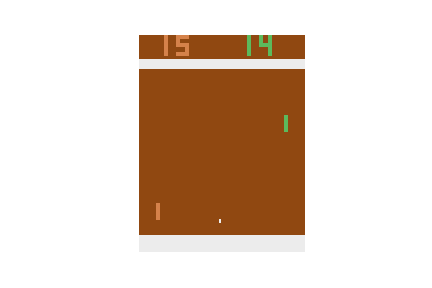
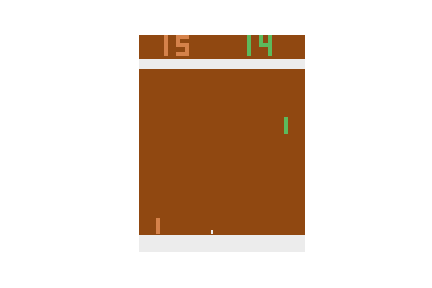
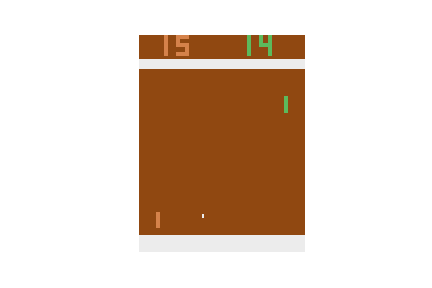
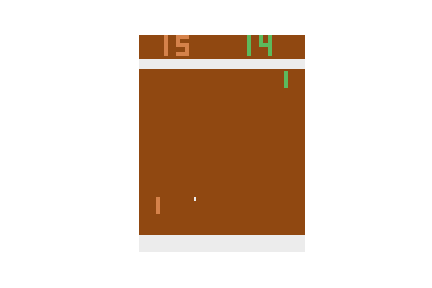
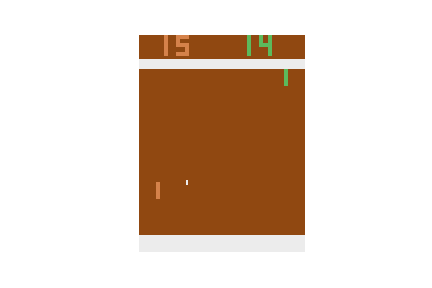
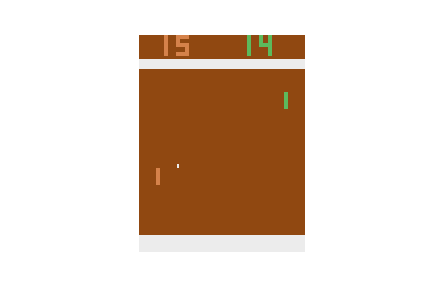
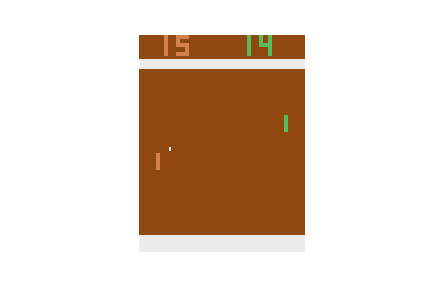
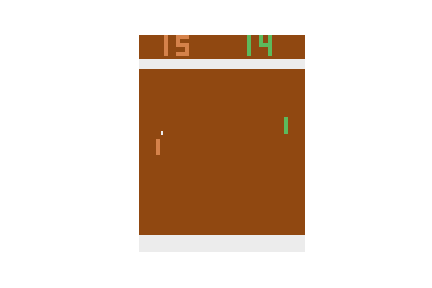
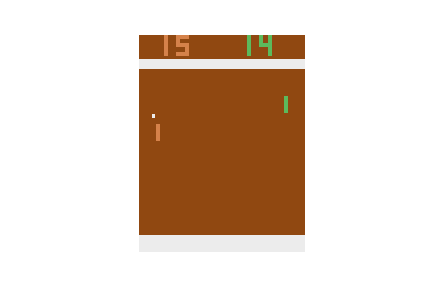
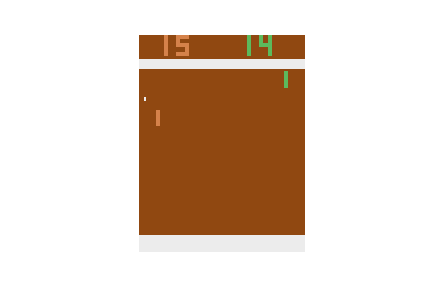
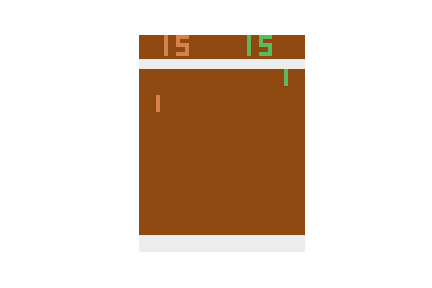
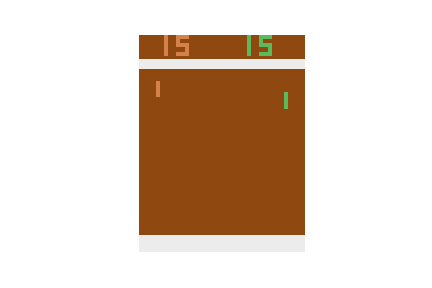
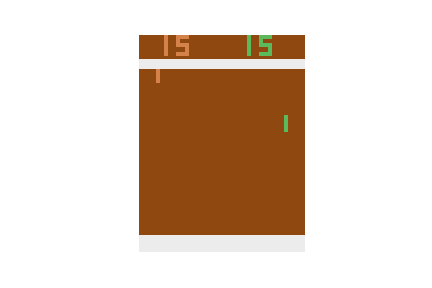
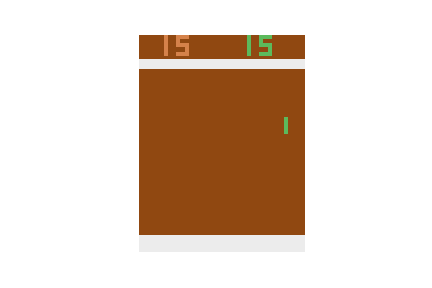
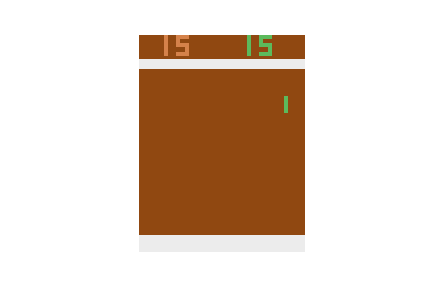
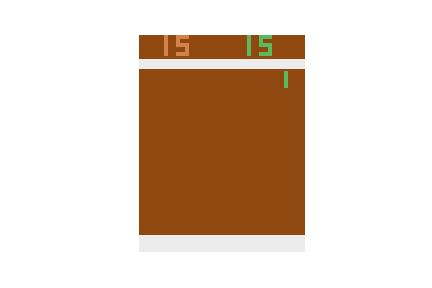
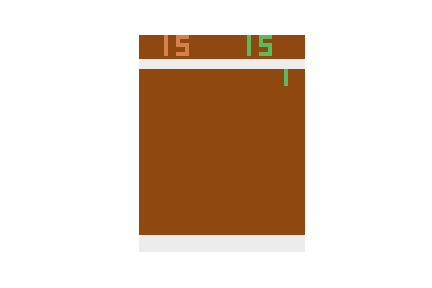
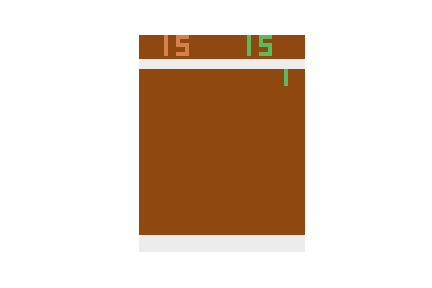
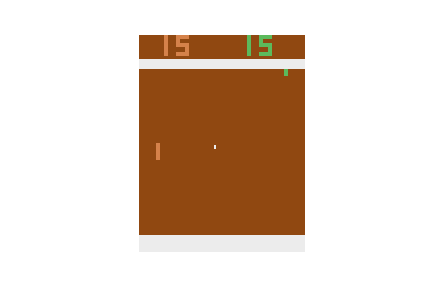
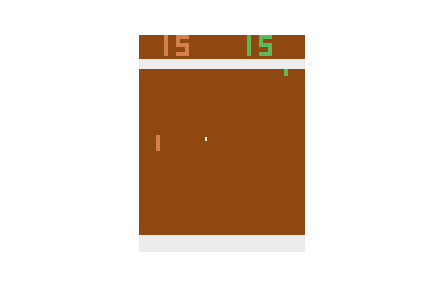
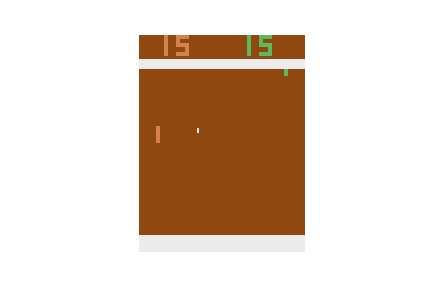
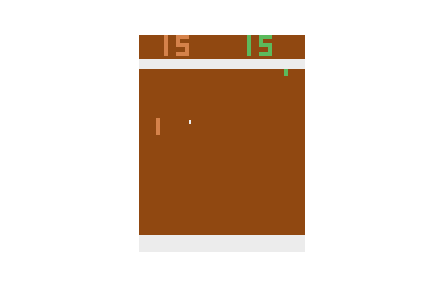
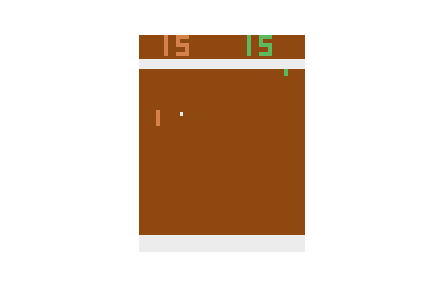
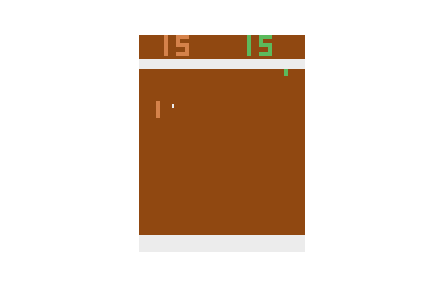
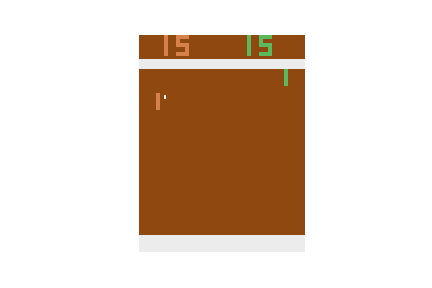
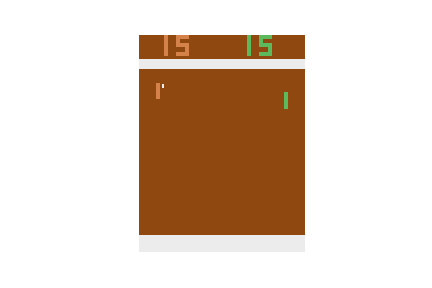
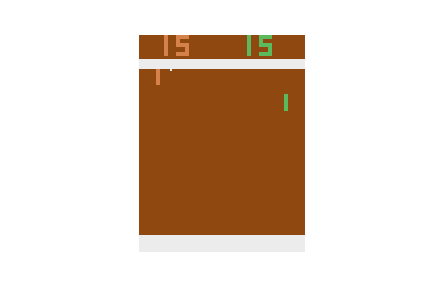
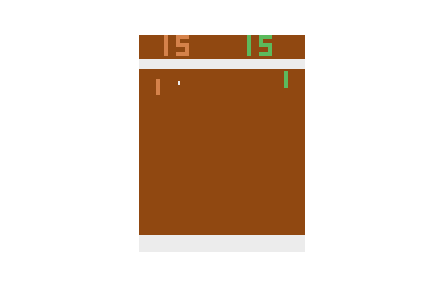
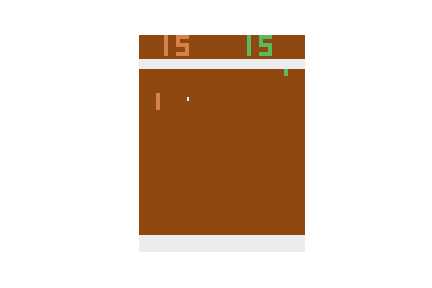
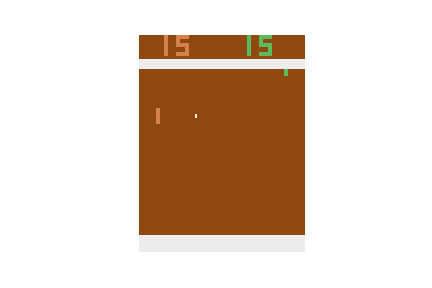
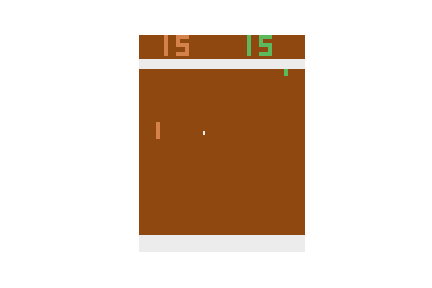
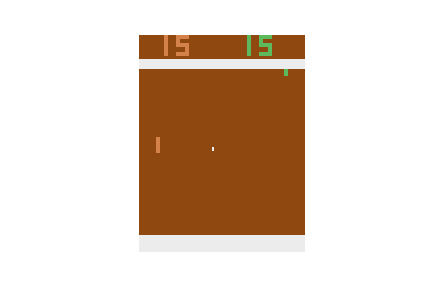
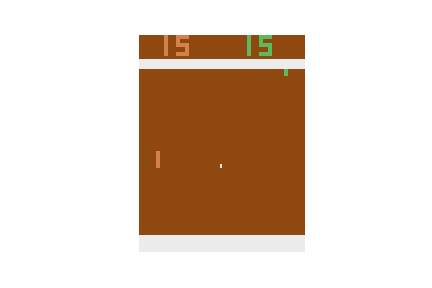
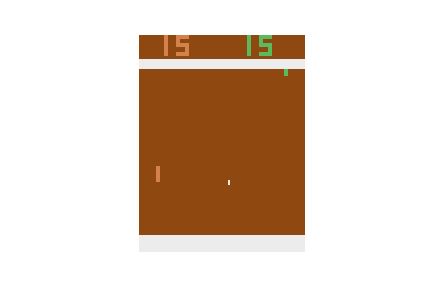
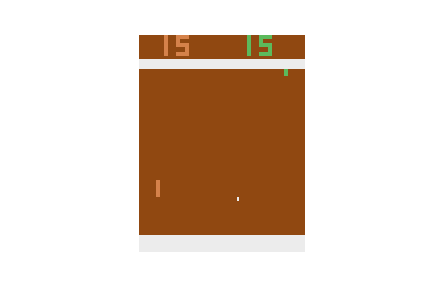
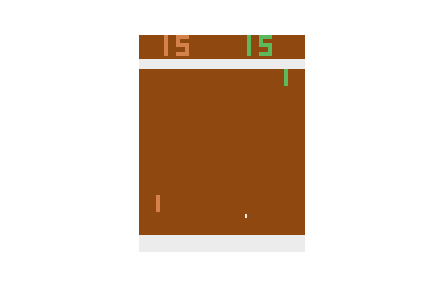
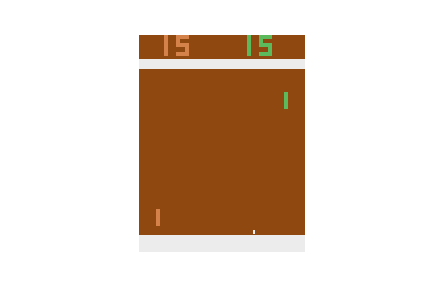
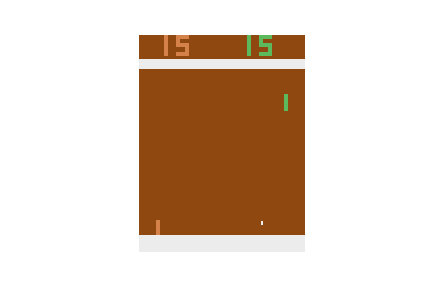
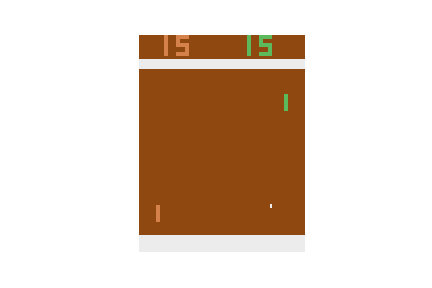
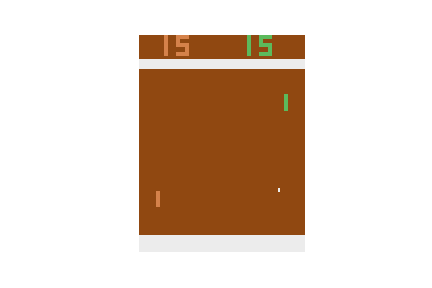
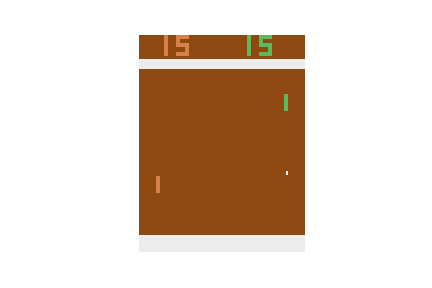
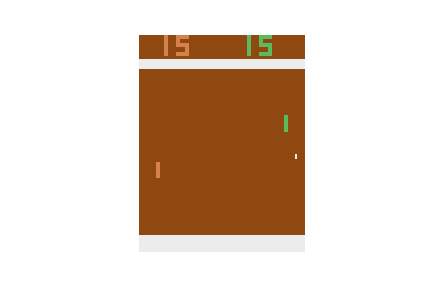
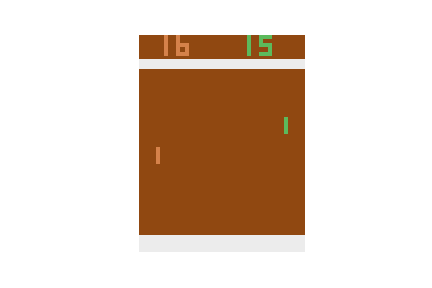
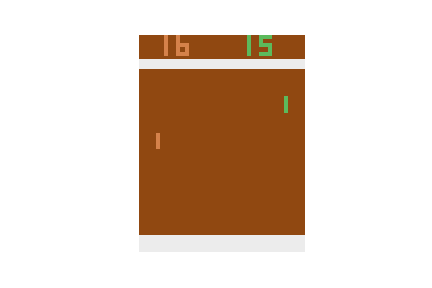
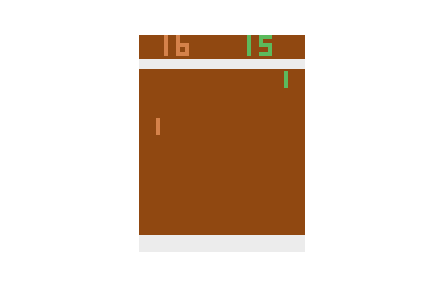
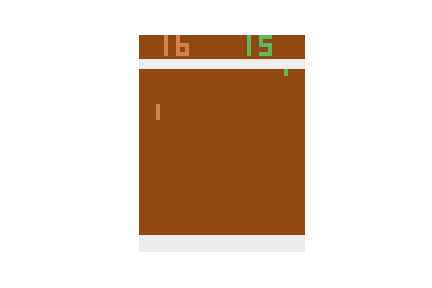
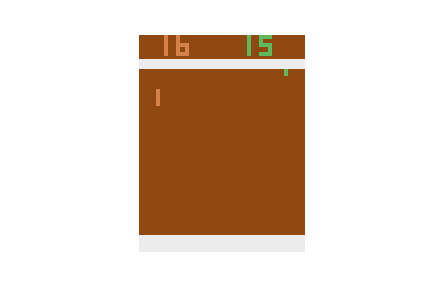
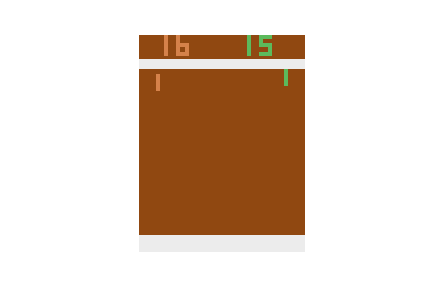
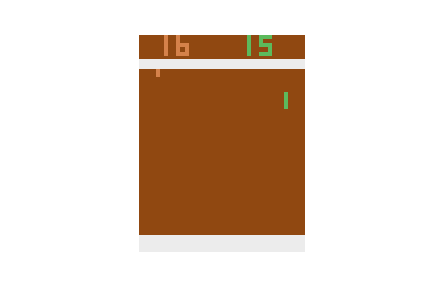
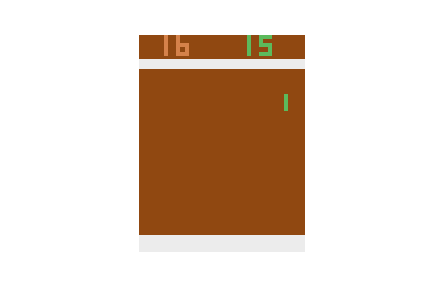
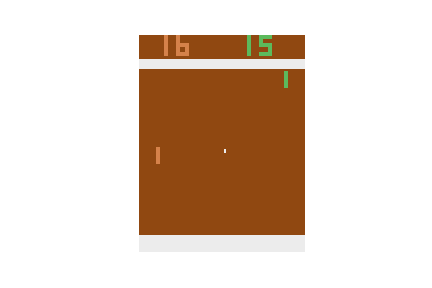
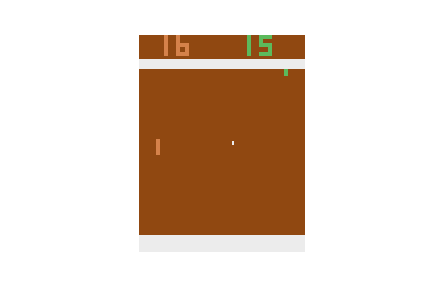
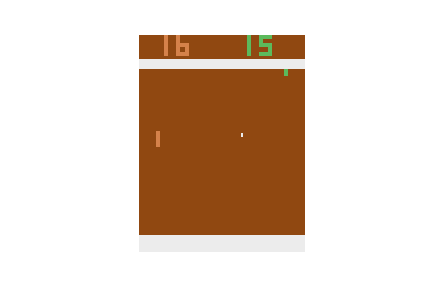
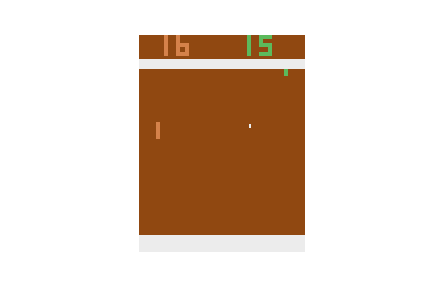
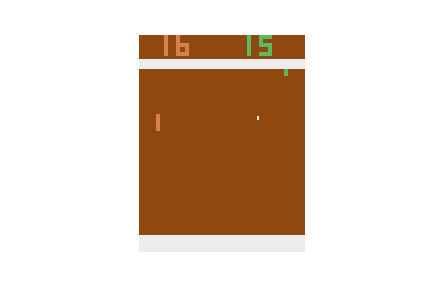
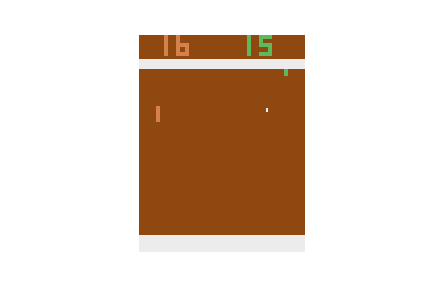
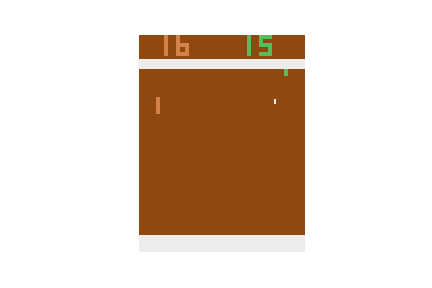
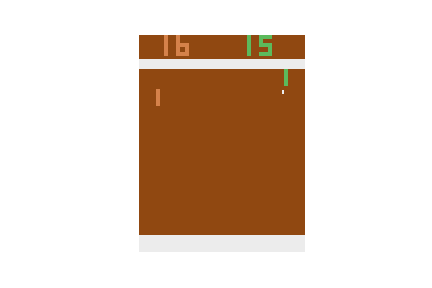
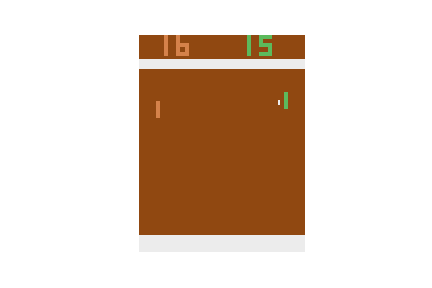
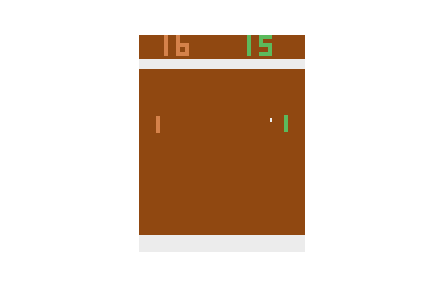
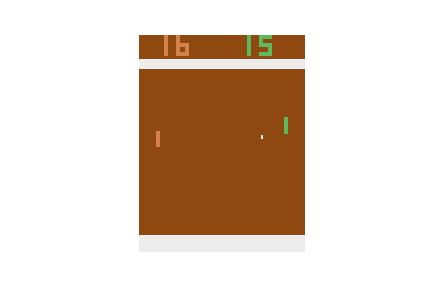
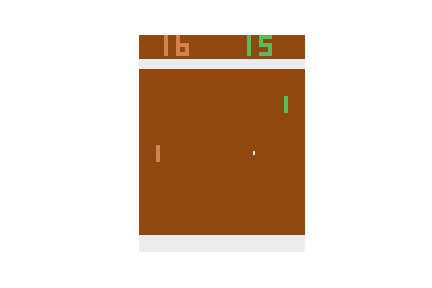
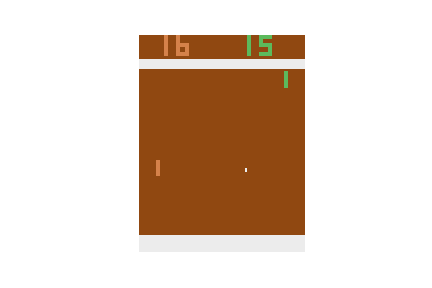
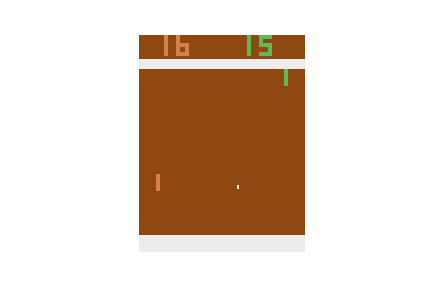
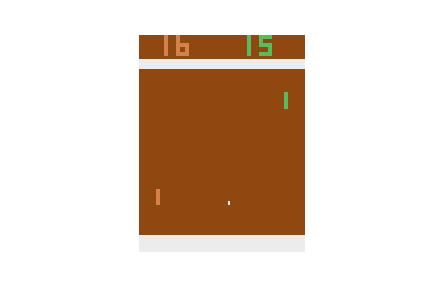
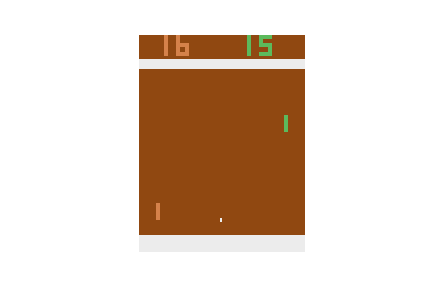
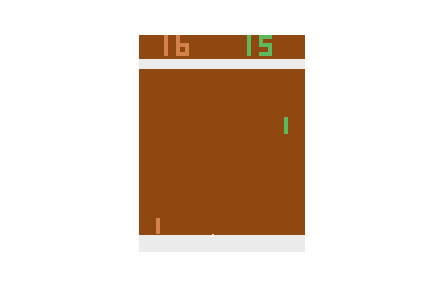
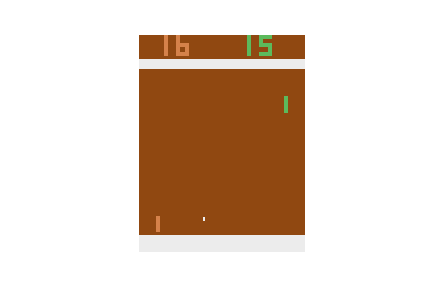
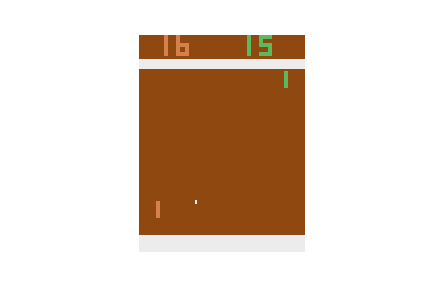
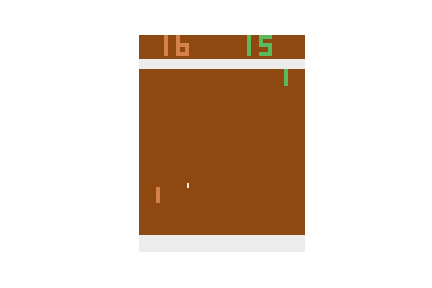
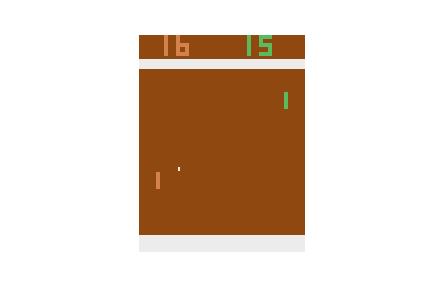
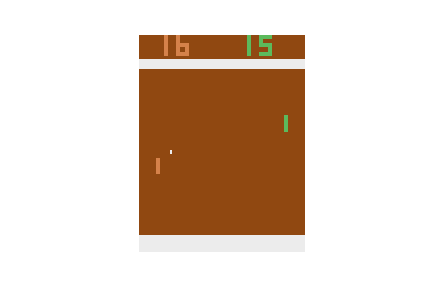
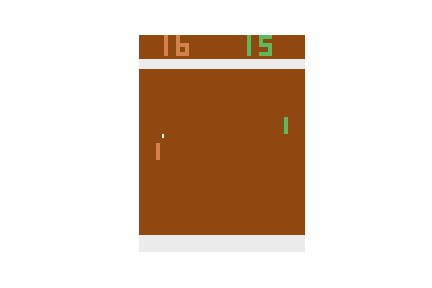
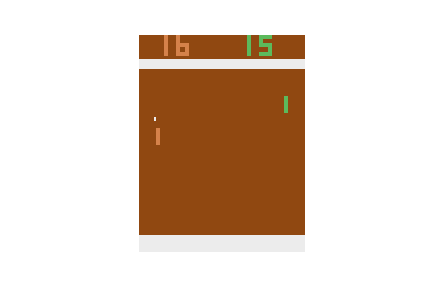
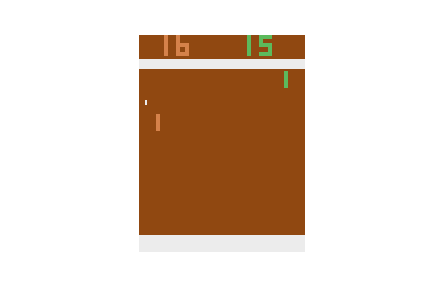
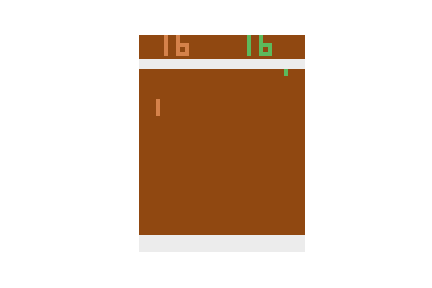
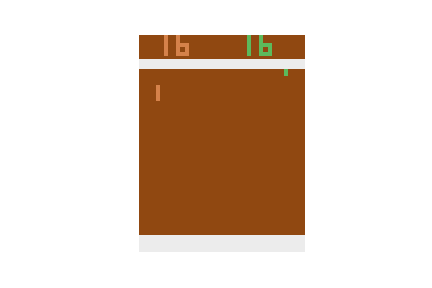
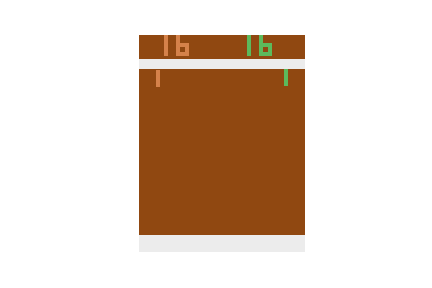
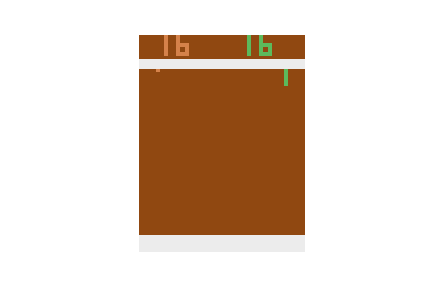
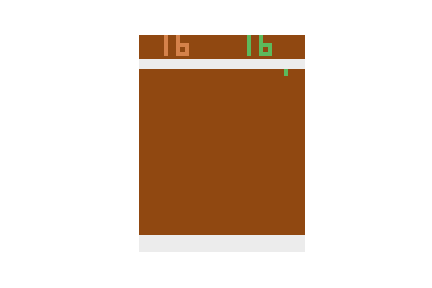
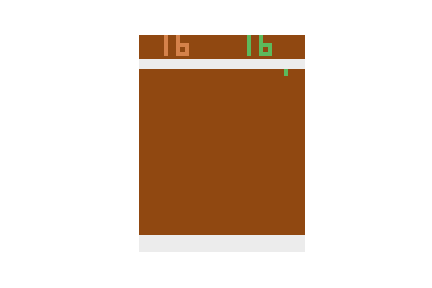
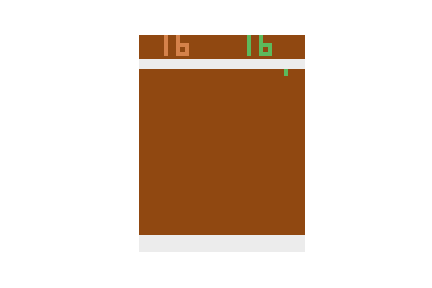
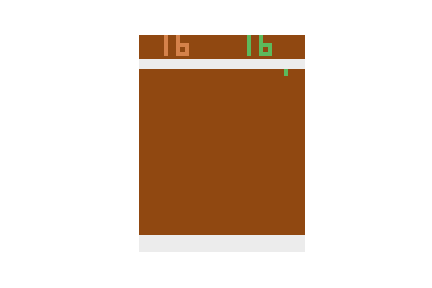
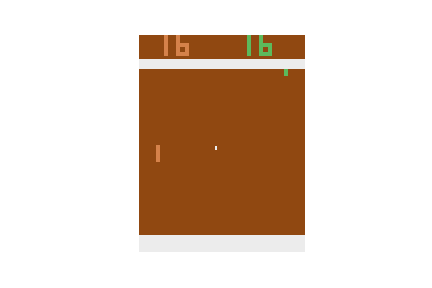
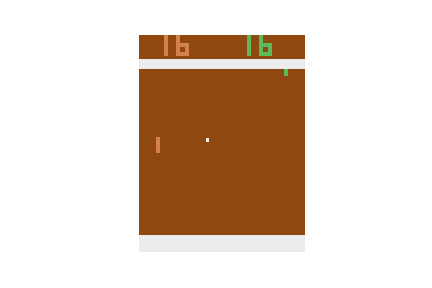
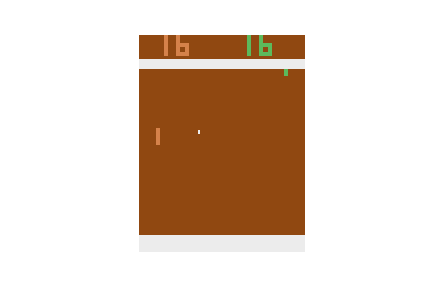
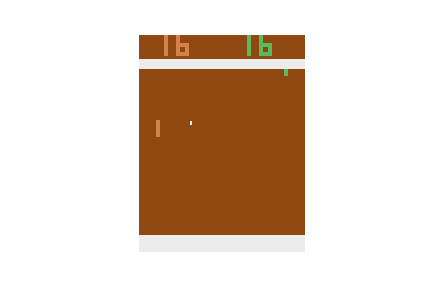
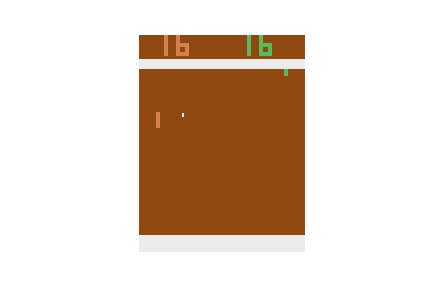
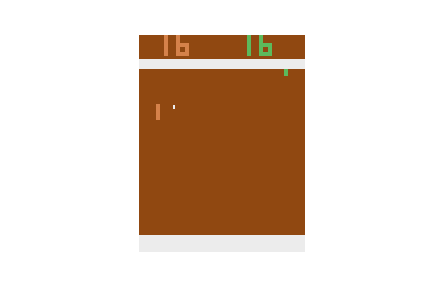
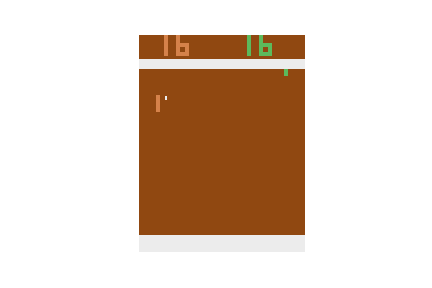
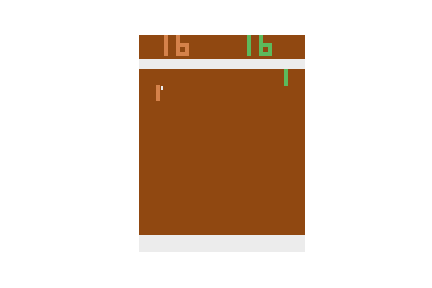
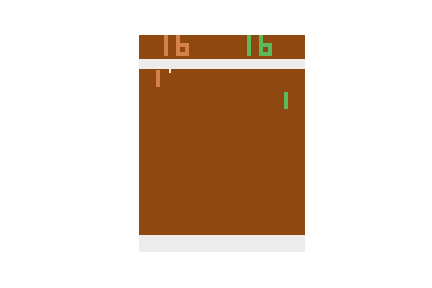
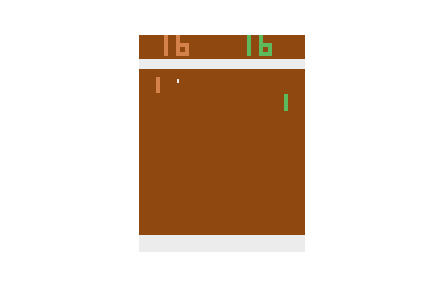
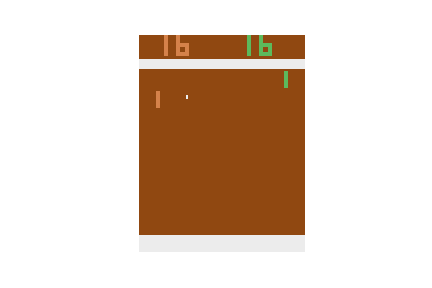
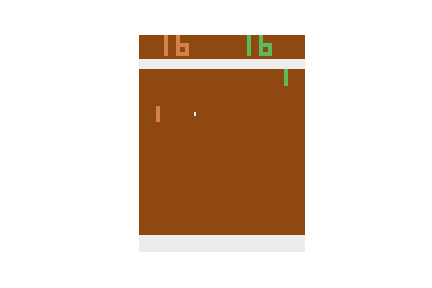
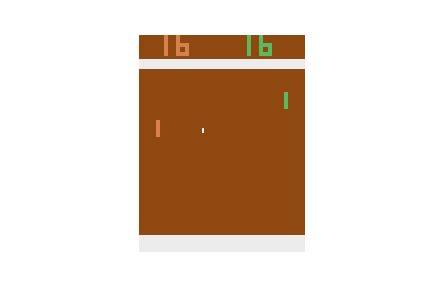
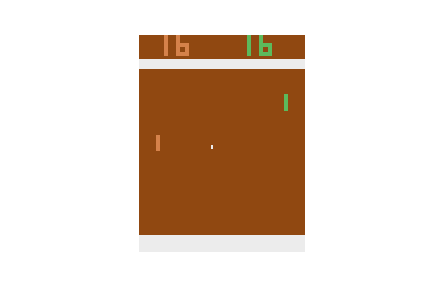
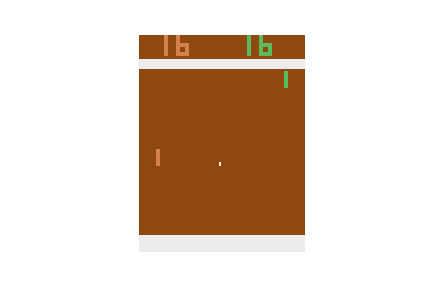
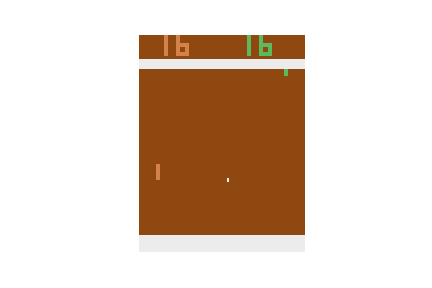
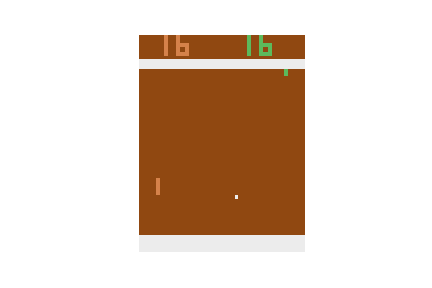
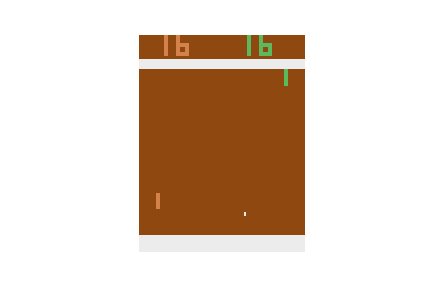
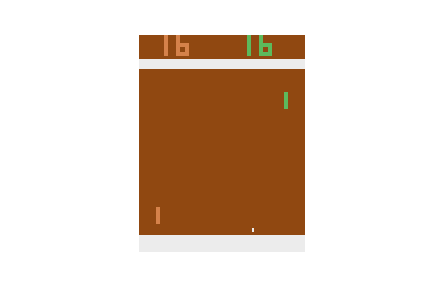
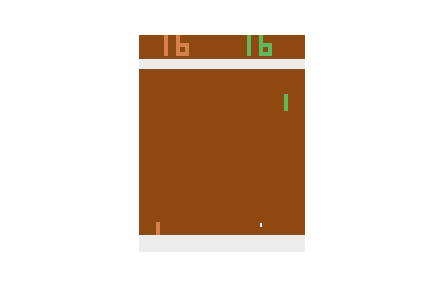
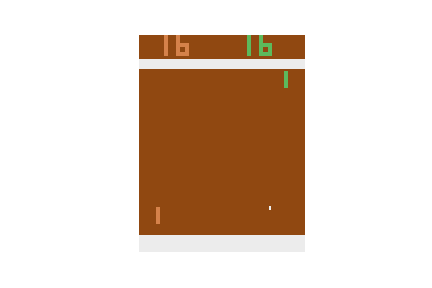
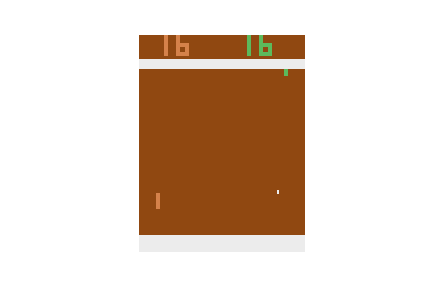
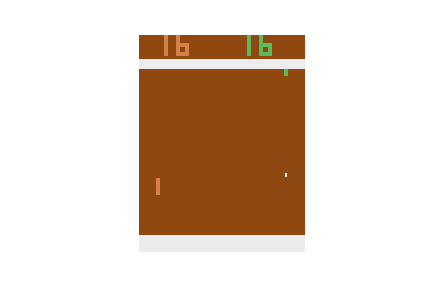
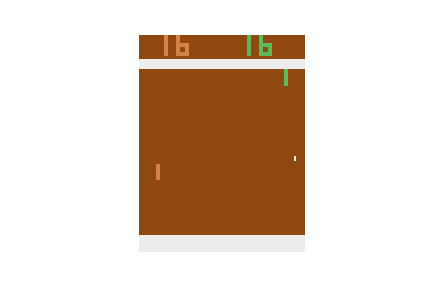
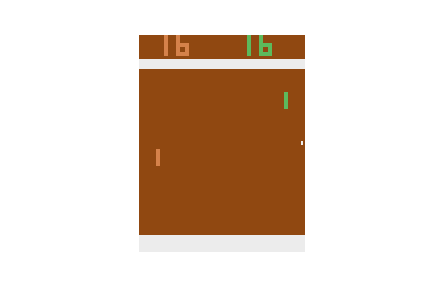
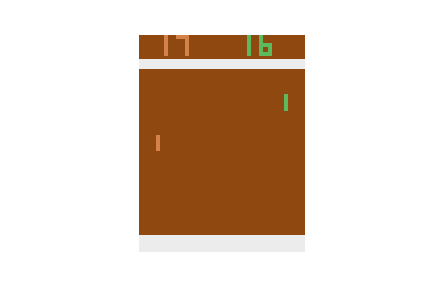
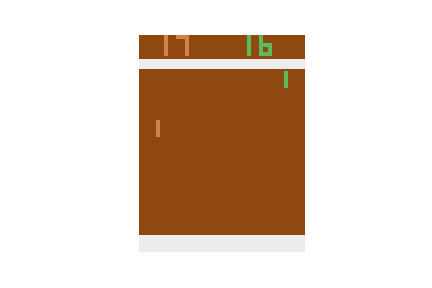
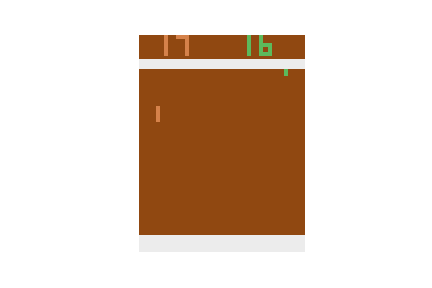
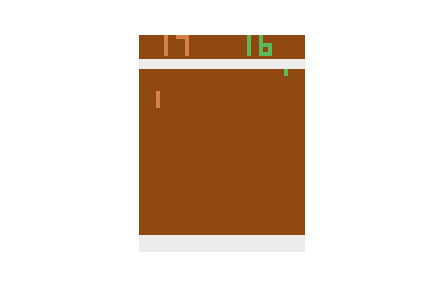
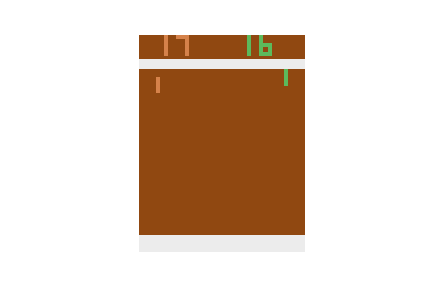
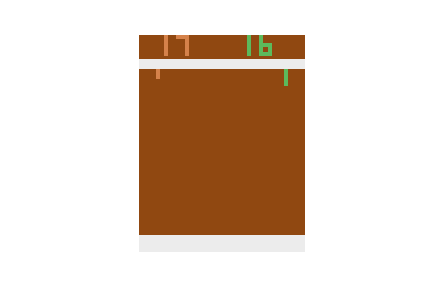
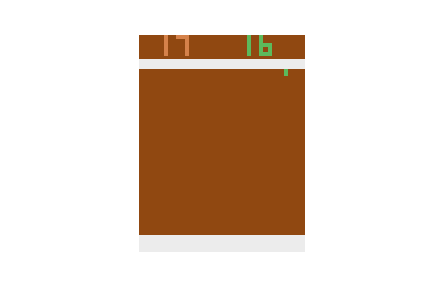
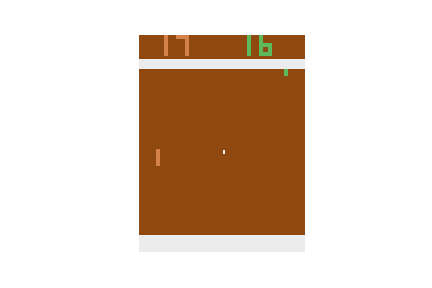
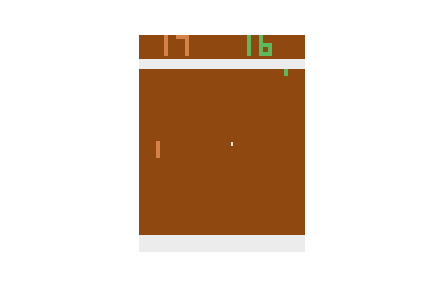
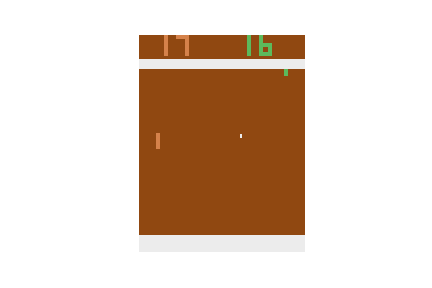
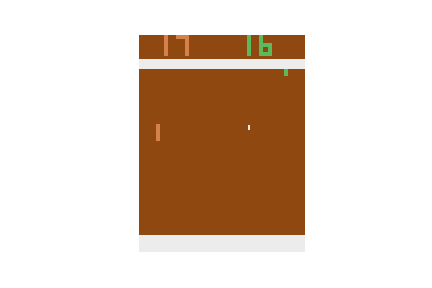
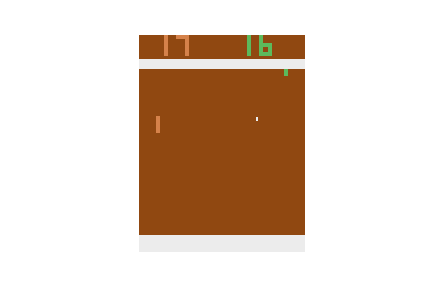
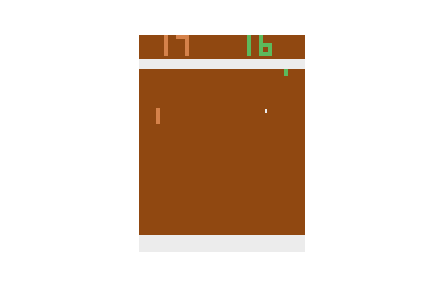
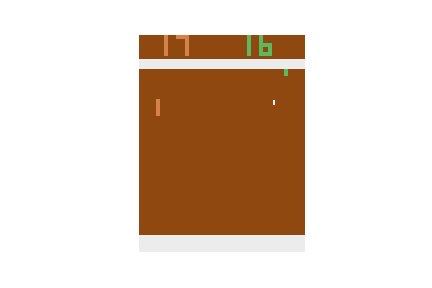
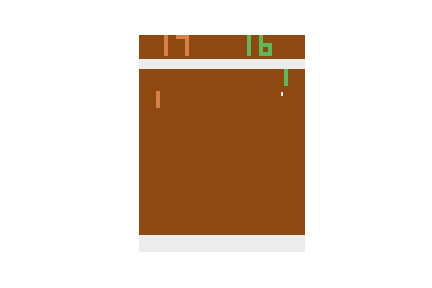
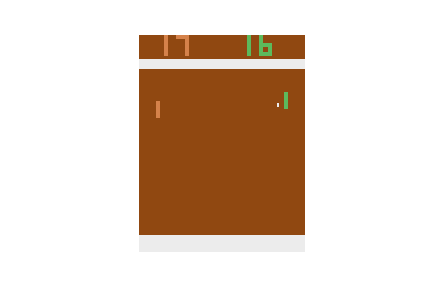
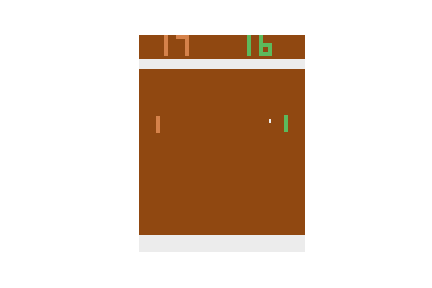
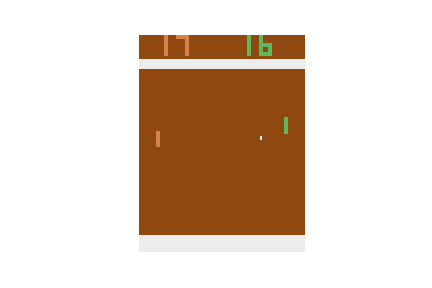
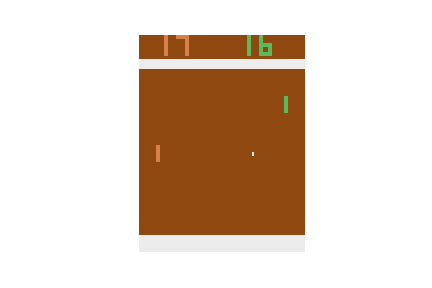
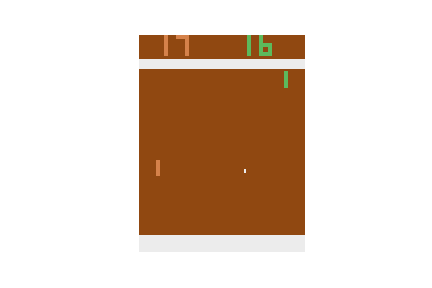
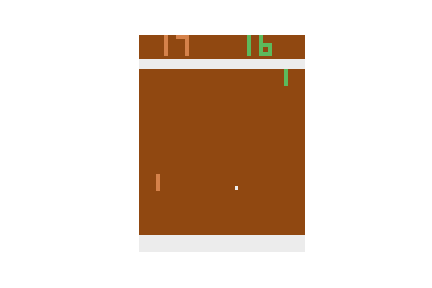
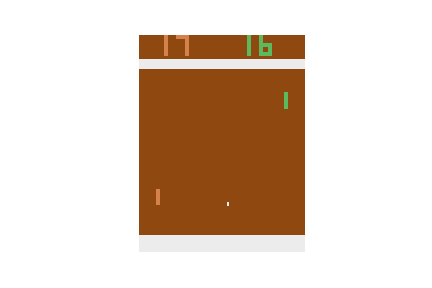
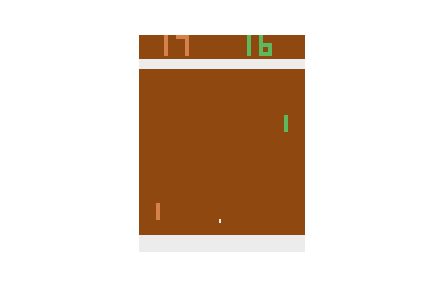
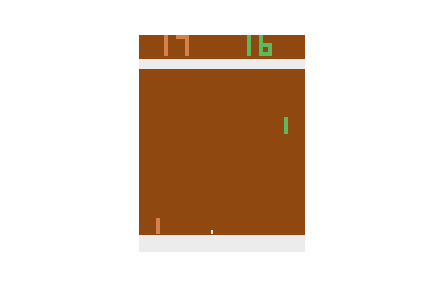
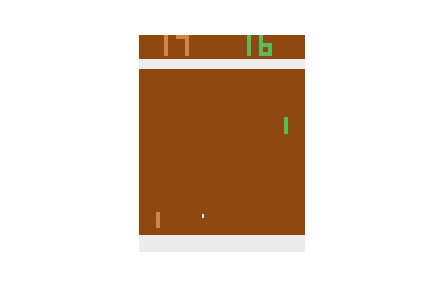
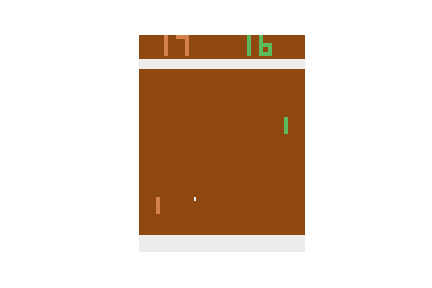
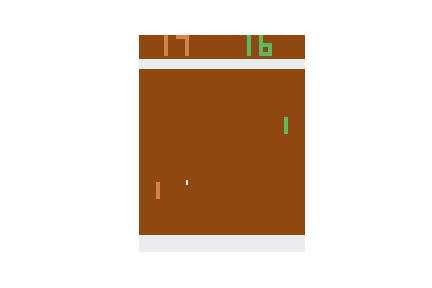
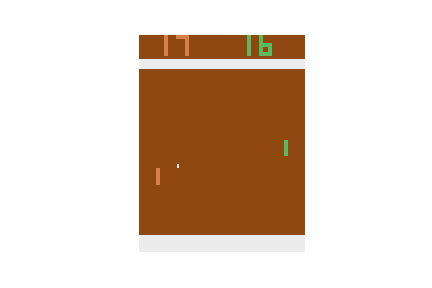
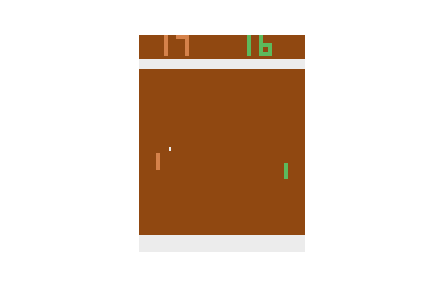
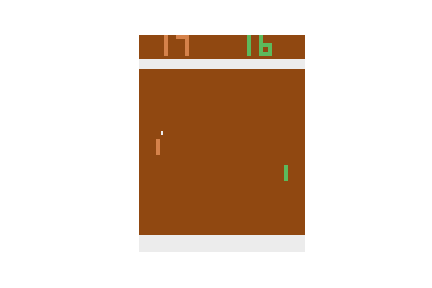
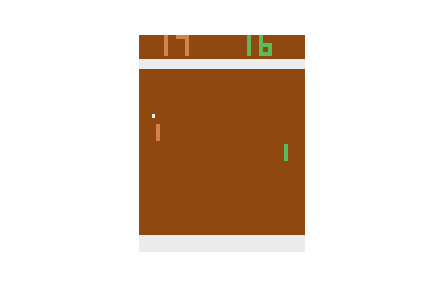
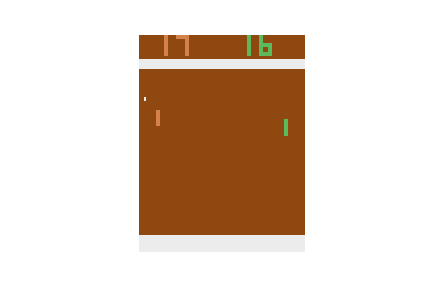
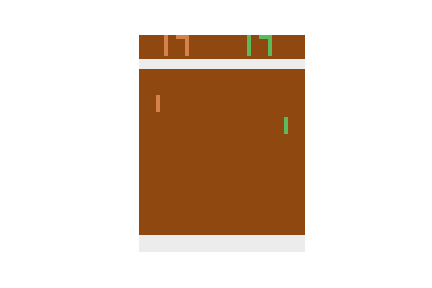
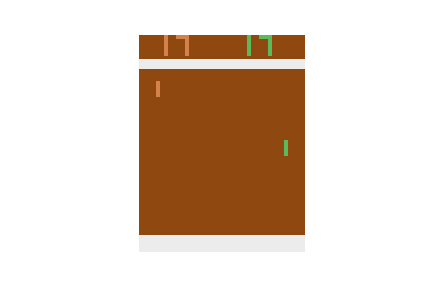
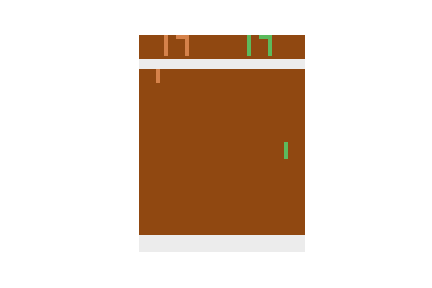
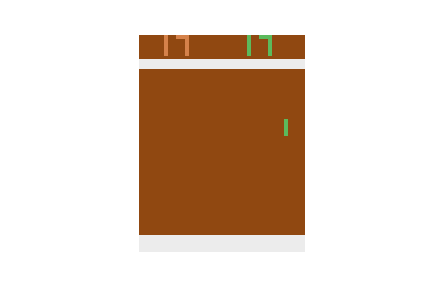
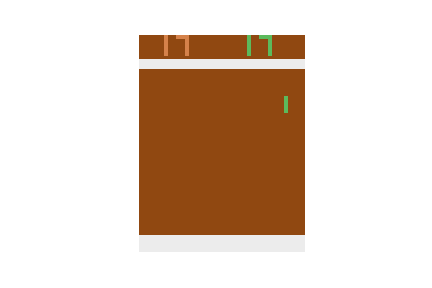
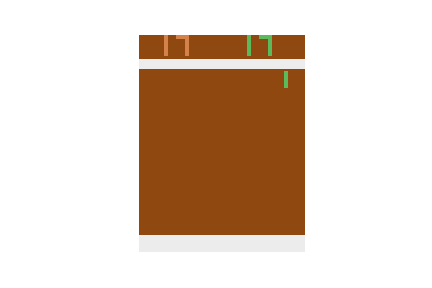
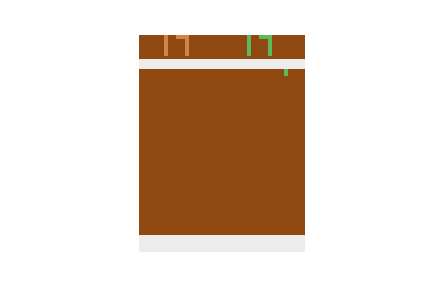
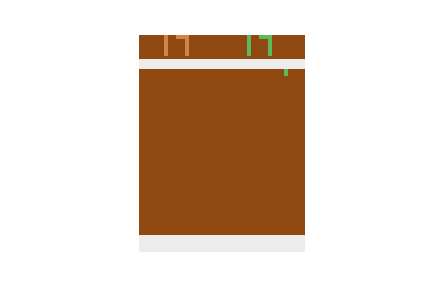
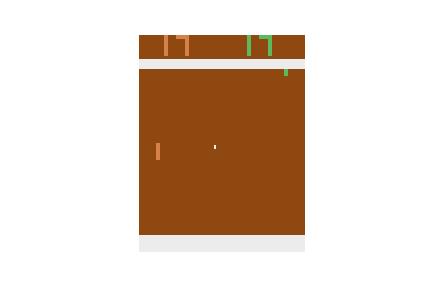
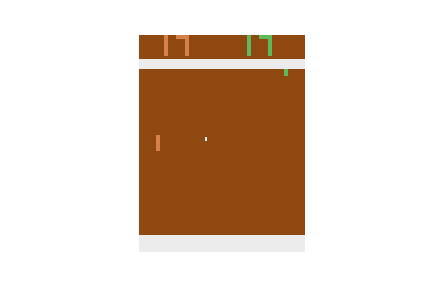
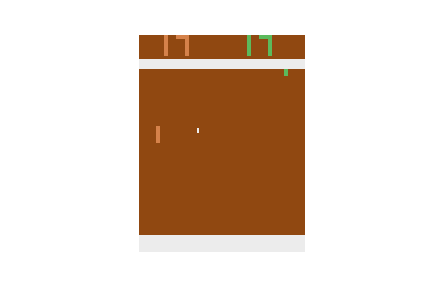
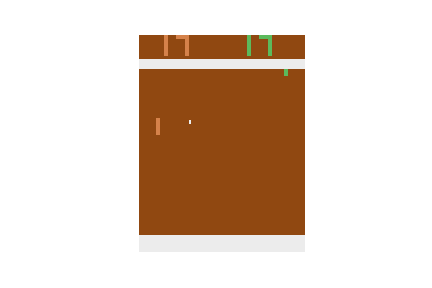
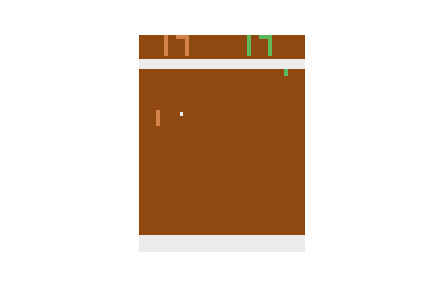
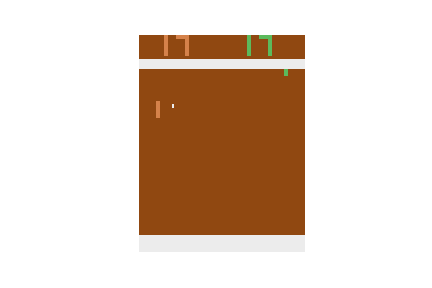
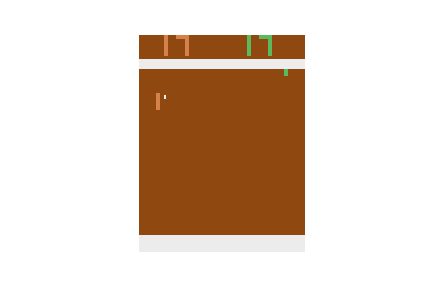
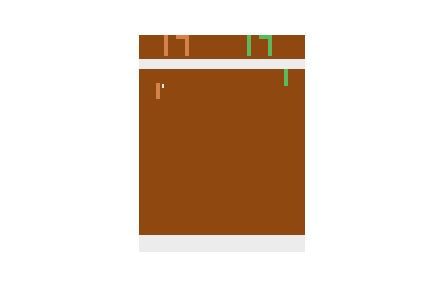
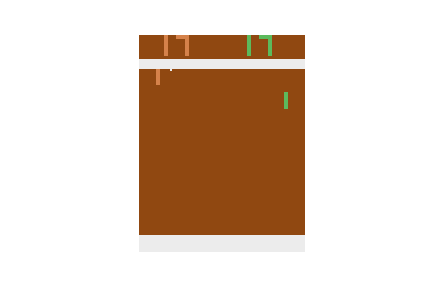
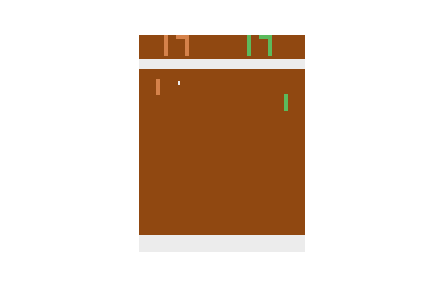
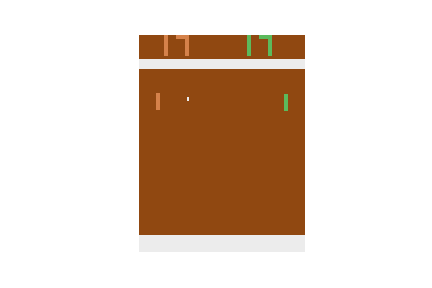
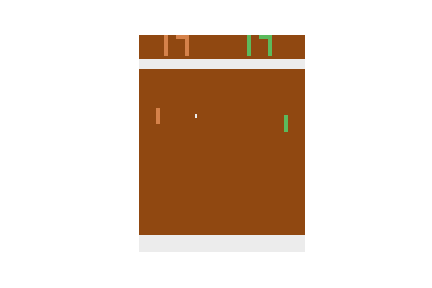
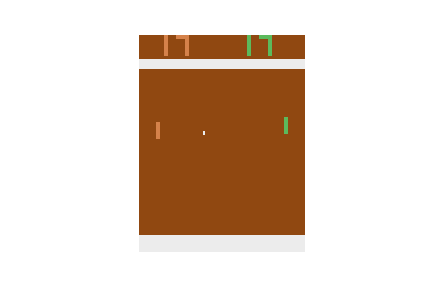
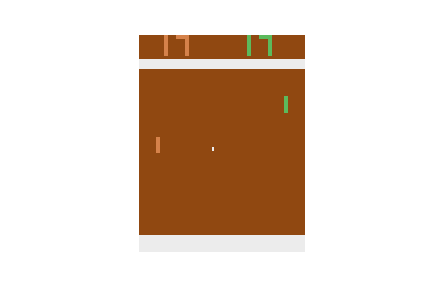
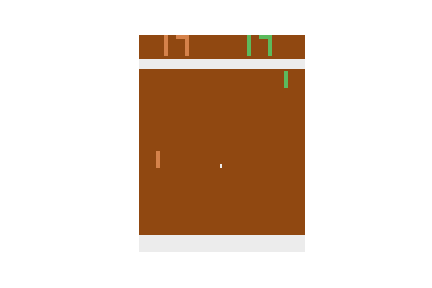
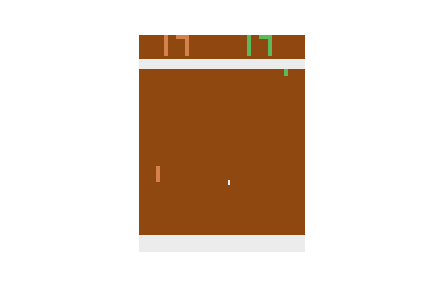
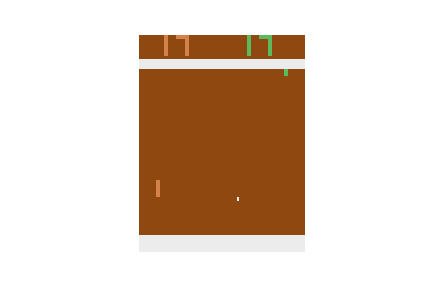
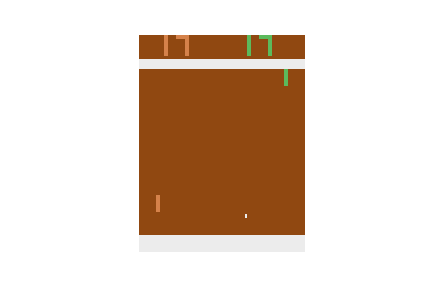
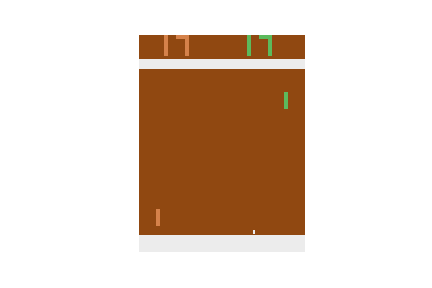
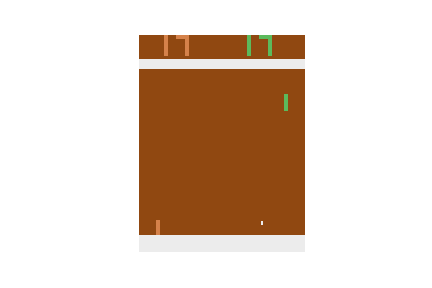
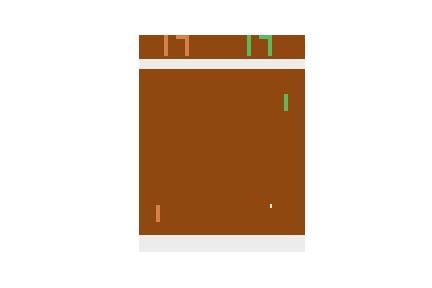
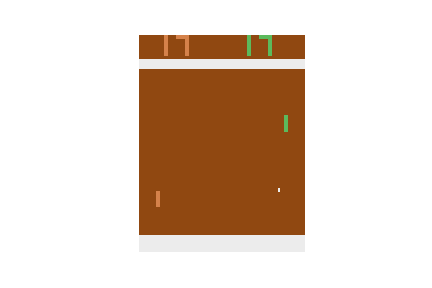
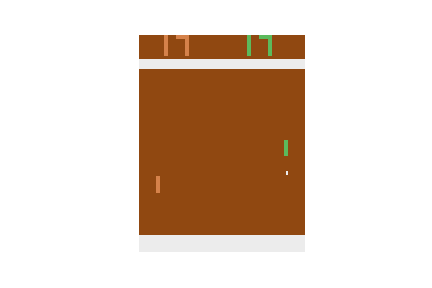
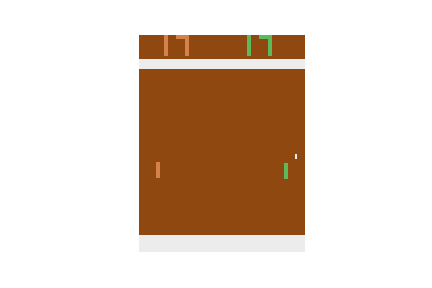
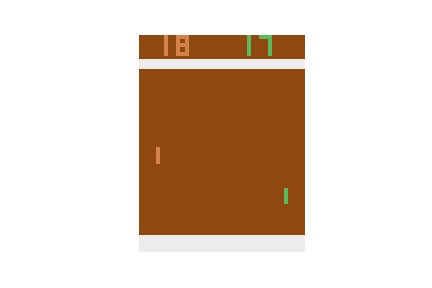
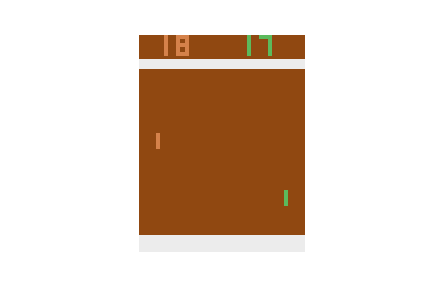
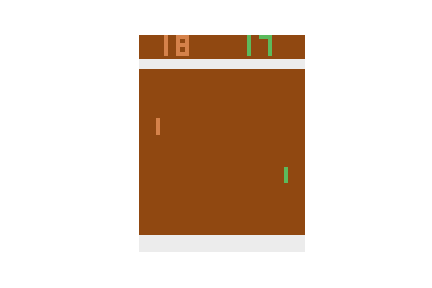
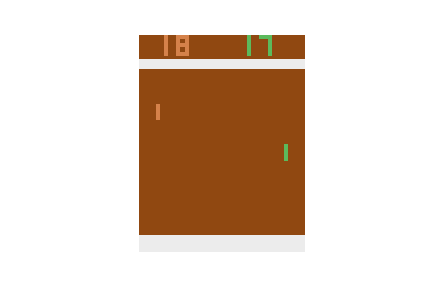
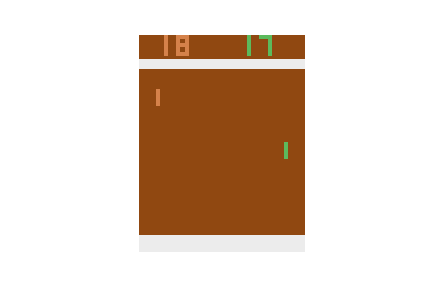
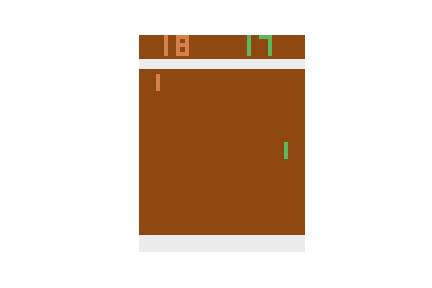
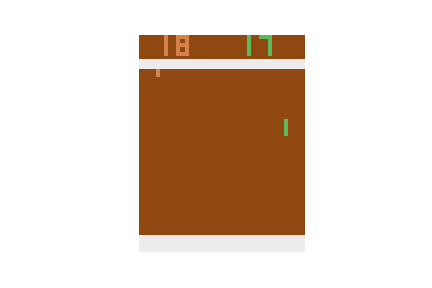
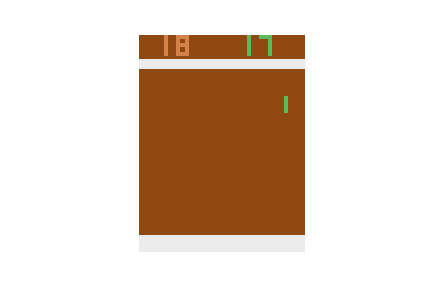
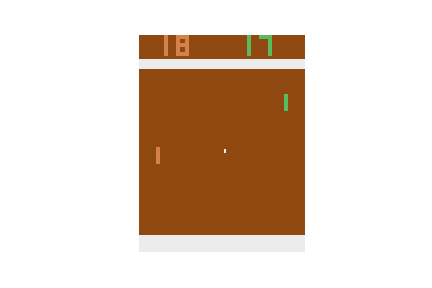
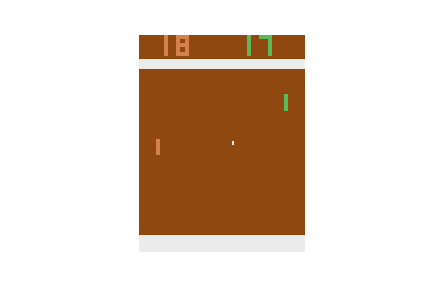
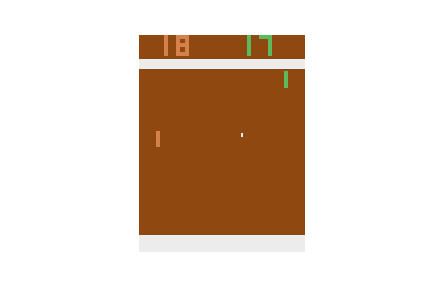
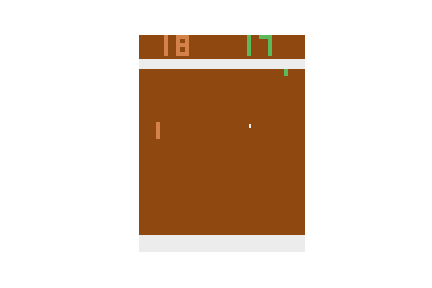
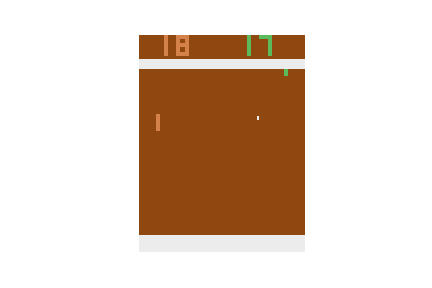
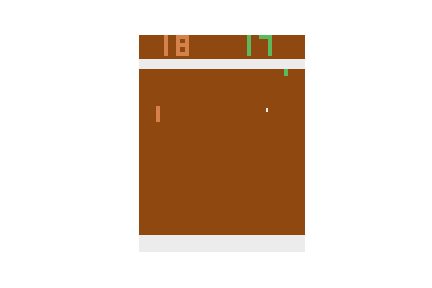
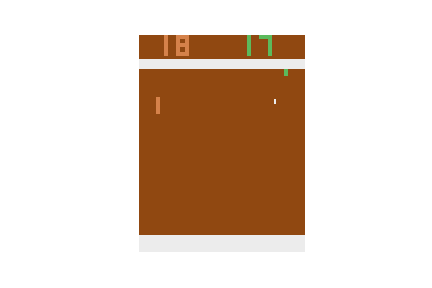
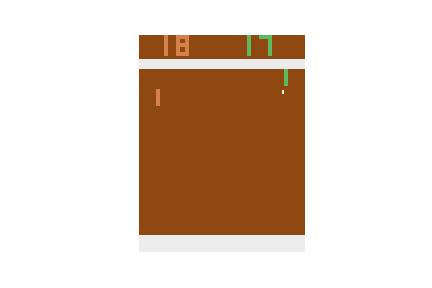
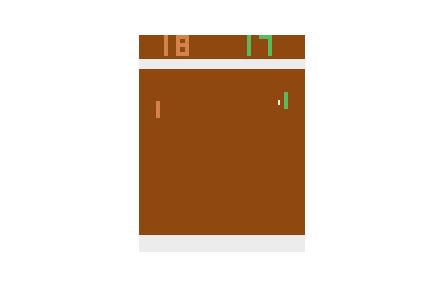
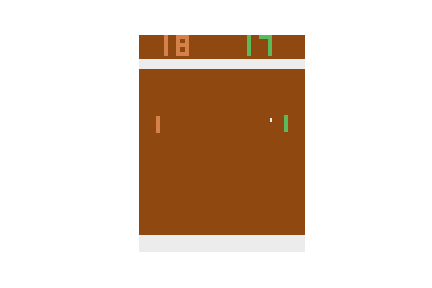
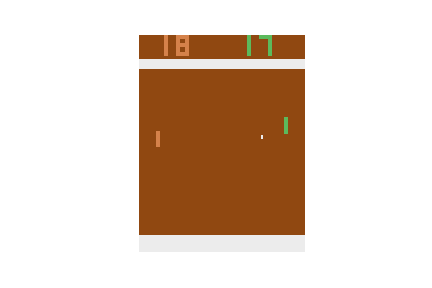
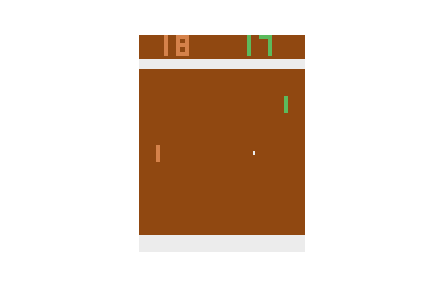
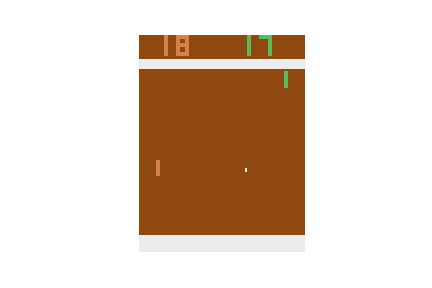
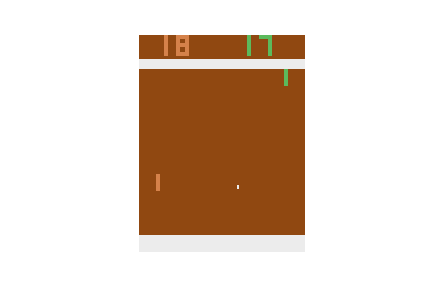
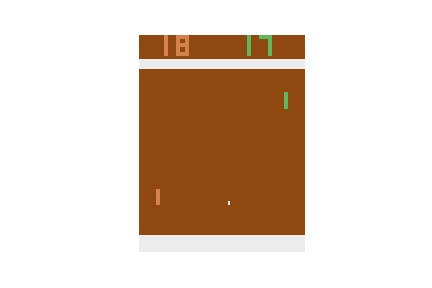
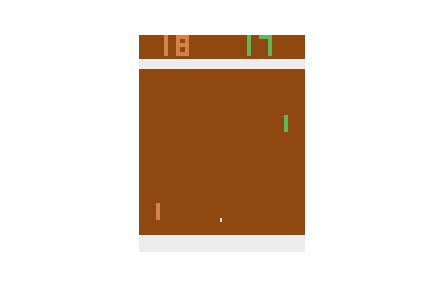
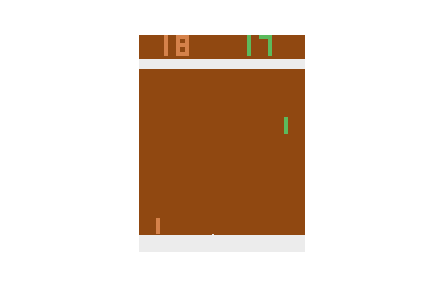
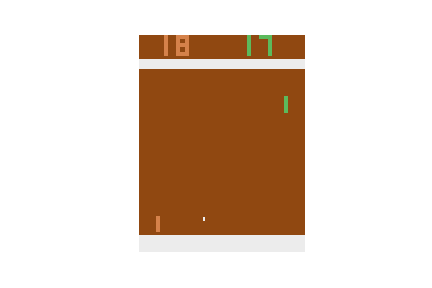
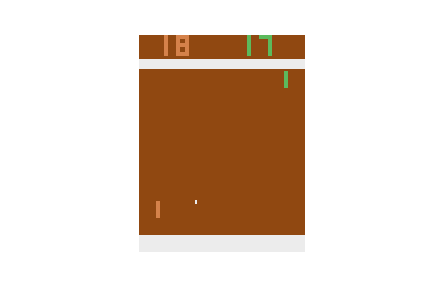
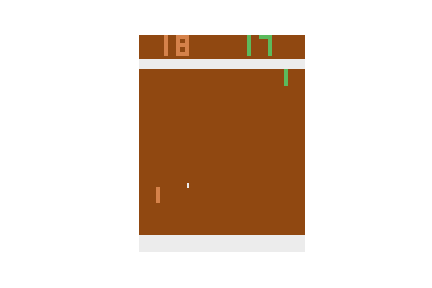
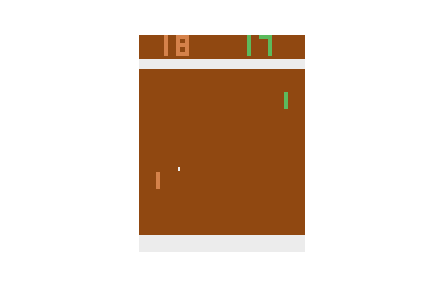
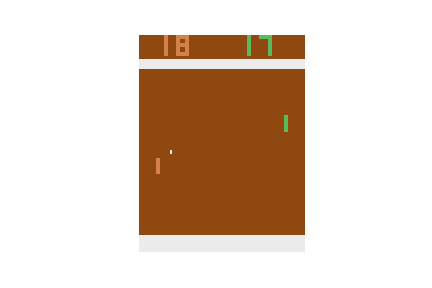
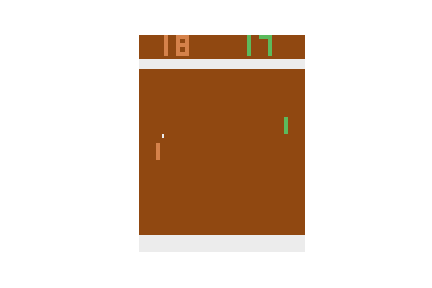
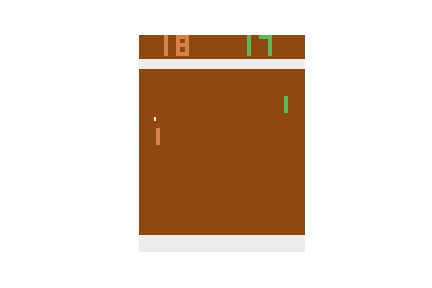
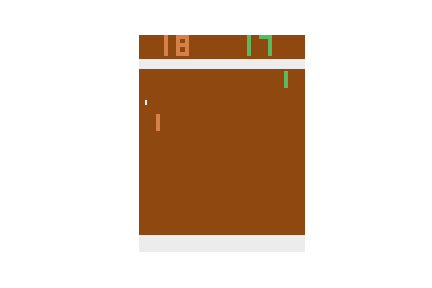
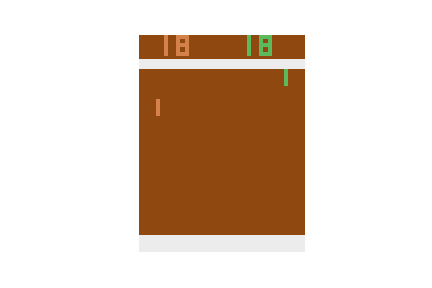
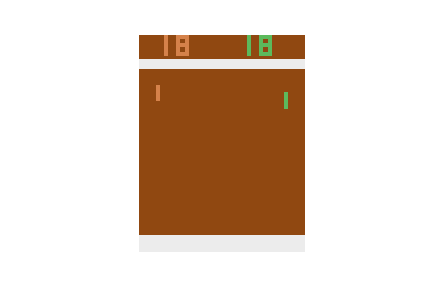
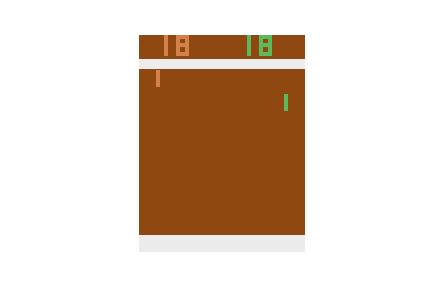
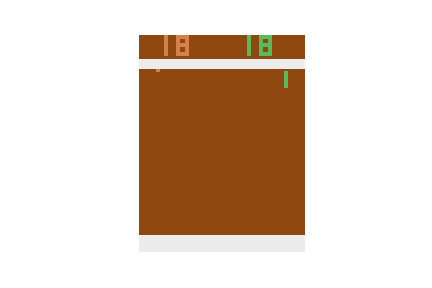
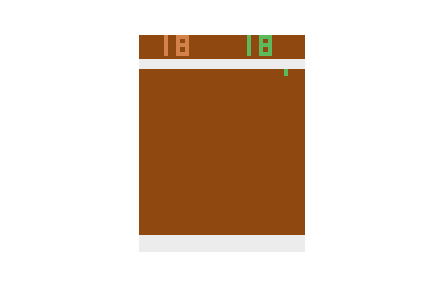
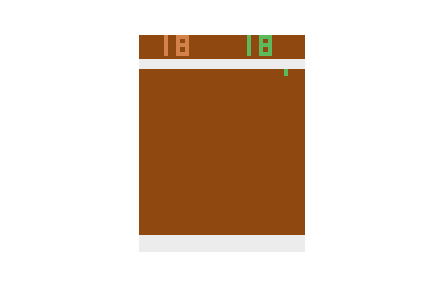
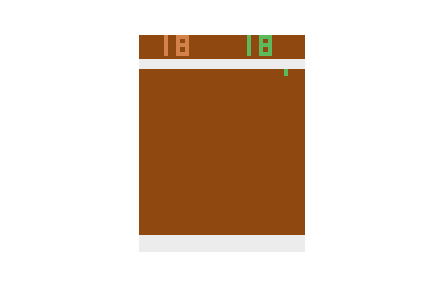
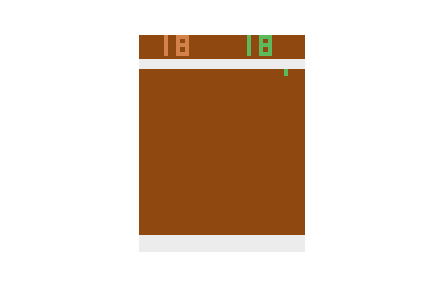
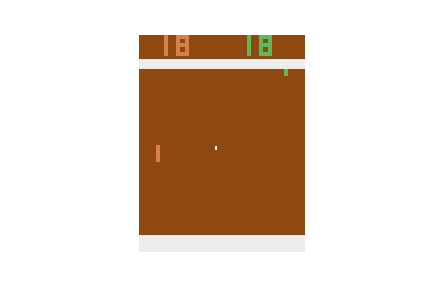
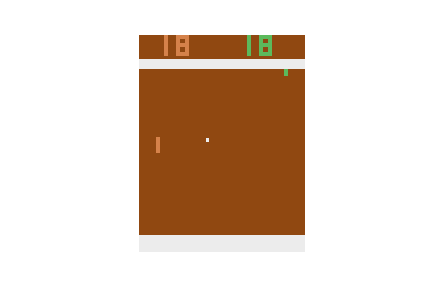
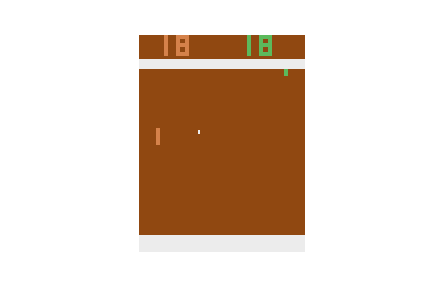
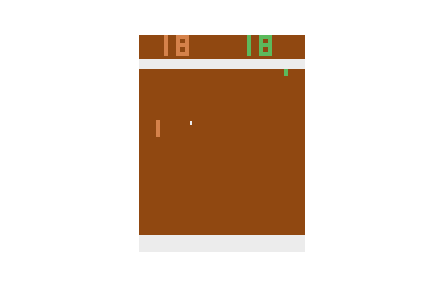
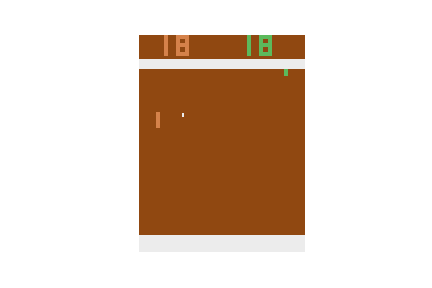
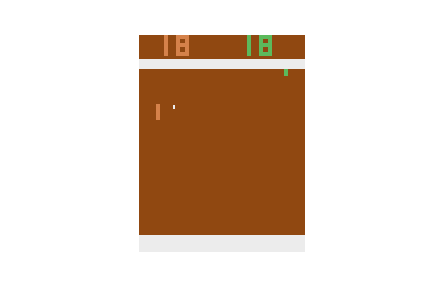
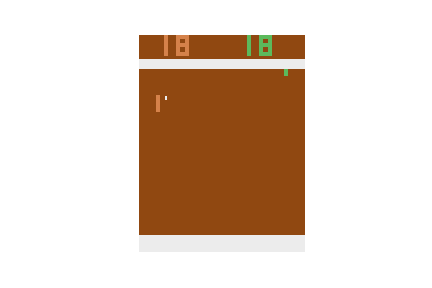
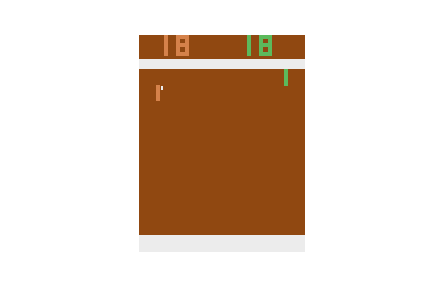
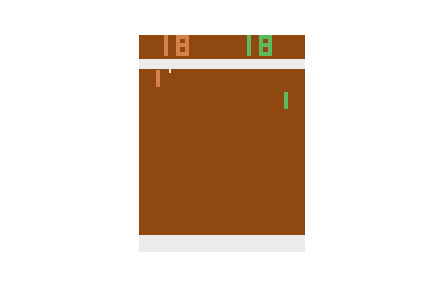
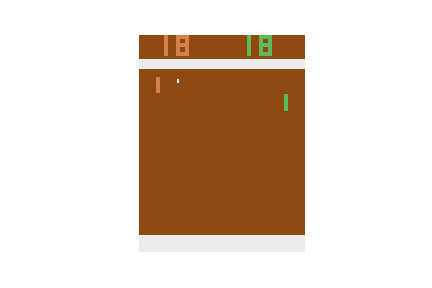
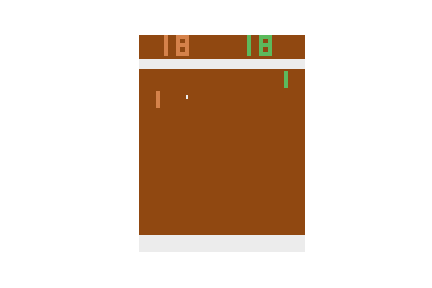
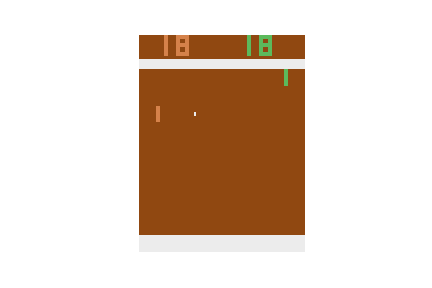
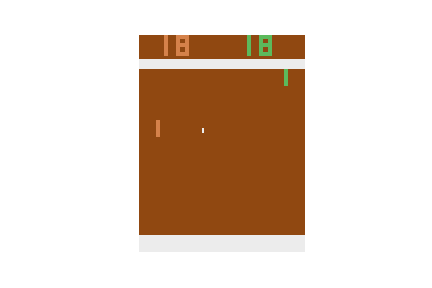

In [23]:
pong_utils.play(env, policy, time=1200) 

In [24]:
# save your policy!
torch.save(policy, 'PPO_X.policy')

# load policy if needed
#policy = torch.load('PPO_X.policy')
#pong_utils.play(env, policy, time=1000) 

# try and test out the solution 
# make sure GPU is enabled, otherwise loading will fail
# (the PPO verion can win more often than not)!
#
#policy_solution = torch.load('PPO_solution.policy')
#pong_utils.play(env, policy_solution, time=1000) 

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
